In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from scipy import misc, signal

import torch
from torch.nn import functional as F

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from skimage.color import label2rgb
from PIL import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
root = Path('extra/wd/step1')

In [3]:
rgba = Image.open(root/'wd_color.png').convert('RGBA')
rgba = np.asarray(rgba)
rgb = rgba[...,:3]
lbls = np.array(Image.open(root/'regions.png'))
tileimg = np.array(Image.open(root/'tiles.png'))
lbls.shape, rgb.shape, tileimg.shape

((2232, 5988), (2232, 5988, 3), (2232, 5988))

In [20]:
def showx(im, cover=lbls):
    plt.figure(figsize=(14,6))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)
    
def get_highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return img
    
def highlight(rgb, mask, opacity=0.2, cover=lbls):
    img = get_highlight(rgb, mask, opacity=opacity)
    return showx(img, cover=cover)
    
# showx(lbls)

In [152]:
nodes = load_yaml(root/'nodes.yaml')
len(nodes)

781

In [6]:
filled = expand_labels(lbls,100)
(filled==0).sum()

0

In [7]:
borders = find_boundaries(filled, mode='thick')
# showx(borders)

In [8]:
clean = filled.copy()
clean[borders==1] = 0
# showx(clean)

In [9]:
# Image.fromarray(clean.astype(np.int16)).save(root / "clean.png")
# Image.fromarray(((clean!=0)*255).astype(np.uint8)).save(root / "borders.png")

In [10]:
cnts = Counter(clean.reshape(-1))
len(cnts)

786

In [11]:
colors = {node['ID']: Counter(map(tuple, rgb[node['ID']==lbls].tolist())) for node in tqdm(nodes)}
len(colors)

  0%|          | 0/781 [00:00<?, ?it/s]

781

In [11]:
colors = {1: Counter({(0, 255, 128): 2874}), 2: Counter({(239, 228, 176): 32592}), 3: Counter({(135, 207, 213): 77923}), 4: Counter({(135, 207, 213): 92486}), 5: Counter({(135, 207, 213): 18324}), 6: Counter({(239, 228, 176): 17305}), 7: Counter({(135, 207, 213): 144524}), 8: Counter({(135, 207, 213): 56737}), 9: Counter({(0, 255, 128): 2140}), 10: Counter({(239, 228, 176): 20707}), 11: Counter({(0, 255, 128): 1533}), 12: Counter({(163, 73, 164): 123982}), 13: Counter({(135, 207, 213): 30041}), 14: Counter({(163, 73, 164): 7631}), 15: Counter({(163, 73, 164): 4366}), 16: Counter({(0, 255, 128): 5001}), 17: Counter({(163, 73, 164): 26587}), 18: Counter({(163, 73, 164): 79791}), 19: Counter({(239, 228, 176): 2646}), 20: Counter({(63, 72, 204): 38600}), 21: Counter({(239, 228, 176): 12850}), 22: Counter({(0, 255, 128): 2923}), 23: Counter({(239, 228, 176): 68362}), 24: Counter({(163, 73, 164): 4159}), 25: Counter({(135, 207, 213): 2734}), 26: Counter({(0, 255, 128): 2508}), 27: Counter({(135, 207, 213): 12863}), 28: Counter({(0, 255, 128): 2720}), 29: Counter({(135, 207, 213): 31719}), 30: Counter({(163, 73, 164): 3822}), 31: Counter({(135, 207, 213): 28654}), 32: Counter({(163, 73, 164): 22990}), 33: Counter({(163, 73, 164): 2076}), 34: Counter({(0, 255, 128): 1847}), 35: Counter({(239, 228, 176): 5999}), 36: Counter({(135, 207, 213): 8157}), 37: Counter({(163, 73, 164): 25866}), 38: Counter({(163, 73, 164): 3531}), 39: Counter({(135, 207, 213): 1899}), 40: Counter({(239, 228, 176): 21605}), 41: Counter({(135, 207, 213): 1191}), 42: Counter({(135, 207, 213): 15261}), 43: Counter({(163, 73, 164): 13343}), 44: Counter({(0, 255, 128): 1476}), 45: Counter({(237, 28, 36): 694}), 46: Counter({(163, 73, 164): 45513}), 47: Counter({(163, 73, 164): 6371}), 48: Counter({(163, 73, 164): 10995}), 49: Counter({(239, 228, 176): 14405}), 50: Counter({(239, 228, 176): 895}), 51: Counter({(237, 28, 36): 1513}), 52: Counter({(239, 228, 176): 15910}), 53: Counter({(239, 228, 176): 282}), 54: Counter({(135, 207, 213): 1363}), 55: Counter({(237, 28, 36): 17270}), 56: Counter({(239, 228, 176): 8113}), 57: Counter({(239, 228, 176): 189}), 58: Counter({(135, 207, 213): 3036}), 59: Counter({(135, 207, 213): 28683}), 60: Counter({(127, 127, 127): 499}), 61: Counter({(135, 207, 213): 764}), 62: Counter({(135, 207, 213): 104225}), 63: Counter({(237, 28, 36): 818}), 64: Counter({(237, 28, 36): 998}), 65: Counter({(239, 228, 176): 16234}), 66: Counter({(127, 127, 127): 814}), 67: Counter({(127, 127, 127): 658}), 68: Counter({(239, 228, 176): 5649}), 69: Counter({(163, 73, 164): 2113}), 70: Counter({(135, 207, 213): 952}), 71: Counter({(163, 73, 164): 3181}), 72: Counter({(163, 73, 164): 23934}), 73: Counter({(163, 73, 164): 12683}), 74: Counter({(127, 127, 127): 997}), 75: Counter({(127, 127, 127): 916}), 76: Counter({(255, 127, 39): 999}), 77: Counter({(237, 28, 36): 1832}), 78: Counter({(163, 73, 164): 2556}), 79: Counter({(127, 127, 127): 1336}), 80: Counter({(135, 207, 213): 51165}), 81: Counter({(127, 127, 127): 1225}), 82: Counter({(163, 73, 164): 3308}), 83: Counter({(237, 28, 36): 1092}), 84: Counter({(163, 73, 164): 2138}), 85: Counter({(255, 127, 39): 819}), 86: Counter({(237, 28, 36): 2436}), 87: Counter({(127, 127, 127): 809}), 88: Counter({(163, 73, 164): 25835}), 89: Counter({(237, 28, 36): 1336}), 90: Counter({(163, 73, 164): 4761}), 91: Counter({(163, 73, 164): 4942}), 92: Counter({(127, 127, 127): 889}), 93: Counter({(136, 0, 21): 1172}), 94: Counter({(237, 28, 36): 9441}), 95: Counter({(0, 162, 232): 1029}), 96: Counter({(255, 127, 39): 244}), 97: Counter({(135, 207, 213): 6034}), 98: Counter({(135, 207, 213): 1574}), 99: Counter({(239, 228, 176): 2656}), 100: Counter({(127, 127, 127): 1070}), 101: Counter({(163, 73, 164): 5897}), 102: Counter({(237, 28, 36): 4511}), 103: Counter({(136, 0, 21): 830}), 104: Counter({(127, 127, 127): 396}), 105: Counter({(136, 0, 21): 1019}), 106: Counter({(163, 73, 164): 23713}), 107: Counter({(255, 242, 0): 10175}), 108: Counter({(127, 127, 127): 955}), 109: Counter({(163, 73, 164): 4560}), 110: Counter({(135, 207, 213): 8872}), 111: Counter({(0, 162, 232): 640}), 112: Counter({(136, 0, 21): 807}), 113: Counter({(63, 72, 204): 6854}), 114: Counter({(0, 162, 232): 1522}), 115: Counter({(135, 207, 213): 4683}), 116: Counter({(255, 242, 0): 23361}), 117: Counter({(136, 0, 21): 800}), 118: Counter({(63, 72, 204): 7708}), 119: Counter({(136, 0, 21): 1593}), 120: Counter({(237, 28, 36): 2458}), 121: Counter({(135, 207, 213): 4253}), 122: Counter({(239, 228, 176): 461}), 123: Counter({(239, 228, 176): 504}), 124: Counter({(135, 207, 213): 6566}), 125: Counter({(0, 162, 232): 1705}), 126: Counter({(0, 162, 232): 1434}), 127: Counter({(63, 72, 204): 11730}), 128: Counter({(135, 207, 213): 4297}), 129: Counter({(237, 28, 36): 2625}), 130: Counter({(255, 242, 0): 7748}), 131: Counter({(136, 0, 21): 858}), 132: Counter({(136, 0, 21): 700}), 133: Counter({(135, 207, 213): 83992}), 134: Counter({(255, 242, 0): 20001}), 135: Counter({(163, 73, 164): 3434}), 136: Counter({(136, 0, 21): 1431}), 137: Counter({(163, 73, 164): 1264}), 138: Counter({(255, 242, 0): 5175}), 139: Counter({(181, 230, 29): 731}), 140: Counter({(181, 230, 29): 790}), 141: Counter({(136, 0, 21): 1418}), 142: Counter({(163, 73, 164): 7862}), 143: Counter({(135, 207, 213): 3891}), 144: Counter({(237, 28, 36): 2611}), 145: Counter({(63, 72, 204): 1479}), 146: Counter({(0, 162, 232): 1221}), 147: Counter({(163, 73, 164): 3480}), 148: Counter({(63, 72, 204): 4669}), 149: Counter({(135, 207, 213): 4037}), 150: Counter({(239, 228, 176): 2780}), 151: Counter({(0, 162, 232): 2034}), 152: Counter({(239, 228, 176): 498}), 153: Counter({(63, 72, 204): 7425}), 154: Counter({(255, 242, 0): 31931}), 155: Counter({(239, 228, 176): 561}), 156: Counter({(255, 242, 0): 9160}), 157: Counter({(63, 72, 204): 2030}), 158: Counter({(135, 207, 213): 3794}), 159: Counter({(163, 73, 164): 2871}), 160: Counter({(255, 174, 201): 1317}), 161: Counter({(181, 230, 29): 872}), 162: Counter({(255, 174, 201): 909}), 163: Counter({(135, 207, 213): 11379}), 164: Counter({(239, 228, 176): 3504}), 165: Counter({(135, 207, 213): 4388}), 166: Counter({(181, 230, 29): 830}), 167: Counter({(239, 228, 176): 1011}), 168: Counter({(255, 0, 128): 1734}), 169: Counter({(239, 228, 176): 1134}), 170: Counter({(0, 162, 232): 1222}), 171: Counter({(63, 72, 204): 3710}), 172: Counter({(135, 207, 213): 1411}), 173: Counter({(63, 72, 204): 9011}), 174: Counter({(63, 72, 204): 2097}), 175: Counter({(181, 230, 29): 451}), 176: Counter({(63, 72, 204): 1020}), 177: Counter({(239, 228, 176): 2476}), 178: Counter({(135, 207, 213): 2436}), 179: Counter({(135, 207, 213): 1467}), 180: Counter({(63, 72, 204): 1407}), 181: Counter({(174, 94, 94): 1127}), 182: Counter({(174, 94, 94): 789}), 183: Counter({(135, 207, 213): 4969}), 184: Counter({(135, 207, 213): 18210}), 185: Counter({(174, 94, 94): 567}), 186: Counter({(255, 174, 201): 958}), 187: Counter({(255, 174, 201): 957}), 188: Counter({(0, 162, 232): 526}), 189: Counter({(63, 72, 204): 9039}), 190: Counter({(239, 228, 176): 1370}), 191: Counter({(255, 242, 0): 1643}), 192: Counter({(135, 207, 213): 13014}), 193: Counter({(174, 94, 94): 2277}), 194: Counter({(239, 228, 176): 3741}), 195: Counter({(255, 242, 0): 1282}), 196: Counter({(63, 72, 204): 2590}), 197: Counter({(63, 72, 204): 9371}), 198: Counter({(181, 230, 29): 612}), 199: Counter({(174, 94, 94): 1454}), 200: Counter({(181, 230, 29): 839}), 201: Counter({(174, 94, 94): 690}), 202: Counter({(63, 72, 204): 4113}), 203: Counter({(255, 255, 254): 1082}), 204: Counter({(255, 174, 201): 1429}), 205: Counter({(135, 207, 213): 1331}), 206: Counter({(135, 207, 213): 973}), 207: Counter({(174, 94, 94): 745}), 208: Counter({(239, 228, 176): 2391}), 209: Counter({(239, 228, 176): 2205}), 210: Counter({(63, 72, 204): 6442}), 211: Counter({(174, 94, 94): 1458}), 212: Counter({(174, 94, 94): 778}), 213: Counter({(135, 207, 213): 12045}), 214: Counter({(239, 228, 176): 2593}), 215: Counter({(135, 207, 213): 73591}), 216: Counter({(255, 174, 201): 2129}), 217: Counter({(181, 230, 29): 996}), 218: Counter({(255, 0, 128): 1121}), 219: Counter({(239, 228, 176): 5450}), 220: Counter({(174, 94, 94): 2399}), 221: Counter({(163, 73, 164): 412}), 222: Counter({(255, 174, 201): 464}), 223: Counter({(181, 230, 29): 770}), 224: Counter({(135, 207, 213): 3509}), 225: Counter({(255, 255, 254): 892}), 226: Counter({(135, 207, 213): 4155}), 227: Counter({(239, 228, 176): 1332}), 228: Counter({(255, 0, 128): 1349}), 229: Counter({(63, 72, 204): 3390}), 230: Counter({(135, 207, 213): 3077}), 231: Counter({(63, 72, 204): 979}), 232: Counter({(255, 174, 201): 1156}), 233: Counter({(174, 94, 94): 2691}), 234: Counter({(239, 228, 176): 4189}), 235: Counter({(135, 207, 213): 2614}), 236: Counter({(135, 207, 213): 3345}), 237: Counter({(135, 207, 213): 1705}), 238: Counter({(174, 94, 94): 3449}), 239: Counter({(135, 207, 213): 63836}), 240: Counter({(255, 174, 201): 589}), 241: Counter({(239, 228, 176): 2853}), 242: Counter({(174, 94, 94): 1873}), 243: Counter({(135, 207, 213): 5216}), 244: Counter({(255, 0, 128): 1225}), 245: Counter({(135, 207, 213): 6658}), 246: Counter({(255, 255, 254): 728}), 247: Counter({(255, 242, 0): 12627}), 248: Counter({(255, 174, 201): 794}), 249: Counter({(237, 28, 36): 277}), 250: Counter({(181, 230, 29): 779}), 251: Counter({(135, 207, 213): 3190}), 252: Counter({(255, 255, 254): 557}), 253: Counter({(64, 128, 128): 2490}), 254: Counter({(255, 242, 0): 7740}), 255: Counter({(255, 0, 128): 921}), 256: Counter({(63, 72, 204): 3601}), 257: Counter({(135, 207, 213): 11113}), 258: Counter({(135, 207, 213): 3243}), 259: Counter({(135, 207, 213): 1169}), 260: Counter({(135, 207, 213): 1218}), 261: Counter({(255, 0, 128): 895}), 262: Counter({(239, 228, 176): 4914}), 263: Counter({(255, 242, 0): 6474}), 264: Counter({(174, 94, 94): 3707}), 265: Counter({(63, 72, 204): 4246}), 266: Counter({(255, 242, 0): 9497}), 267: Counter({(239, 228, 176): 1825}), 268: Counter({(63, 72, 204): 10730}), 269: Counter({(63, 72, 204): 6817}), 270: Counter({(135, 207, 213): 1800}), 271: Counter({(63, 72, 204): 4439}), 272: Counter({(0, 162, 232): 1498}), 273: Counter({(63, 72, 204): 7633}), 274: Counter({(174, 94, 94): 5220}), 275: Counter({(64, 128, 128): 3108}), 276: Counter({(0, 162, 232): 1449}), 277: Counter({(135, 207, 213): 1967}), 278: Counter({(239, 228, 176): 2132}), 279: Counter({(239, 228, 176): 530}), 280: Counter({(255, 242, 0): 13378}), 281: Counter({(63, 72, 204): 5450}), 282: Counter({(239, 228, 176): 3736}), 283: Counter({(135, 207, 213): 3403}), 284: Counter({(63, 72, 204): 6496}), 285: Counter({(135, 207, 213): 7261}), 286: Counter({(255, 242, 0): 5984}), 287: Counter({(135, 207, 213): 6904}), 288: Counter({(239, 228, 176): 2915}), 289: Counter({(64, 128, 128): 7502}), 290: Counter({(64, 128, 128): 4694}), 291: Counter({(63, 72, 204): 6326}), 292: Counter({(239, 228, 176): 2147}), 293: Counter({(255, 0, 128): 682}), 294: Counter({(239, 228, 176): 2397}), 295: Counter({(255, 0, 128): 841}), 296: Counter({(239, 228, 176): 2572}), 297: Counter({(135, 207, 213): 9745}), 298: Counter({(239, 228, 176): 4921}), 299: Counter({(239, 228, 176): 4610}), 300: Counter({(255, 242, 0): 11839}), 301: Counter({(255, 242, 0): 3899}), 302: Counter({(135, 207, 213): 4982}), 303: Counter({(255, 0, 128): 1057}), 304: Counter({(64, 128, 128): 2848}), 305: Counter({(135, 207, 213): 9491}), 306: Counter({(181, 230, 29): 2072}), 307: Counter({(135, 207, 213): 10522}), 308: Counter({(0, 162, 232): 10423}), 309: Counter({(255, 169, 132): 4432}), 310: Counter({(174, 94, 94): 1878}), 311: Counter({(239, 228, 176): 3625}), 312: Counter({(239, 228, 176): 1895}), 313: Counter({(64, 128, 128): 1496}), 314: Counter({(174, 94, 94): 2942}), 315: Counter({(255, 169, 132): 4501}), 316: Counter({(64, 128, 128): 5738}), 317: Counter({(0, 162, 232): 5922}), 318: Counter({(239, 228, 176): 635}), 319: Counter({(239, 228, 176): 3334}), 320: Counter({(255, 174, 201): 542}), 321: Counter({(181, 230, 29): 4546}), 322: Counter({(239, 228, 176): 8918}), 323: Counter({(63, 72, 204): 2958}), 324: Counter({(255, 242, 0): 8554}), 325: Counter({(255, 242, 0): 4756}), 326: Counter({(239, 228, 176): 5302}), 327: Counter({(239, 228, 176): 755}), 328: Counter({(237, 28, 36): 2708}), 329: Counter({(64, 128, 128): 2844}), 330: Counter({(239, 228, 176): 4032}), 331: Counter({(255, 169, 132): 5398}), 332: Counter({(181, 230, 29): 3417}), 333: Counter({(135, 207, 213): 12084}), 334: Counter({(181, 230, 29): 5297}), 335: Counter({(237, 28, 36): 2437}), 336: Counter({(135, 207, 213): 7507}), 337: Counter({(135, 207, 213): 3336}), 338: Counter({(135, 207, 213): 10011}), 339: Counter({(239, 228, 176): 5524}), 340: Counter({(135, 207, 213): 25593}), 341: Counter({(135, 207, 213): 10070}), 342: Counter({(239, 228, 176): 2940}), 343: Counter({(239, 228, 176): 2221}), 344: Counter({(255, 169, 132): 1621}), 345: Counter({(239, 228, 176): 2951}), 346: Counter({(237, 28, 36): 3355}), 347: Counter({(255, 242, 0): 3566}), 348: Counter({(237, 28, 36): 2580}), 349: Counter({(135, 207, 213): 4149}), 350: Counter({(239, 228, 176): 8852}), 351: Counter({(135, 207, 213): 12519}), 352: Counter({(135, 207, 213): 5139}), 353: Counter({(239, 228, 176): 10991}), 354: Counter({(255, 169, 132): 2524}), 355: Counter({(255, 242, 0): 1890}), 356: Counter({(135, 207, 213): 3144}), 357: Counter({(135, 207, 213): 2695}), 358: Counter({(237, 28, 36): 1945}), 359: Counter({(135, 207, 213): 10443}), 360: Counter({(237, 28, 36): 1393}), 361: Counter({(237, 28, 36): 2625}), 362: Counter({(239, 228, 176): 6581}), 363: Counter({(239, 228, 176): 11082}), 364: Counter({(237, 28, 36): 2878}), 365: Counter({(255, 242, 0): 5631}), 366: Counter({(237, 28, 36): 3156}), 367: Counter({(239, 228, 176): 1011}), 368: Counter({(135, 207, 213): 8349}), 369: Counter({(255, 242, 0): 3374}), 370: Counter({(255, 169, 132): 2463}), 371: Counter({(237, 28, 36): 3274}), 372: Counter({(135, 207, 213): 4159}), 373: Counter({(175, 171, 100): 1431}), 374: Counter({(239, 228, 176): 1997}), 375: Counter({(239, 228, 176): 12402}), 376: Counter({(135, 207, 213): 9435}), 377: Counter({(255, 242, 0): 1190}), 378: Counter({(239, 228, 176): 545}), 379: Counter({(135, 207, 213): 4104}), 380: Counter({(200, 191, 231): 3739}), 381: Counter({(239, 228, 176): 7565}), 382: Counter({(135, 207, 213): 6036}), 383: Counter({(174, 94, 94): 3733}), 384: Counter({(239, 228, 176): 2748}), 385: Counter({(175, 171, 100): 1423}), 386: Counter({(135, 207, 213): 11648}), 387: Counter({(255, 169, 132): 4858}), 388: Counter({(237, 28, 36): 521}), 389: Counter({(239, 228, 176): 18429}), 390: Counter({(239, 228, 176): 2934}), 391: Counter({(255, 174, 201): 1181}), 392: Counter({(0, 162, 232): 2749}), 393: Counter({(237, 28, 36): 1581}), 394: Counter({(239, 228, 176): 6607}), 395: Counter({(135, 207, 213): 4853}), 396: Counter({(255, 255, 254): 525}), 397: Counter({(135, 207, 213): 2829}), 398: Counter({(255, 169, 132): 1456}), 399: Counter({(237, 28, 36): 1332}), 400: Counter({(239, 228, 176): 1846}), 401: Counter({(239, 228, 176): 21510}), 402: Counter({(0, 162, 232): 3746}), 403: Counter({(135, 207, 213): 1900}), 404: Counter({(239, 228, 176): 9083}), 405: Counter({(255, 174, 201): 1214}), 406: Counter({(239, 228, 176): 17680}), 407: Counter({(135, 207, 213): 2231}), 408: Counter({(135, 207, 213): 5525}), 409: Counter({(255, 169, 132): 2281}), 410: Counter({(0, 255, 128): 434}), 411: Counter({(255, 242, 0): 923}), 412: Counter({(239, 228, 176): 396}), 413: Counter({(135, 207, 213): 1948}), 414: Counter({(237, 28, 36): 1953}), 415: Counter({(200, 191, 231): 2802}), 416: Counter({(255, 169, 132): 2714}), 417: Counter({(239, 228, 176): 2827}), 418: Counter({(239, 228, 176): 529}), 419: Counter({(135, 207, 213): 16459}), 420: Counter({(135, 207, 213): 21776}), 421: Counter({(175, 171, 100): 2600}), 422: Counter({(239, 228, 176): 3320}), 423: Counter({(239, 228, 176): 5593}), 424: Counter({(174, 94, 94): 1897}), 425: Counter({(237, 28, 36): 3151}), 426: Counter({(239, 228, 176): 1171}), 427: Counter({(0, 162, 232): 815}), 428: Counter({(255, 169, 132): 2868}), 429: Counter({(237, 28, 36): 509}), 430: Counter({(239, 228, 176): 4878}), 431: Counter({(239, 228, 176): 432}), 432: Counter({(135, 207, 213): 2307}), 433: Counter({(200, 191, 231): 3562}), 434: Counter({(200, 191, 231): 3129}), 435: Counter({(255, 174, 201): 1693}), 436: Counter({(135, 207, 213): 3788}), 437: Counter({(135, 207, 213): 14888}), 438: Counter({(174, 94, 94): 2593}), 439: Counter({(135, 207, 213): 21852}), 440: Counter({(239, 228, 176): 2634}), 441: Counter({(255, 255, 254): 2058}), 442: Counter({(135, 207, 213): 3223}), 443: Counter({(239, 228, 176): 2330}), 444: Counter({(135, 207, 213): 9170}), 445: Counter({(0, 162, 232): 3542}), 446: Counter({(239, 228, 176): 2211}), 447: Counter({(239, 228, 176): 1816}), 448: Counter({(239, 228, 176): 2192}), 449: Counter({(135, 207, 213): 11248}), 450: Counter({(239, 228, 176): 8223}), 451: Counter({(200, 191, 231): 1724}), 452: Counter({(255, 174, 201): 1408}), 453: Counter({(239, 228, 176): 548}), 454: Counter({(239, 228, 176): 12005}), 455: Counter({(239, 228, 176): 12071}), 456: Counter({(135, 207, 213): 3276}), 457: Counter({(135, 207, 213): 11722}), 458: Counter({(239, 228, 176): 1181}), 459: Counter({(239, 228, 176): 3137}), 460: Counter({(0, 162, 232): 3148}), 461: Counter({(0, 128, 64): 5390}), 462: Counter({(135, 207, 213): 5611}), 463: Counter({(135, 207, 213): 12534}), 464: Counter({(237, 28, 36): 1502}), 465: Counter({(135, 207, 213): 1533}), 466: Counter({(135, 207, 213): 31720}), 467: Counter({(239, 228, 176): 2838}), 468: Counter({(239, 228, 176): 10254}), 469: Counter({(0, 162, 232): 1115}), 470: Counter({(135, 207, 213): 3993}), 471: Counter({(175, 171, 100): 440}), 472: Counter({(135, 207, 213): 15355}), 473: Counter({(135, 207, 213): 5991}), 474: Counter({(239, 228, 176): 4580}), 475: Counter({(239, 228, 176): 8665}), 476: Counter({(237, 28, 36): 1900}), 477: Counter({(135, 207, 213): 9499}), 478: Counter({(237, 28, 36): 2142}), 479: Counter({(135, 207, 213): 12678}), 480: Counter({(135, 207, 213): 16103}), 481: Counter({(135, 207, 213): 9060}), 482: Counter({(135, 207, 213): 6113}), 483: Counter({(237, 28, 36): 4772}), 484: Counter({(181, 230, 29): 3041}), 485: Counter({(135, 207, 213): 7750}), 486: Counter({(135, 207, 213): 16626}), 487: Counter({(135, 207, 213): 30601}), 488: Counter({(239, 228, 176): 4711}), 489: Counter({(200, 191, 231): 1150}), 490: Counter({(239, 228, 176): 1650}), 491: Counter({(0, 128, 64): 3080}), 492: Counter({(239, 228, 176): 1731}), 493: Counter({(0, 128, 64): 5590}), 494: Counter({(239, 228, 176): 5397}), 495: Counter({(239, 228, 176): 6218}), 496: Counter({(191, 0, 120): 8220}), 497: Counter({(191, 0, 120): 1453}), 498: Counter({(0, 128, 64): 3104}), 499: Counter({(135, 207, 213): 5373}), 500: Counter({(239, 228, 176): 2843}), 501: Counter({(127, 127, 127): 2603}), 502: Counter({(239, 228, 176): 7233}), 503: Counter({(135, 207, 213): 21997}), 504: Counter({(135, 207, 213): 4259}), 505: Counter({(0, 128, 64): 3638}), 506: Counter({(239, 228, 176): 431}), 507: Counter({(239, 228, 176): 1731}), 508: Counter({(239, 228, 176): 4162}), 509: Counter({(200, 191, 231): 2416}), 510: Counter({(255, 127, 39): 1440}), 511: Counter({(135, 207, 213): 7865}), 512: Counter({(63, 72, 204): 2051}), 513: Counter({(191, 0, 120): 9881}), 514: Counter({(0, 128, 64): 7388}), 515: Counter({(0, 162, 232): 1933}), 516: Counter({(239, 228, 176): 2100}), 517: Counter({(239, 228, 176): 1208}), 518: Counter({(181, 230, 29): 5359}), 519: Counter({(135, 207, 213): 5412}), 520: Counter({(135, 207, 213): 17692}), 521: Counter({(239, 228, 176): 9884}), 522: Counter({(135, 207, 213): 18787}), 523: Counter({(191, 0, 120): 9225}), 524: Counter({(255, 127, 39): 2402}), 525: Counter({(127, 127, 127): 5079}), 526: Counter({(0, 128, 64): 3530}), 527: Counter({(237, 28, 36): 3486}), 528: Counter({(0, 128, 64): 9881}), 529: Counter({(135, 207, 213): 30101}), 530: Counter({(239, 228, 176): 1379}), 531: Counter({(135, 207, 213): 13210}), 532: Counter({(237, 28, 36): 664}), 533: Counter({(135, 207, 213): 7265}), 534: Counter({(239, 228, 176): 2337}), 535: Counter({(255, 127, 39): 3217}), 536: Counter({(135, 207, 213): 8107}), 537: Counter({(135, 207, 213): 7244}), 538: Counter({(135, 207, 213): 36071}), 539: Counter({(135, 207, 213): 17997}), 540: Counter({(135, 207, 213): 14387}), 541: Counter({(239, 228, 176): 3362}), 542: Counter({(239, 228, 176): 3590}), 543: Counter({(135, 207, 213): 4703}), 544: Counter({(135, 207, 213): 4324}), 545: Counter({(239, 228, 176): 4778}), 546: Counter({(255, 127, 39): 5673}), 547: Counter({(239, 228, 176): 6548}), 548: Counter({(135, 207, 213): 12173}), 549: Counter({(191, 0, 120): 4183}), 550: Counter({(135, 207, 213): 6330}), 551: Counter({(135, 207, 213): 39920}), 552: Counter({(34, 177, 76): 8762}), 553: Counter({(135, 207, 213): 2885}), 554: Counter({(34, 177, 76): 12082}), 555: Counter({(255, 127, 39): 3587}), 556: Counter({(135, 207, 213): 21303}), 557: Counter({(239, 228, 176): 3235}), 558: Counter({(239, 228, 176): 3739}), 559: Counter({(135, 207, 213): 19249}), 560: Counter({(239, 228, 176): 6953}), 561: Counter({(191, 0, 120): 586}), 562: Counter({(239, 228, 176): 2203}), 563: Counter({(239, 228, 176): 7393}), 564: Counter({(239, 228, 176): 5210}), 565: Counter({(239, 228, 176): 4049}), 566: Counter({(239, 228, 176): 6756}), 567: Counter({(135, 207, 213): 19863}), 568: Counter({(175, 171, 100): 1112}), 569: Counter({(135, 207, 213): 25287}), 570: Counter({(135, 207, 213): 10827}), 571: Counter({(127, 127, 127): 4132}), 572: Counter({(135, 207, 213): 2436}), 573: Counter({(135, 207, 213): 12086}), 574: Counter({(34, 177, 76): 12457}), 575: Counter({(34, 177, 76): 15759}), 576: Counter({(135, 207, 213): 23407}), 577: Counter({(34, 177, 76): 13989}), 578: Counter({(239, 228, 176): 2696}), 579: Counter({(239, 228, 176): 5719}), 580: Counter({(135, 207, 213): 8424}), 581: Counter({(34, 177, 76): 13884}), 582: Counter({(175, 171, 100): 1507}), 583: Counter({(135, 207, 213): 21834}), 584: Counter({(239, 228, 176): 3293}), 585: Counter({(127, 127, 127): 1237}), 586: Counter({(239, 228, 176): 7387}), 587: Counter({(255, 127, 39): 2241}), 588: Counter({(135, 207, 213): 5613}), 589: Counter({(239, 228, 176): 2605}), 590: Counter({(239, 228, 176): 629}), 591: Counter({(255, 255, 254): 6837}), 592: Counter({(135, 207, 213): 6331}), 593: Counter({(175, 171, 100): 1568}), 594: Counter({(135, 207, 213): 38370}), 595: Counter({(185, 122, 87): 4459}), 596: Counter({(135, 207, 213): 12789}), 597: Counter({(135, 207, 213): 19723}), 598: Counter({(239, 228, 176): 2234}), 599: Counter({(135, 207, 213): 33436}), 600: Counter({(135, 207, 213): 34562}), 601: Counter({(34, 177, 76): 10779}), 602: Counter({(135, 207, 213): 15336}), 603: Counter({(34, 177, 76): 10417}), 604: Counter({(239, 228, 176): 405}), 605: Counter({(135, 207, 213): 15117}), 606: Counter({(239, 228, 176): 6866}), 607: Counter({(239, 228, 176): 9732}), 608: Counter({(239, 228, 176): 7455}), 609: Counter({(255, 255, 254): 8027}), 610: Counter({(135, 207, 213): 15540}), 611: Counter({(135, 207, 213): 12233}), 612: Counter({(34, 177, 76): 7755}), 613: Counter({(135, 207, 213): 2956}), 614: Counter({(185, 122, 87): 8391}), 615: Counter({(185, 122, 87): 1659}), 616: Counter({(34, 177, 76): 14154}), 617: Counter({(135, 207, 213): 45950}), 618: Counter({(255, 255, 254): 6443}), 619: Counter({(135, 207, 213): 22448}), 620: Counter({(0, 162, 232): 5718}), 621: Counter({(135, 207, 213): 23024}), 622: Counter({(239, 228, 176): 25844}), 623: Counter({(185, 122, 87): 4890}), 624: Counter({(239, 228, 176): 581}), 625: Counter({(135, 207, 213): 3593}), 626: Counter({(34, 177, 76): 15834}), 627: Counter({(185, 122, 87): 4062}), 628: Counter({(239, 228, 176): 6105}), 629: Counter({(198, 79, 0): 630}), 630: Counter({(239, 228, 176): 5439}), 631: Counter({(239, 228, 176): 7339}), 632: Counter({(185, 122, 87): 1990}), 633: Counter({(239, 228, 176): 677}), 634: Counter({(135, 207, 213): 21548}), 635: Counter({(135, 207, 213): 29840}), 636: Counter({(135, 207, 213): 6399}), 637: Counter({(239, 228, 176): 31657}), 638: Counter({(185, 122, 87): 6662}), 639: Counter({(239, 228, 176): 2218}), 640: Counter({(239, 228, 176): 2916}), 641: Counter({(239, 228, 176): 513}), 642: Counter({(239, 228, 176): 7103}), 643: Counter({(185, 122, 87): 1164}), 644: Counter({(185, 122, 87): 2992}), 645: Counter({(0, 162, 232): 734}), 646: Counter({(135, 207, 213): 11786}), 647: Counter({(135, 207, 213): 21858}), 648: Counter({(0, 162, 232): 4626}), 649: Counter({(135, 207, 213): 1828}), 650: Counter({(135, 207, 213): 37448}), 651: Counter({(185, 122, 87): 3183}), 652: Counter({(255, 127, 39): 3077}), 653: Counter({(135, 207, 213): 13427}), 654: Counter({(135, 207, 213): 38806}), 655: Counter({(34, 177, 76): 10298}), 656: Counter({(0, 255, 255): 2106}), 657: Counter({(0, 255, 255): 2462}), 658: Counter({(135, 207, 213): 9326}), 659: Counter({(135, 207, 213): 18202}), 660: Counter({(0, 255, 255): 2313}), 661: Counter({(198, 79, 0): 1886}), 662: Counter({(237, 28, 36): 45608}), 663: Counter({(255, 127, 39): 3914}), 664: Counter({(127, 127, 127): 3993}), 665: Counter({(0, 162, 232): 741}), 666: Counter({(237, 28, 36): 2645}), 667: Counter({(239, 228, 176): 3350}), 668: Counter({(135, 207, 213): 67295}), 669: Counter({(135, 207, 213): 15064}), 670: Counter({(135, 207, 213): 26772}), 671: Counter({(0, 255, 255): 2300}), 672: Counter({(198, 79, 0): 1731}), 673: Counter({(239, 228, 176): 15853}), 674: Counter({(135, 207, 213): 9436}), 675: Counter({(237, 28, 36): 1465}), 676: Counter({(0, 255, 255): 7297}), 677: Counter({(135, 207, 213): 41251}), 678: Counter({(135, 207, 213): 20534}), 679: Counter({(198, 79, 0): 2104}), 680: Counter({(239, 228, 176): 21688}), 681: Counter({(237, 28, 36): 3836}), 682: Counter({(237, 28, 36): 4826}), 683: Counter({(0, 255, 255): 5749}), 684: Counter({(135, 207, 213): 67521}), 685: Counter({(239, 228, 176): 3363}), 686: Counter({(135, 207, 213): 7241}), 687: Counter({(0, 255, 255): 4546}), 688: Counter({(135, 207, 213): 31606}), 689: Counter({(198, 79, 0): 1894}), 690: Counter({(0, 255, 255): 3528}), 691: Counter({(135, 207, 213): 15852}), 692: Counter({(135, 207, 213): 74328}), 693: Counter({(239, 228, 176): 3497}), 694: Counter({(135, 207, 213): 16454}), 695: Counter({(239, 228, 176): 2342}), 696: Counter({(239, 228, 176): 2000}), 697: Counter({(239, 228, 176): 1828}), 698: Counter({(135, 207, 213): 6868}), 699: Counter({(135, 207, 213): 32949}), 700: Counter({(198, 79, 0): 1426}), 701: Counter({(239, 228, 176): 5618}), 702: Counter({(135, 207, 213): 15232}), 703: Counter({(239, 228, 176): 3674}), 704: Counter({(135, 207, 213): 16966}), 705: Counter({(135, 207, 213): 15726}), 706: Counter({(135, 207, 213): 51734}), 707: Counter({(135, 207, 213): 14132}), 708: Counter({(239, 228, 176): 2287}), 709: Counter({(239, 228, 176): 1212}), 710: Counter({(239, 228, 176): 641}), 711: Counter({(239, 228, 176): 3521}), 712: Counter({(135, 207, 213): 58520}), 713: Counter({(237, 28, 36): 623}), 714: Counter({(239, 228, 176): 1031}), 715: Counter({(135, 207, 213): 18974}), 716: Counter({(239, 228, 176): 680}), 717: Counter({(135, 207, 213): 10788}), 718: Counter({(175, 209, 211): 461009}), 719: Counter({(175, 209, 211): 419286}), 720: Counter({(175, 209, 211): 309671}), 721: Counter({(175, 209, 211): 433543}), 722: Counter({(175, 209, 211): 775695}), 723: Counter({(135, 207, 213): 2820}), 724: Counter({(135, 207, 213): 2820}), 725: Counter({(135, 207, 213): 2820}), 726: Counter({(135, 207, 213): 3428}), 727: Counter({(135, 207, 213): 2820}), 728: Counter({(135, 207, 213): 3428}), 729: Counter({(135, 207, 213): 2820}), 730: Counter({(135, 207, 213): 2820}), 731: Counter({(135, 207, 213): 3428}), 732: Counter({(135, 207, 213): 2820}), 733: Counter({(135, 207, 213): 3428}), 734: Counter({(135, 207, 213): 2820}), 735: Counter({(135, 207, 213): 2820}), 736: Counter({(135, 207, 213): 2820}), 737: Counter({(135, 207, 213): 2820}), 738: Counter({(135, 207, 213): 2820}), 739: Counter({(135, 207, 213): 2820}), 740: Counter({(135, 207, 213): 2820}), 741: Counter({(135, 207, 213): 2820}), 742: Counter({(135, 207, 213): 2820}), 743: Counter({(135, 207, 213): 2820}), 744: Counter({(135, 207, 213): 2820}), 745: Counter({(135, 207, 213): 3342}), 746: Counter({(135, 207, 213): 3428}), 747: Counter({(135, 207, 213): 3429}), 748: Counter({(135, 207, 213): 3428}), 749: Counter({(135, 207, 213): 25851}), 750: Counter({(135, 207, 213): 14739}), 751: Counter({(135, 207, 213): 12925}), 752: Counter({(135, 207, 213): 9655}), 753: Counter({(135, 207, 213): 9074}), 754: Counter({(135, 207, 213): 7842}), 755: Counter({(135, 207, 213): 7506}), 756: Counter({(135, 207, 213): 5958}), 757: Counter({(135, 207, 213): 5766}), 758: Counter({(135, 207, 213): 4987}), 759: Counter({(135, 207, 213): 4807}), 760: Counter({(135, 207, 213): 4548}), 761: Counter({(135, 207, 213): 3675}), 762: Counter({(135, 207, 213): 2557}), 763: Counter({(135, 207, 213): 2159}), 764: Counter({(135, 207, 213): 2136}), 765: Counter({(135, 207, 213): 2124}), 766: Counter({(135, 207, 213): 1975}), 767: Counter({(135, 207, 213): 1818}), 768: Counter({(135, 207, 213): 1552}), 769: Counter({(135, 207, 213): 1481}), 770: Counter({(135, 207, 213): 1199}), 771: Counter({(135, 207, 213): 1149}), 772: Counter({(135, 207, 213): 792}), 773: Counter({(239, 228, 176): 413}), 774: Counter({(239, 228, 176): 421}), 775: Counter({(239, 228, 176): 898}), 776: Counter({(239, 228, 176): 275}), 777: Counter({(239, 228, 176): 41}), 778: Counter({(239, 228, 176): 40}), 779: Counter({(239, 228, 176): 12}), 780: Counter({(135, 207, 213): 1189}), 781: Counter({(135, 207, 213): 1116})}
# print(colors)

In [12]:
{k:v for k,v in colors.items() if len(v)>1}

{}

In [34]:
# highlight(rgb,expand_labels(lbls==776,10))

# Region Types

<IPython.core.display.Javascript object>


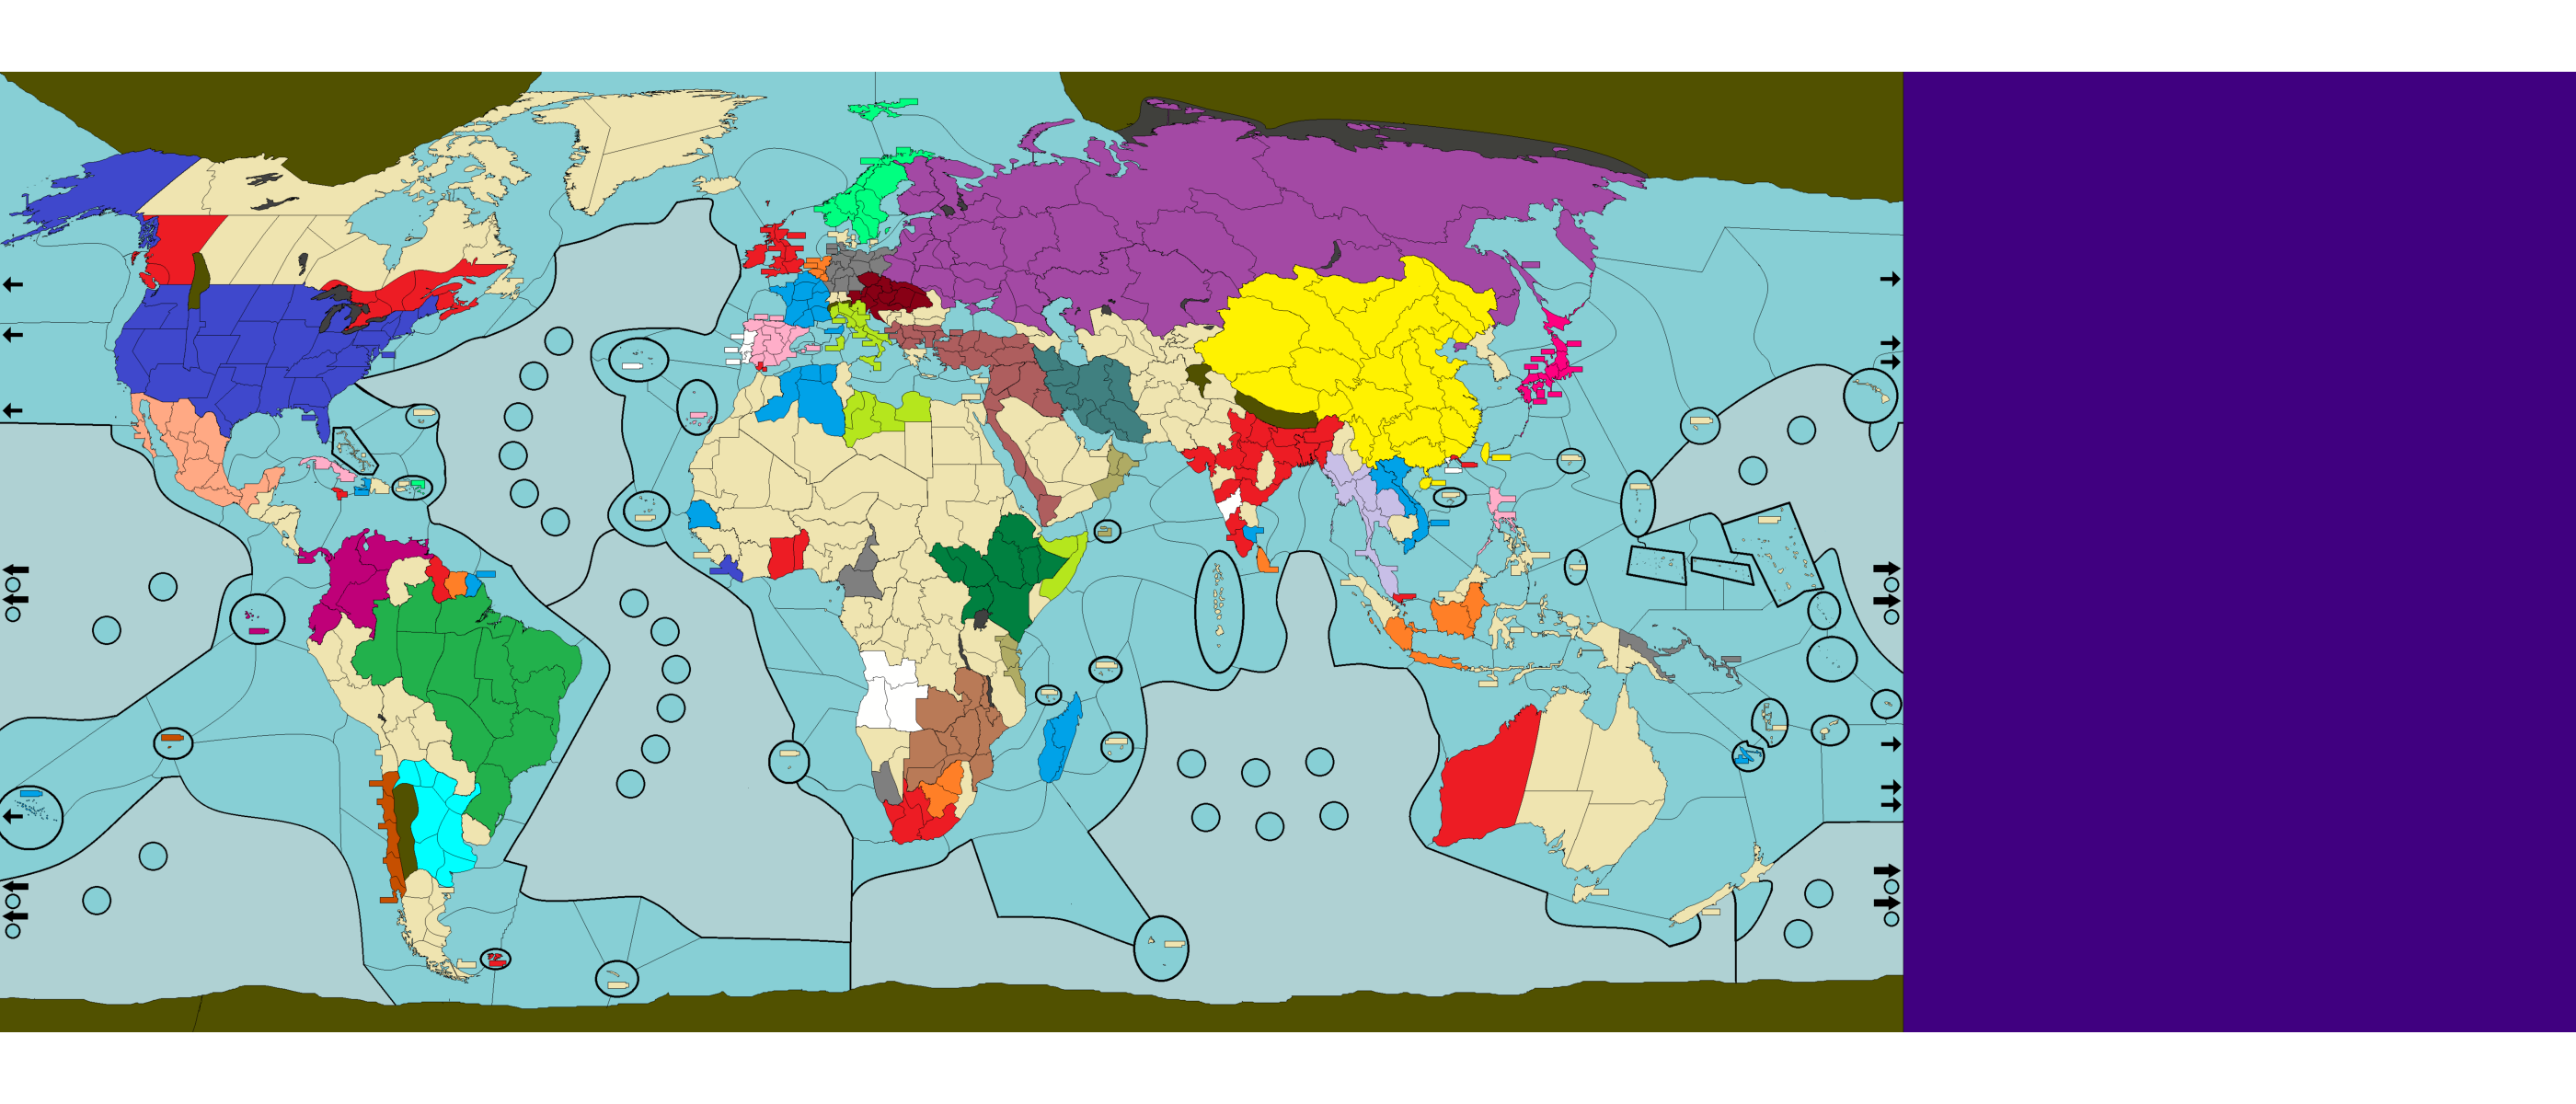

In [21]:
showx(rgb,cover=None)

In [22]:
color_based = {(135,207,213):{'type':'sea'}, (175,209,211):{'type':'sea', 'env':'ocean'}}

In [153]:
for node in nodes:
    c = list(colors[node['ID']].keys())[0]
    node.update(color_based.get(c, {}))
    if node['name'].endswith('-water'):
        node['env'] = 'island'
    if 'type' not in node:
        node['type'] = 'land'

In [154]:
nodeIDs = {node['ID']:node for node in nodes}
len(nodeIDs)

781

In [25]:
from sklearn.neighbors import NearestNeighbors
import networkx as nx

In [26]:
def coords_order(coords):

    clf = NearestNeighbors(n_neighbors=2).fit(coords)
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_matrix(G)

    orders = [np.array(list(nx.dfs_preorder_nodes(T, min(piece))), dtype='int')
              for piece in nx.connected_components(T)]
    return orders

In [27]:
idx = 467

<IPython.core.display.Javascript object>


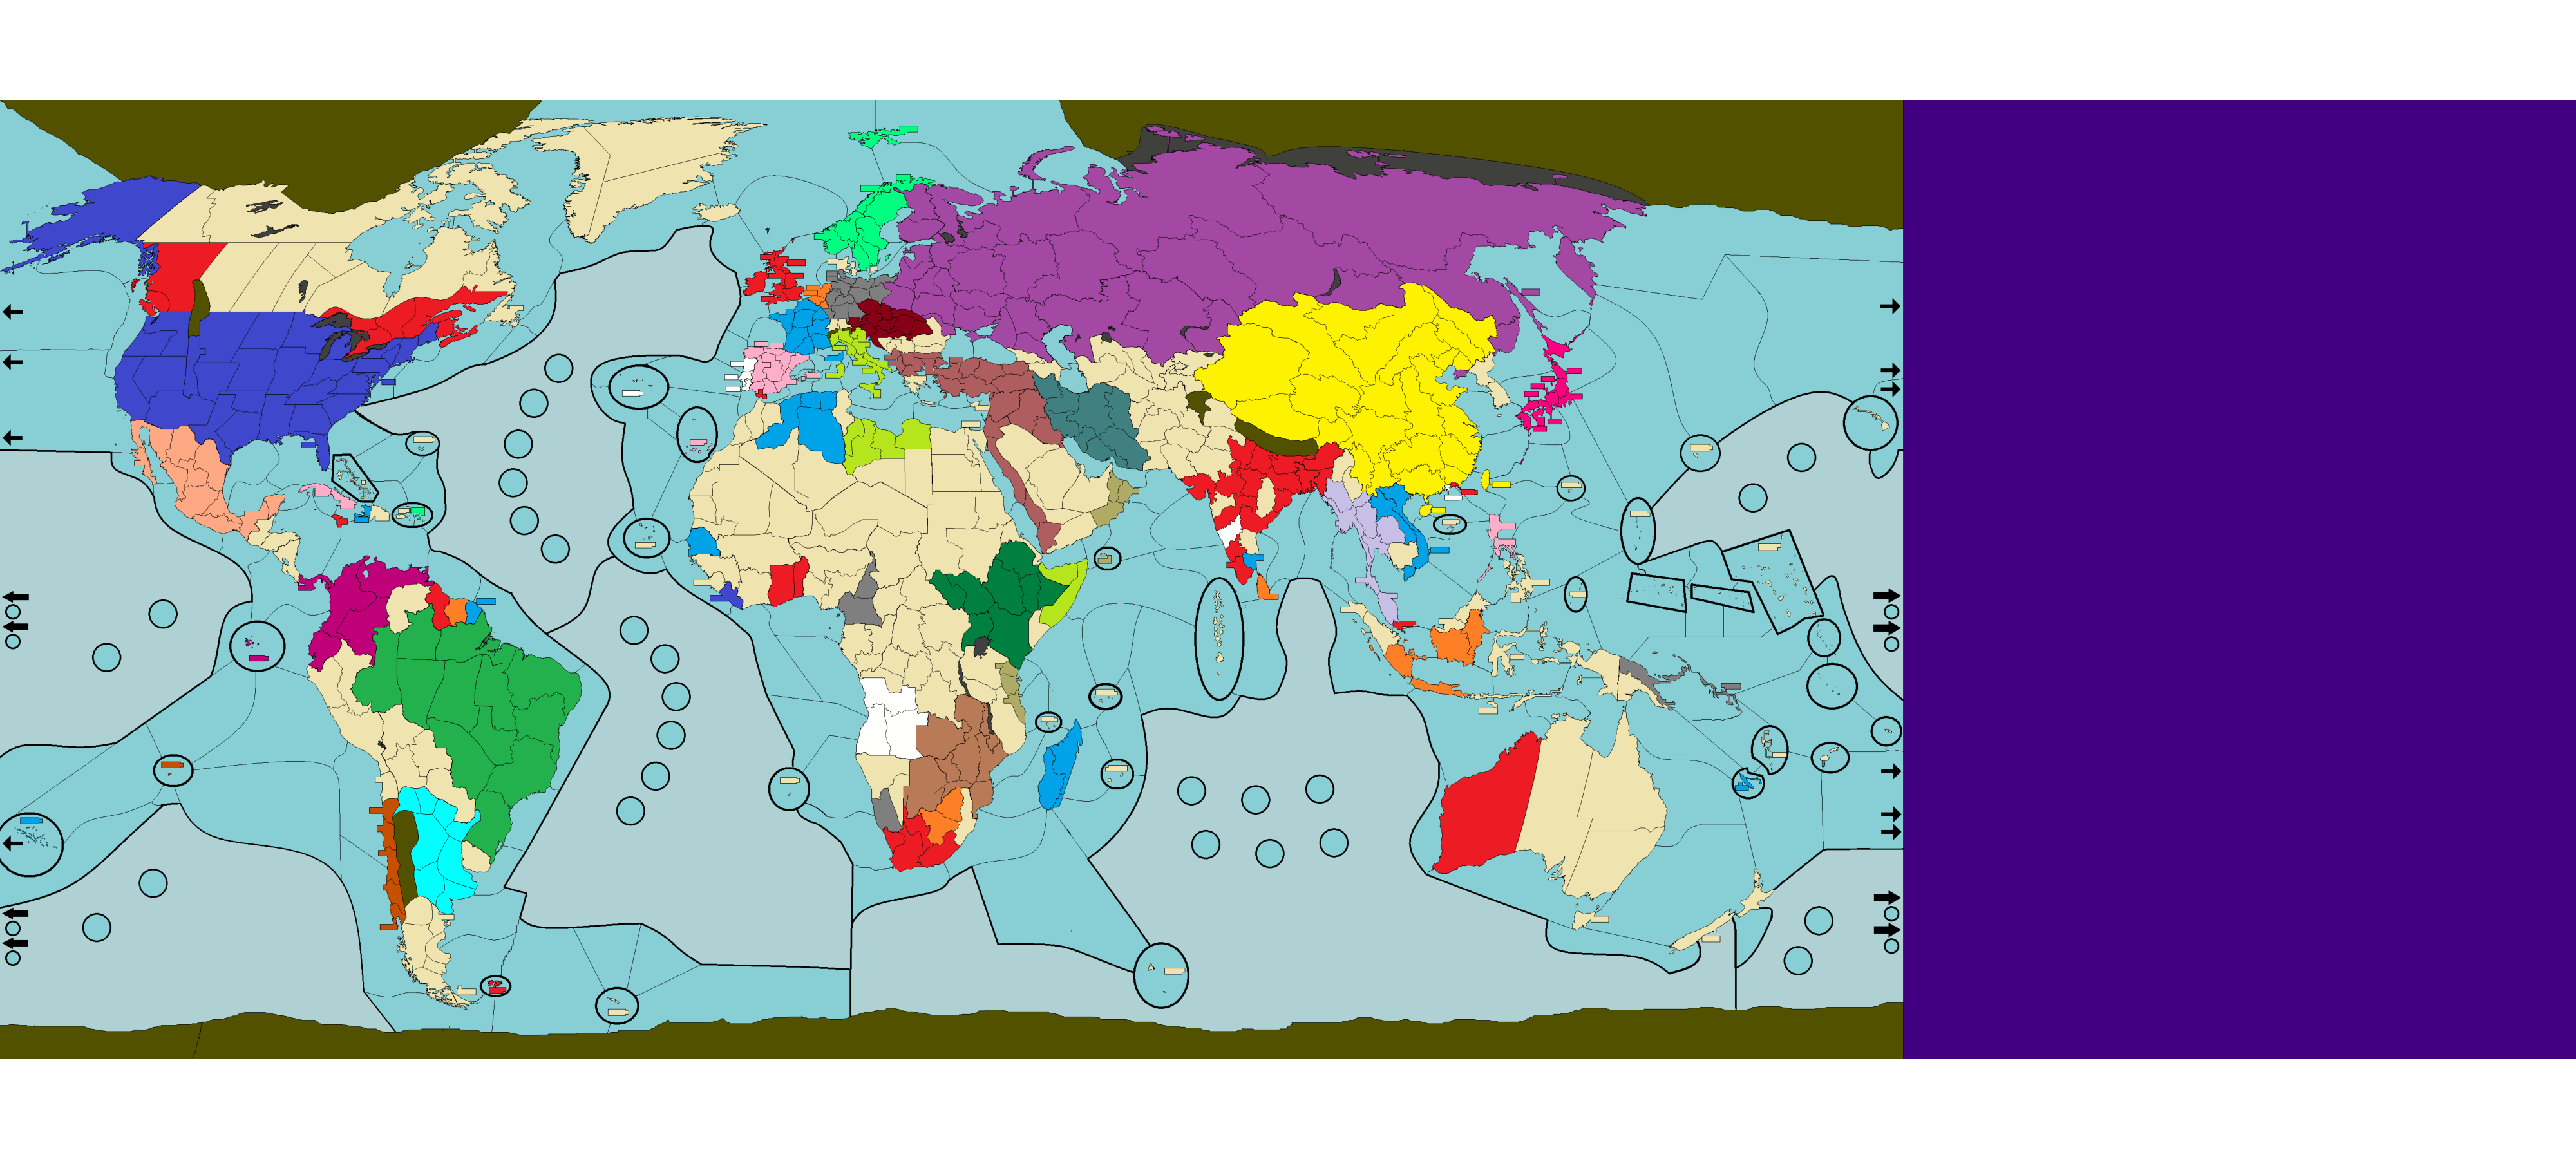

In [42]:
showx(rgb)
# highlight(rgb,expand_labels(lbls==idx,10))

In [28]:
regions = regionprops(lbls)
regions.insert(0,None)
len(regions)

787

In [29]:
tiles = regionprops(tileimg)
tiles.insert(0,None)
len(tiles)

1811

In [30]:
# plt.figure()
# plt.hist(areas, bins=100);

In [31]:
mxs = []
for node in nodes:
    mxs.append(max(tiles[t].area for t in node['tiles']))
sup = min(mxs)
sup

7

In [32]:
fixed = lbls.copy()
for i, tile in tqdm(enumerate(tiles[1:]), total=len(tiles)-1):
    i += 1
    if tile.area < sup:
        fixed[tileimg==i] = 0
fixed = expand_labels(fixed,100)
(fixed==0).sum()

  0%|          | 0/1810 [00:00<?, ?it/s]

0

In [33]:
# showx(fixed)

In [34]:
neighbors = {}

In [46]:
for idx, node in tqdm(nodeIDs.items()):
    if idx not in neighbors:
        reg = regionprops(find_boundaries(fixed == idx, mode='outer').astype(int))[0]
        ords = coords_order(reg.coords)
        nss = [set(fixed[tuple(reg.coords[o].T)]) for o in ords]

        ans = set()
        nts = []
        for i, ns in enumerate(nss):
            ns = {n for n in ns if n not in ans and n in nodeIDs}
            ans.update(ns)
            if len(ns):
                nts.append(ns)
        neighbors[idx] = nts

  0%|          | 0/781 [00:00<?, ?it/s]

In [35]:
# neighbors = {1: [{3, 4, 5}], 2: [{10, 4, 6}], 3: [{1, 4, 5, 784, 17, 18, 786}], 4: [{1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 784, 19, 23, 26, 29}], 5: [{1, 3, 4, 9, 14, 17}], 6: [{2, 4, 8, 10, 29}], 7: [{784, 80, 20}, {133, 12, 47, 783, 786, 62}], 8: [{99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31}, {784}], 9: [{4, 5, 11, 14, 15, 16}], 10: [{2, 4, 29, 6}], 11: [{16, 9, 26, 4}], 12: [{7, 72, 46, 47, 786, 18, 59}], 13: [{4, 36, 45, 19, 51, 26, 27, 28}], 14: [{5, 38, 9, 15, 17, 785, 24, 30}], 15: [{9, 14, 16, 24, 25}], 16: [{9, 11, 15, 22, 25, 26}], 17: [{32, 3, 5, 43, 14, 785, 18, 30}], 18: [{32, 3, 37, 12, 46, 17, 786, 88}], 19: [{29, 27, 4, 13}], 20: [{7, 42, 784, 80, 21, 55}], 21: [{784, 20, 23, 55}], 22: [{34, 39, 16, 25, 26}], 23: [{35, 4, 8, 784, 49, 52, 21, 55, 31}, {785}], 24: [{38, 39, 14, 15, 25, 58}], 25: [{39, 15, 16, 22, 24}], 26: [{34, 4, 11, 13, 16, 22, 28}], 27: [{97, 70, 13, 77, 45, 720, 19, 29}], 28: [{34, 36, 41, 44, 13, 26}], 29: [{4, 6, 8, 10, 720, 19, 27}], 30: [{38, 43, 14, 48, 17, 785}], 31: [{784, 23}, {8, 65, 40, 35}], 32: [{101, 106, 43, 17, 18, 88}], 33: [{58, 38, 71}], 34: [{39, 44, 22, 26, 28}], 35: [{65, 49, 23, 56, 31}], 36: [{64, 41, 76, 13, 50, 83, 51, 85, 54, 28}, {98, 95}], 37: [{46, 142, 18, 116, 88}], 38: [{33, 69, 71, 78, 14, 48, 785, 24, 58, 30}], 39: [{34, 44, 22, 24, 57, 58, 61, 25}], 40: [{65, 68, 102, 8, 94, 31}], 41: [{36, 44, 50, 53, 28, 61}], 42: [{80, 20, 110, 55}], 43: [{32, 101, 48, 17, 91, 30}], 44: [{34, 39, 41, 28, 61}], 45: [{13}, {27, 51, 70, 63}], 46: [{37, 72, 73, 12, 785, 18, 116}], 47: [{133, 7, 12, 215, 59}], 48: [{69, 38, 43, 91, 30}], 49: [{35, 52, 118, 23, 56, 127}], 50: [{36, 41, 54, 60, 61}], 51: [{36, 13}, {64, 45, 63}], 52: [{784, 49, 23, 55, 127}], 53: [{41, 61}], 54: [{67, 36, 74, 76, 50, 60}], 55: [{42, 110, 784, 113, 20, 21, 86, 52, 23}], 56: [{65, 35, 49, 118, 153}, {785}], 57: [{58, 61, 39}], 58: [{33, 66, 38, 39, 71, 75, 24, 57, 61}], 59: [{168, 72, 12, 47, 84, 215, 124}], 60: [{50, 67, 61, 54}], 61: [{67, 39, 41, 75, 44, 50, 53, 57, 58, 60}], 62: [{133, 7, 718, 783, 336, 307}], 63: [{64, 70, 45, 51, 89}], 64: [{36, 51, 83, 89, 63}], 65: [{35, 102, 40, 120, 153, 56, 31}], 66: [{71, 75, 79, 82, 58}], 67: [{74, 75, 54, 60, 61}], 68: [{40, 8, 115, 94}], 69: [{38, 78, 48, 90, 91}], 70: [{97, 77, 45, 89, 27, 63}], 71: [{33, 66, 38, 78, 82, 58}], 72: [{192, 130, 134, 135, 73, 12, 46, 84, 59}], 73: [{134, 72, 107, 46, 785, 116}], 74: [{67, 75, 76, 81, 54, 87, 92}], 75: [{66, 67, 74, 79, 81, 58, 61}], 76: [{96, 36, 74, 85, 54, 87}], 77: [{97, 27, 70}], 78: [{69, 38, 71, 82, 90}], 79: [{66, 103, 75, 81, 82, 93}], 80: [{7, 42, 110, 239, 20}], 81: [{74, 75, 108, 79, 92, 93}], 82: [{66, 103, 71, 105, 78, 79, 90}], 83: [{64, 98, 36, 85, 89}], 84: [{192, 59, 72, 124}], 85: [{96, 36, 76, 83, 95}], 86: [{113, 110, 55}], 87: [{96, 104, 74, 76, 92}], 88: [{32, 194, 37, 106, 142, 785, 18, 177, 214}], 89: [{64, 97, 98, 70, 83, 63}], 90: [{69, 137, 105, 109, 78, 82, 91}], 91: [{69, 101, 43, 109, 48, 147, 90}], 92: [{100, 104, 74, 108, 81, 87}], 93: [{103, 108, 79, 112, 81, 117}], 94: [{129, 68, 102, 40, 145, 115, 157}], 95: [{96, 98, 36, 111, 114, 85, 125}], 96: [{104, 76, 111, 85, 87, 95}], 97: [{128, 98, 70, 77, 720, 114, 149, 89, 27}], 98: [{97, 36, 114, 83, 89, 95}], 99: [{8, 143, 115, 184, 121}], 100: [{104, 108, 117, 122, 123, 92}], 101: [{32, 165, 106, 43, 147, 91, 159}], 102: [{65, 40, 144, 180, 120, 157, 94}], 103: [{131, 105, 79, 112, 82, 93}], 104: [{96, 100, 111, 87, 123, 92, 126}], 105: [{131, 103, 136, 137, 82, 150, 119, 90}], 106: [{32, 164, 101, 165, 177, 785, 88, 219}], 107: [{73, 116, 134}], 108: [{100, 81, 117, 92, 93}], 109: [{137, 147, 183, 90, 91, 158}], 110: [{42, 239, 80, 113, 273, 148, 86, 55}], 111: [{96, 104, 125, 126, 95}], 112: [{131, 132, 103, 141, 117, 93}], 113: [{197, 171, 110, 784, 148, 86, 55}], 114: [{128, 97, 98, 151, 125, 95}], 115: [{129, 99, 68, 8, 184, 94}], 116: [{37, 134, 73, 107, 46, 142, 247, 154, 254}], 117: [{100, 132, 140, 108, 112, 784, 122, 93}], 118: [{173, 49, 56, 153, 189, 127}], 119: [{136, 105, 131, 141}], 120: [{65, 102, 144, 785, 153}], 121: [{8, 99, 720, 143}], 122: [{100, 139, 784, 117, 123}], 123: [{100, 104, 139, 784, 122, 126}], 124: [{192, 163, 168, 84, 215, 59}], 125: [{111, 114, 151, 126, 95}], 126: [{104, 170, 111, 784, 146, 151, 123, 125}], 127: [{171, 784, 49, 210, 52, 118, 189}], 128: [{160, 97, 162, 114, 149, 151}], 129: [{145, 178, 115, 184, 94}], 130: [{134, 135, 72, 138, 208}], 131: [{103, 105, 141, 112, 119}], 132: [{140, 141, 112, 179, 117}], 133: [{7, 718, 47, 215, 760, 62}], 134: [{130, 72, 73, 138, 107, 116, 156, 254}], 135: [{72, 130, 192, 208}], 136: [{105, 169, 141, 150, 119}], 137: [{105, 109, 150, 90, 158}], 138: [{130, 195, 134, 208, 156, 191}], 139: [{161, 166, 140, 175, 784, 122, 123}], 140: [{161, 132, 139, 784, 179, 117}], 141: [{131, 132, 136, 169, 112, 179, 119, 152}], 142: [{194, 37, 785, 116, 88, 154}], 143: [{720, 121, 99, 184}], 144: [{102, 174, 785, 180, 120}], 145: [{129, 178, 157, 94}], 146: [{166, 170, 172, 205, 784, 126}], 147: [{101, 109, 183, 91, 190, 159}], 148: [{113, 197, 110, 273}], 149: [{128, 97, 160, 203, 720, 213}, {225}], 150: [{167, 136, 137, 169, 105, 158}], 151: [{128, 162, 170, 114, 186, 125, 126}], 152: [{169, 179, 155, 141}], 153: [{65, 173, 785, 118, 56, 120}], 154: [{194, 142, 784, 241, 116, 247, 280, 282}], 155: [{152, 169, 185, 179}], 156: [{134, 263, 138, 266, 254, 191}], 157: [{102, 176, 145, 178, 180, 184, 251, 94}], 158: [{193, 258, 167, 199, 137, 109, 182, 183, 150}], 159: [{101, 165, 209, 147, 190}], 160: [{128, 162, 203, 204, 149, 216}], 161: [{198, 200, 139, 140, 175, 179}], 162: [{128, 160, 151, 216, 186}], 163: [{192, 228, 261, 168, 215, 218, 124}], 164: [{234, 106, 785, 177, 219}], 165: [{101, 230, 106, 209, 219, 159}], 166: [{139, 172, 175, 784, 146}], 167: [{169, 150, 182, 158}], 168: [{59, 215}, {163, 124}, {192}], 169: [{167, 136, 141, 181, 182, 150, 152, 185, 155}], 170: [{205, 146, 151, 186, 187, 126}], 171: [{197, 268, 784, 113, 210, 127}], 172: [{224, 166, 235, 205, 175, 146, 188, 223}], 173: [{256, 265, 202, 269, 785, 118, 153, 189}], 174: [{144, 785, 202}], 175: [{224, 161, 166, 198, 139, 172}], 176: [{180, 251, 196, 157}], 177: [{164, 106, 234, 214, 88}], 178: [{184, 129, 145, 157}], 179: [{161, 132, 200, 201, 140, 141, 245, 152, 185, 155}], 180: [{196, 102, 176, 785, 144, 157}], 181: [{258, 169, 201, 207, 212, 182, 185}], 182: [{193, 167, 169, 207, 181, 158}], 183: [{199, 109, 190, 147, 211, 220, 158}], 184: [{129, 99, 143, 720, 178, 115, 251, 157}], 185: [{169, 201, 179, 181, 155}], 186: [{162, 232, 170, 151, 216, 187}], 187: [{232, 170, 205, 206, 186}], 188: [{235, 172, 205}], 189: [{256, 173, 210, 118, 127}], 190: [{209, 147, 211, 183, 159}], 191: [{195, 263, 138, 236, 156}], 192: [{163, 135, 168, 72, 267, 208, 243, 84, 218, 124}], 193: [{258, 199, 233, 207, 242, 182, 158}], 194: [{142, 241, 214, 88, 154}, {785}], 195: [{138, 236, 208, 221, 191}], 196: [{229, 231, 202, 176, 785, 180, 251}], 197: [{171, 268, 273, 113, 148}], 198: [{224, 161, 200, 175, 217}], 199: [{193, 233, 183, 220, 158}], 200: [{161, 198, 179, 245, 217}], 201: [{179, 212, 245, 181, 185}], 202: [{196, 229, 265, 173, 174, 785}], 203: [{160, 225, 204, 149, 213}], 204: [{160, 225, 203, 240, 246, 248, 216}], 205: [{772, 170, 235, 172, 206, 146, 187, 188}], 206: [{772, 232, 205, 237, 187}], 207: [{193, 258, 181, 182}], 208: [{192, 130, 195, 135, 138, 267, 236, 221}], 209: [{165, 230, 238, 275, 211, 253, 190, 159}], 210: [{256, 171, 268, 284, 189, 127}], 211: [{238, 209, 183, 220, 190}], 212: [{258, 227, 201, 245, 181}], 213: [{225, 226, 257, 203, 720, 753, 149, 246, 277}], 214: [{194, 262, 234, 177, 241, 88}], 215: [{163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124}], 216: [{160, 162, 232, 204, 248, 186}], 217: [{224, 198, 200, 245, 250}], 218: [{192, 163, 228, 243}], 219: [{289, 164, 165, 230, 234, 106}], 220: [{199, 233, 238, 211, 183}], 221: [{208, 195, 236}], 222: [{772}], 223: [{224, 235, 172}], 224: [{288, 198, 235, 172, 175, 245, 217, 250, 223}], 225: [{203, 204, 213, 246, 149}], 226: [{720, 753, 340, 213}], 227: [{258, 285, 212, 245}], 228: [{163, 261, 243, 244, 218}], 229: [{196, 231, 265, 202, 271, 251}], 230: [{289, 165, 209, 275, 219}], 231: [{251, 196, 229}], 232: [{259, 237, 206, 248, 186, 187, 216}], 233: [{193, 260, 199, 264, 238, 270, 242, 220}], 234: [{289, 290, 164, 262, 177, 214, 278, 219}], 235: [{224, 288, 772, 172, 237, 205, 272, 276, 188, 223}], 236: [{195, 263, 297, 267, 208, 221, 191}], 237: [{259, 772, 292, 232, 235, 206, 272, 317}], 238: [{264, 233, 209, 274, 211, 220, 253}], 239: [{718, 110, 80, 273, 337, 309, 344}], 240: [{204, 277, 246, 248, 249}], 241: [{194, 262, 784, 214, 154}], 242: [{193, 258, 233, 270}], 243: [{192, 228, 295, 297, 267, 244, 218, 255}], 244: [{420, 261, 228, 295, 302, 243}], 245: [{288, 224, 227, 200, 201, 179, 212, 217, 250, 285}], 246: [{225, 204, 240, 277, 213}], 247: [{300, 301, 116, 280, 154, 254}], 248: [{259, 232, 204, 240, 216, 249}], 249: [{240, 248, 259, 277}], 250: [{224, 217, 245}], 251: [{196, 229, 231, 271, 720, 176, 184, 157}], 252: [{753}], 253: [{209, 274, 275, 238}], 254: [{134, 266, 300, 116, 247, 156}], 255: [{293, 295, 297, 302, 243}], 256: [{291, 269, 173, 210, 284, 189}], 257: [{753, 755, 213, 277, 342, 312, 283, 351}], 258: [{193, 227, 270, 207, 242, 212, 181, 285, 158, 287}], 259: [{292, 232, 296, 237, 277, 248, 249}], 260: [{264, 233, 270, 310, 279, 287}], 261: [{163, 420, 228, 244, 215}], 262: [{294, 298, 234, 784, 241, 278, 214}], 263: [{297, 266, 236, 156, 286, 191}], 264: [{260, 233, 238, 274, 310}], 265: [{229, 202, 269, 173, 271, 281}], 266: [{324, 325, 263, 300, 156, 254, 286}], 267: [{192, 297, 236, 208, 243}], 268: [{197, 171, 273, 210, 309, 315, 284}], 269: [{256, 291, 265, 333, 173, 338, 281}], 270: [{258, 260, 233, 242, 279, 287}], 271: [{229, 265, 720, 305, 281, 251}], 272: [{235, 237, 276, 308, 317}], 273: [{197, 268, 110, 239, 148, 309}], 274: [{322, 264, 238, 304, 275, 310, 314, 253}], 275: [{289, 230, 304, 209, 274, 253}], 276: [{288, 272, 235, 308}], 277: [{257, 259, 296, 240, 213, 246, 312, 249}], 278: [{234, 298, 290, 262}], 279: [{260, 270, 287}], 280: [{154, 301, 784, 247, 282}], 281: [{323, 265, 269, 333, 271, 305}], 282: [{294, 784, 280, 154, 319}], 283: [{753, 755, 340, 257}], 284: [{256, 291, 331, 268, 210, 338, 315}], 285: [{288, 321, 258, 227, 332, 334, 306, 245, 287}], 286: [{325, 263, 297, 266, 341}], 287: [{321, 258, 260, 326, 299, 270, 310, 279, 285}], 288: [{224, 235, 306, 308, 245, 276, 285}], 289: [{290, 230, 329, 234, 304, 275, 313, 219, 316}], 290: [{289, 234, 298, 278, 316}], 291: [{256, 338, 284, 269}], 292: [{296, 237, 259, 317}], 293: [{295, 302, 255}], 294: [{262, 298, 784, 311, 282, 319}], 295: [{293, 302, 243, 244, 255}], 296: [{353, 259, 292, 277, 312, 317}], 297: [{263, 267, 236, 302, 303, 243, 341, 286, 255}], 298: [{290, 294, 262, 278, 311, 345, 316}], 299: [{326, 423, 383, 372, 310, 350, 287}], 300: [{324, 266, 301, 369, 254, 247, 346, 347, 343}], 301: [{300, 784, 247, 280, 346}], 302: [{420, 293, 295, 359, 297, 303, 244, 341, 255}], 303: [{297, 341, 302}, {359}], 304: [{289, 274, 275, 313, 314, 349}], 305: [{352, 323, 717, 333, 271, 720, 281}], 306: [{288, 308, 285, 334}], 307: [{336, 62, 718}, {773}], 308: [{288, 353, 334, 272, 306, 276, 375, 317}], 309: [{354, 356, 268, 239, 273, 344, 315}], 310: [{322, 260, 383, 264, 299, 274, 287}], 311: [{294, 330, 298, 339, 345, 319}], 312: [{353, 257, 296, 277, 342}], 313: [{304, 329, 349, 289}], 314: [{322, 363, 304, 274, 349}], 315: [{354, 331, 268, 370, 309, 284}], 316: [{289, 290, 357, 329, 298, 345}], 317: [{353, 292, 296, 237, 272, 308}], 318: [{765}], 319: [{294, 328, 784, 339, 311, 282}], 320: [{755}], 321: [{326, 332, 285, 381, 287}], 322: [{422, 363, 274, 310, 314, 383}], 323: [{281, 333, 305}], 324: [{355, 325, 266, 300, 365, 369}], 325: [{355, 324, 266, 395, 341, 286}], 326: [{321, 299, 381, 350, 287}], 327: [{760}], 328: [{361, 335, 784, 339, 371, 319}], 329: [{289, 357, 313, 316, 349}], 330: [{366, 368, 339, 311, 345}], 331: [{387, 338, 370, 409, 315, 284}], 332: [{321, 362, 334, 285, 381}], 333: [{352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382}], 334: [{362, 332, 306, 308, 375, 285}], 335: [{328, 361, 364, 784, 348}], 336: [{62, 307, 718, 783}], 337: [{344, 444, 718, 239}], 338: [{291, 331, 269, 333, 409, 284, 382}], 339: [{328, 330, 366, 371, 311, 319}], 340: [{226, 720, 753, 755, 756, 473, 283, 351}], 341: [{325, 359, 297, 395, 302, 303, 377, 286}], 342: [{384, 353, 257, 389, 312, 351}], 343: [{360, 300, 374, 346, 347, 380}], 344: [{356, 239, 337, 309, 444}], 345: [{357, 298, 330, 368, 311, 316}], 346: [{358, 360, 300, 301, 784, 343, 348}], 347: [{300, 369, 374, 343, 380}], 348: [{358, 364, 335, 784, 346}], 349: [{357, 329, 394, 363, 367, 304, 313, 314}], 350: [{326, 423, 299, 406, 381}], 351: [{384, 257, 417, 481, 755, 756, 340, 342, 440, 445}], 352: [{717, 333, 305, 379, 413}, {774}], 353: [{389, 296, 404, 308, 342, 375, 312, 317}], 354: [{387, 356, 370, 309, 315, 444}], 355: [{388, 325, 324, 395, 396, 365}], 356: [{344, 354, 444, 309}], 357: [{385, 329, 367, 368, 373, 345, 316, 349}], 358: [{480, 360, 364, 346, 348, 479}], 359: [{386, 420, 302, 303, 341, 377, 767}], 360: [{480, 358, 433, 343, 346, 380}], 361: [{390, 328, 364, 335, 399, 371}], 362: [{332, 334, 401, 375, 381}], 363: [{322, 422, 394, 314, 349}], 364: [{390, 358, 393, 361, 335, 348, 479}], 365: [{355, 324, 392, 396, 369, 407, 408}], 366: [{330, 368, 400, 339, 371, 437}], 367: [{373, 349, 357, 394}], 368: [{385, 449, 357, 330, 366, 437, 345}], 369: [{324, 392, 300, 365, 402, 347, 380}], 370: [{315, 354, 331, 387}], 371: [{328, 361, 366, 399, 400, 339}], 372: [{299, 436, 383, 423}], 373: [{385, 357, 421, 394, 367}], 374: [{347, 380, 343}], 375: [{353, 362, 334, 401, 308, 404}], 376: [{780, 717, 720, 439, 379, 765}], 377: [{386, 395, 341, 359}], 378: [{767}], 379: [{352, 426, 780, 717, 781, 439, 376, 413}], 380: [{360, 369, 402, 433, 374, 343, 347, 415}], 381: [{321, 326, 362, 332, 401, 406, 350}], 382: [{416, 333, 398, 397, 338, 409}], 383: [{322, 422, 424, 299, 436, 372, 310}], 384: [{417, 389, 342, 351}], 385: [{449, 357, 421, 368, 373}], 386: [{452, 359, 395, 466, 435, 377, 767}], 387: [{354, 331, 428, 370, 409, 444}], 388: [{408, 355, 396, 395}], 389: [{384, 417, 353, 454, 404, 342, 440}], 390: [{393, 425, 361, 364, 399}], 391: [{419, 333, 397, 403, 405}], 392: [{460, 365, 432, 369, 402, 407}], 393: [{425, 364, 390, 479}], 394: [{421, 422, 363, 430, 367, 373, 349}], 395: [{386, 355, 388, 325, 435, 341, 408, 377}], 396: [{408, 355, 388, 365}], 397: [{419, 391, 333, 398, 382}], 398: [{448, 416, 419, 397, 382}], 399: [{390, 425, 361, 400, 371, 414}], 400: [{366, 399, 371, 437, 414}], 401: [{450, 455, 362, 404, 406, 375, 381}], 402: [{392, 459, 460, 369, 434, 380, 415}], 403: [{419, 391, 429, 405, 413}], 404: [{353, 450, 389, 454, 401, 375}], 405: [{403, 333, 413, 391}], 406: [{455, 423, 493, 495, 401, 468, 505, 381, 350}], 407: [{392, 365, 432, 408, 411}], 408: [{768, 388, 395, 396, 365, 432, 435, 407, 472, 411}], 409: [{416, 387, 331, 428, 338, 382}], 410: [{780}], 411: [{408, 432, 407}], 412: [{781}], 413: [{352, 426, 427, 333, 429, 403, 405, 439, 379}], 414: [{425, 399, 400, 437, 441}], 415: [{451, 433, 434, 402, 380}], 416: [{448, 428, 462, 398, 409, 382}], 417: [{384, 389, 440, 351}], 418: [{754}], 419: [{448, 391, 397, 429, 398, 497, 403, 467, 439, 446}], 420: [{261, 359, 302, 466, 754, 244, 215, 767}], 421: [{449, 385, 394, 430, 373, 442}], 422: [{322, 424, 394, 363, 430, 438, 383}], 423: [{299, 372, 468, 436, 406, 443, 350}], 424: [{436, 422, 438, 383}], 425: [{390, 456, 393, 479, 399, 441, 414, 447}], 426: [{379, 427, 413, 439}], 427: [{426, 413, 439}], 428: [{416, 387, 462, 409, 444}], 429: [{419, 403, 413, 439}], 430: [{421, 422, 394, 470, 438, 442}], 431: [{768}], 432: [{768, 472, 392, 460, 407, 408, 411}], 433: [{480, 451, 360, 489, 457, 380, 415}], 434: [{402, 459, 451, 415}], 435: [{386, 452, 472, 395, 408}], 436: [{423, 424, 372, 438, 470, 443, 383}], 437: [{449, 366, 463, 400, 368, 441, 414}], 438: [{422, 424, 430, 436, 470}], 439: [{513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413}], 440: [{417, 389, 454, 445, 351}], 441: [{425, 463, 464, 437, 414, 447}], 442: [{449, 769, 421, 518, 487, 430, 470}], 443: [{484, 423, 461, 436, 468, 470}], 444: [{354, 387, 356, 428, 462, 718, 337, 344}], 445: [{481, 454, 440, 474, 351}], 446: [{448, 419, 486, 462, 467}], 447: [{456, 425, 464, 469, 441}], 448: [{416, 419, 398, 462, 446}], 449: [{385, 769, 421, 487, 463, 368, 437, 442}], 450: [{454, 455, 401, 404, 475}], 451: [{489, 459, 433, 434, 503, 415}], 452: [{386, 465, 466, 435, 499, 472}], 453: [{756}], 454: [{450, 483, 389, 494, 404, 440, 474, 475, 445, 478}], 455: [{450, 495, 401, 501, 406, 475, 508}], 456: [{425, 479, 463, 469, 510, 447}], 457: [{480, 509, 517, 489, 433, 532, 541, 543}], 458: [{749}], 459: [{451, 460, 434, 402, 503}], 460: [{392, 459, 432, 402, 503, 472}], 461: [{514, 484, 491, 498, 468, 443}], 462: [{416, 448, 486, 428, 718, 444, 446}], 463: [{449, 487, 456, 583, 556, 464, 437, 469, 441, 476, 510}], 464: [{463, 469, 441, 476, 447}], 465: [{452, 492, 466, 499, 507}], 466: [{386, 420, 452, 492, 465, 529, 754, 763, 540, 767}], 467: [{497, 419, 446, 486}], 468: [{514, 423, 461, 493, 406, 443}], 469: [{456, 463, 464, 476, 447}], 470: [{484, 518, 430, 436, 438, 442, 443}], 471: [{769}], 472: [{768, 452, 516, 460, 432, 435, 499, 503, 408}], 473: [{481, 720, 721, 756, 340}], 474: [{512, 481, 454, 490, 494, 445}], 475: [{450, 454, 455, 488, 500, 501, 478}], 476: [{464, 469, 463}], 477: [{515, 520, 524, 527, 720, 496, 439}], 478: [{483, 454, 531, 500, 475}], 479: [{480, 358, 456, 425, 393, 556, 364, 722, 510}], 480: [{576, 517, 358, 360, 457, 489, 433, 722, 479}], 481: [{512, 490, 721, 756, 473, 474, 539, 445, 351}], 482: [{485, 718, 529, 754, 537, 511}], 483: [{531, 454, 478, 494}], 484: [{518, 461, 498, 470, 443}], 485: [{482, 536, 749, 718, 504, 537}], 486: [{513, 548, 519, 462, 718, 752, 497, 467, 446}], 487: [{449, 769, 518, 583, 522, 463, 538, 569, 442}], 488: [{525, 531, 500, 501, 475}], 489: [{480, 457}, {433, 451, 509, 503}], 490: [{512, 481, 474}], 491: [{514, 461, 528, 498, 534}], 492: [{465, 466, 533, 507, 540}], 493: [{514, 521, 526, 528, 468, 406, 505}], 494: [{512, 483, 454, 531, 474, 539}], 495: [{547, 455, 521, 406, 505, 508}], 496: [{513, 523, 527, 502, 439, 477}], 497: [{513, 419, 486, 467, 439}], 498: [{484, 518, 491, 461, 534}], 499: [{452, 516, 465, 533, 472, 507}], 500: [{488, 531, 478, 475}], 501: [{455, 488, 525, 475, 508}], 502: [{581, 552, 523, 527, 496}], 503: [{546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543}], 504: [{536, 537, 485}, {779}], 505: [{521, 493, 406, 495}], 506: [{529, 763}], 507: [{465, 499, 492, 533}], 508: [{547, 455, 525, 495, 501, 542}], 509: [{489, 532, 457, 503}], 510: [{456, 463, 556, 479}], 511: [{529, 482, 537}, {778}], 512: [{481, 490, 494, 474, 539}], 513: [{548, 549, 486, 523, 560, 497, 496, 439}], 514: [{491, 461, 493, 528, 468}], 515: [{520, 554, 524, 477}], 516: [{503, 530, 499, 533, 535, 472}], 517: [{480, 457, 576, 541}], 518: [{484, 487, 498, 470, 534, 569, 442}], 519: [{752, 486, 718, 599}], 520: [{515, 554, 720, 721, 602, 477, 575}], 521: [{547, 493, 526, 495, 564, 566, 505}], 522: [{487, 569, 538, 605, 766}], 523: [{513, 581, 496, 560, 502}], 524: [{554, 515, 477, 527}], 525: [{545, 488, 531, 501, 508, 542}], 526: [{521, 493, 528, 785, 566}], 527: [{552, 554, 524, 496, 502, 477}], 528: [{514, 491, 493, 526, 785, 534, 566, 568, 569, 572}], 529: [{482, 551, 511, 466, 563, 754, 537, 506, 571, 540, 763}], 530: [{546, 503, 516, 535}], 531: [{545, 483, 488, 525, 494, 500, 567, 539, 478}], 532: [{457, 503, 509, 543}], 533: [{516, 553, 492, 558, 499, 535, 507, 540}], 534: [{518, 491, 528, 498, 569}], 535: [{546, 516, 553, 530, 533}], 536: [{485, 551, 749, 504, 537}], 537: [{482, 485, 551, 504, 529, 536, 511}], 538: [{487, 583, 522, 556, 722, 605}], 539: [{512, 481, 494, 721, 531, 597, 567}], 540: [{550, 492, 558, 529, 466, 563, 533, 763}], 541: [{576, 517, 457, 555, 543}], 542: [{545, 547, 525, 557, 562, 508}], 543: [{546, 457, 555, 532, 503, 570, 541}], 544: [{600, 551, 559}], 545: [{525, 562, 531, 567, 542}], 546: [{503, 553, 530, 535, 570, 543}], 547: [{521, 557, 495, 564, 565, 508, 542}], 548: [{513, 579, 549, 486, 617, 752}], 549: [{560, 513, 579, 548}], 550: [{563, 540, 573, 558}], 551: [{544, 585, 600, 749, 559, 529, 596, 536, 537, 571}], 552: [{581, 554, 527, 502, 574}], 553: [{546, 558, 533, 535, 570}], 554: [{577, 515, 520, 552, 524, 527, 603, 574, 575}], 555: [{543}, {576, 570, 541}], 556: [{583, 463, 722, 538, 510, 479}], 557: [{578, 547, 562, 565, 542}], 558: [{550, 553, 533, 570, 540, 573}], 559: [{544, 580, 613, 551, 650, 749, 718, 783, 600}], 560: [{513, 579, 549, 581, 523, 607}], 561: [{752}], 562: [{545, 578, 557, 567, 542}], 563: [{610, 550, 584, 529, 571, 540, 573}], 564: [{547, 521, 586, 785, 595, 565, 566}], 565: [{578, 547, 586, 557, 591, 564}], 566: [{608, 582, 521, 589, 526, 528, 785, 564, 568}], 567: [{545, 578, 618, 591, 562, 531, 597, 539}], 568: [{528, 566, 572, 582}], 569: [{771, 646, 518, 487, 522, 620, 653, 588, 528, 534, 572, 605, 766}], 570: [{576, 546, 553, 587, 555, 558, 594, 598, 573, 543}], 571: [{551}, {584, 619, 529, 563, 596}], 572: [{582, 588, 528, 593, 568, 569}], 573: [{610, 550, 558, 563, 598, 570}], 574: [{577, 581, 552, 616, 554, 628, 606}], 575: [{520, 554, 601, 602, 603}], 576: [{480, 517, 587, 555, 594, 722, 570, 541}], 577: [{612, 616, 554, 603, 574}], 578: [{557, 591, 562, 565, 567}], 579: [{548, 549, 617, 560, 607}], 580: [{600, 559}], 581: [{552, 574, 523, 560, 502, 606, 607}], 582: [{608, 593, 566, 568, 572}], 583: [{538, 463, 556, 487}, {775}], 584: [{563, 610, 619, 571}], 585: [{600, 611, 596, 551}], 586: [{609, 614, 591, 595, 564, 565}], 587: [{576, 570, 594}], 588: [{608, 771, 593, 569, 636, 572}], 589: [{608, 615, 785, 595, 566}], 590: [{766}], 591: [{609, 578, 586, 618, 565, 567}], 592: [{598, 610, 594, 622}], 593: [{608, 572, 582, 588}], 594: [{576, 674, 587, 622, 592, 722, 598, 662, 570}], 595: [{614, 615, 586, 589, 623, 785, 627, 564}], 596: [{611, 551, 585, 619, 571}], 597: [{618, 721, 757, 567, 634, 539}], 598: [{610, 592, 594, 570, 573}], 599: [{519, 617, 654, 718, 752, 761}], 600: [{544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758}], 601: [{612, 626, 602, 603, 575}], 602: [{520, 721, 658, 626, 601, 575}], 603: [{577, 612, 554, 601, 575}], 604: [{771}], 605: [{762, 646, 522, 722, 659, 569, 538, 766}], 606: [{581, 785, 628, 630, 574, 607}], 607: [{579, 581, 647, 617, 560, 785, 630, 606, 639}], 608: [{582, 615, 588, 589, 593, 785, 627, 566, 636}], 609: [{614, 618, 586, 591, 631, 638}], 610: [{637, 584, 619, 622, 592, 563, 598, 573}], 611: [{677, 585, 619, 596, 758, 600, 764}], 612: [{577, 616, 626, 601, 603}], 613: [{600, 559}, {777}], 614: [{609, 586, 623, 595, 632, 638}], 615: [{608, 589, 785, 595, 627}], 616: [{577, 642, 612, 655, 626, 628, 574}], 617: [{579, 548, 647, 752, 599, 761, 668, 607}], 618: [{609, 567, 591, 597, 631, 634}], 619: [{610, 611, 584, 596, 571, 635, 764, 637}], 620: [{646, 648, 653, 659, 692, 569}], 621: [{718, 654, 750}], 622: [{673, 610, 592, 594, 662, 637}], 623: [{643, 644, 614, 627, 595, 632}], 624: [{677, 758}], 625: [{600, 650, 677}, {776}], 626: [{612, 616, 655, 658, 601, 602}], 627: [{608, 644, 615, 623, 595, 636}], 628: [{642, 616, 574, 630, 606}], 629: [{761}], 630: [{642, 639, 656, 657, 628, 606, 607}], 631: [{640, 609, 618, 664, 634, 638}], 632: [{614, 643, 638, 623}], 633: [{762}], 634: [{618, 757, 597, 631, 664, 669}], 635: [{645, 677, 680, 619, 684, 764, 637}], 636: [{608, 771, 644, 588, 653, 627}], 637: [{673, 610, 680, 619, 622, 635}], 638: [{640, 609, 643, 614, 651, 631, 632, 666}], 639: [{647, 657, 661, 630, 607}], 640: [{682, 631, 664, 666, 638}], 641: [{757}], 642: [{616, 655, 656, 660, 628, 630, 671}], 643: [{644, 651, 652, 623, 632, 667, 638}], 644: [{643, 678, 653, 623, 627, 667, 636}], 645: [{635, 764}], 646: [{620, 659, 569, 762, 605}], 647: [{672, 679, 617, 639, 661, 699, 668, 607}], 648: [{620, 692, 653, 678}], 649: [{654, 719, 761, 668, 670}], 650: [{677, 559, 783, 625, 719, 600}], 651: [{643, 652, 663, 666, 638}], 652: [{643, 667, 651, 663}], 653: [{771, 644, 678, 648, 620, 569, 636}], 654: [{649, 621, 718, 750, 599, 761, 670}], 655: [{642, 616, 685, 686, 626, 658, 671}], 656: [{642, 676, 657, 660, 630}], 657: [{676, 656, 784, 661, 630, 639}], 658: [{686, 655, 721, 626, 602}], 659: [{646, 620, 722, 692, 762, 605}], 660: [{656, 642, 676, 671}], 661: [{672, 647, 784, 657, 639}], 662: [{673, 674, 622, 688, 594}], 663: [{681, 651, 652, 666, 667}], 664: [{640, 675, 682, 631, 634, 669}], 665: [{750}], 666: [{640, 681, 682, 651, 663, 638}], 667: [{643, 644, 678, 681, 652, 663}], 668: [{647, 649, 617, 719, 761, 699}], 669: [{675, 682, 721, 691, 757, 664, 634}], 670: [{649, 654, 750, 719}], 671: [{642, 676, 683, 685, 655, 660}], 672: [{784, 679, 661, 647}], 673: [{680, 622, 688, 662, 637}], 674: [{688, 722, 594, 662}], 675: [{664, 682, 669}], 676: [{683, 687, 656, 657, 784, 660, 671}], 677: [{611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764}], 678: [{644, 648, 681, 653, 722, 691, 692, 667}], 679: [{672, 647, 784, 689, 699}], 680: [{673, 684, 688, 635, 637}], 681: [{678, 682, 691, 663, 666, 667}], 682: [{640, 675, 681, 691, 664, 666, 669}], 683: [{676, 685, 686, 687, 690, 671}], 684: [{704, 677, 680, 688, 695, 697, 698, 635, 703}], 685: [{655, 683, 686, 671}], 686: [{683, 685, 655, 721, 690, 658, 694}], 687: [{676, 683, 784, 690, 693, 696}], 688: [{704, 673, 674, 680, 684, 722, 662, 697}], 689: [{679, 784, 693, 699, 700}], 690: [{683, 686, 687, 694, 696}], 691: [{678, 681, 682, 721, 722, 669}], 692: [{678, 648, 620, 751, 722, 659}], 693: [{687, 784, 689, 696, 700, 701}], 694: [{705, 706, 708, 686, 721, 690, 696}], 695: [{698, 684, 677, 719}], 696: [{708, 687, 690, 693, 694, 701}], 697: [{688}, {704, 684}], 698: [{684, 719, 722, 695, 703}], 699: [{700, 647, 711, 679, 715, 719, 689, 668, 701}], 700: [{689, 699, 693, 701}], 701: [{708, 709, 711, 693, 696, 699, 700}], 702: [{721, 706, 707, 759}], 703: [{704, 698, 722, 684}], 704: [{684, 688, 722, 697, 703}], 705: [{706, 770, 708, 709, 711, 714, 715, 694}], 706: [{705, 770, 712, 715, 784, 721, 694, 759, 702}], 707: [{712, 721, 702, 759}], 708: [{705, 709, 694, 696, 701}], 709: [{705, 708, 701, 711}], 710: [{751}], 711: [{705, 709, 714, 715, 699, 701}], 712: [{706, 707, 784, 721, 722, 759}], 713: [{770}], 714: [{705, 715, 711}], 715: [{711}, {705, 770, 706, 714, 719, 784, 699}], 716: [{759}], 717: [{352, 720, 305, 376, 379, 765}], 718: [{482, 485, 133, 749, 559, 336, 783, 754, 307, 215, 760, 62}, {726}, {486, 519, 621, 462, 239, 654, 337, 599, 444}, {728}, {731}, {733}], 719: [{649, 715, 784, 699, 668, 670}, {677, 650, 783, 722, 695, 698}, {745}, {746}, {747}, {748}], 720: [{520, 8, 143, 271, 149, 27, 29, 305, 439, 184, 717, 721, 340, 213, 473, 477, 97, 226, 376, 121, 251, 765}, {723}, {724}, {725}, {727}, {729}, {730}], 721: [{481, 706, 707, 712, 520, 686, 720, 722, 691, 658, 597, 757, 694, 473, 602, 539, 669, 702}, {732}, {734}, {735}, {736}, {737}, {741}], 722: [{784, 659, 538, 674, 678, 556, 688, 691, 692, 698, 703, 576, 704, 712, 719, 721, 594, 605, 479, 480, 751}, {738}, {739}, {740}, {742}, {743}, {744}], 723: [{720}], 724: [{720}], 725: [{720}], 726: [{718}], 727: [{720}], 728: [{718}], 729: [{720}], 730: [{720}], 731: [{718}], 732: [{721}], 733: [{718}], 734: [{721}], 735: [{721}], 736: [{721}], 737: [{721}], 738: [{722}], 739: [{722}], 740: [{722}], 741: [{721}], 742: [{722}], 743: [{722}], 744: [{722}], 745: [{719}], 746: [{719}], 747: [{719}], 748: [{719}], 749: [{485, 551, 718, 559, 536}, {458}], 750: [{654, 621, 670}, {665}], 751: [{722, 692}, {710}], 752: [{548, 486, 519, 617, 599}, {561}], 753: [{257, 226, 340, 213, 283}, {252}], 754: [{482, 420, 718, 529, 466, 215}, {418}], 755: [{257, 283, 340, 351}, {320}], 756: [{481, 340, 473, 351}, {453}], 757: [{721, 634, 597, 669}, {641}], 758: [{600, 611, 624, 677}], 759: [{712, 706, 707, 702}, {716}], 760: [{133, 718, 215}, {327}], 761: [{617, 649, 654, 599, 668}, {629}], 762: [{659, 605, 646}, {633}], 763: [{529, 466, 506, 540}], 764: [{611, 677, 645, 619, 635}], 765: [{720, 376, 717}, {318}], 766: [{569, 522, 605}, {590}], 767: [{466, 420, 359, 386}, {378}], 768: [{408, 432, 472}, {431}], 769: [{449, 442, 487}, {471}], 770: [{705, 706, 715}, {713}], 771: [{569, 636, 653, 588}, {604}], 772: [{205, 235, 237, 206}, {222}], 773: [{307}], 774: [{352}], 775: [{583}], 776: [{625}], 777: [{613}], 778: [{511}], 779: [{504}], 780: [{376, 379, 781, 439}, {410}], 781: [{379, 780, 439}, {412}]}
neighbors = {1: [{3, 4, 5}], 2: [{10, 4, 6}], 3: [{1, 4, 5, 17, 18}], 4: [{1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 19, 23, 26, 29}], 5: [{1, 3, 4, 9, 14, 17}], 6: [{2, 4, 8, 10, 29}], 7: [{80, 20}, {12, 133, 62, 47}], 8: [{99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31}], 9: [{4, 5, 11, 14, 15, 16}], 10: [{2, 4, 29, 6}], 11: [{16, 9, 26, 4}], 12: [{7, 72, 46, 47, 18, 59}], 13: [{4, 36, 45, 19, 51, 26, 27, 28}], 14: [{5, 38, 9, 15, 17, 24, 30}], 15: [{9, 14, 16, 24, 25}], 16: [{9, 11, 15, 22, 25, 26}], 17: [{32, 3, 5, 43, 14, 18, 30}], 18: [{32, 3, 37, 12, 46, 17, 88}], 19: [{29, 27, 4, 13}], 20: [{7, 42, 80, 21, 55}], 21: [{20, 23, 55}], 22: [{34, 39, 16, 25, 26}], 23: [{35, 4, 8, 49, 52, 21, 55, 31}], 24: [{38, 39, 14, 15, 25, 58}], 25: [{39, 15, 16, 22, 24}], 26: [{34, 4, 11, 13, 16, 22, 28}], 27: [{97, 70, 13, 77, 45, 720, 19, 29}], 28: [{34, 36, 41, 44, 13, 26}], 29: [{4, 6, 8, 10, 720, 19, 27}], 30: [{38, 43, 14, 48, 17}], 31: [{23}, {8, 65, 40, 35}], 32: [{101, 106, 43, 17, 18, 88}], 33: [{58, 38, 71}], 34: [{39, 44, 22, 26, 28}], 35: [{65, 49, 23, 56, 31}], 36: [{64, 41, 76, 13, 50, 83, 51, 85, 54, 28}, {98, 95}], 37: [{46, 142, 18, 116, 88}], 38: [{33, 69, 71, 78, 14, 48, 24, 58, 30}], 39: [{34, 44, 22, 24, 57, 58, 61, 25}], 40: [{65, 68, 102, 8, 94, 31}], 41: [{36, 44, 50, 53, 28, 61}], 42: [{80, 20, 110, 55}], 43: [{32, 101, 48, 17, 91, 30}], 44: [{34, 39, 41, 28, 61}], 45: [{13}, {27, 51, 70, 63}], 46: [{37, 72, 73, 12, 18, 116}], 47: [{133, 7, 12, 215, 59}], 48: [{69, 38, 43, 91, 30}], 49: [{35, 52, 118, 23, 56, 127}], 50: [{36, 41, 54, 60, 61}], 51: [{36, 13}, {64, 45, 63}], 52: [{49, 127, 55, 23}], 53: [{41, 61}], 54: [{67, 36, 74, 76, 50, 60}], 55: [{42, 110, 113, 20, 21, 86, 52, 23}], 56: [{65, 35, 49, 118, 153}], 57: [{58, 61, 39}], 58: [{33, 66, 38, 39, 71, 75, 24, 57, 61}], 59: [{168, 72, 12, 47, 84, 215, 124}], 60: [{50, 67, 61, 54}], 61: [{67, 39, 41, 75, 44, 50, 53, 57, 58, 60}], 62: [{133, 7, 718, 336, 307}], 63: [{64, 70, 45, 51, 89}], 64: [{36, 51, 83, 89, 63}], 65: [{35, 102, 40, 120, 153, 56, 31}], 66: [{71, 75, 79, 82, 58}], 67: [{74, 75, 54, 60, 61}], 68: [{40, 8, 115, 94}], 69: [{38, 78, 48, 90, 91}], 70: [{97, 77, 45, 89, 27, 63}], 71: [{33, 66, 38, 78, 82, 58}], 72: [{192, 130, 134, 135, 73, 12, 46, 84, 59}], 73: [{134, 72, 107, 46, 116}], 74: [{67, 75, 76, 81, 54, 87, 92}], 75: [{66, 67, 74, 79, 81, 58, 61}], 76: [{96, 36, 74, 85, 54, 87}], 77: [{97, 27, 70}], 78: [{69, 38, 71, 82, 90}], 79: [{66, 103, 75, 81, 82, 93}], 80: [{7, 42, 110, 239, 20}], 81: [{74, 75, 108, 79, 92, 93}], 82: [{66, 103, 71, 105, 78, 79, 90}], 83: [{64, 98, 36, 85, 89}], 84: [{192, 59, 72, 124}], 85: [{96, 36, 76, 83, 95}], 86: [{113, 110, 55}], 87: [{96, 104, 74, 76, 92}], 88: [{32, 194, 37, 106, 142, 177, 18, 214}], 89: [{64, 97, 98, 70, 83, 63}], 90: [{69, 137, 105, 109, 78, 82, 91}], 91: [{69, 101, 43, 109, 48, 147, 90}], 92: [{100, 104, 74, 108, 81, 87}], 93: [{103, 108, 79, 112, 81, 117}], 94: [{129, 68, 102, 40, 145, 115, 157}], 95: [{96, 98, 36, 111, 114, 85, 125}], 96: [{104, 76, 111, 85, 87, 95}], 97: [{128, 98, 70, 77, 720, 114, 149, 89, 27}], 98: [{97, 36, 114, 83, 89, 95}], 99: [{8, 143, 115, 184, 121}], 100: [{104, 108, 117, 122, 123, 92}], 101: [{32, 165, 106, 43, 147, 91, 159}], 102: [{65, 40, 144, 180, 120, 157, 94}], 103: [{131, 105, 79, 112, 82, 93}], 104: [{96, 100, 111, 87, 123, 92, 126}], 105: [{131, 103, 136, 137, 82, 150, 119, 90}], 106: [{32, 164, 101, 165, 177, 88, 219}], 107: [{73, 116, 134}], 108: [{100, 81, 117, 92, 93}], 109: [{137, 147, 183, 90, 91, 158}], 110: [{42, 239, 80, 113, 273, 148, 86, 55}], 111: [{96, 104, 125, 126, 95}], 112: [{131, 132, 103, 141, 117, 93}], 113: [{197, 171, 110, 148, 86, 55}], 114: [{128, 97, 98, 151, 125, 95}], 115: [{129, 99, 68, 8, 184, 94}], 116: [{37, 134, 73, 107, 46, 142, 247, 154, 254}], 117: [{100, 132, 140, 108, 112, 122, 93}], 118: [{173, 49, 56, 153, 189, 127}], 119: [{136, 105, 131, 141}], 120: [{144, 65, 153, 102}], 121: [{8, 99, 720, 143}], 122: [{123, 139, 100, 117}], 123: [{100, 104, 139, 122, 126}], 124: [{192, 163, 168, 84, 215, 59}], 125: [{111, 114, 151, 126, 95}], 126: [{104, 170, 111, 146, 151, 123, 125}], 127: [{171, 49, 210, 52, 118, 189}], 128: [{160, 97, 162, 114, 149, 151}], 129: [{145, 178, 115, 184, 94}], 130: [{134, 135, 72, 138, 208}], 131: [{103, 105, 141, 112, 119}], 132: [{140, 141, 112, 179, 117}], 133: [{7, 718, 47, 215, 760, 62}], 134: [{130, 72, 73, 138, 107, 116, 156, 254}], 135: [{72, 130, 192, 208}], 136: [{105, 169, 141, 150, 119}], 137: [{105, 109, 150, 90, 158}], 138: [{130, 195, 134, 208, 156, 191}], 139: [{161, 166, 140, 175, 122, 123}], 140: [{161, 132, 139, 179, 117}], 141: [{131, 132, 136, 169, 112, 179, 119, 152}], 142: [{194, 37, 116, 88, 154}], 143: [{720, 121, 99, 184}], 144: [{120, 180, 174, 102}], 145: [{129, 178, 157, 94}], 146: [{166, 170, 172, 205, 126}], 147: [{101, 109, 183, 91, 190, 159}], 148: [{113, 197, 110, 273}], 149: [{128, 97, 160, 203, 720, 213}, {225}], 150: [{167, 136, 137, 169, 105, 158}], 151: [{128, 162, 170, 114, 186, 125, 126}], 152: [{169, 179, 155, 141}], 153: [{65, 173, 118, 56, 120}], 154: [{194, 142, 241, 116, 247, 280, 282}], 155: [{152, 169, 185, 179}], 156: [{134, 263, 138, 266, 254, 191}], 157: [{102, 176, 145, 178, 180, 184, 251, 94}], 158: [{193, 258, 167, 199, 137, 109, 182, 183, 150}], 159: [{101, 165, 209, 147, 190}], 160: [{128, 162, 203, 204, 149, 216}], 161: [{198, 200, 139, 140, 175, 179}], 162: [{128, 160, 151, 216, 186}], 163: [{192, 228, 261, 168, 215, 218, 124}], 164: [{177, 234, 219, 106}], 165: [{101, 230, 106, 209, 219, 159}], 166: [{146, 139, 172, 175}], 167: [{169, 150, 182, 158}], 168: [{59, 215}, {163, 124}, {192}], 169: [{167, 136, 141, 181, 182, 150, 152, 185, 155}], 170: [{205, 146, 151, 186, 187, 126}], 171: [{197, 268, 113, 210, 127}], 172: [{224, 166, 235, 205, 175, 146, 188, 223}], 173: [{256, 265, 202, 269, 118, 153, 189}], 174: [{144, 202}], 175: [{224, 161, 166, 198, 139, 172}], 176: [{180, 251, 196, 157}], 177: [{164, 106, 234, 214, 88}], 178: [{184, 129, 145, 157}], 179: [{161, 132, 200, 201, 140, 141, 245, 152, 185, 155}], 180: [{196, 102, 176, 144, 157}], 181: [{258, 169, 201, 207, 212, 182, 185}], 182: [{193, 167, 169, 207, 181, 158}], 183: [{199, 109, 190, 147, 211, 220, 158}], 184: [{129, 99, 143, 720, 178, 115, 251, 157}], 185: [{169, 201, 179, 181, 155}], 186: [{162, 232, 170, 151, 216, 187}], 187: [{232, 170, 205, 206, 186}], 188: [{235, 172, 205}], 189: [{256, 173, 210, 118, 127}], 190: [{209, 147, 211, 183, 159}], 191: [{195, 263, 138, 236, 156}], 192: [{163, 135, 168, 72, 267, 208, 243, 84, 218, 124}], 193: [{258, 199, 233, 207, 242, 182, 158}], 194: [{142, 241, 214, 88, 154}], 195: [{138, 236, 208, 221, 191}], 196: [{229, 231, 202, 176, 180, 251}], 197: [{171, 268, 273, 113, 148}], 198: [{224, 161, 200, 175, 217}], 199: [{193, 233, 183, 220, 158}], 200: [{161, 198, 179, 245, 217}], 201: [{179, 212, 245, 181, 185}], 202: [{196, 229, 265, 173, 174}], 203: [{160, 225, 204, 149, 213}], 204: [{160, 225, 203, 240, 246, 248, 216}], 205: [{772, 170, 235, 172, 206, 146, 187, 188}], 206: [{772, 232, 205, 237, 187}], 207: [{193, 258, 181, 182}], 208: [{192, 130, 195, 135, 138, 267, 236, 221}], 209: [{165, 230, 238, 275, 211, 253, 190, 159}], 210: [{256, 171, 268, 284, 189, 127}], 211: [{238, 209, 183, 220, 190}], 212: [{258, 227, 201, 245, 181}], 213: [{225, 226, 257, 203, 720, 753, 149, 246, 277}], 214: [{194, 262, 234, 177, 241, 88}], 215: [{163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124}], 216: [{160, 162, 232, 204, 248, 186}], 217: [{224, 198, 200, 245, 250}], 218: [{192, 163, 228, 243}], 219: [{289, 164, 165, 230, 234, 106}], 220: [{199, 233, 238, 211, 183}], 221: [{208, 195, 236}], 222: [{772}], 223: [{224, 235, 172}], 224: [{288, 198, 235, 172, 175, 245, 217, 250, 223}], 225: [{203, 204, 213, 246, 149}], 226: [{720, 753, 340, 213}], 227: [{258, 285, 212, 245}], 228: [{163, 261, 243, 244, 218}], 229: [{196, 231, 265, 202, 271, 251}], 230: [{289, 165, 209, 275, 219}], 231: [{251, 196, 229}], 232: [{259, 237, 206, 248, 186, 187, 216}], 233: [{193, 260, 199, 264, 238, 270, 242, 220}], 234: [{289, 290, 164, 262, 177, 214, 278, 219}], 235: [{224, 288, 772, 172, 237, 205, 272, 276, 188, 223}], 236: [{195, 263, 297, 267, 208, 221, 191}], 237: [{259, 772, 292, 232, 235, 206, 272, 317}], 238: [{264, 233, 209, 274, 211, 220, 253}], 239: [{718, 110, 80, 273, 337, 309, 344}], 240: [{204, 277, 246, 248, 249}], 241: [{194, 214, 262, 154}], 242: [{193, 258, 233, 270}], 243: [{192, 228, 295, 297, 267, 244, 218, 255}], 244: [{420, 261, 228, 295, 302, 243}], 245: [{288, 224, 227, 200, 201, 179, 212, 217, 250, 285}], 246: [{225, 204, 240, 277, 213}], 247: [{300, 301, 116, 280, 154, 254}], 248: [{259, 232, 204, 240, 216, 249}], 249: [{240, 248, 259, 277}], 250: [{224, 217, 245}], 251: [{196, 229, 231, 271, 720, 176, 184, 157}], 252: [{753}], 253: [{209, 274, 275, 238}], 254: [{134, 266, 300, 116, 247, 156}], 255: [{293, 295, 297, 302, 243}], 256: [{291, 269, 173, 210, 284, 189}], 257: [{753, 755, 213, 277, 342, 312, 283, 351}], 258: [{193, 227, 270, 207, 242, 212, 181, 285, 158, 287}], 259: [{292, 232, 296, 237, 277, 248, 249}], 260: [{264, 233, 270, 310, 279, 287}], 261: [{163, 420, 228, 244, 215}], 262: [{294, 298, 234, 241, 278, 214}], 263: [{297, 266, 236, 156, 286, 191}], 264: [{260, 233, 238, 274, 310}], 265: [{229, 202, 269, 173, 271, 281}], 266: [{324, 325, 263, 300, 156, 254, 286}], 267: [{192, 297, 236, 208, 243}], 268: [{197, 171, 273, 210, 309, 315, 284}], 269: [{256, 291, 265, 333, 173, 338, 281}], 270: [{258, 260, 233, 242, 279, 287}], 271: [{229, 265, 720, 305, 281, 251}], 272: [{235, 237, 276, 308, 317}], 273: [{197, 268, 110, 239, 148, 309}], 274: [{322, 264, 238, 304, 275, 310, 314, 253}], 275: [{289, 230, 304, 209, 274, 253}], 276: [{288, 272, 235, 308}], 277: [{257, 259, 296, 240, 213, 246, 312, 249}], 278: [{234, 298, 290, 262}], 279: [{260, 270, 287}], 280: [{282, 154, 301, 247}], 281: [{323, 265, 269, 333, 271, 305}], 282: [{280, 154, 294, 319}], 283: [{753, 755, 340, 257}], 284: [{256, 291, 331, 268, 210, 338, 315}], 285: [{288, 321, 258, 227, 332, 334, 306, 245, 287}], 286: [{325, 263, 297, 266, 341}], 287: [{321, 258, 260, 326, 299, 270, 310, 279, 285}], 288: [{224, 235, 306, 308, 245, 276, 285}], 289: [{290, 230, 329, 234, 304, 275, 313, 219, 316}], 290: [{289, 234, 298, 278, 316}], 291: [{256, 338, 284, 269}], 292: [{296, 237, 259, 317}], 293: [{295, 302, 255}], 294: [{262, 298, 311, 282, 319}], 295: [{293, 302, 243, 244, 255}], 296: [{353, 259, 292, 277, 312, 317}], 297: [{263, 267, 236, 302, 303, 243, 341, 286, 255}], 298: [{290, 294, 262, 278, 311, 345, 316}], 299: [{326, 423, 383, 372, 310, 350, 287}], 300: [{324, 266, 301, 369, 254, 247, 346, 347, 343}], 301: [{280, 346, 300, 247}], 302: [{420, 293, 295, 359, 297, 303, 244, 341, 255}], 303: [{297, 341, 302}, {359}], 304: [{289, 274, 275, 313, 314, 349}], 305: [{352, 323, 717, 333, 271, 720, 281}], 306: [{288, 308, 285, 334}], 307: [{336, 62, 718}, {773}], 308: [{288, 353, 334, 272, 306, 276, 375, 317}], 309: [{354, 356, 268, 239, 273, 344, 315}], 310: [{322, 260, 383, 264, 299, 274, 287}], 311: [{294, 330, 298, 339, 345, 319}], 312: [{353, 257, 296, 277, 342}], 313: [{304, 329, 349, 289}], 314: [{322, 363, 304, 274, 349}], 315: [{354, 331, 268, 370, 309, 284}], 316: [{289, 290, 357, 329, 298, 345}], 317: [{353, 292, 296, 237, 272, 308}], 318: [{765}], 319: [{294, 328, 339, 311, 282}], 320: [{755}], 321: [{326, 332, 285, 381, 287}], 322: [{422, 363, 274, 310, 314, 383}], 323: [{281, 333, 305}], 324: [{355, 325, 266, 300, 365, 369}], 325: [{355, 324, 266, 395, 341, 286}], 326: [{321, 299, 381, 350, 287}], 327: [{760}], 328: [{361, 335, 339, 371, 319}], 329: [{289, 357, 313, 316, 349}], 330: [{366, 368, 339, 311, 345}], 331: [{387, 338, 370, 409, 315, 284}], 332: [{321, 362, 334, 285, 381}], 333: [{352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382}], 334: [{362, 332, 306, 308, 375, 285}], 335: [{328, 361, 364, 348}], 336: [{62, 307, 718}], 337: [{344, 444, 718, 239}], 338: [{291, 331, 269, 333, 409, 284, 382}], 339: [{328, 330, 366, 371, 311, 319}], 340: [{226, 720, 753, 755, 756, 473, 283, 351}], 341: [{325, 359, 297, 395, 302, 303, 377, 286}], 342: [{384, 353, 257, 389, 312, 351}], 343: [{360, 300, 374, 346, 347, 380}], 344: [{356, 239, 337, 309, 444}], 345: [{357, 298, 330, 368, 311, 316}], 346: [{358, 360, 300, 301, 343, 348}], 347: [{300, 369, 374, 343, 380}], 348: [{346, 364, 358, 335}], 349: [{357, 329, 394, 363, 367, 304, 313, 314}], 350: [{326, 423, 299, 406, 381}], 351: [{384, 257, 417, 481, 755, 756, 340, 342, 440, 445}], 352: [{717, 333, 305, 379, 413}, {774}], 353: [{389, 296, 404, 308, 342, 375, 312, 317}], 354: [{387, 356, 370, 309, 315, 444}], 355: [{388, 325, 324, 395, 396, 365}], 356: [{344, 354, 444, 309}], 357: [{385, 329, 367, 368, 373, 345, 316, 349}], 358: [{480, 360, 364, 346, 348, 479}], 359: [{386, 420, 302, 303, 341, 377, 767}], 360: [{480, 358, 433, 343, 346, 380}], 361: [{390, 328, 364, 335, 399, 371}], 362: [{332, 334, 401, 375, 381}], 363: [{322, 422, 394, 314, 349}], 364: [{390, 358, 393, 361, 335, 348, 479}], 365: [{355, 324, 392, 396, 369, 407, 408}], 366: [{330, 368, 400, 339, 371, 437}], 367: [{373, 349, 357, 394}], 368: [{385, 449, 357, 330, 366, 437, 345}], 369: [{324, 392, 300, 365, 402, 347, 380}], 370: [{315, 354, 331, 387}], 371: [{328, 361, 366, 399, 400, 339}], 372: [{299, 436, 383, 423}], 373: [{385, 357, 421, 394, 367}], 374: [{347, 380, 343}], 375: [{353, 362, 334, 401, 308, 404}], 376: [{780, 717, 720, 439, 379, 765}], 377: [{386, 395, 341, 359}], 378: [{767}], 379: [{352, 426, 780, 717, 781, 439, 376, 413}], 380: [{360, 369, 402, 433, 374, 343, 347, 415}], 381: [{321, 326, 362, 332, 401, 406, 350}], 382: [{416, 333, 398, 397, 338, 409}], 383: [{322, 422, 424, 299, 436, 372, 310}], 384: [{417, 389, 342, 351}], 385: [{449, 357, 421, 368, 373}], 386: [{452, 359, 395, 466, 435, 377, 767}], 387: [{354, 331, 428, 370, 409, 444}], 388: [{408, 355, 396, 395}], 389: [{384, 417, 353, 454, 404, 342, 440}], 390: [{393, 425, 361, 364, 399}], 391: [{419, 333, 397, 403, 405}], 392: [{460, 365, 432, 369, 402, 407}], 393: [{425, 364, 390, 479}], 394: [{421, 422, 363, 430, 367, 373, 349}], 395: [{386, 355, 388, 325, 435, 341, 408, 377}], 396: [{408, 355, 388, 365}], 397: [{419, 391, 333, 398, 382}], 398: [{448, 416, 419, 397, 382}], 399: [{390, 425, 361, 400, 371, 414}], 400: [{366, 399, 371, 437, 414}], 401: [{450, 455, 362, 404, 406, 375, 381}], 402: [{392, 459, 460, 369, 434, 380, 415}], 403: [{419, 391, 429, 405, 413}], 404: [{353, 450, 389, 454, 401, 375}], 405: [{403, 333, 413, 391}], 406: [{455, 423, 493, 495, 401, 468, 505, 381, 350}], 407: [{392, 365, 432, 408, 411}], 408: [{768, 388, 395, 396, 365, 432, 435, 407, 472, 411}], 409: [{416, 387, 331, 428, 338, 382}], 410: [{780}], 411: [{408, 432, 407}], 412: [{781}], 413: [{352, 426, 427, 333, 429, 403, 405, 439, 379}], 414: [{425, 399, 400, 437, 441}], 415: [{451, 433, 434, 402, 380}], 416: [{448, 428, 462, 398, 409, 382}], 417: [{384, 389, 440, 351}], 418: [{754}], 419: [{448, 391, 397, 429, 398, 497, 403, 467, 439, 446}], 420: [{261, 359, 302, 466, 754, 244, 215, 767}], 421: [{449, 385, 394, 430, 373, 442}], 422: [{322, 424, 394, 363, 430, 438, 383}], 423: [{299, 372, 468, 436, 406, 443, 350}], 424: [{436, 422, 438, 383}], 425: [{390, 456, 393, 479, 399, 441, 414, 447}], 426: [{379, 427, 413, 439}], 427: [{426, 413, 439}], 428: [{416, 387, 462, 409, 444}], 429: [{419, 403, 413, 439}], 430: [{421, 422, 394, 470, 438, 442}], 431: [{768}], 432: [{768, 472, 392, 460, 407, 408, 411}], 433: [{480, 451, 360, 489, 457, 380, 415}], 434: [{402, 459, 451, 415}], 435: [{386, 452, 472, 395, 408}], 436: [{423, 424, 372, 438, 470, 443, 383}], 437: [{449, 366, 463, 400, 368, 441, 414}], 438: [{422, 424, 430, 436, 470}], 439: [{513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413}], 440: [{417, 389, 454, 445, 351}], 441: [{425, 463, 464, 437, 414, 447}], 442: [{449, 769, 421, 518, 487, 430, 470}], 443: [{484, 423, 461, 436, 468, 470}], 444: [{354, 387, 356, 428, 462, 718, 337, 344}], 445: [{481, 454, 440, 474, 351}], 446: [{448, 419, 486, 462, 467}], 447: [{456, 425, 464, 469, 441}], 448: [{416, 419, 398, 462, 446}], 449: [{385, 769, 421, 487, 463, 368, 437, 442}], 450: [{454, 455, 401, 404, 475}], 451: [{489, 459, 433, 434, 503, 415}], 452: [{386, 465, 466, 435, 499, 472}], 453: [{756}], 454: [{450, 483, 389, 494, 404, 440, 474, 475, 445, 478}], 455: [{450, 495, 401, 501, 406, 475, 508}], 456: [{425, 479, 463, 469, 510, 447}], 457: [{480, 509, 517, 489, 433, 532, 541, 543}], 458: [{749}], 459: [{451, 460, 434, 402, 503}], 460: [{392, 459, 432, 402, 503, 472}], 461: [{514, 484, 491, 498, 468, 443}], 462: [{416, 448, 486, 428, 718, 444, 446}], 463: [{449, 487, 456, 583, 556, 464, 437, 469, 441, 476, 510}], 464: [{463, 469, 441, 476, 447}], 465: [{452, 492, 466, 499, 507}], 466: [{386, 420, 452, 492, 465, 529, 754, 763, 540, 767}], 467: [{497, 419, 446, 486}], 468: [{514, 423, 461, 493, 406, 443}], 469: [{456, 463, 464, 476, 447}], 470: [{484, 518, 430, 436, 438, 442, 443}], 471: [{769}], 472: [{768, 452, 516, 460, 432, 435, 499, 503, 408}], 473: [{481, 720, 721, 756, 340}], 474: [{512, 481, 454, 490, 494, 445}], 475: [{450, 454, 455, 488, 500, 501, 478}], 476: [{464, 469, 463}], 477: [{515, 520, 524, 527, 720, 496, 439}], 478: [{483, 454, 531, 500, 475}], 479: [{480, 358, 456, 425, 393, 556, 364, 722, 510}], 480: [{576, 517, 358, 360, 457, 489, 433, 722, 479}], 481: [{512, 490, 721, 756, 473, 474, 539, 445, 351}], 482: [{485, 718, 529, 754, 537, 511}], 483: [{531, 454, 478, 494}], 484: [{518, 461, 498, 470, 443}], 485: [{482, 536, 749, 718, 504, 537}], 486: [{513, 548, 519, 462, 718, 752, 497, 467, 446}], 487: [{449, 769, 518, 583, 522, 463, 538, 569, 442}], 488: [{525, 531, 500, 501, 475}], 489: [{480, 457}, {433, 451, 509, 503}], 490: [{512, 481, 474}], 491: [{514, 461, 528, 498, 534}], 492: [{465, 466, 533, 507, 540}], 493: [{514, 521, 526, 528, 468, 406, 505}], 494: [{512, 483, 454, 531, 474, 539}], 495: [{547, 455, 521, 406, 505, 508}], 496: [{513, 523, 527, 502, 439, 477}], 497: [{513, 419, 486, 467, 439}], 498: [{484, 518, 491, 461, 534}], 499: [{452, 516, 465, 533, 472, 507}], 500: [{488, 531, 478, 475}], 501: [{455, 488, 525, 475, 508}], 502: [{581, 552, 523, 527, 496}], 503: [{546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543}], 504: [{536, 537, 485}, {779}], 505: [{521, 493, 406, 495}], 506: [{529, 763}], 507: [{465, 499, 492, 533}], 508: [{547, 455, 525, 495, 501, 542}], 509: [{489, 532, 457, 503}], 510: [{456, 463, 556, 479}], 511: [{529, 482, 537}, {778}], 512: [{481, 490, 494, 474, 539}], 513: [{548, 549, 486, 523, 560, 497, 496, 439}], 514: [{491, 461, 493, 528, 468}], 515: [{520, 554, 524, 477}], 516: [{503, 530, 499, 533, 535, 472}], 517: [{480, 457, 576, 541}], 518: [{484, 487, 498, 470, 534, 569, 442}], 519: [{752, 486, 718, 599}], 520: [{515, 554, 720, 721, 602, 477, 575}], 521: [{547, 493, 526, 495, 564, 566, 505}], 522: [{487, 569, 538, 605, 766}], 523: [{513, 581, 496, 560, 502}], 524: [{554, 515, 477, 527}], 525: [{545, 488, 531, 501, 508, 542}], 526: [{528, 521, 493, 566}], 527: [{552, 554, 524, 496, 502, 477}], 528: [{514, 491, 493, 526, 534, 566, 568, 569, 572}], 529: [{482, 551, 511, 466, 563, 754, 537, 506, 571, 540, 763}], 530: [{546, 503, 516, 535}], 531: [{545, 483, 488, 525, 494, 500, 567, 539, 478}], 532: [{457, 503, 509, 543}], 533: [{516, 553, 492, 558, 499, 535, 507, 540}], 534: [{518, 491, 528, 498, 569}], 535: [{546, 516, 553, 530, 533}], 536: [{485, 551, 749, 504, 537}], 537: [{482, 485, 551, 504, 529, 536, 511}], 538: [{487, 583, 522, 556, 722, 605}], 539: [{512, 481, 494, 721, 531, 597, 567}], 540: [{550, 492, 558, 529, 466, 563, 533, 763}], 541: [{576, 517, 457, 555, 543}], 542: [{545, 547, 525, 557, 562, 508}], 543: [{546, 457, 555, 532, 503, 570, 541}], 544: [{600, 551, 559}], 545: [{525, 562, 531, 567, 542}], 546: [{503, 553, 530, 535, 570, 543}], 547: [{521, 557, 495, 564, 565, 508, 542}], 548: [{513, 579, 549, 486, 617, 752}], 549: [{560, 513, 579, 548}], 550: [{563, 540, 573, 558}], 551: [{544, 585, 600, 749, 559, 529, 596, 536, 537, 571}], 552: [{581, 554, 527, 502, 574}], 553: [{546, 558, 533, 535, 570}], 554: [{577, 515, 520, 552, 524, 527, 603, 574, 575}], 555: [{543}, {576, 570, 541}], 556: [{583, 463, 722, 538, 510, 479}], 557: [{578, 547, 562, 565, 542}], 558: [{550, 553, 533, 570, 540, 573}], 559: [{544, 580, 613, 551, 650, 749, 718, 600}], 560: [{513, 579, 549, 581, 523, 607}], 561: [{752}], 562: [{545, 578, 557, 567, 542}], 563: [{610, 550, 584, 529, 571, 540, 573}], 564: [{547, 521, 586, 595, 565, 566}], 565: [{578, 547, 586, 557, 591, 564}], 566: [{608, 582, 521, 589, 526, 528, 564, 568}], 567: [{545, 578, 618, 591, 562, 531, 597, 539}], 568: [{528, 566, 572, 582}], 569: [{771, 646, 518, 487, 522, 620, 653, 588, 528, 534, 572, 605, 766}], 570: [{576, 546, 553, 587, 555, 558, 594, 598, 573, 543}], 571: [{551}, {584, 619, 529, 563, 596}], 572: [{582, 588, 528, 593, 568, 569}], 573: [{610, 550, 558, 563, 598, 570}], 574: [{577, 581, 552, 616, 554, 628, 606}], 575: [{520, 554, 601, 602, 603}], 576: [{480, 517, 587, 555, 594, 722, 570, 541}], 577: [{612, 616, 554, 603, 574}], 578: [{557, 591, 562, 565, 567}], 579: [{548, 549, 617, 560, 607}], 580: [{600, 559}], 581: [{552, 574, 523, 560, 502, 606, 607}], 582: [{608, 593, 566, 568, 572}], 583: [{538, 463, 556, 487}, {775}], 584: [{563, 610, 619, 571}], 585: [{600, 611, 596, 551}], 586: [{609, 614, 591, 595, 564, 565}], 587: [{576, 570, 594}], 588: [{608, 771, 593, 569, 636, 572}], 589: [{608, 595, 566, 615}], 590: [{766}], 591: [{609, 578, 586, 618, 565, 567}], 592: [{598, 610, 594, 622}], 593: [{608, 572, 582, 588}], 594: [{576, 674, 587, 622, 592, 722, 598, 662, 570}], 595: [{614, 615, 586, 589, 623, 627, 564}], 596: [{611, 551, 585, 619, 571}], 597: [{618, 721, 757, 567, 634, 539}], 598: [{610, 592, 594, 570, 573}], 599: [{519, 617, 654, 718, 752, 761}], 600: [{544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758}], 601: [{612, 626, 602, 603, 575}], 602: [{520, 721, 658, 626, 601, 575}], 603: [{577, 612, 554, 601, 575}], 604: [{771}], 605: [{762, 646, 522, 722, 659, 569, 538, 766}], 606: [{581, 628, 630, 574, 607}], 607: [{579, 581, 647, 617, 560, 630, 606, 639}], 608: [{582, 615, 588, 589, 593, 627, 566, 636}], 609: [{614, 618, 586, 591, 631, 638}], 610: [{637, 584, 619, 622, 592, 563, 598, 573}], 611: [{677, 585, 619, 596, 758, 600, 764}], 612: [{577, 616, 626, 601, 603}], 613: [{600, 559}, {777}], 614: [{609, 586, 623, 595, 632, 638}], 615: [{608, 627, 595, 589}], 616: [{577, 642, 612, 655, 626, 628, 574}], 617: [{579, 548, 647, 752, 599, 761, 668, 607}], 618: [{609, 567, 591, 597, 631, 634}], 619: [{610, 611, 584, 596, 571, 635, 764, 637}], 620: [{646, 648, 653, 659, 692, 569}], 621: [{718, 654, 750}], 622: [{673, 610, 592, 594, 662, 637}], 623: [{643, 644, 614, 627, 595, 632}], 624: [{677, 758}], 625: [{600, 650, 677}, {776}], 626: [{612, 616, 655, 658, 601, 602}], 627: [{608, 644, 615, 623, 595, 636}], 628: [{642, 616, 574, 630, 606}], 629: [{761}], 630: [{642, 639, 656, 657, 628, 606, 607}], 631: [{640, 609, 618, 664, 634, 638}], 632: [{614, 643, 638, 623}], 633: [{762}], 634: [{618, 757, 597, 631, 664, 669}], 635: [{645, 677, 680, 619, 684, 764, 637}], 636: [{608, 771, 644, 588, 653, 627}], 637: [{673, 610, 680, 619, 622, 635}], 638: [{640, 609, 643, 614, 651, 631, 632, 666}], 639: [{647, 657, 661, 630, 607}], 640: [{682, 631, 664, 666, 638}], 641: [{757}], 642: [{616, 655, 656, 660, 628, 630, 671}], 643: [{644, 651, 652, 623, 632, 667, 638}], 644: [{643, 678, 653, 623, 627, 667, 636}], 645: [{635, 764}], 646: [{620, 659, 569, 762, 605}], 647: [{672, 679, 617, 639, 661, 699, 668, 607}], 648: [{620, 692, 653, 678}], 649: [{654, 719, 761, 668, 670}], 650: [{677, 559, 719, 625, 600}], 651: [{643, 652, 663, 666, 638}], 652: [{643, 667, 651, 663}], 653: [{771, 644, 678, 648, 620, 569, 636}], 654: [{649, 621, 718, 750, 599, 761, 670}], 655: [{642, 616, 685, 686, 626, 658, 671}], 656: [{642, 676, 657, 660, 630}], 657: [{676, 656, 661, 630, 639}], 658: [{686, 655, 721, 626, 602}], 659: [{646, 620, 722, 692, 762, 605}], 660: [{656, 642, 676, 671}], 661: [{672, 657, 639, 647}], 662: [{673, 674, 622, 688, 594}], 663: [{681, 651, 652, 666, 667}], 664: [{640, 675, 682, 631, 634, 669}], 665: [{750}], 666: [{640, 681, 682, 651, 663, 638}], 667: [{643, 644, 678, 681, 652, 663}], 668: [{647, 649, 617, 719, 761, 699}], 669: [{675, 682, 721, 691, 757, 664, 634}], 670: [{649, 654, 750, 719}], 671: [{642, 676, 683, 685, 655, 660}], 672: [{679, 661, 647}], 673: [{680, 622, 688, 662, 637}], 674: [{688, 722, 594, 662}], 675: [{664, 682, 669}], 676: [{683, 687, 656, 657, 660, 671}], 677: [{611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764}], 678: [{644, 648, 681, 653, 722, 691, 692, 667}], 679: [{672, 689, 699, 647}], 680: [{673, 684, 688, 635, 637}], 681: [{678, 682, 691, 663, 666, 667}], 682: [{640, 675, 681, 691, 664, 666, 669}], 683: [{676, 685, 686, 687, 690, 671}], 684: [{704, 677, 680, 688, 695, 697, 698, 635, 703}], 685: [{655, 683, 686, 671}], 686: [{683, 685, 655, 721, 690, 658, 694}], 687: [{676, 683, 690, 693, 696}], 688: [{704, 673, 674, 680, 684, 722, 662, 697}], 689: [{699, 700, 693, 679}], 690: [{683, 686, 687, 694, 696}], 691: [{678, 681, 682, 721, 722, 669}], 692: [{678, 648, 620, 751, 722, 659}], 693: [{687, 689, 696, 700, 701}], 694: [{705, 706, 708, 686, 721, 690, 696}], 695: [{698, 684, 677, 719}], 696: [{708, 687, 690, 693, 694, 701}], 697: [{688}, {704, 684}], 698: [{684, 719, 722, 695, 703}], 699: [{700, 647, 711, 679, 715, 719, 689, 668, 701}], 700: [{689, 699, 693, 701}], 701: [{708, 709, 711, 693, 696, 699, 700}], 702: [{721, 706, 707, 759}], 703: [{704, 698, 722, 684}], 704: [{684, 688, 722, 697, 703}], 705: [{706, 770, 708, 709, 711, 714, 715, 694}], 706: [{705, 770, 712, 715, 721, 694, 759, 702}], 707: [{712, 721, 702, 759}], 708: [{705, 709, 694, 696, 701}], 709: [{705, 708, 701, 711}], 710: [{751}], 711: [{705, 709, 714, 715, 699, 701}], 712: [{706, 707, 721, 722, 759}], 713: [{770}], 714: [{705, 715, 711}], 715: [{711}, {705, 770, 706, 714, 719, 699}], 716: [{759}], 717: [{352, 720, 305, 376, 379, 765}], 718: [{482, 485, 133, 749, 559, 336, 754, 307, 215, 760, 62}, {726}, {486, 519, 621, 462, 239, 654, 337, 599, 444}, {728}, {731}, {733}], 719: [{649, 715, 699, 668, 670}, {677, 650, 722, 695, 698}, {745}, {746}, {747}, {748}], 720: [{520, 8, 143, 271, 149, 27, 29, 305, 439, 184, 717, 721, 340, 213, 473, 477, 97, 226, 376, 121, 251, 765}, {723}, {724}, {725}, {727}, {729}, {730}], 721: [{481, 706, 707, 712, 520, 686, 720, 722, 691, 658, 597, 757, 694, 473, 602, 539, 669, 702}, {732}, {734}, {735}, {736}, {737}, {741}], 722: [{659, 538, 674, 678, 556, 688, 691, 692, 698, 703, 576, 704, 712, 719, 721, 594, 605, 479, 480, 751}, {738}, {739}, {740}, {742}, {743}, {744}], 723: [{720}], 724: [{720}], 725: [{720}], 726: [{718}], 727: [{720}], 728: [{718}], 729: [{720}], 730: [{720}], 731: [{718}], 732: [{721}], 733: [{718}], 734: [{721}], 735: [{721}], 736: [{721}], 737: [{721}], 738: [{722}], 739: [{722}], 740: [{722}], 741: [{721}], 742: [{722}], 743: [{722}], 744: [{722}], 745: [{719}], 746: [{719}], 747: [{719}], 748: [{719}], 749: [{485, 551, 718, 559, 536}, {458}], 750: [{654, 621, 670}, {665}], 751: [{722, 692}, {710}], 752: [{548, 486, 519, 617, 599}, {561}], 753: [{257, 226, 340, 213, 283}, {252}], 754: [{482, 420, 718, 529, 466, 215}, {418}], 755: [{257, 283, 340, 351}, {320}], 756: [{481, 340, 473, 351}, {453}], 757: [{721, 634, 597, 669}, {641}], 758: [{600, 611, 624, 677}], 759: [{712, 706, 707, 702}, {716}], 760: [{133, 718, 215}, {327}], 761: [{617, 649, 654, 599, 668}, {629}], 762: [{659, 605, 646}, {633}], 763: [{529, 466, 506, 540}], 764: [{611, 677, 645, 619, 635}], 765: [{720, 376, 717}, {318}], 766: [{569, 522, 605}, {590}], 767: [{466, 420, 359, 386}, {378}], 768: [{408, 432, 472}, {431}], 769: [{449, 442, 487}, {471}], 770: [{705, 706, 715}, {713}], 771: [{569, 636, 653, 588}, {604}], 772: [{205, 235, 237, 206}, {222}], 773: [{307}], 774: [{352}], 775: [{583}], 776: [{625}], 777: [{613}], 778: [{511}], 779: [{504}], 780: [{376, 379, 781, 439}, {410}], 781: [{379, 780, 439}, {412}]}
# print(neighbors)

In [36]:
ntx = {idx:{n for ns in nss for n in ns} for idx, nss in neighbors.items()}
len(ntx)

781

# Fix Ambiguous Edges

In [37]:
singles = {i for i,nss in neighbors.items() if len(nss) == 1}
ocean_nodes = {i for i, node in nodeIDs.items() if len(ntx[i])==1 and nodeIDs[next(iter(ntx[i]))]['env']=='ocean'}
islands = {i for i, node in nodeIDs.items() if node['type'] != 'sea' and any(True for n in ntx[i] if nodeIDs[n].get('env','') == 'island')}
len(singles), len(ocean_nodes), len(islands)

(733, 26, 33)

In [38]:
# highlight(rgb,expand_labels(sum(lbls==i for i in islands),3))

In [39]:
multi = {i:ntx[i] for i,nss in neighbors.items() if len(nss)>1 and i not in ocean_nodes and i not in islands and nodeIDs[i].get('env', '') not in {'ocean', 'island'}}
mnames = {m:nodeIDs[m]['name'] for m in multi}
# watersingles = {i:nodeIDs[i]['name'] for i in set(singles.keys()).intersection(multi)}
print(mnames)
len(multi)

{7: 'BERI', 31: 'HUDB', 36: 'NORS', 45: 'CLYD', 51: 'EDIN', 149: 'LUSI', 168: 'SAPP', 303: 'FUKU', 489: 'KUAL', 555: 'SSUM', 571: 'HERB', 697: 'TASM', 715: 'DRAP'}


13

In [40]:
idx = 697
node = nodeIDs[idx]
ns = ntx[idx]
print(node)
# print(edges[idx])

{'ID': 697, 'name': 'TASM', 'tiles': [1713, 1706, 1705, 1709], 'type': 'land'}


In [41]:
# highlight(rgb,expand_labels(lbls==idx,5))

In [42]:
todo = multi.copy()

In [43]:
fixed_neighbors = {}

<IPython.core.display.Javascript object>


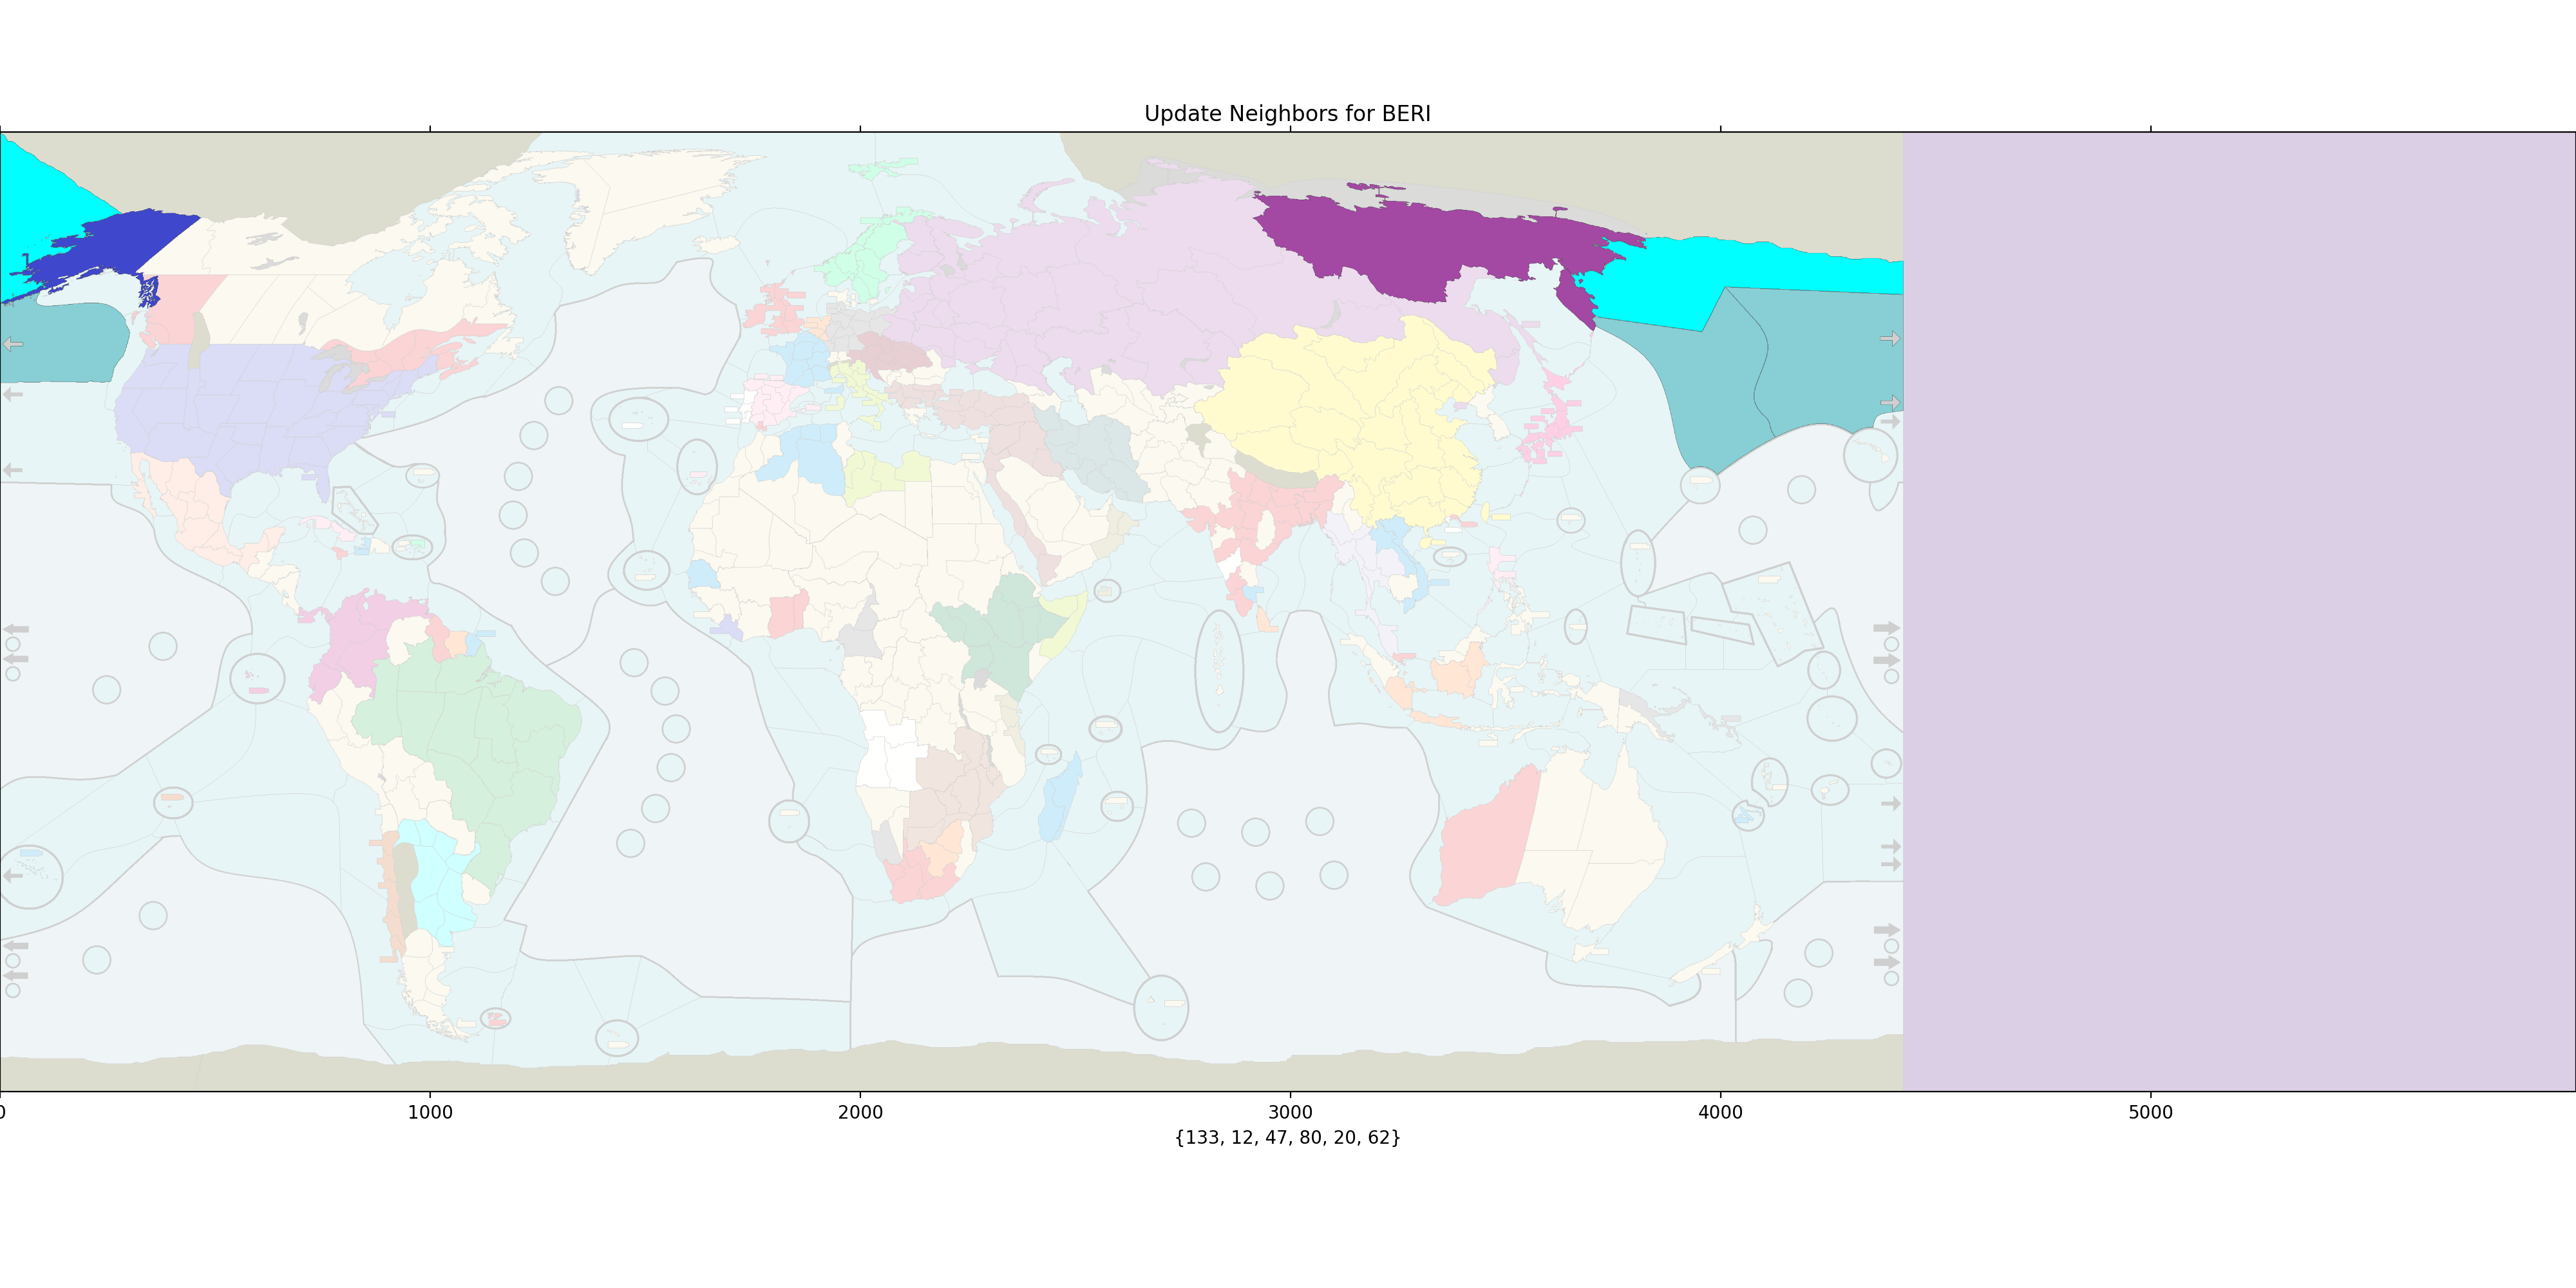

  0%|          | 0/13 [00:00<?, ?it/s]

In [62]:
fg,ax = plt.subplots(figsize=(20,10))

rgbimg = rgb.copy()


itr = iter(tqdm({k:v for k,v in todo.items() if k not in fixed_neighbors}.items()))

idx, ns = None, None
mask = None

def _next_prompt():
    global idx, ns, mask, rgbimg
    if idx is not None:
        fixed_neighbors[idx] = set(ns)
    try:
        idx, ns = next(itr)
    except StopIteration:
        plt.clf()
        print('Done!')
    else:
        mask = sum(lbls==n for n in ns)
        mask += lbls==idx
        rgbimg = rgb.copy()
        rgbimg[lbls==idx] = [0,255,255]
        
        plt.cla()
        plt.imshow(get_highlight(rgbimg, mask, 0.1))
        plt.imshow(lbls%1000, alpha=0., zorder=10)
        plt.title('Update Neighbors for {}'.format(nodeIDs[idx]['name']))
        plt.xlabel(str(ns))
        
def _onkey(event=None):
    key = None if event is None else event.key
    if key == 'a':
        _next_prompt()
        
def _onclick(event):
    global mask, ns
    btn = event.button  # 1 is left, 3 is right
    try:
        yx = [float(event.ydata), float(event.xdata)]
    except:
        return
    if btn == 3:
        yx = tuple(map(int, yx))
        val = lbls[yx]
        
        if val in ns:
            ns.remove(val)
            mask[lbls==val] = 0
        else:
            ns.add(val)
            mask[lbls==val] = 1
        
        
        plt.cla()
        plt.imshow(get_highlight(rgbimg, mask, 0.1))
        plt.imshow(lbls%1000, alpha=0., zorder=10)
        plt.title('Update Neighbors for {}'.format(nodeIDs[idx]['name']))
        plt.xlabel(str(ns))
    else:  # invalid button
#         plt.xlabel(f'unknown button: {btn}')
        return
fg.canvas.mpl_connect('button_press_event', _onclick)
fg.canvas.mpl_connect('key_press_event', _onkey)
# for val in islands:
#     rgbimg[slbls==val] = [0,0,0]

_next_prompt()

plt.imshow(get_highlight(rgbimg, mask, 0.1))
plt.title('Update Neighbors for {}'.format(nodeIDs[idx]['name']))
plt.xlabel(str(ns))
# plt.axis('off')
plt.subplots_adjust(0,0.05,1,1);

In [44]:
# fixed_neighbors = {2: {10, 4, 6}, 3: {1, 17, 18, 4, 5}, 7: {80, 20, 133, 12, 62, 47}, 8: {99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31}, 12: {18, 7, 72, 59, 46, 47}, 13: {4, 36, 45, 51, 19, 26, 27, 28}, 18: {32, 17, 3, 37, 88, 12, 46}, 20: {80, 21, 55, 7, 42}, 23: {35, 4, 8, 49, 52, 21, 55, 31}, 31: {65, 35, 23, 8, 40}, 34: {22, 39, 26, 44, 28}, 36: {64, 98, 41, 76, 13, 50, 51, 83, 85, 54, 28, 95}, 39: {34, 44, 22, 24, 25, 58, 61, 57}, 42: {80, 20, 110, 55}, 45: {51, 77, 70, 27, 13, 63}, 51: {64, 45, 36, 13, 63}, 55: {42, 110, 113, 20, 21, 52, 23, 86}, 56: {65, 49, 35, 118, 153}, 59: {124, 84, 215, 72, 12, 47}, 68: {99, 115, 40, 8, 94}, 72: {192, 130, 134, 135, 73, 12, 46, 84, 59}, 94: {129, 145, 115, 68, 102, 40, 157}, 99: {115, 68, 8, 121, 184, 143}, 106: {32, 177, 164, 101, 165, 88, 219}, 115: {129, 99, 68, 8, 94, 184}, 149: {128, 97, 225, 160, 720, 213, 203}, 158: {193, 258, 199, 167, 137, 109, 150, 183, 182}, 168: {192, 218, 163, 124}, 193: {258, 242, 182, 199, 233, 158, 207}, 194: {241, 214, 88, 154, 142}, 227: {245, 258, 212, 285}, 258: {193, 227, 270, 207, 242, 212, 181, 285, 158, 287}, 267: {192, 208, 243, 297, 236}, 269: {256, 338, 291, 281, 173, 265, 333}, 297: {263, 267, 236, 302, 303, 243, 341, 286, 255}, 303: {341, 359, 297, 302, 255}, 323: {281, 333, 305}, 391: {419, 403, 405, 333, 397}, 433: {480, 451, 360, 457, 380, 489, 415}, 439: {513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413}, 452: {386, 492, 465, 466, 435, 499, 472, 507}, 465: {466, 499, 452, 507, 492}, 467: {497, 419, 446, 486}, 489: {433, 451, 503, 457, 509}, 496: {513, 502, 439, 523, 477, 527}, 499: {465, 452, 516, 533, 472, 507}, 507: {465, 499, 452, 533, 492}, 517: {480, 457, 576, 541}, 520: {720, 721, 515, 602, 554, 477, 575}, 525: {545, 531, 501, 488, 508, 542}, 531: {545, 483, 488, 525, 494, 500, 567, 539, 478}, 532: {457, 503, 509, 543}, 543: {546, 532, 503, 457, 570, 555, 541}, 545: {562, 531, 567, 525, 542}, 551: {544, 585, 536, 749, 559, 529, 596, 600, 537, 571}, 554: {577, 515, 520, 552, 524, 527, 603, 574, 575}, 555: {576, 570, 587, 541, 543}, 558: {533, 550, 553, 570, 540, 573}, 571: {529, 563, 596, 551, 584, 619}, 573: {610, 563, 550, 598, 570, 558}, 576: {480, 517, 587, 555, 722, 594, 570, 541}, 585: {600, 611, 596, 551}, 596: {611, 551, 585, 619, 571}, 598: {592, 610, 594, 570, 587, 573}, 655: {642, 626, 658, 616, 685, 686, 671}, 673: {688, 662, 680, 637, 622}, 688: {704, 673, 674, 680, 684, 722, 662, 697}, 694: {705, 706, 721, 708, 690, 696, 686}, 697: {688, 684, 704}, 699: {668, 647, 711, 679, 715, 719, 689, 700, 701}, 701: {708, 709, 693, 711, 696, 699, 700}, 711: {705, 709, 701, 714, 715, 699}, 715: {705, 770, 706, 711, 714, 699, 719}}
fixed_neighbors = {7: {80, 20, 133, 12, 62, 47}, 31: {65, 35, 23, 8, 40}, 36: {64, 98, 41, 76, 13, 50, 83, 51, 85, 54, 28, 95}, 45: {51, 77, 70, 27, 13, 63}, 51: {64, 13, 36, 45, 63}, 149: {128, 97, 160, 225, 720, 213, 203}, 168: {192, 218, 163, 124}, 303: {341, 359, 297, 302, 255}, 489: {433, 451, 503, 457, 509}, 555: {576, 570, 587, 541, 543}, 571: {529, 563, 596, 551, 584, 619}, 697: {688, 684, 704}, 715: {705, 770, 706, 711, 714, 699, 719}}
# print(fixed_neighbors)

# Dotted Edges

In [45]:
dots = [tile for tile in tiles if tile is not None and tile.area == 1]
len(dots)

429

In [41]:
links = {}
for dot in tqdm(dots):
    mask = lbls.copy()*0
    mask[tuple(dot.coords.T)] = 1
    mask = mask.astype(bool)
    me = lbls[mask][0]
    if me in nodeIDs and nodeIDs[me]['type'] != 'sea':
        prox = expand_labels(mask, 2).astype(bool)
        hops = set(lbls[prox])
        hops.remove(me)
        hops.discard(0)
        ln = {t for t in hops if t in nodeIDs and nodeIDs[t]['type'] != 'sea'}
        if len(ln):
            links[me] = ln
links = [(x,y) for x,ys in links.items() for y in ys]
len(links)

  0%|          | 0/429 [00:00<?, ?it/s]

24

In [46]:
# links = [(45, 77), (50, 53), (53, 44), (77, 45), (44, 53), (68, 99), (99, 68), (153, 174), (174, 153), (168, 218), (218, 168), (250, 217), (217, 250), (255, 303), (303, 255), (452, 507), (492, 452), (507, 452), (505, 493), (555, 587), (587, 598), (598, 587), (703, 695), (695, 703)]
links = [(45, 77), (50, 53), (53, 44), (77, 45), (44, 53), (68, 99), (99, 68), (153, 174), (174, 153), (168, 218), (218, 168), (250, 217), (217, 250), (255, 303), (303, 255), (452, 507), (492, 452), (507, 452), (505, 493), (555, 587), (587, 598), (598, 587), (703, 695), (695, 703)]
# print(links)

In [47]:
# highlight(rgb,expand_labels(sum(lbls==i for i in [218,168]),5))

In [48]:
for x,y in links:
    ntx[x].add(y)
    ntx[y].add(x)

In [44]:
edges = {}
for idx in tqdm([i for i in nodeIDs if i not in edges]):
    node = nodeIDs[idx]
    ns = ntx[idx]
    es = {}
    
    seas = {n for n in ns if nodeIDs[n]['type'] == 'sea'}
    if node['type'] == 'sea':
        es['fleet'] = set(ns)
    else:
        es['army'] = set(ns-seas)
        if len(seas):
            node['type'] = 'coast'
            coasts = []
            while len(seas):
                sea = seas.pop()
                
                for coast in coasts:
                    if coast.intersection(ntx[sea]):
                        coast.add(sea)
                        break
                else:
                    coasts.append({sea})
            
            if len(coasts) > 1:
                joined = [coasts[0]]
                for coast in coasts[1:]:
                    seeds = {n for s in coast for n in ntx[s] if nodeIDs[n]['type'] == 'sea'}
                    for sel in joined:
                        if seeds.intersection(sel):
                            sel.update(coast)
                            break
                    else:
                        joined.append(coast)
                coasts = joined
                
            lands = [{l for c in coast for l in ntx[c] if l in ns and nodeIDs[l]['type'] != 'sea'} for coast in coasts]
            fleet = {i:{*f, *a} for i,(f,a) in enumerate(zip(coasts,lands))}
            es['fleet'] = fleet[0] if len(fleet) == 1 else fleet
    edges[idx] = es
    
len(edges)

  0%|          | 0/781 [00:00<?, ?it/s]

781

In [49]:
# edges = {1: {'army': [], 'fleet': {0: {3, 4, 5}}}, 2: {'army': [10, 6], 'fleet': {0: {10, 4, 6}}}, 3: {'fleet': [1, 4, 5, 17, 18]}, 4: {'fleet': [1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 19, 23, 26, 29]}, 5: {'fleet': [1, 3, 4, 9, 14, 17]}, 6: {'army': [2, 10], 'fleet': {0: {2, 4, 8, 10, 29}}}, 7: {'fleet': [133, 12, 47, 80, 20, 62]}, 8: {'fleet': [99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31]}, 9: {'army': [16, 11, 14, 15], 'fleet': {0: {11, 4, 5, 14}}}, 10: {'army': [2, 6], 'fleet': {0: {2, 4, 29, 6}}}, 11: {'army': [16, 9, 26], 'fleet': {0: {9, 26, 4}}}, 12: {'army': [72, 18, 46, 47], 'fleet': {0: {72, 59, 47}, 1: {47, 7}}}, 13: {'fleet': [4, 36, 45, 51, 19, 26, 27, 28]}, 14: {'army': [38, 9, 15, 17, 24, 30], 'fleet': {0: {9, 5, 17}}}, 15: {'army': [16, 9, 14, 24], 'fleet': {0: {16, 25, 24}}}, 16: {'army': [9, 11, 15, 22, 26], 'fleet': {0: {25, 22, 15}}}, 17: {'army': [32, 43, 14, 18, 30], 'fleet': {0: {18, 3, 5, 14}}}, 18: {'army': [32, 37, 12, 46, 17, 88], 'fleet': {0: {17, 3}}}, 19: {'army': [], 'fleet': {0: {29, 27, 4, 13}}}, 20: {'army': [21, 55], 'fleet': {0: {80, 42, 55, 7}}}, 21: {'army': [20, 55, 23]}, 22: {'army': [16, 34, 26], 'fleet': {0: {16, 25, 34, 39}}}, 23: {'army': [35, 49, 52, 21, 55], 'fleet': {0: {8, 35, 4, 31}}}, 24: {'army': [15, 38, 14], 'fleet': {0: {25, 15, 39}, 1: {58, 38}}}, 25: {'fleet': [39, 15, 16, 22, 24]}, 26: {'army': [34, 11, 16, 22, 28], 'fleet': {0: {28, 11, 4, 13}}}, 27: {'fleet': [97, 70, 13, 77, 45, 720, 19, 29]}, 28: {'army': [34, 26, 44], 'fleet': {0: {36, 41, 26, 44, 13}}}, 29: {'fleet': [4, 6, 8, 10, 720, 19, 27]}, 30: {'army': [48, 17, 38, 43, 14]}, 31: {'fleet': [65, 35, 8, 40, 23]}, 32: {'army': [17, 18, 101, 88, 106, 43]}, 33: {'army': [38, 71], 'fleet': {0: {58, 38, 71}}}, 34: {'army': [26, 44, 28, 22], 'fleet': {0: {44, 22, 39}}}, 35: {'army': [56, 65, 23, 49], 'fleet': {0: {65, 23, 31}}}, 36: {'fleet': [64, 98, 41, 76, 13, 50, 51, 83, 85, 54, 28, 95]}, 37: {'army': [18, 116, 88, 142, 46]}, 38: {'army': [33, 69, 71, 78, 14, 48, 24, 30], 'fleet': {0: {24, 33, 58, 71}}}, 39: {'fleet': [34, 44, 22, 24, 25, 58, 61, 57]}, 40: {'army': [65, 68, 102, 94], 'fleet': {0: {8, 65, 68, 31}}}, 41: {'fleet': [36, 44, 50, 53, 28, 61]}, 42: {'fleet': [80, 20, 110, 55]}, 43: {'army': [32, 48, 17, 101, 91, 30]}, 44: {'army': [34, 28], 'fleet': {0: {34, 39, 41, 28, 61}}}, 45: {'army': [51, 63], 'fleet': {0: {51, 70, 27, 13, 63}}}, 46: {'army': [18, 116, 37, 72, 73, 12]}, 47: {'army': [12], 'fleet': {0: {133, 7, 215, 59, 12}}}, 48: {'army': [69, 38, 91, 43, 30]}, 49: {'army': [35, 52, 118, 23, 56, 127]}, 50: {'army': [60], 'fleet': {0: {36, 54, 41, 60, 61}}}, 51: {'army': [64, 45, 63], 'fleet': {0: {64, 45, 36, 13}}}, 52: {'army': [49, 127, 55, 23]}, 53: {'army': [], 'fleet': {0: {41, 61}}}, 54: {'fleet': [67, 36, 74, 76, 50, 60]}, 55: {'army': [113, 20, 21, 52, 23, 86], 'fleet': {0: {113, 20, 86, 42, 110}}}, 56: {'army': [65, 49, 35, 118, 153]}, 57: {'army': [], 'fleet': {0: {58, 61, 39}}}, 58: {'fleet': [33, 66, 38, 39, 71, 75, 24, 57, 61]}, 59: {'fleet': [72, 168, 12, 47, 84, 215, 124]}, 60: {'army': [50, 67], 'fleet': {0: {50, 67, 61}, 1: {50, 67, 54}}}, 61: {'fleet': [67, 39, 41, 75, 44, 50, 53, 57, 58, 60]}, 62: {'fleet': [133, 7, 718, 336, 307]}, 63: {'army': [64, 89, 51, 45], 'fleet': {0: {89, 45, 70}}}, 64: {'army': [89, 83, 51, 63], 'fleet': {0: {51, 83, 36}}}, 65: {'army': [35, 102, 40, 56, 153, 120], 'fleet': {0: {40, 35, 31}}}, 66: {'army': [82, 75, 79, 71], 'fleet': {0: {58, 75, 71}}}, 67: {'army': [74, 75, 60], 'fleet': {0: {75, 60, 61}, 1: {74, 60, 54}}}, 68: {'army': [40, 94], 'fleet': {0: {8, 40, 115, 94}}}, 69: {'army': [48, 38, 90, 91, 78]}, 70: {'fleet': [97, 45, 77, 89, 27, 63]}, 71: {'army': [33, 66, 38, 78, 82], 'fleet': {0: {33, 58, 66, 38}}}, 72: {'army': [130, 134, 135, 73, 12, 46, 84], 'fleet': {0: {192, 84, 135}, 1: {59, 12, 84}}}, 73: {'army': [116, 134, 72, 107, 46]}, 74: {'army': [67, 75, 76, 81, 87, 92], 'fleet': {0: {67, 76, 54}}}, 75: {'army': [66, 67, 74, 79, 81], 'fleet': {0: {67, 58, 66, 61}}}, 76: {'army': [96, 74, 85, 87], 'fleet': {0: {74, 36, 85, 54}}}, 77: {'army': [], 'fleet': {0: {97, 27, 70}}}, 78: {'army': [82, 69, 38, 71, 90]}, 79: {'army': [81, 66, 82, 103, 75, 93]}, 80: {'fleet': [7, 42, 110, 239, 20]}, 81: {'army': [93, 74, 75, 108, 92, 79]}, 82: {'army': [66, 71, 103, 105, 90, 78, 79]}, 83: {'army': [64, 89, 85], 'fleet': {0: {64, 98, 36, 85, 89}}}, 84: {'army': [72], 'fleet': {0: {192, 72, 124}, 1: {72, 59}}}, 85: {'army': [96, 83, 76, 95], 'fleet': {0: {83, 36, 95, 76}}}, 86: {'army': [113, 55], 'fleet': {0: {113, 110, 55}}}, 87: {'army': [96, 104, 74, 76, 92]}, 88: {'army': [32, 194, 37, 106, 142, 177, 18, 214]}, 89: {'army': [64, 83, 63], 'fleet': {0: {97, 98, 83, 70, 63}}}, 90: {'army': [137, 82, 69, 105, 91, 109, 78]}, 91: {'army': [48, 147, 69, 101, 90, 43, 109]}, 92: {'army': [81, 100, 87, 104, 74, 108]}, 93: {'army': [112, 81, 117, 103, 108, 79]}, 94: {'army': [129, 68, 102, 40, 145, 157], 'fleet': {0: {129, 115, 68}}}, 95: {'army': [96, 111, 114, 85, 125], 'fleet': {0: {98, 36, 85, 114}}}, 96: {'army': [85, 87, 104, 76, 95, 111]}, 97: {'fleet': [128, 98, 70, 77, 720, 114, 149, 89, 27]}, 98: {'fleet': [97, 36, 114, 83, 89, 95]}, 99: {'army': [], 'fleet': {0: {8, 121, 115, 184}, 1: {143}}}, 100: {'army': [117, 104, 122, 123, 108, 92]}, 101: {'army': [32, 106, 43, 147, 91, 159], 'fleet': {0: {106, 165, 159}}}, 102: {'army': [144, 65, 180, 40, 120, 157, 94]}, 103: {'army': [112, 82, 131, 105, 93, 79]}, 104: {'army': [96, 100, 87, 123, 92, 126, 111]}, 105: {'army': [131, 103, 136, 137, 82, 150, 119, 90]}, 106: {'army': [32, 164, 101, 177, 88, 219], 'fleet': {0: {101, 219, 165}}}, 107: {'army': [73, 116, 134]}, 108: {'army': [81, 100, 117, 92, 93]}, 109: {'army': [91, 137, 90, 147], 'fleet': {0: {137, 147, 158, 183}}}, 110: {'fleet': [42, 239, 80, 113, 273, 148, 86, 55]}, 111: {'army': [96, 104, 125, 126, 95]}, 112: {'army': [131, 132, 117, 93, 103, 141]}, 113: {'army': [197, 171, 148, 86, 55], 'fleet': {0: {86, 148, 110, 55}}}, 114: {'army': [125, 95, 151], 'fleet': {0: {128, 97, 98, 151, 95}}}, 115: {'fleet': [129, 99, 68, 8, 184, 94]}, 116: {'army': [37, 134, 73, 107, 142, 46, 247, 154, 254]}, 117: {'army': [112, 140, 132, 100, 122, 108, 93]}, 118: {'army': [49, 189, 56, 153, 173, 127]}, 119: {'army': [136, 105, 131, 141]}, 120: {'army': [144, 65, 153, 102]}, 121: {'fleet': [8, 99, 720, 143]}, 122: {'army': [123, 139, 100, 117]}, 123: {'army': [100, 104, 122, 139, 126]}, 124: {'fleet': [192, 163, 168, 84, 215, 59]}, 125: {'army': [114, 95, 151, 126, 111]}, 126: {'army': [146, 151, 104, 170, 123, 125, 111]}, 127: {'army': [49, 210, 52, 118, 171, 189]}, 128: {'fleet': [160, 97, 162, 114, 149, 151]}, 129: {'army': [145, 94], 'fleet': {0: {145, 178, 115, 184, 94}}}, 130: {'army': [208, 134, 135, 72, 138]}, 131: {'army': [112, 119, 103, 105, 141]}, 132: {'army': [112, 117, 140, 141], 'fleet': {0: {179, 140, 141}}}, 133: {'fleet': [7, 718, 47, 215, 760, 62]}, 134: {'army': [130, 72, 73, 138, 107, 116, 156, 254]}, 135: {'army': [72, 130, 208], 'fleet': {0: {192, 72, 208}}}, 136: {'army': [169, 150, 119, 105, 141]}, 137: {'army': [105, 90, 109, 150], 'fleet': {0: {150, 109, 158}}}, 138: {'army': [208, 130, 195, 134, 156, 191]}, 139: {'army': [161, 166, 122, 123, 140, 175]}, 140: {'army': [161, 139, 132, 117], 'fleet': {0: {161, 179, 132}}}, 141: {'army': [131, 132, 136, 169, 112, 119, 152], 'fleet': {0: {152, 179, 132}}}, 142: {'army': [194, 116, 37, 88, 154]}, 143: {'fleet': [184, 121, 99, 720]}, 144: {'army': [120, 180, 174, 102]}, 145: {'army': [129, 157, 94], 'fleet': {0: {129, 178, 157}}}, 146: {'army': [170, 126, 166], 'fleet': {0: {170, 172, 205, 166}}}, 147: {'army': [101, 109, 91, 190, 159], 'fleet': {0: {109, 190, 183}}}, 148: {'army': [113, 197, 273], 'fleet': {0: {113, 110, 273}}}, 149: {'fleet': [128, 97, 225, 160, 203, 720, 213]}, 150: {'army': [167, 136, 137, 169, 105], 'fleet': {0: {137, 158, 167}}}, 151: {'army': [162, 170, 114, 186, 125, 126], 'fleet': {0: {128, 162, 114}}}, 152: {'army': [169, 155, 141], 'fleet': {0: {179, 155, 141}}}, 153: {'army': [65, 118, 56, 120, 173]}, 154: {'army': [241, 194, 116, 247, 280, 282, 142]}, 155: {'army': [152, 169, 185], 'fleet': {0: {152, 185, 179}}}, 156: {'army': [134, 263, 138, 266, 254, 191]}, 157: {'army': [102, 176, 145, 180, 94], 'fleet': {0: {176, 145, 178, 184, 251}}}, 158: {'fleet': [193, 258, 199, 167, 137, 109, 150, 183, 182]}, 159: {'army': [209, 147, 101, 190], 'fleet': {0: {209, 101, 165}}}, 160: {'army': [216, 162, 203, 204], 'fleet': {0: {128, 162, 203, 149}}}, 161: {'army': [198, 200, 139, 140, 175], 'fleet': {0: {200, 179, 140}}}, 162: {'army': [160, 186, 216, 151], 'fleet': {0: {128, 160, 151}}}, 163: {'fleet': [192, 228, 261, 168, 215, 218, 124]}, 164: {'army': [177, 234, 219, 106]}, 165: {'fleet': [101, 230, 106, 209, 219, 159]}, 166: {'army': [146, 139, 175], 'fleet': {0: {146, 172, 175}}}, 167: {'army': [169, 182, 150], 'fleet': {0: {150, 182, 158}}}, 168: {'army': [], 'fleet': {0: {192, 163, 215, 59, 124}}}, 169: {'army': [167, 136, 141, 181, 150, 182, 152, 185, 155]}, 170: {'army': [146, 151, 186, 187, 126], 'fleet': {0: {146, 187, 205}}}, 171: {'army': [113, 210, 197, 268, 127]}, 172: {'fleet': [224, 166, 235, 205, 175, 146, 188, 223]}, 173: {'army': [256, 153, 118, 189, 265, 202, 269]}, 174: {'army': [144, 202]}, 175: {'army': [161, 139, 198, 166], 'fleet': {0: {224, 172, 198, 166}}}, 176: {'army': [196, 180, 157], 'fleet': {0: {251, 196, 157}}}, 177: {'army': [234, 164, 214, 88, 106]}, 178: {'fleet': [184, 129, 145, 157]}, 179: {'fleet': [161, 132, 200, 201, 140, 141, 245, 152, 185, 155]}, 180: {'army': [144, 176, 196, 102, 157]}, 181: {'army': [169, 201, 207, 212, 182, 185], 'fleet': {0: {258, 212, 207}}}, 182: {'army': [193, 167, 169, 207, 181], 'fleet': {0: {193, 158, 167}}}, 183: {'fleet': [199, 109, 190, 147, 211, 220, 158]}, 184: {'fleet': [129, 99, 143, 720, 178, 115, 251, 157]}, 185: {'army': [169, 155, 201, 181], 'fleet': {0: {201, 179, 155}}}, 186: {'army': [162, 151, 232, 170, 187, 216]}, 187: {'army': [232, 186, 170], 'fleet': {0: {232, 170, 205, 206}}}, 188: {'army': [], 'fleet': {0: {235, 172, 205}}}, 189: {'army': [256, 210, 118, 173, 127]}, 190: {'army': [209, 147, 211, 159], 'fleet': {0: {147, 211, 183}}}, 191: {'army': [138, 195, 156, 263], 'fleet': {0: {195, 236, 263}}}, 192: {'fleet': [163, 135, 72, 168, 267, 208, 243, 84, 218, 124]}, 193: {'army': [199, 233, 207, 242, 182], 'fleet': {0: {258, 242, 182, 199, 158, 207}}}, 194: {'army': [241, 214, 88, 154, 142]}, 195: {'army': [208, 138, 221, 191], 'fleet': {0: {208, 236, 221, 191}}}, 196: {'army': [229, 231, 202, 176, 180], 'fleet': {0: {176, 251, 229, 231}}}, 197: {'army': [113, 273, 148, 171, 268]}, 198: {'army': [200, 161, 217, 175], 'fleet': {0: {224, 217, 175}}}, 199: {'army': [193, 220, 233], 'fleet': {0: {193, 220, 158, 183}}}, 200: {'army': [161, 217, 198], 'fleet': {0: {161, 179, 217, 245}}}, 201: {'army': [185, 212, 181], 'fleet': {0: {185, 179, 212, 245}}}, 202: {'army': [196, 229, 265, 173, 174]}, 203: {'army': [160, 225, 204], 'fleet': {0: {160, 225, 213, 149}}}, 204: {'army': [160, 225, 240, 246, 248, 203, 216]}, 205: {'fleet': [772, 170, 235, 172, 206, 146, 187, 188]}, 206: {'fleet': [772, 232, 205, 237, 187]}, 207: {'army': [193, 181, 182], 'fleet': {0: {193, 258, 181}}}, 208: {'army': [130, 195, 135, 138, 267, 221], 'fleet': {0: {192, 267, 135}, 1: {267, 236, 221, 195}}}, 209: {'army': [238, 275, 211, 253, 190, 159], 'fleet': {0: {275, 165, 230, 159}}}, 210: {'army': [256, 284, 171, 268, 189, 127]}, 211: {'army': [209, 220, 190, 238], 'fleet': {0: {220, 190, 183}}}, 212: {'army': [201, 227, 181], 'fleet': {0: {258, 227, 181}, 1: {201, 227, 245}}}, 213: {'fleet': [225, 226, 257, 203, 720, 753, 149, 246, 277]}, 214: {'army': [177, 194, 241, 262, 88, 234]}, 215: {'fleet': [163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124]}, 216: {'army': [160, 248, 162, 232, 186, 204]}, 217: {'army': [200, 250, 198], 'fleet': {0: {224, 245, 198, 200, 250}}}, 218: {'army': [228], 'fleet': {0: {192, 163, 228, 243}}}, 219: {'army': [289, 106, 234, 164], 'fleet': {0: {289, 106, 165, 230}}}, 220: {'army': [233, 211, 238, 199], 'fleet': {0: {199, 211, 183}}}, 221: {'army': [208, 195], 'fleet': {0: {208, 195, 236}}}, 222: {'army': [], 'fleet': {0: {772}}}, 223: {'army': [], 'fleet': {0: {224, 235, 172}}}, 224: {'fleet': [288, 198, 235, 172, 175, 245, 217, 250, 223]}, 225: {'army': [203, 204, 246], 'fleet': {0: {203, 213, 149, 246}}}, 226: {'fleet': [720, 753, 340, 213]}, 227: {'army': [212], 'fleet': {0: {245, 258, 212, 285}}}, 228: {'army': [218, 244, 261], 'fleet': {0: {218, 163, 261}, 1: {218, 243, 244}}}, 229: {'army': [196, 231, 265, 202, 271], 'fleet': {0: {231, 251, 196, 271}}}, 230: {'fleet': [289, 165, 209, 275, 219]}, 231: {'army': [196, 229], 'fleet': {0: {251, 196, 229}}}, 232: {'army': [248, 186, 187, 216], 'fleet': {0: {259, 248, 187, 237, 206}}}, 233: {'army': [193, 199, 264, 238, 242, 220], 'fleet': {0: {264, 242, 260, 270}}}, 234: {'army': [289, 290, 164, 262, 177, 214, 278, 219]}, 235: {'fleet': [224, 288, 772, 172, 205, 237, 272, 276, 188, 223]}, 236: {'fleet': [195, 263, 297, 267, 208, 221, 191]}, 237: {'fleet': [259, 772, 292, 232, 235, 206, 272, 317]}, 238: {'army': [209, 274, 211, 264, 233, 220, 253]}, 239: {'fleet': [718, 110, 80, 273, 337, 309, 344]}, 240: {'army': [248, 249, 204, 246], 'fleet': {0: {249, 277, 246}}}, 241: {'army': [194, 214, 262, 154]}, 242: {'army': [193, 233], 'fleet': {0: {193, 258, 233, 270}}}, 243: {'fleet': [192, 228, 295, 297, 267, 244, 218, 255]}, 244: {'army': [228, 261, 295], 'fleet': {0: {243, 228, 295}, 1: {420, 261, 302, 295}}}, 245: {'fleet': [224, 288, 227, 200, 201, 179, 212, 217, 250, 285]}, 246: {'army': [240, 225, 204], 'fleet': {0: {240, 225, 277, 213}}}, 247: {'army': [116, 280, 154, 300, 301, 254]}, 248: {'army': [232, 204, 240, 216, 249], 'fleet': {0: {232, 249, 259}}}, 249: {'army': [240, 248], 'fleet': {0: {248, 240, 259, 277}}}, 250: {'army': [217], 'fleet': {0: {224, 217, 245}}}, 251: {'fleet': [196, 229, 231, 271, 176, 720, 184, 157]}, 252: {'army': [], 'fleet': {0: {753}}}, 253: {'army': [209, 274, 275, 238]}, 254: {'army': [156, 116, 134, 247, 266, 300]}, 255: {'army': [293, 295], 'fleet': {0: {243, 293, 295, 297, 302}}}, 256: {'army': [210, 291, 189, 173, 284, 269]}, 257: {'fleet': [753, 755, 213, 277, 342, 312, 283, 351]}, 258: {'fleet': [193, 227, 270, 207, 242, 212, 181, 285, 158, 287]}, 259: {'fleet': [292, 232, 296, 237, 277, 248, 249]}, 260: {'fleet': [264, 233, 270, 310, 279, 287]}, 261: {'army': [228, 244], 'fleet': {0: {163, 228, 215}, 1: {420, 244}}}, 262: {'army': [241, 294, 214, 278, 234, 298]}, 263: {'army': [266, 156, 286, 191], 'fleet': {0: {297, 236, 286, 191}}}, 264: {'army': [310, 233, 274, 238], 'fleet': {0: {233, 260, 310}}}, 265: {'army': [229, 173, 281, 202, 269, 271]}, 266: {'army': [156, 324, 325, 263, 300, 254, 286]}, 267: {'army': [208], 'fleet': {0: {192, 243, 208}, 1: {208, 297, 236}}}, 268: {'army': [273, 210, 315, 197, 309, 171, 284]}, 269: {'army': [256, 291, 265, 173, 281], 'fleet': {0: {281, 338, 291, 333}}}, 270: {'fleet': [258, 260, 233, 242, 279, 287]}, 271: {'army': [265, 229, 281], 'fleet': {0: {720, 305, 229, 281, 251}}}, 272: {'army': [276, 317, 308], 'fleet': {0: {317, 235, 276, 237}}}, 273: {'army': [148, 309, 268, 197], 'fleet': {0: {148, 309, 110, 239}}}, 274: {'army': [322, 264, 238, 304, 275, 310, 314, 253]}, 275: {'army': [289, 304, 209, 274, 253], 'fleet': {0: {289, 209, 230}}}, 276: {'army': [288, 272, 308], 'fleet': {0: {288, 272, 235}}}, 277: {'fleet': [257, 259, 296, 240, 213, 246, 312, 249]}, 278: {'army': [234, 290, 298, 262]}, 279: {'army': [], 'fleet': {0: {260, 270, 287}}}, 280: {'army': [282, 154, 301, 247]}, 281: {'army': [265, 323, 269, 271], 'fleet': {0: {305, 323, 269, 333, 271}}}, 282: {'army': [280, 154, 294, 319]}, 283: {'fleet': [753, 755, 340, 257]}, 284: {'army': [256, 291, 331, 268, 210, 315], 'fleet': {0: {291, 338, 331}}}, 285: {'fleet': [288, 321, 258, 227, 332, 334, 306, 245, 287]}, 286: {'army': [266, 325, 263], 'fleet': {0: {297, 325, 341, 263}}}, 287: {'fleet': [321, 258, 260, 326, 299, 270, 310, 279, 285]}, 288: {'army': [306, 276, 308], 'fleet': {0: {224, 235, 276, 245}, 1: {306, 285}}}, 289: {'army': [290, 329, 234, 304, 275, 313, 219, 316], 'fleet': {0: {275, 230, 219}}}, 290: {'army': [289, 278, 316, 234, 298]}, 291: {'army': [256, 284, 269], 'fleet': {0: {338, 284, 269}}}, 292: {'army': [296, 317], 'fleet': {0: {296, 317, 259, 237}}}, 293: {'army': [255, 295], 'fleet': {0: {295, 302, 255}}}, 294: {'army': [262, 311, 298, 282, 319]}, 295: {'army': [244, 293, 255], 'fleet': {0: {243, 244, 255}, 1: {244, 293, 302, 255}}}, 296: {'army': [312, 353, 292, 317], 'fleet': {0: {312, 259, 292, 277}}}, 297: {'fleet': [263, 267, 236, 302, 303, 243, 341, 286, 255]}, 298: {'army': [290, 294, 262, 278, 345, 316, 311]}, 299: {'army': [326, 423, 310, 350, 383], 'fleet': {0: {372, 383, 423}, 1: {326, 310, 287}}}, 300: {'army': [324, 266, 301, 369, 347, 343, 346, 247, 254]}, 301: {'army': [280, 346, 300, 247]}, 302: {'fleet': [420, 293, 359, 295, 297, 303, 244, 341, 255]}, 303: {'army': [], 'fleet': {0: {297, 341, 302, 359}}}, 304: {'army': [289, 274, 275, 313, 314], 'fleet': {0: {313, 314, 349}}}, 305: {'fleet': [352, 323, 333, 717, 271, 720, 281]}, 306: {'army': [288, 308, 334], 'fleet': {0: {288, 285, 334}}}, 307: {'fleet': [336, 62, 773, 718]}, 308: {'army': [288, 353, 334, 272, 306, 276, 375, 317]}, 309: {'army': [354, 268, 273, 344, 315], 'fleet': {0: {344, 354, 356}, 1: {344, 273, 239}}}, 310: {'army': [322, 264, 299, 274, 383], 'fleet': {0: {264, 299, 260, 287}}}, 311: {'army': [339, 294, 345, 298, 330, 319]}, 312: {'army': [296, 353, 342], 'fleet': {0: {296, 257, 277, 342}}}, 313: {'army': [304, 289, 329], 'fleet': {0: {304, 329, 349}}}, 314: {'army': [304, 274, 322, 363], 'fleet': {0: {304, 363, 349}}}, 315: {'army': [354, 370, 309, 284, 331, 268]}, 316: {'army': [289, 290, 329, 298, 345], 'fleet': {0: {329, 345, 357}}}, 317: {'army': [353, 292, 296, 272, 308], 'fleet': {0: {272, 292, 237}}}, 318: {'army': [], 'fleet': {0: {765}}}, 319: {'army': [339, 294, 311, 328, 282]}, 320: {'army': [], 'fleet': {0: {755}}}, 321: {'army': [332, 381, 326], 'fleet': {0: {332, 285, 326, 287}}}, 322: {'army': [274, 422, 310, 314, 363, 383]}, 323: {'army': [281], 'fleet': {0: {305, 333, 281}}}, 324: {'army': [369, 355, 325, 266, 300, 365]}, 325: {'army': [266, 355, 324, 286], 'fleet': {0: {355, 395, 341, 286}}}, 326: {'army': [321, 299, 381, 350], 'fleet': {0: {321, 299, 287}}}, 327: {'army': [], 'fleet': {0: {760}}}, 328: {'army': [339, 371, 319, 361, 335]}, 329: {'army': [289, 316, 313], 'fleet': {0: {313, 357, 316, 349}}}, 330: {'army': [345, 339, 366, 311], 'fleet': {0: {368, 345, 366}}}, 331: {'army': [387, 370, 409, 315, 284], 'fleet': {0: {409, 338, 284}}}, 332: {'army': [321, 362, 381, 334], 'fleet': {0: {321, 285, 334}}}, 333: {'fleet': [352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382]}, 334: {'army': [362, 332, 306, 308, 375], 'fleet': {0: {306, 332, 285}}}, 335: {'army': [328, 361, 364, 348]}, 336: {'fleet': [62, 307, 718]}, 337: {'fleet': [344, 444, 718, 239]}, 338: {'fleet': [291, 331, 269, 333, 409, 284, 382]}, 339: {'army': [371, 311, 328, 330, 366, 319]}, 340: {'fleet': [226, 720, 753, 755, 756, 473, 283, 351]}, 341: {'fleet': [325, 359, 297, 395, 302, 303, 377, 286]}, 342: {'army': [384, 353, 312, 389], 'fleet': {0: {312, 257, 384, 351}}}, 343: {'army': [374, 360, 380, 346, 347, 300]}, 344: {'army': [309], 'fleet': {0: {337, 356, 309, 444, 239}}}, 345: {'army': [298, 316, 330, 311], 'fleet': {0: {368, 330, 316, 357}}}, 346: {'army': [348, 358, 343, 360, 300, 301]}, 347: {'army': [369, 374, 343, 380, 300]}, 348: {'army': [346, 364, 358, 335]}, 349: {'fleet': [357, 329, 394, 363, 367, 304, 313, 314]}, 350: {'army': [326, 423, 406, 299, 381]}, 351: {'fleet': [384, 257, 417, 481, 755, 340, 756, 342, 440, 445]}, 352: {'fleet': [774, 717, 333, 305, 379, 413]}, 353: {'army': [389, 296, 404, 308, 342, 375, 312, 317]}, 354: {'army': [315, 370, 387, 309], 'fleet': {0: {356, 387, 444, 309}}}, 355: {'army': [388, 325, 324, 396, 365], 'fleet': {0: {395, 388, 325}}}, 356: {'fleet': [344, 354, 444, 309]}, 357: {'fleet': [385, 329, 367, 368, 373, 345, 316, 349]}, 358: {'army': [360, 346, 364, 348], 'fleet': {0: {480, 364, 360, 479}}}, 359: {'fleet': [386, 420, 302, 303, 341, 377, 767]}, 360: {'army': [358, 433, 343, 346, 380], 'fleet': {0: {480, 433, 358}}}, 361: {'army': [371, 390, 335, 328, 364, 399]}, 362: {'army': [401, 375, 332, 381, 334]}, 363: {'army': [322, 314, 422, 394], 'fleet': {0: {394, 314, 349}}}, 364: {'army': [390, 358, 361, 393, 335, 348], 'fleet': {0: {393, 358, 479}}}, 365: {'army': [355, 324, 392, 396, 369], 'fleet': {0: {408, 396, 392, 407}}}, 366: {'army': [400, 371, 330, 339], 'fleet': {0: {368, 400, 330, 437}}}, 367: {'army': [394, 373], 'fleet': {0: {394, 373, 349, 357}}}, 368: {'fleet': [385, 449, 357, 330, 366, 437, 345]}, 369: {'army': [402, 324, 392, 380, 347, 300, 365]}, 370: {'army': [315, 354, 331, 387]}, 371: {'army': [400, 339, 328, 361, 366, 399]}, 372: {'fleet': [299, 436, 383, 423]}, 373: {'army': [385, 394, 421, 367], 'fleet': {0: {385, 357, 367}}}, 374: {'army': [347, 380, 343]}, 375: {'army': [353, 401, 308, 404, 362, 334]}, 376: {'fleet': [780, 717, 720, 439, 379, 765]}, 377: {'army': [], 'fleet': {0: {386, 395, 341, 359}}}, 378: {'army': [], 'fleet': {0: {767}}}, 379: {'fleet': [352, 426, 780, 781, 717, 439, 376, 413]}, 380: {'army': [360, 369, 402, 433, 374, 343, 347, 415]}, 381: {'army': [321, 401, 326, 406, 362, 332, 350]}, 382: {'fleet': [416, 333, 398, 397, 338, 409]}, 383: {'army': [322, 422, 424, 299, 310], 'fleet': {0: {372, 299, 436, 424}}}, 384: {'army': [417, 389, 342], 'fleet': {0: {417, 342, 351}}}, 385: {'army': [373, 421], 'fleet': {0: {368, 449, 357, 373, 421}}}, 386: {'fleet': [452, 359, 395, 466, 435, 377, 767]}, 387: {'army': [354, 331, 428, 370, 409], 'fleet': {0: {354, 428, 444}}}, 388: {'army': [355, 396], 'fleet': {0: {408, 355, 395, 396}}}, 389: {'army': [384, 353, 417, 404, 454, 342, 440]}, 390: {'army': [361, 393, 425, 364, 399]}, 391: {'army': [405], 'fleet': {0: {419, 403, 397, 405}, 1: {333, 405}}}, 392: {'army': [369, 402, 460, 365], 'fleet': {0: {432, 460, 365, 407}}}, 393: {'army': [425, 364, 390], 'fleet': {0: {425, 364, 479}}}, 394: {'army': [421, 422, 363, 430, 367, 373], 'fleet': {0: {363, 349, 367}}}, 395: {'fleet': [386, 355, 388, 325, 435, 341, 408, 377]}, 396: {'army': [355, 388, 365], 'fleet': {0: {408, 388, 365}}}, 397: {'fleet': [419, 391, 333, 398, 382]}, 398: {'army': [416, 448], 'fleet': {0: {448, 416, 419, 397, 382}}}, 399: {'army': [400, 371, 390, 361, 425, 414]}, 400: {'army': [414, 371, 366, 399], 'fleet': {0: {366, 437, 414}}}, 401: {'army': [450, 404, 406, 455, 362, 381, 375]}, 402: {'army': [369, 434, 392, 380, 459, 460, 415]}, 403: {'fleet': [419, 391, 429, 405, 413]}, 404: {'army': [353, 450, 401, 389, 454, 375]}, 405: {'army': [391], 'fleet': {0: {403, 413, 391}, 1: {333, 391}}}, 406: {'army': [455, 423, 493, 495, 401, 468, 505, 381, 350]}, 407: {'fleet': [392, 365, 432, 408, 411]}, 408: {'fleet': [768, 388, 395, 396, 365, 432, 435, 407, 472, 411]}, 409: {'army': [416, 331, 387, 428], 'fleet': {0: {416, 338, 331, 382}}}, 410: {'army': [], 'fleet': {0: {780}}}, 411: {'army': [], 'fleet': {0: {408, 432, 407}}}, 412: {'army': [], 'fleet': {0: {781}}}, 413: {'fleet': [352, 426, 427, 333, 429, 403, 405, 439, 379]}, 414: {'army': [400, 425, 441, 399], 'fleet': {0: {400, 441, 437}}}, 415: {'army': [433, 434, 451, 402, 380]}, 416: {'army': [448, 409, 428, 398], 'fleet': {0: {409, 398, 382}, 1: {448, 428, 462}}}, 417: {'army': [384, 389, 440], 'fleet': {0: {384, 440, 351}}}, 418: {'army': [], 'fleet': {0: {754}}}, 419: {'fleet': [448, 391, 429, 397, 398, 497, 403, 467, 439, 446]}, 420: {'fleet': [261, 359, 302, 466, 754, 244, 215, 767]}, 421: {'army': [385, 394, 373, 430], 'fleet': {0: {449, 442, 385, 430}}}, 422: {'army': [322, 438, 424, 394, 363, 430, 383]}, 423: {'army': [299, 468, 406, 443, 350], 'fleet': {0: {372, 299, 436, 443}}}, 424: {'army': [438, 422, 383], 'fleet': {0: {436, 438, 383}}}, 425: {'army': [390, 393, 399, 441, 414, 447], 'fleet': {0: {456, 393, 447, 479}}}, 426: {'army': [427], 'fleet': {0: {427, 379, 413, 439}}}, 427: {'army': [426], 'fleet': {0: {426, 413, 439}}}, 428: {'army': [416, 409, 387], 'fleet': {0: {416, 387, 444, 462}}}, 429: {'army': [], 'fleet': {0: {419, 403, 413, 439}}}, 430: {'army': [394, 438, 421, 422], 'fleet': {0: {442, 438, 421, 470}}}, 431: {'army': [], 'fleet': {0: {768}}}, 432: {'fleet': [768, 408, 392, 460, 407, 472, 411]}, 433: {'army': [451, 360, 489, 380, 415], 'fleet': {0: {480, 457, 360, 489}}}, 434: {'army': [402, 451, 459, 415]}, 435: {'army': [452], 'fleet': {0: {408, 395, 452, 472}, 1: {386, 452}}}, 436: {'fleet': [423, 424, 372, 470, 438, 443, 383]}, 437: {'fleet': [449, 366, 463, 368, 400, 441, 414]}, 438: {'army': [424, 430, 422], 'fleet': {0: {424, 436, 430, 470}}}, 439: {'fleet': [513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413]}, 440: {'army': [417, 389, 454, 445], 'fleet': {0: {417, 445, 351}}}, 441: {'army': [464, 425, 414, 447], 'fleet': {0: {464, 437, 414, 463}}}, 442: {'fleet': [449, 769, 421, 518, 487, 430, 470]}, 443: {'army': [468, 484, 461, 423], 'fleet': {0: {436, 484, 470, 423}}}, 444: {'fleet': [354, 387, 356, 428, 718, 462, 337, 344]}, 445: {'army': [440, 474, 454], 'fleet': {0: {440, 481, 474, 351}}}, 446: {'army': [448, 467], 'fleet': {0: {448, 419, 467}, 1: {448, 467, 462, 486}}}, 447: {'army': [464, 425, 441, 469], 'fleet': {0: {456, 425, 469}}}, 448: {'army': [416, 446, 398], 'fleet': {0: {398, 419, 446}, 1: {416, 446, 462}}}, 449: {'fleet': [385, 769, 421, 487, 463, 368, 437, 442]}, 450: {'army': [401, 404, 454, 455, 475]}, 451: {'army': [489, 459, 433, 434, 415], 'fleet': {0: {489, 459, 503}}}, 452: {'army': [435], 'fleet': {0: {466, 386, 435}, 1: {472, 465, 499, 435}}}, 453: {'army': [], 'fleet': {0: {756}}}, 454: {'army': [450, 483, 389, 494, 404, 440, 474, 475, 445, 478]}, 455: {'army': [401, 450, 501, 406, 475, 508, 495]}, 456: {'fleet': [425, 447, 463, 469, 510, 479]}, 457: {'fleet': [480, 509, 517, 489, 433, 532, 541, 543]}, 458: {'army': [], 'fleet': {0: {749}}}, 459: {'army': [434, 451, 460, 402], 'fleet': {0: {451, 460, 503}}}, 460: {'army': [392, 402, 459], 'fleet': {0: {432, 392, 503, 472, 459}}}, 461: {'army': [514, 498, 484, 468, 443, 491]}, 462: {'fleet': [416, 448, 486, 428, 718, 444, 446]}, 463: {'fleet': [449, 583, 456, 487, 556, 464, 437, 469, 441, 476, 510]}, 464: {'army': [441, 476, 469, 447], 'fleet': {0: {441, 476, 469, 463}}}, 465: {'fleet': [452, 492, 466, 499, 507]}, 466: {'fleet': [386, 420, 452, 492, 529, 754, 465, 763, 540, 767]}, 467: {'army': [497, 446], 'fleet': {0: {497, 419, 446}, 1: {497, 446, 486}}}, 468: {'army': [461, 514, 406, 423, 443, 493]}, 469: {'army': [464, 476, 447], 'fleet': {0: {464, 456, 447, 476, 463}}}, 470: {'fleet': [484, 518, 430, 436, 438, 442, 443]}, 471: {'army': [], 'fleet': {0: {769}}}, 472: {'fleet': [768, 452, 516, 460, 432, 435, 499, 503, 408]}, 473: {'fleet': [481, 720, 721, 756, 340]}, 474: {'army': [512, 454, 490, 494, 445], 'fleet': {0: {512, 481, 490, 445}}}, 475: {'army': [450, 500, 501, 454, 455, 488, 478]}, 476: {'army': [464, 469], 'fleet': {0: {464, 469, 463}}}, 477: {'fleet': [515, 520, 524, 527, 720, 496, 439]}, 478: {'army': [483, 500, 454, 475], 'fleet': {0: {531, 500, 483}}}, 479: {'fleet': [480, 358, 456, 393, 425, 364, 556, 722, 510]}, 480: {'fleet': [576, 517, 358, 360, 457, 489, 433, 722, 479]}, 481: {'fleet': [512, 490, 721, 756, 473, 474, 539, 445, 351]}, 482: {'fleet': [485, 718, 529, 754, 537, 511]}, 483: {'army': [478, 454, 494], 'fleet': {0: {531, 478, 494}}}, 484: {'army': [498, 443, 461, 518], 'fleet': {0: {443, 470, 518}}}, 485: {'fleet': [482, 536, 749, 718, 504, 537]}, 486: {'fleet': [513, 548, 519, 462, 718, 752, 497, 467, 446]}, 487: {'fleet': [449, 769, 518, 583, 522, 463, 442, 569, 538]}, 488: {'army': [501, 475, 500, 525], 'fleet': {0: {531, 500, 525}}}, 489: {'army': [433, 451, 509], 'fleet': {0: {480, 457, 433, 509}, 1: {451, 509, 503}}}, 490: {'army': [512, 474], 'fleet': {0: {512, 481, 474}}}, 491: {'army': [528, 514, 498, 534, 461]}, 492: {'army': [507], 'fleet': {0: {465, 466, 533, 507, 540}}}, 493: {'army': [528, 514, 468, 406, 521, 505, 526]}, 494: {'army': [512, 474, 483, 454], 'fleet': {0: {531, 512, 539, 483}}}, 495: {'army': [547, 406, 455, 521, 508, 505]}, 496: {'army': [513, 523, 502, 527], 'fleet': {0: {513, 527, 477, 439}}}, 497: {'army': [513, 467], 'fleet': {0: {513, 419, 467, 439}, 1: {513, 467, 486}}}, 498: {'army': [484, 518, 534, 491, 461]}, 499: {'fleet': [452, 516, 465, 533, 472, 507]}, 500: {'army': [488, 475, 478], 'fleet': {0: {488, 531, 478}}}, 501: {'army': [455, 488, 475, 508, 525]}, 502: {'army': [496, 581, 552, 523, 527]}, 503: {'fleet': [546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543]}, 504: {'fleet': [536, 537, 779, 485]}, 505: {'army': [521, 493, 406, 495]}, 506: {'army': [], 'fleet': {0: {529, 763}}}, 507: {'army': [492], 'fleet': {0: {465, 499, 492, 533}}}, 508: {'army': [547, 501, 455, 525, 542, 495]}, 509: {'army': [489, 532], 'fleet': {0: {457, 532, 489}, 1: {489, 532, 503}}}, 510: {'army': [], 'fleet': {0: {456, 463, 556, 479}}}, 511: {'fleet': [529, 482, 778, 537]}, 512: {'army': [474, 490, 494], 'fleet': {0: {481, 490, 474, 539, 494}}}, 513: {'army': [549, 523, 496, 497, 560], 'fleet': {0: {497, 548, 549, 486}, 1: {496, 497, 439}}}, 514: {'army': [528, 493, 468, 491, 461]}, 515: {'army': [554, 524], 'fleet': {0: {520, 554, 524, 477}}}, 516: {'army': [530, 535], 'fleet': {0: {530, 499, 535, 533, 503, 472}}}, 517: {'army': [541], 'fleet': {0: {480, 457, 576, 541}}}, 518: {'army': [498, 484, 534], 'fleet': {0: {569, 534, 487}, 1: {442, 484, 470}}}, 519: {'fleet': [752, 486, 718, 599]}, 520: {'fleet': [515, 554, 720, 721, 602, 477, 575]}, 521: {'army': [547, 564, 566, 505, 493, 526, 495]}, 522: {'fleet': [487, 569, 538, 605, 766]}, 523: {'army': [496, 513, 560, 581, 502]}, 524: {'army': [554, 515, 527], 'fleet': {0: {515, 477, 527}}}, 525: {'army': [545, 488, 501, 508, 542], 'fleet': {0: {488, 545, 531}}}, 526: {'army': [528, 521, 493, 566]}, 527: {'army': [552, 554, 524, 496, 502], 'fleet': {0: {496, 524, 477}}}, 528: {'army': [514, 491, 493, 526, 534, 566, 568], 'fleet': {0: {568, 569, 572, 534}}}, 529: {'fleet': [482, 551, 466, 754, 563, 537, 506, 763, 540, 571, 511]}, 530: {'army': [546, 516, 535], 'fleet': {0: {546, 516, 503}}}, 531: {'fleet': [545, 483, 488, 525, 494, 500, 567, 539, 478]}, 532: {'army': [509], 'fleet': {0: {457, 503, 509, 543}}}, 533: {'fleet': [516, 553, 492, 558, 499, 535, 507, 540]}, 534: {'army': [528, 498, 491, 518], 'fleet': {0: {528, 569, 518}}}, 535: {'army': [546, 530, 516], 'fleet': {0: {553, 546, 516, 533}}}, 536: {'fleet': [485, 551, 749, 504, 537]}, 537: {'fleet': [482, 485, 551, 504, 529, 536, 511]}, 538: {'fleet': [487, 583, 522, 556, 722, 605]}, 539: {'fleet': [512, 481, 494, 721, 531, 597, 567]}, 540: {'fleet': [550, 492, 558, 529, 466, 563, 533, 763]}, 541: {'army': [555, 517], 'fleet': {0: {576, 555, 517}, 1: {457, 555, 517, 543}}}, 542: {'army': [545, 562, 547, 557, 508, 525]}, 543: {'fleet': [546, 457, 555, 532, 503, 570, 541]}, 544: {'fleet': [600, 551, 559]}, 545: {'army': [562, 525, 542], 'fleet': {0: {562, 531, 525, 567}}}, 546: {'army': [530, 535], 'fleet': {0: {530, 535, 503, 553, 570, 543}}}, 547: {'army': [564, 565, 521, 508, 557, 542, 495]}, 548: {'fleet': [513, 579, 549, 486, 617, 752]}, 549: {'army': [560, 513, 579], 'fleet': {0: {513, 579, 548}}}, 550: {'fleet': [563, 540, 573, 558]}, 551: {'fleet': [544, 585, 536, 749, 559, 529, 596, 600, 537, 571]}, 552: {'army': [581, 502, 554, 574, 527]}, 553: {'fleet': [546, 558, 533, 535, 570]}, 554: {'army': [577, 515, 552, 524, 527, 603, 574, 575], 'fleet': {0: {520, 515, 575}}}, 555: {'army': [541], 'fleet': {0: {576, 570, 541, 543}}}, 556: {'fleet': [583, 463, 722, 538, 510, 479]}, 557: {'army': [578, 547, 562, 565, 542]}, 558: {'army': [], 'fleet': {0: {540, 573, 550}, 1: {553, 570, 533}}}, 559: {'fleet': [544, 580, 613, 551, 650, 749, 718, 600]}, 560: {'army': [513, 579, 549, 581, 523, 607]}, 561: {'army': [], 'fleet': {0: {752}}}, 562: {'army': [545, 578, 557, 542], 'fleet': {0: {545, 578, 567}}}, 563: {'army': [584, 571], 'fleet': {0: {584, 610, 573}, 1: {540, 550}, 2: {529, 571}}}, 564: {'army': [547, 595, 565, 566, 521, 586]}, 565: {'army': [578, 547, 564, 586, 557, 591]}, 566: {'army': [608, 582, 521, 589, 526, 528, 564, 568]}, 567: {'fleet': [545, 578, 618, 591, 562, 531, 597, 539]}, 568: {'army': [528, 582, 566], 'fleet': {0: {528, 572, 582}}}, 569: {'fleet': [771, 646, 518, 487, 522, 588, 620, 653, 528, 534, 572, 605, 766]}, 570: {'fleet': [576, 546, 553, 555, 587, 558, 594, 598, 573, 543]}, 571: {'army': [584, 563], 'fleet': {0: {529, 563, 551}, 1: {584, 619, 596}}}, 572: {'fleet': [582, 588, 528, 593, 568, 569]}, 573: {'fleet': [610, 550, 558, 563, 598, 570]}, 574: {'army': [577, 628, 581, 552, 554, 616, 606]}, 575: {'army': [601, 554, 603], 'fleet': {0: {520, 601, 602, 554}}}, 576: {'fleet': [480, 517, 587, 555, 722, 594, 570, 541]}, 577: {'army': [612, 616, 554, 603, 574]}, 578: {'army': [562, 565, 557, 591], 'fleet': {0: {562, 591, 567}}}, 579: {'army': [560, 549, 607], 'fleet': {0: {617, 548, 549, 607}}}, 580: {'fleet': [600, 559]}, 581: {'army': [560, 502, 552, 606, 523, 574, 607]}, 582: {'army': [608, 593, 568, 566], 'fleet': {0: {568, 593, 572}}}, 583: {'fleet': [775, 487, 556, 463, 538]}, 584: {'army': [571, 563], 'fleet': {0: {571, 610, 619, 563}}}, 585: {'army': [], 'fleet': {0: {600, 611, 596, 551}}}, 586: {'army': [609, 595, 564, 565, 614, 591]}, 587: {'army': [], 'fleet': {0: {576, 570, 594}}}, 588: {'fleet': [608, 771, 593, 569, 636, 572]}, 589: {'army': [608, 595, 566, 615]}, 590: {'army': [], 'fleet': {0: {766}}}, 591: {'army': [609, 578, 586, 618, 565], 'fleet': {0: {578, 618, 567}}}, 592: {'fleet': [598, 610, 594, 622]}, 593: {'army': [608, 582], 'fleet': {0: {608, 572, 582, 588}}}, 594: {'fleet': [576, 674, 587, 622, 592, 722, 598, 662, 570]}, 595: {'army': [627, 564, 614, 615, 586, 589, 623]}, 596: {'fleet': [611, 551, 585, 619, 571]}, 597: {'fleet': [618, 721, 757, 567, 634, 539]}, 598: {'army': [], 'fleet': {0: {592, 610, 594, 570, 573}}}, 599: {'fleet': [519, 617, 718, 654, 752, 761]}, 600: {'fleet': [544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758]}, 601: {'army': [626, 603, 612, 575], 'fleet': {0: {602, 626, 575}}}, 602: {'fleet': [520, 721, 626, 658, 601, 575]}, 603: {'army': [577, 612, 601, 554, 575]}, 604: {'army': [], 'fleet': {0: {771}}}, 605: {'fleet': [646, 522, 722, 659, 538, 569, 762, 766]}, 606: {'army': [628, 581, 630, 574, 607]}, 607: {'army': [579, 581, 560, 630, 606, 639], 'fleet': {0: {617, 579, 639, 647}}}, 608: {'army': [582, 615, 589, 593, 627, 566], 'fleet': {0: {593, 627, 636, 588}}}, 609: {'army': [586, 614, 631, 618, 638, 591]}, 610: {'fleet': [573, 584, 619, 622, 592, 563, 598, 637]}, 611: {'fleet': [677, 585, 619, 596, 758, 600, 764]}, 612: {'army': [577, 626, 616, 601, 603]}, 613: {'fleet': [600, 777, 559]}, 614: {'army': [609, 595, 632, 586, 638, 623]}, 615: {'army': [608, 627, 595, 589]}, 616: {'army': [577, 642, 626, 612, 628, 574, 655]}, 617: {'fleet': [579, 548, 647, 752, 599, 761, 668, 607]}, 618: {'army': [609, 591, 631], 'fleet': {0: {631, 597, 567, 634, 591}}}, 619: {'fleet': [610, 611, 584, 596, 571, 635, 764, 637]}, 620: {'army': [648], 'fleet': {0: {659, 692, 646, 648, 569}, 1: {648, 653}}}, 621: {'fleet': [718, 654, 750]}, 622: {'army': [673, 637, 662], 'fleet': {0: {592, 610, 594, 662, 637}}}, 623: {'army': [643, 644, 627, 614, 595, 632]}, 624: {'army': [], 'fleet': {0: {677, 758}}}, 625: {'fleet': [600, 776, 650, 677]}, 626: {'army': [616, 601, 612, 655], 'fleet': {0: {601, 658, 602, 655}}}, 627: {'army': [608, 644, 615, 623, 595], 'fleet': {0: {608, 644, 636}}}, 628: {'army': [642, 630, 616, 606, 574]}, 629: {'army': [], 'fleet': {0: {761}}}, 630: {'army': [656, 657, 642, 628, 607, 606, 639]}, 631: {'army': [640, 609, 618, 664, 638], 'fleet': {0: {664, 634, 618}}}, 632: {'army': [614, 643, 638, 623]}, 633: {'army': [], 'fleet': {0: {762}}}, 634: {'fleet': [618, 597, 757, 631, 664, 669]}, 635: {'fleet': [645, 677, 680, 619, 684, 764, 637]}, 636: {'fleet': [608, 771, 644, 588, 653, 627]}, 637: {'army': [680, 673, 622], 'fleet': {0: {619, 635, 680}, 1: {610, 622}}}, 638: {'army': [640, 609, 643, 614, 651, 631, 632, 666]}, 639: {'army': [657, 661, 630, 607], 'fleet': {0: {661, 607, 647}}}, 640: {'army': [666, 631, 664, 682, 638]}, 641: {'army': [], 'fleet': {0: {757}}}, 642: {'army': [656, 671, 628, 660, 630, 616, 655]}, 643: {'army': [644, 632, 651, 652, 667, 638, 623]}, 644: {'army': [627, 643, 667, 623], 'fleet': {0: {627, 678, 667, 636, 653}}}, 645: {'army': [], 'fleet': {0: {635, 764}}}, 646: {'fleet': [620, 659, 569, 762, 605]}, 647: {'fleet': [672, 679, 617, 639, 661, 699, 668, 607]}, 648: {'army': [620], 'fleet': {0: {620, 692, 678}, 1: {620, 653}}}, 649: {'fleet': [654, 719, 761, 668, 670]}, 650: {'fleet': [677, 719, 559, 625, 600]}, 651: {'army': [643, 663, 666, 652, 638]}, 652: {'army': [643, 667, 651, 663]}, 653: {'fleet': [771, 644, 678, 648, 620, 569, 636]}, 654: {'fleet': [649, 621, 718, 750, 599, 761, 670]}, 655: {'army': [642, 616, 685, 626, 671], 'fleet': {0: {658, 685, 686, 626}}}, 656: {'army': [657, 642, 676, 660, 630]}, 657: {'army': [656, 676, 661, 630, 639]}, 658: {'fleet': [686, 655, 721, 626, 602]}, 659: {'fleet': [646, 620, 722, 692, 762, 605]}, 660: {'army': [656, 642, 676, 671]}, 661: {'army': [672, 657, 639], 'fleet': {0: {672, 639, 647}}}, 662: {'army': [673, 622], 'fleet': {0: {688, 673, 674, 594, 622}}}, 663: {'army': [681, 666, 651, 652, 667]}, 664: {'army': [640, 682, 675, 631], 'fleet': {0: {675, 631, 682, 634, 669}}}, 665: {'army': [], 'fleet': {0: {750}}}, 666: {'army': [640, 663, 681, 682, 651, 638]}, 667: {'army': [643, 644, 681, 652, 663], 'fleet': {0: {681, 644, 678}}}, 668: {'fleet': [647, 617, 649, 719, 761, 699]}, 669: {'fleet': [675, 682, 721, 691, 757, 664, 634]}, 670: {'fleet': [649, 654, 750, 719]}, 671: {'army': [642, 676, 660, 683, 685, 655]}, 672: {'army': [661, 679], 'fleet': {0: {679, 661, 647}}}, 673: {'army': [680, 662, 637, 622], 'fleet': {0: {688, 662, 680}}}, 674: {'fleet': [688, 722, 594, 662]}, 675: {'army': [664, 682], 'fleet': {0: {664, 682, 669}}}, 676: {'army': [656, 657, 671, 660, 683, 687]}, 677: {'fleet': [611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764]}, 678: {'fleet': [644, 648, 681, 653, 722, 691, 692, 667]}, 679: {'army': [672, 689], 'fleet': {0: {672, 689, 699, 647}}}, 680: {'army': [673, 637], 'fleet': {0: {688, 673, 684}, 1: {635, 637}}}, 681: {'army': [682, 667, 666, 663], 'fleet': {0: {682, 691, 667, 678}}}, 682: {'army': [640, 675, 681, 664, 666], 'fleet': {0: {691, 675, 664, 681, 669}}}, 683: {'army': [676, 685, 687, 690, 671], 'fleet': {0: {690, 685, 686}}}, 684: {'fleet': [704, 677, 680, 688, 695, 697, 698, 635, 703]}, 685: {'army': [671, 683, 655], 'fleet': {0: {683, 686, 655}}}, 686: {'fleet': [683, 685, 655, 721, 658, 690, 694]}, 687: {'army': [690, 676, 693, 696, 683]}, 688: {'fleet': [704, 673, 674, 680, 684, 722, 662, 697]}, 689: {'army': [700, 693, 679], 'fleet': {0: {699, 700, 679}}}, 690: {'army': [696, 683, 687], 'fleet': {0: {696, 683, 686, 694}}}, 691: {'fleet': [678, 681, 682, 721, 722, 669]}, 692: {'fleet': [678, 648, 620, 751, 722, 659]}, 693: {'army': [689, 696, 700, 701, 687]}, 694: {'fleet': [705, 706, 708, 686, 721, 690, 696]}, 695: {'army': [], 'fleet': {0: {698, 684, 677, 719}}}, 696: {'army': [708, 687, 690, 693, 701], 'fleet': {0: {690, 708, 694}}}, 697: {'army': [], 'fleet': {0: {688, 684, 704}}}, 698: {'fleet': [684, 719, 722, 695, 703]}, 699: {'fleet': [668, 647, 711, 679, 715, 719, 689, 700, 701]}, 700: {'army': [689, 693, 701], 'fleet': {0: {689, 699, 701}}}, 701: {'army': [708, 709, 711, 693, 696, 700], 'fleet': {0: {699, 700, 711}}}, 702: {'fleet': [721, 706, 707, 759]}, 703: {'army': [], 'fleet': {0: {704, 698, 722, 684}}}, 704: {'fleet': [684, 688, 722, 697, 703]}, 705: {'fleet': [706, 770, 708, 709, 711, 714, 715, 694]}, 706: {'fleet': [705, 770, 712, 715, 721, 694, 759, 702]}, 707: {'fleet': [712, 721, 702, 759]}, 708: {'army': [696, 709, 701], 'fleet': {0: {696, 705, 709, 694}}}, 709: {'army': [708, 701, 711], 'fleet': {0: {705, 708, 711}}}, 710: {'army': [], 'fleet': {0: {751}}}, 711: {'army': [714, 709, 701], 'fleet': {0: {705, 709, 701, 714, 715, 699}}}, 712: {'fleet': [706, 707, 721, 722, 759]}, 713: {'army': [], 'fleet': {0: {770}}}, 714: {'army': [711], 'fleet': {0: {705, 715, 711}}}, 715: {'fleet': [705, 770, 706, 711, 714, 719, 699]}, 716: {'army': [], 'fleet': {0: {759}}}, 717: {'fleet': [352, 720, 305, 376, 379, 765]}, 718: {'fleet': [133, 519, 654, 559, 307, 444, 62, 462, 336, 337, 726, 599, 215, 728, 731, 733, 482, 485, 486, 749, 621, 239, 754, 760]}, 719: {'fleet': [677, 649, 746, 650, 745, 747, 748, 715, 722, 695, 698, 699, 668, 670]}, 720: {'fleet': [8, 520, 271, 143, 149, 27, 29, 305, 439, 184, 717, 721, 723, 340, 213, 724, 727, 725, 729, 473, 730, 477, 97, 226, 376, 121, 251, 765]}, 721: {'fleet': [520, 658, 539, 669, 686, 691, 694, 702, 706, 707, 712, 720, 722, 597, 473, 602, 732, 734, 735, 736, 481, 737, 741, 757]}, 722: {'fleet': [659, 538, 674, 678, 556, 688, 691, 692, 698, 703, 576, 704, 712, 719, 721, 594, 605, 479, 480, 738, 739, 740, 742, 743, 744, 751]}, 723: {'fleet': [720]}, 724: {'fleet': [720]}, 725: {'fleet': [720]}, 726: {'fleet': [718]}, 727: {'fleet': [720]}, 728: {'fleet': [718]}, 729: {'fleet': [720]}, 730: {'fleet': [720]}, 731: {'fleet': [718]}, 732: {'fleet': [721]}, 733: {'fleet': [718]}, 734: {'fleet': [721]}, 735: {'fleet': [721]}, 736: {'fleet': [721]}, 737: {'fleet': [721]}, 738: {'fleet': [722]}, 739: {'fleet': [722]}, 740: {'fleet': [722]}, 741: {'fleet': [721]}, 742: {'fleet': [722]}, 743: {'fleet': [722]}, 744: {'fleet': [722]}, 745: {'fleet': [719]}, 746: {'fleet': [719]}, 747: {'fleet': [719]}, 748: {'fleet': [719]}, 749: {'fleet': [485, 551, 458, 718, 559, 536]}, 750: {'fleet': [665, 654, 621, 670]}, 751: {'fleet': [722, 692, 710]}, 752: {'fleet': [548, 486, 519, 617, 561, 599]}, 753: {'fleet': [257, 226, 340, 213, 283, 252]}, 754: {'fleet': [418, 482, 420, 718, 529, 466, 215]}, 755: {'fleet': [320, 257, 340, 283, 351]}, 756: {'fleet': [481, 453, 340, 473, 351]}, 757: {'fleet': [641, 721, 597, 634, 669]}, 758: {'fleet': [600, 611, 624, 677]}, 759: {'fleet': [706, 707, 712, 716, 702]}, 760: {'fleet': [215, 133, 718, 327]}, 761: {'fleet': [617, 649, 654, 629, 599, 668]}, 762: {'fleet': [633, 659, 605, 646]}, 763: {'fleet': [529, 466, 506, 540]}, 764: {'fleet': [611, 677, 645, 619, 635]}, 765: {'fleet': [720, 376, 717, 318]}, 766: {'fleet': [569, 522, 605, 590]}, 767: {'fleet': [386, 420, 359, 466, 378]}, 768: {'fleet': [408, 431, 432, 472]}, 769: {'fleet': [449, 442, 471, 487]}, 770: {'fleet': [705, 706, 715, 713]}, 771: {'fleet': [588, 653, 569, 636, 604]}, 772: {'fleet': [235, 205, 237, 206, 222]}, 773: {'army': [], 'fleet': {0: {307}}}, 774: {'army': [], 'fleet': {0: {352}}}, 775: {'army': [], 'fleet': {0: {583}}}, 776: {'army': [], 'fleet': {0: {625}}}, 777: {'army': [], 'fleet': {0: {613}}}, 778: {'army': [], 'fleet': {0: {511}}}, 779: {'army': [], 'fleet': {0: {504}}}, 780: {'fleet': [781, 439, 376, 410, 379]}, 781: {'fleet': [379, 412, 780, 439]}}
# edges = {1: {'army': [], 'fleet': {0: {3, 4, 5}}}, 2: {'army': [10, 6], 'fleet': {0: {10, 4, 6}}}, 3: {'fleet': [1, 4, 5, 17, 18]}, 4: {'fleet': [1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 19, 23, 26, 29]}, 5: {'fleet': [1, 3, 4, 9, 14, 17]}, 6: {'army': [2, 10], 'fleet': {0: {2, 4, 8, 10, 29}}}, 7: {'fleet': [133, 12, 47, 80, 20, 62]}, 8: {'fleet': [99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31]}, 9: {'army': [16, 11, 14, 15], 'fleet': {0: {11, 4, 5, 14}}}, 10: {'army': [2, 6], 'fleet': {0: {2, 4, 29, 6}}}, 11: {'army': [16, 9, 26], 'fleet': {0: {9, 26, 4}}}, 12: {'army': [72, 18, 46, 47], 'fleet': {0: {72, 59, 47}, 1: {47, 7}}}, 13: {'fleet': [4, 36, 45, 51, 19, 26, 27, 28]}, 14: {'army': [38, 9, 15, 17, 24, 30], 'fleet': {0: {9, 5, 17}}}, 15: {'army': [16, 9, 14, 24], 'fleet': {0: {16, 25, 24}}}, 16: {'army': [9, 11, 15, 22, 26], 'fleet': {0: {25, 22, 15}}}, 17: {'army': [32, 43, 14, 18, 30], 'fleet': {0: {18, 3, 5, 14}}}, 18: {'army': [32, 37, 12, 46, 17, 88], 'fleet': {0: {17, 3}}}, 19: {'army': [], 'fleet': {0: {13, 27, 4, 29}}}, 20: {'army': [21, 55], 'fleet': {0: {80, 42, 55, 7}}}, 21: {'army': [20, 23, 55]}, 22: {'army': [16, 34, 26], 'fleet': {0: {16, 25, 34, 39}}}, 23: {'army': [35, 49, 52, 21, 55], 'fleet': {0: {8, 35, 4, 31}}}, 24: {'army': [15, 38, 14], 'fleet': {0: {25, 15, 39}, 1: {58, 38}}}, 25: {'fleet': [39, 15, 16, 22, 24]}, 26: {'army': [34, 11, 16, 22, 28], 'fleet': {0: {28, 11, 4, 13}}}, 27: {'fleet': [97, 70, 45, 77, 13, 720, 19, 29]}, 28: {'army': [34, 26, 44], 'fleet': {0: {36, 41, 26, 44, 13}}}, 29: {'fleet': [4, 6, 8, 10, 720, 19, 27]}, 30: {'army': [48, 17, 38, 43, 14]}, 31: {'fleet': [65, 35, 8, 40, 23]}, 32: {'army': [17, 18, 101, 88, 106, 43]}, 33: {'army': [38, 71], 'fleet': {0: {58, 38, 71}}}, 34: {'army': [26, 44, 28, 22], 'fleet': {0: {44, 22, 39}}}, 35: {'army': [56, 65, 23, 49], 'fleet': {0: {65, 23, 31}}}, 36: {'fleet': [64, 98, 41, 76, 13, 50, 83, 51, 85, 54, 28, 95]}, 37: {'army': [18, 116, 46, 88, 142]}, 38: {'army': [33, 69, 71, 14, 78, 48, 24, 30], 'fleet': {0: {24, 33, 58, 71}}}, 39: {'fleet': [34, 44, 22, 24, 57, 58, 61, 25]}, 40: {'army': [65, 68, 102, 94], 'fleet': {0: {8, 65, 68, 31}}}, 41: {'fleet': [36, 44, 50, 53, 28, 61]}, 42: {'fleet': [80, 20, 110, 55]}, 43: {'army': [32, 48, 17, 101, 91, 30]}, 44: {'army': [34, 28, 53], 'fleet': {0: {34, 53, 39, 41, 28, 61}}}, 45: {'army': [51, 77, 63], 'fleet': {0: {51, 77, 70, 27, 13, 63}}}, 46: {'army': [18, 116, 37, 72, 73, 12]}, 47: {'army': [12], 'fleet': {0: {133, 7, 215, 59, 12}}}, 48: {'army': [69, 38, 91, 43, 30]}, 49: {'army': [35, 52, 118, 23, 56, 127]}, 50: {'army': [60, 53], 'fleet': {0: {36, 53, 54, 41, 60, 61}}}, 51: {'army': [64, 45, 63], 'fleet': {0: {64, 45, 36, 13}}}, 52: {'army': [49, 23, 55, 127]}, 53: {'army': [50, 44], 'fleet': {0: {41, 50, 44, 61}}}, 54: {'fleet': [67, 36, 74, 76, 50, 60]}, 55: {'army': [113, 20, 21, 86, 52, 23], 'fleet': {0: {113, 20, 86, 42, 110}}}, 56: {'army': [65, 49, 35, 118, 153]}, 57: {'army': [], 'fleet': {0: {58, 61, 39}}}, 58: {'fleet': [33, 66, 38, 71, 39, 75, 24, 57, 61]}, 59: {'fleet': [168, 72, 12, 47, 84, 215, 124]}, 60: {'army': [50, 67], 'fleet': {0: {50, 67, 61}, 1: {50, 67, 54}}}, 61: {'fleet': [67, 39, 41, 75, 44, 50, 53, 57, 58, 60]}, 62: {'fleet': [133, 7, 718, 336, 307]}, 63: {'army': [64, 89, 51, 45], 'fleet': {0: {89, 45, 70}}}, 64: {'army': [89, 51, 83, 63], 'fleet': {0: {83, 51, 36}}}, 65: {'army': [35, 102, 40, 120, 153, 56], 'fleet': {0: {40, 35, 31}}}, 66: {'army': [82, 75, 79, 71], 'fleet': {0: {58, 75, 71}}}, 67: {'army': [74, 75, 60], 'fleet': {0: {75, 60, 61}, 1: {74, 60, 54}}}, 68: {'army': [40, 99, 94], 'fleet': {0: {115, 99, 8, 40, 94}}}, 69: {'army': [48, 38, 90, 91, 78]}, 70: {'fleet': [97, 45, 77, 89, 27, 63]}, 71: {'army': [33, 66, 38, 78, 82], 'fleet': {0: {33, 58, 66, 38}}}, 72: {'army': [130, 134, 135, 73, 12, 46, 84], 'fleet': {0: {192, 84, 135}, 1: {59, 12, 84}}}, 73: {'army': [116, 134, 72, 107, 46]}, 74: {'army': [67, 75, 76, 81, 87, 92], 'fleet': {0: {67, 76, 54}}}, 75: {'army': [66, 67, 74, 79, 81], 'fleet': {0: {67, 58, 66, 61}}}, 76: {'army': [96, 74, 85, 87], 'fleet': {0: {74, 36, 85, 54}}}, 77: {'army': [45], 'fleet': {0: {97, 27, 45, 70}}}, 78: {'army': [82, 69, 38, 71, 90]}, 79: {'army': [81, 66, 82, 103, 75, 93]}, 80: {'fleet': [7, 42, 110, 239, 20]}, 81: {'army': [93, 74, 75, 108, 92, 79]}, 82: {'army': [66, 103, 71, 105, 90, 78, 79]}, 83: {'army': [64, 89, 85], 'fleet': {0: {64, 98, 36, 85, 89}}}, 84: {'army': [72], 'fleet': {0: {192, 72, 124}, 1: {72, 59}}}, 85: {'army': [96, 83, 76, 95], 'fleet': {0: {83, 36, 95, 76}}}, 86: {'army': [113, 55], 'fleet': {0: {113, 110, 55}}}, 87: {'army': [96, 104, 74, 76, 92]}, 88: {'army': [32, 194, 37, 106, 142, 177, 18, 214]}, 89: {'army': [64, 83, 63], 'fleet': {0: {97, 98, 83, 70, 63}}}, 90: {'army': [105, 82, 69, 137, 91, 109, 78]}, 91: {'army': [48, 147, 101, 69, 90, 43, 109]}, 92: {'army': [81, 100, 87, 104, 74, 108]}, 93: {'army': [112, 81, 117, 103, 108, 79]}, 94: {'army': [129, 68, 102, 40, 145, 157], 'fleet': {0: {129, 115, 68}}}, 95: {'army': [96, 111, 114, 85, 125], 'fleet': {0: {98, 36, 85, 114}}}, 96: {'army': [85, 87, 104, 76, 95, 111]}, 97: {'fleet': [128, 98, 70, 77, 720, 114, 149, 89, 27]}, 98: {'fleet': [97, 36, 114, 83, 89, 95]}, 99: {'army': [68], 'fleet': {0: {115, 68, 8, 121, 184}, 1: {143}}}, 100: {'army': [117, 104, 122, 123, 108, 92]}, 101: {'army': [32, 106, 43, 147, 91, 159], 'fleet': {0: {106, 165, 159}}}, 102: {'army': [144, 65, 180, 40, 120, 157, 94]}, 103: {'army': [112, 82, 131, 105, 93, 79]}, 104: {'army': [96, 100, 87, 123, 92, 126, 111]}, 105: {'army': [131, 103, 136, 137, 82, 150, 119, 90]}, 106: {'army': [32, 164, 101, 177, 88, 219], 'fleet': {0: {101, 219, 165}}}, 107: {'army': [73, 116, 134]}, 108: {'army': [81, 100, 117, 92, 93]}, 109: {'army': [91, 137, 90, 147], 'fleet': {0: {137, 147, 158, 183}}}, 110: {'fleet': [42, 239, 80, 113, 273, 148, 86, 55]}, 111: {'army': [96, 104, 125, 126, 95]}, 112: {'army': [131, 132, 117, 93, 103, 141]}, 113: {'army': [197, 171, 148, 86, 55], 'fleet': {0: {86, 148, 110, 55}}}, 114: {'army': [125, 95, 151], 'fleet': {0: {128, 97, 98, 151, 95}}}, 115: {'fleet': [129, 99, 68, 8, 184, 94]}, 116: {'army': [37, 134, 73, 107, 46, 142, 247, 154, 254]}, 117: {'army': [112, 140, 132, 100, 122, 108, 93]}, 118: {'army': [49, 189, 56, 153, 173, 127]}, 119: {'army': [136, 105, 131, 141]}, 120: {'army': [144, 65, 153, 102]}, 121: {'fleet': [8, 143, 99, 720]}, 122: {'army': [100, 123, 139, 117]}, 123: {'army': [100, 104, 122, 139, 126]}, 124: {'fleet': [192, 163, 168, 84, 215, 59]}, 125: {'army': [114, 95, 151, 126, 111]}, 126: {'army': [146, 151, 104, 170, 123, 125, 111]}, 127: {'army': [49, 210, 52, 118, 171, 189]}, 128: {'fleet': [160, 97, 162, 114, 149, 151]}, 129: {'army': [145, 94], 'fleet': {0: {145, 178, 115, 184, 94}}}, 130: {'army': [208, 134, 135, 72, 138]}, 131: {'army': [112, 119, 103, 105, 141]}, 132: {'army': [112, 117, 140, 141], 'fleet': {0: {179, 140, 141}}}, 133: {'fleet': [7, 718, 47, 215, 760, 62]}, 134: {'army': [130, 72, 73, 138, 107, 116, 156, 254]}, 135: {'army': [72, 130, 208], 'fleet': {0: {192, 72, 208}}}, 136: {'army': [169, 150, 119, 105, 141]}, 137: {'army': [105, 90, 109, 150], 'fleet': {0: {150, 109, 158}}}, 138: {'army': [208, 130, 195, 134, 156, 191]}, 139: {'army': [161, 166, 122, 123, 140, 175]}, 140: {'army': [161, 139, 132, 117], 'fleet': {0: {161, 179, 132}}}, 141: {'army': [131, 132, 136, 169, 112, 119, 152], 'fleet': {0: {152, 179, 132}}}, 142: {'army': [194, 116, 37, 88, 154]}, 143: {'fleet': [720, 121, 99, 184]}, 144: {'army': [120, 102, 180, 174]}, 145: {'army': [129, 157, 94], 'fleet': {0: {129, 178, 157}}}, 146: {'army': [170, 126, 166], 'fleet': {0: {170, 172, 205, 166}}}, 147: {'army': [101, 109, 91, 190, 159], 'fleet': {0: {109, 190, 183}}}, 148: {'army': [113, 197, 273], 'fleet': {0: {113, 110, 273}}}, 149: {'fleet': [128, 97, 160, 225, 203, 720, 213]}, 150: {'army': [167, 136, 137, 169, 105], 'fleet': {0: {137, 158, 167}}}, 151: {'army': [162, 170, 114, 186, 125, 126], 'fleet': {0: {128, 162, 114}}}, 152: {'army': [169, 155, 141], 'fleet': {0: {179, 155, 141}}}, 153: {'army': [65, 118, 56, 120, 173, 174]}, 154: {'army': [241, 194, 116, 247, 280, 282, 142]}, 155: {'army': [152, 169, 185], 'fleet': {0: {152, 185, 179}}}, 156: {'army': [134, 263, 138, 266, 254, 191]}, 157: {'army': [102, 176, 145, 180, 94], 'fleet': {0: {176, 145, 178, 184, 251}}}, 158: {'fleet': [193, 258, 199, 167, 137, 109, 182, 183, 150]}, 159: {'army': [209, 147, 101, 190], 'fleet': {0: {209, 101, 165}}}, 160: {'army': [216, 162, 203, 204], 'fleet': {0: {128, 162, 203, 149}}}, 161: {'army': [198, 200, 139, 140, 175], 'fleet': {0: {200, 179, 140}}}, 162: {'army': [160, 186, 216, 151], 'fleet': {0: {128, 160, 151}}}, 163: {'fleet': [192, 228, 261, 168, 215, 218, 124]}, 164: {'army': [177, 234, 219, 106]}, 165: {'fleet': [101, 230, 106, 209, 219, 159]}, 166: {'army': [146, 139, 175], 'fleet': {0: {146, 172, 175}}}, 167: {'army': [169, 150, 182], 'fleet': {0: {150, 182, 158}}}, 168: {'army': [218], 'fleet': {0: {192, 218, 163, 124}}}, 169: {'army': [167, 136, 141, 181, 182, 150, 152, 185, 155]}, 170: {'army': [146, 151, 186, 187, 126], 'fleet': {0: {146, 187, 205}}}, 171: {'army': [113, 210, 197, 268, 127]}, 172: {'fleet': [224, 166, 235, 205, 175, 146, 188, 223]}, 173: {'army': [256, 153, 118, 189, 265, 202, 269]}, 174: {'army': [144, 153, 202]}, 175: {'army': [161, 139, 166, 198], 'fleet': {0: {224, 172, 198, 166}}}, 176: {'army': [180, 196, 157], 'fleet': {0: {251, 196, 157}}}, 177: {'army': [234, 164, 214, 88, 106]}, 178: {'fleet': [184, 129, 145, 157]}, 179: {'fleet': [161, 132, 200, 201, 140, 141, 245, 152, 185, 155]}, 180: {'army': [176, 144, 196, 102, 157]}, 181: {'army': [169, 201, 207, 212, 182, 185], 'fleet': {0: {258, 212, 207}}}, 182: {'army': [193, 167, 169, 207, 181], 'fleet': {0: {193, 158, 167}}}, 183: {'fleet': [199, 109, 147, 211, 158, 220, 190]}, 184: {'fleet': [129, 99, 143, 720, 178, 115, 251, 157]}, 185: {'army': [169, 155, 201, 181], 'fleet': {0: {201, 179, 155}}}, 186: {'army': [162, 151, 232, 170, 187, 216]}, 187: {'army': [232, 186, 170], 'fleet': {0: {232, 170, 205, 206}}}, 188: {'army': [], 'fleet': {0: {235, 172, 205}}}, 189: {'army': [256, 210, 118, 173, 127]}, 190: {'army': [209, 147, 211, 159], 'fleet': {0: {147, 211, 183}}}, 191: {'army': [138, 195, 156, 263], 'fleet': {0: {195, 236, 263}}}, 192: {'fleet': [163, 135, 168, 72, 267, 208, 243, 84, 218, 124]}, 193: {'army': [199, 233, 207, 242, 182], 'fleet': {0: {258, 242, 182, 199, 158, 207}}}, 194: {'army': [241, 214, 88, 154, 142]}, 195: {'army': [208, 138, 221, 191], 'fleet': {0: {208, 236, 221, 191}}}, 196: {'army': [229, 231, 202, 176, 180], 'fleet': {0: {176, 251, 229, 231}}}, 197: {'army': [273, 113, 148, 171, 268]}, 198: {'army': [200, 161, 217, 175], 'fleet': {0: {224, 217, 175}}}, 199: {'army': [193, 220, 233], 'fleet': {0: {193, 220, 158, 183}}}, 200: {'army': [161, 217, 198], 'fleet': {0: {161, 179, 217, 245}}}, 201: {'army': [185, 212, 181], 'fleet': {0: {185, 179, 212, 245}}}, 202: {'army': [196, 229, 265, 173, 174]}, 203: {'army': [160, 225, 204], 'fleet': {0: {160, 225, 213, 149}}}, 204: {'army': [160, 225, 240, 246, 248, 203, 216]}, 205: {'fleet': [772, 170, 235, 172, 206, 146, 187, 188]}, 206: {'fleet': [772, 232, 237, 205, 187]}, 207: {'army': [193, 181, 182], 'fleet': {0: {193, 258, 181}}}, 208: {'army': [130, 195, 135, 138, 267, 221], 'fleet': {0: {192, 267, 135}, 1: {267, 236, 221, 195}}}, 209: {'army': [238, 275, 211, 253, 190, 159], 'fleet': {0: {275, 165, 230, 159}}}, 210: {'army': [256, 284, 171, 268, 189, 127]}, 211: {'army': [209, 220, 190, 238], 'fleet': {0: {220, 190, 183}}}, 212: {'army': [201, 227, 181], 'fleet': {0: {258, 227, 181}, 1: {201, 227, 245}}}, 213: {'fleet': [225, 226, 257, 203, 720, 753, 149, 246, 277]}, 214: {'army': [177, 194, 241, 262, 88, 234]}, 215: {'fleet': [163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124]}, 216: {'army': [160, 248, 162, 232, 186, 204]}, 217: {'army': [200, 250, 198], 'fleet': {0: {224, 245, 198, 200, 250}}}, 218: {'army': [168, 228], 'fleet': {0: {192, 163, 243, 228, 168}}}, 219: {'army': [289, 234, 164, 106], 'fleet': {0: {289, 106, 165, 230}}}, 220: {'army': [233, 211, 238, 199], 'fleet': {0: {199, 211, 183}}}, 221: {'army': [208, 195], 'fleet': {0: {208, 195, 236}}}, 222: {'army': [], 'fleet': {0: {772}}}, 223: {'army': [], 'fleet': {0: {224, 235, 172}}}, 224: {'fleet': [288, 198, 235, 172, 175, 245, 217, 250, 223]}, 225: {'army': [203, 204, 246], 'fleet': {0: {203, 213, 149, 246}}}, 226: {'fleet': [720, 753, 340, 213]}, 227: {'army': [212], 'fleet': {0: {245, 258, 212, 285}}}, 228: {'army': [218, 244, 261], 'fleet': {0: {218, 163, 261}, 1: {218, 243, 244}}}, 229: {'army': [196, 231, 265, 202, 271], 'fleet': {0: {231, 251, 196, 271}}}, 230: {'fleet': [289, 165, 209, 275, 219]}, 231: {'army': [196, 229], 'fleet': {0: {251, 196, 229}}}, 232: {'army': [248, 186, 187, 216], 'fleet': {0: {259, 248, 187, 237, 206}}}, 233: {'army': [193, 199, 264, 238, 242, 220], 'fleet': {0: {264, 242, 260, 270}}}, 234: {'army': [289, 290, 164, 262, 177, 214, 278, 219]}, 235: {'fleet': [224, 288, 772, 172, 237, 205, 272, 276, 188, 223]}, 236: {'fleet': [195, 263, 297, 267, 208, 221, 191]}, 237: {'fleet': [259, 772, 292, 232, 235, 206, 272, 317]}, 238: {'army': [209, 274, 211, 264, 233, 220, 253]}, 239: {'fleet': [110, 718, 80, 273, 337, 309, 344]}, 240: {'army': [248, 249, 204, 246], 'fleet': {0: {249, 277, 246}}}, 241: {'army': [194, 154, 214, 262]}, 242: {'army': [193, 233], 'fleet': {0: {193, 258, 233, 270}}}, 243: {'fleet': [192, 228, 295, 297, 267, 244, 218, 255]}, 244: {'army': [228, 261, 295], 'fleet': {0: {243, 228, 295}, 1: {420, 261, 302, 295}}}, 245: {'fleet': [288, 224, 227, 200, 201, 179, 212, 217, 250, 285]}, 246: {'army': [240, 225, 204], 'fleet': {0: {240, 225, 277, 213}}}, 247: {'army': [116, 280, 154, 300, 301, 254]}, 248: {'army': [232, 204, 240, 216, 249], 'fleet': {0: {232, 249, 259}}}, 249: {'army': [240, 248], 'fleet': {0: {248, 240, 259, 277}}}, 250: {'army': [217], 'fleet': {0: {224, 217, 245}}}, 251: {'fleet': [196, 229, 231, 271, 720, 176, 184, 157]}, 252: {'army': [], 'fleet': {0: {753}}}, 253: {'army': [209, 274, 275, 238]}, 254: {'army': [156, 116, 134, 247, 266, 300]}, 255: {'army': [303, 293, 295], 'fleet': {0: {243, 293, 295, 297, 302, 303}}}, 256: {'army': [210, 291, 189, 173, 284, 269]}, 257: {'fleet': [753, 755, 277, 213, 342, 312, 283, 351]}, 258: {'fleet': [193, 227, 270, 207, 242, 212, 181, 285, 158, 287]}, 259: {'fleet': [292, 232, 296, 237, 277, 248, 249]}, 260: {'fleet': [264, 233, 270, 310, 279, 287]}, 261: {'army': [228, 244], 'fleet': {0: {163, 228, 215}, 1: {420, 244}}}, 262: {'army': [241, 234, 294, 278, 214, 298]}, 263: {'army': [266, 156, 286, 191], 'fleet': {0: {297, 236, 286, 191}}}, 264: {'army': [310, 233, 274, 238], 'fleet': {0: {233, 260, 310}}}, 265: {'army': [229, 173, 281, 202, 269, 271]}, 266: {'army': [156, 324, 325, 263, 300, 254, 286]}, 267: {'army': [208], 'fleet': {0: {192, 243, 208}, 1: {208, 297, 236}}}, 268: {'army': [273, 210, 315, 197, 309, 171, 284]}, 269: {'army': [256, 291, 265, 173, 281], 'fleet': {0: {281, 338, 291, 333}}}, 270: {'fleet': [258, 260, 233, 242, 279, 287]}, 271: {'army': [265, 229, 281], 'fleet': {0: {720, 305, 229, 281, 251}}}, 272: {'army': [276, 317, 308], 'fleet': {0: {317, 235, 276, 237}}}, 273: {'army': [148, 309, 268, 197], 'fleet': {0: {148, 309, 110, 239}}}, 274: {'army': [322, 264, 238, 304, 275, 310, 314, 253]}, 275: {'army': [289, 304, 209, 274, 253], 'fleet': {0: {289, 209, 230}}}, 276: {'army': [288, 272, 308], 'fleet': {0: {288, 272, 235}}}, 277: {'fleet': [257, 259, 296, 240, 213, 246, 312, 249]}, 278: {'army': [234, 298, 290, 262]}, 279: {'army': [], 'fleet': {0: {260, 270, 287}}}, 280: {'army': [282, 247, 301, 154]}, 281: {'army': [265, 323, 269, 271], 'fleet': {0: {305, 323, 269, 333, 271}}}, 282: {'army': [280, 154, 294, 319]}, 283: {'fleet': [753, 755, 340, 257]}, 284: {'army': [256, 291, 331, 268, 210, 315], 'fleet': {0: {291, 338, 331}}}, 285: {'fleet': [288, 321, 258, 227, 332, 334, 306, 245, 287]}, 286: {'army': [266, 325, 263], 'fleet': {0: {297, 325, 341, 263}}}, 287: {'fleet': [321, 258, 260, 326, 299, 270, 310, 279, 285]}, 288: {'army': [306, 308, 276], 'fleet': {0: {224, 235, 276, 245}, 1: {306, 285}}}, 289: {'army': [290, 329, 234, 304, 275, 313, 219, 316], 'fleet': {0: {275, 230, 219}}}, 290: {'army': [289, 278, 316, 234, 298]}, 291: {'army': [256, 284, 269], 'fleet': {0: {338, 284, 269}}}, 292: {'army': [296, 317], 'fleet': {0: {296, 317, 259, 237}}}, 293: {'army': [295, 255], 'fleet': {0: {295, 302, 255}}}, 294: {'army': [262, 311, 298, 282, 319]}, 295: {'army': [244, 293, 255], 'fleet': {0: {243, 244, 255}, 1: {244, 293, 302, 255}}}, 296: {'army': [312, 353, 292, 317], 'fleet': {0: {312, 259, 292, 277}}}, 297: {'fleet': [263, 267, 236, 302, 303, 243, 341, 286, 255]}, 298: {'army': [290, 294, 262, 278, 345, 316, 311]}, 299: {'army': [326, 423, 310, 350, 383], 'fleet': {0: {423, 372, 383}, 1: {326, 310, 287}}}, 300: {'army': [324, 266, 301, 369, 343, 247, 346, 347, 254]}, 301: {'army': [280, 346, 300, 247]}, 302: {'fleet': [420, 293, 359, 295, 297, 303, 244, 341, 255]}, 303: {'army': [255], 'fleet': {0: {341, 359, 297, 302, 255}}}, 304: {'army': [289, 274, 275, 313, 314], 'fleet': {0: {313, 314, 349}}}, 305: {'fleet': [352, 323, 333, 717, 271, 720, 281]}, 306: {'army': [288, 308, 334], 'fleet': {0: {288, 285, 334}}}, 307: {'fleet': [336, 773, 718, 62]}, 308: {'army': [288, 353, 334, 272, 306, 276, 375, 317]}, 309: {'army': [354, 268, 273, 344, 315], 'fleet': {0: {344, 354, 356}, 1: {344, 273, 239}}}, 310: {'army': [322, 264, 299, 274, 383], 'fleet': {0: {264, 299, 260, 287}}}, 311: {'army': [339, 294, 345, 330, 298, 319]}, 312: {'army': [296, 353, 342], 'fleet': {0: {296, 257, 277, 342}}}, 313: {'army': [304, 329, 289], 'fleet': {0: {304, 329, 349}}}, 314: {'army': [304, 274, 322, 363], 'fleet': {0: {304, 363, 349}}}, 315: {'army': [354, 370, 309, 284, 331, 268]}, 316: {'army': [289, 290, 329, 298, 345], 'fleet': {0: {329, 345, 357}}}, 317: {'army': [353, 292, 296, 272, 308], 'fleet': {0: {272, 292, 237}}}, 318: {'army': [], 'fleet': {0: {765}}}, 319: {'army': [339, 294, 311, 328, 282]}, 320: {'army': [], 'fleet': {0: {755}}}, 321: {'army': [332, 381, 326], 'fleet': {0: {332, 285, 326, 287}}}, 322: {'army': [274, 422, 310, 314, 363, 383]}, 323: {'army': [281], 'fleet': {0: {305, 333, 281}}}, 324: {'army': [369, 355, 325, 266, 300, 365]}, 325: {'army': [266, 355, 324, 286], 'fleet': {0: {355, 395, 341, 286}}}, 326: {'army': [321, 299, 381, 350], 'fleet': {0: {321, 299, 287}}}, 327: {'army': [], 'fleet': {0: {760}}}, 328: {'army': [371, 339, 319, 361, 335]}, 329: {'army': [289, 316, 313], 'fleet': {0: {313, 357, 316, 349}}}, 330: {'army': [345, 339, 366, 311], 'fleet': {0: {368, 345, 366}}}, 331: {'army': [387, 370, 409, 315, 284], 'fleet': {0: {409, 338, 284}}}, 332: {'army': [321, 362, 381, 334], 'fleet': {0: {321, 285, 334}}}, 333: {'fleet': [352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382]}, 334: {'army': [362, 332, 306, 308, 375], 'fleet': {0: {306, 332, 285}}}, 335: {'army': [328, 361, 364, 348]}, 336: {'fleet': [307, 718, 62]}, 337: {'fleet': [344, 444, 718, 239]}, 338: {'fleet': [291, 331, 333, 269, 409, 284, 382]}, 339: {'army': [371, 311, 328, 330, 366, 319]}, 340: {'fleet': [226, 720, 753, 755, 756, 473, 283, 351]}, 341: {'fleet': [325, 359, 297, 395, 302, 303, 377, 286]}, 342: {'army': [384, 353, 312, 389], 'fleet': {0: {312, 257, 384, 351}}}, 343: {'army': [374, 360, 380, 346, 347, 300]}, 344: {'army': [309], 'fleet': {0: {337, 356, 309, 444, 239}}}, 345: {'army': [298, 316, 330, 311], 'fleet': {0: {368, 330, 316, 357}}}, 346: {'army': [348, 358, 343, 360, 300, 301]}, 347: {'army': [369, 374, 343, 380, 300]}, 348: {'army': [346, 364, 358, 335]}, 349: {'fleet': [357, 329, 394, 363, 367, 304, 313, 314]}, 350: {'army': [326, 423, 406, 299, 381]}, 351: {'fleet': [384, 257, 417, 481, 755, 756, 340, 342, 440, 445]}, 352: {'fleet': [774, 333, 717, 305, 379, 413]}, 353: {'army': [389, 296, 404, 308, 342, 375, 312, 317]}, 354: {'army': [315, 370, 387, 309], 'fleet': {0: {356, 387, 444, 309}}}, 355: {'army': [388, 325, 324, 396, 365], 'fleet': {0: {395, 388, 325}}}, 356: {'fleet': [344, 354, 444, 309]}, 357: {'fleet': [385, 329, 367, 368, 373, 345, 316, 349]}, 358: {'army': [360, 346, 364, 348], 'fleet': {0: {480, 364, 360, 479}}}, 359: {'fleet': [386, 420, 302, 303, 341, 377, 767]}, 360: {'army': [358, 433, 343, 346, 380], 'fleet': {0: {480, 433, 358}}}, 361: {'army': [371, 390, 335, 328, 364, 399]}, 362: {'army': [401, 375, 332, 381, 334]}, 363: {'army': [322, 314, 422, 394], 'fleet': {0: {394, 314, 349}}}, 364: {'army': [390, 358, 393, 361, 335, 348], 'fleet': {0: {393, 358, 479}}}, 365: {'army': [355, 324, 392, 396, 369], 'fleet': {0: {408, 396, 392, 407}}}, 366: {'army': [400, 339, 330, 371], 'fleet': {0: {368, 400, 330, 437}}}, 367: {'army': [394, 373], 'fleet': {0: {357, 373, 349, 394}}}, 368: {'fleet': [385, 449, 357, 330, 366, 437, 345]}, 369: {'army': [402, 324, 392, 380, 347, 300, 365]}, 370: {'army': [331, 354, 315, 387]}, 371: {'army': [400, 339, 328, 361, 366, 399]}, 372: {'fleet': [423, 299, 436, 383]}, 373: {'army': [385, 394, 421, 367], 'fleet': {0: {385, 357, 367}}}, 374: {'army': [347, 380, 343]}, 375: {'army': [353, 401, 308, 404, 362, 334]}, 376: {'fleet': [780, 717, 720, 439, 379, 765]}, 377: {'army': [], 'fleet': {0: {386, 395, 341, 359}}}, 378: {'army': [], 'fleet': {0: {767}}}, 379: {'fleet': [352, 426, 780, 781, 717, 439, 376, 413]}, 380: {'army': [360, 369, 402, 433, 374, 343, 347, 415]}, 381: {'army': [321, 401, 326, 406, 362, 332, 350]}, 382: {'fleet': [416, 333, 398, 397, 338, 409]}, 383: {'army': [322, 422, 424, 299, 310], 'fleet': {0: {424, 436, 299, 372}}}, 384: {'army': [417, 389, 342], 'fleet': {0: {417, 342, 351}}}, 385: {'army': [373, 421], 'fleet': {0: {368, 449, 357, 373, 421}}}, 386: {'fleet': [452, 359, 395, 466, 435, 377, 767]}, 387: {'army': [354, 331, 428, 370, 409], 'fleet': {0: {354, 428, 444}}}, 388: {'army': [355, 396], 'fleet': {0: {408, 355, 395, 396}}}, 389: {'army': [384, 417, 353, 404, 454, 342, 440]}, 390: {'army': [393, 425, 364, 361, 399]}, 391: {'army': [405], 'fleet': {0: {419, 403, 397, 405}, 1: {333, 405}}}, 392: {'army': [369, 402, 460, 365], 'fleet': {0: {432, 460, 365, 407}}}, 393: {'army': [425, 364, 390], 'fleet': {0: {425, 364, 479}}}, 394: {'army': [421, 422, 363, 430, 367, 373], 'fleet': {0: {363, 349, 367}}}, 395: {'fleet': [386, 355, 388, 325, 435, 341, 408, 377]}, 396: {'army': [355, 388, 365], 'fleet': {0: {408, 388, 365}}}, 397: {'fleet': [419, 391, 333, 398, 382]}, 398: {'army': [448, 416], 'fleet': {0: {448, 416, 419, 397, 382}}}, 399: {'army': [400, 371, 414, 390, 425, 361]}, 400: {'army': [414, 371, 366, 399], 'fleet': {0: {366, 437, 414}}}, 401: {'army': [450, 404, 406, 455, 362, 381, 375]}, 402: {'army': [369, 434, 392, 380, 459, 460, 415]}, 403: {'fleet': [419, 391, 429, 405, 413]}, 404: {'army': [353, 450, 401, 389, 454, 375]}, 405: {'army': [391], 'fleet': {0: {403, 413, 391}, 1: {333, 391}}}, 406: {'army': [423, 455, 493, 495, 401, 468, 505, 381, 350]}, 407: {'fleet': [392, 365, 432, 408, 411]}, 408: {'fleet': [768, 388, 395, 396, 365, 432, 435, 407, 472, 411]}, 409: {'army': [416, 331, 387, 428], 'fleet': {0: {416, 338, 331, 382}}}, 410: {'army': [], 'fleet': {0: {780}}}, 411: {'army': [], 'fleet': {0: {408, 432, 407}}}, 412: {'army': [], 'fleet': {0: {781}}}, 413: {'fleet': [352, 426, 427, 333, 429, 403, 405, 439, 379]}, 414: {'army': [400, 425, 441, 399], 'fleet': {0: {400, 441, 437}}}, 415: {'army': [433, 434, 451, 402, 380]}, 416: {'army': [448, 409, 428, 398], 'fleet': {0: {409, 398, 382}, 1: {448, 428, 462}}}, 417: {'army': [384, 389, 440], 'fleet': {0: {384, 440, 351}}}, 418: {'army': [], 'fleet': {0: {754}}}, 419: {'fleet': [448, 391, 429, 397, 398, 497, 403, 467, 439, 446]}, 420: {'fleet': [261, 359, 302, 466, 754, 244, 215, 767]}, 421: {'army': [385, 394, 373, 430], 'fleet': {0: {449, 442, 385, 430}}}, 422: {'army': [322, 438, 424, 394, 363, 430, 383]}, 423: {'army': [299, 468, 406, 443, 350], 'fleet': {0: {436, 299, 372, 443}}}, 424: {'army': [422, 438, 383], 'fleet': {0: {436, 438, 383}}}, 425: {'army': [390, 393, 399, 441, 414, 447], 'fleet': {0: {456, 393, 447, 479}}}, 426: {'army': [427], 'fleet': {0: {427, 379, 413, 439}}}, 427: {'army': [426], 'fleet': {0: {426, 413, 439}}}, 428: {'army': [416, 409, 387], 'fleet': {0: {416, 387, 444, 462}}}, 429: {'army': [], 'fleet': {0: {419, 403, 413, 439}}}, 430: {'army': [394, 438, 421, 422], 'fleet': {0: {442, 438, 421, 470}}}, 431: {'army': [], 'fleet': {0: {768}}}, 432: {'fleet': [768, 408, 392, 460, 407, 472, 411]}, 433: {'army': [451, 360, 489, 380, 415], 'fleet': {0: {480, 457, 360, 489}}}, 434: {'army': [402, 459, 451, 415]}, 435: {'army': [452], 'fleet': {0: {408, 395, 452, 472}, 1: {386, 452}}}, 436: {'fleet': [423, 424, 372, 470, 438, 443, 383]}, 437: {'fleet': [449, 366, 463, 400, 368, 441, 414]}, 438: {'army': [424, 430, 422], 'fleet': {0: {424, 436, 430, 470}}}, 439: {'fleet': [513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413]}, 440: {'army': [417, 389, 454, 445], 'fleet': {0: {417, 445, 351}}}, 441: {'army': [464, 425, 414, 447], 'fleet': {0: {464, 437, 414, 463}}}, 442: {'fleet': [449, 769, 421, 518, 487, 430, 470]}, 443: {'army': [468, 484, 461, 423], 'fleet': {0: {436, 484, 470, 423}}}, 444: {'fleet': [354, 387, 356, 428, 462, 718, 337, 344]}, 445: {'army': [440, 474, 454], 'fleet': {0: {440, 481, 474, 351}}}, 446: {'army': [448, 467], 'fleet': {0: {448, 419, 467}, 1: {448, 467, 462, 486}}}, 447: {'army': [464, 425, 441, 469], 'fleet': {0: {456, 425, 469}}}, 448: {'army': [416, 446, 398], 'fleet': {0: {398, 419, 446}, 1: {416, 446, 462}}}, 449: {'fleet': [385, 769, 421, 487, 463, 368, 437, 442]}, 450: {'army': [401, 404, 454, 455, 475]}, 451: {'army': [489, 459, 433, 434, 415], 'fleet': {0: {489, 459, 503}}}, 452: {'army': [435, 492, 507], 'fleet': {0: {466, 386, 435, 492}, 1: {465, 499, 435, 472, 507, 492}}}, 453: {'army': [], 'fleet': {0: {756}}}, 454: {'army': [450, 483, 389, 494, 404, 440, 474, 475, 445, 478]}, 455: {'army': [401, 450, 501, 406, 475, 508, 495]}, 456: {'fleet': [425, 447, 463, 469, 510, 479]}, 457: {'fleet': [480, 541, 517, 489, 433, 532, 509, 543]}, 458: {'army': [], 'fleet': {0: {749}}}, 459: {'army': [434, 451, 460, 402], 'fleet': {0: {451, 460, 503}}}, 460: {'army': [392, 402, 459], 'fleet': {0: {432, 392, 503, 472, 459}}}, 461: {'army': [514, 498, 484, 468, 443, 491]}, 462: {'fleet': [416, 448, 486, 428, 718, 444, 446]}, 463: {'fleet': [449, 583, 456, 487, 556, 464, 437, 469, 441, 476, 510]}, 464: {'army': [441, 476, 469, 447], 'fleet': {0: {441, 476, 469, 463}}}, 465: {'fleet': [452, 492, 466, 499, 507]}, 466: {'fleet': [386, 452, 420, 492, 465, 529, 754, 763, 540, 767]}, 467: {'army': [497, 446], 'fleet': {0: {497, 419, 446}, 1: {497, 446, 486}}}, 468: {'army': [461, 514, 406, 423, 443, 493]}, 469: {'army': [464, 476, 447], 'fleet': {0: {464, 456, 447, 476, 463}}}, 470: {'fleet': [484, 518, 430, 436, 438, 442, 443]}, 471: {'army': [], 'fleet': {0: {769}}}, 472: {'fleet': [768, 452, 516, 460, 432, 435, 499, 503, 408]}, 473: {'fleet': [481, 720, 721, 756, 340]}, 474: {'army': [512, 454, 490, 494, 445], 'fleet': {0: {512, 481, 490, 445}}}, 475: {'army': [450, 500, 501, 454, 455, 488, 478]}, 476: {'army': [464, 469], 'fleet': {0: {464, 469, 463}}}, 477: {'fleet': [515, 520, 524, 527, 720, 496, 439]}, 478: {'army': [483, 500, 454, 475], 'fleet': {0: {531, 500, 483}}}, 479: {'fleet': [480, 358, 456, 425, 393, 556, 364, 722, 510]}, 480: {'fleet': [576, 517, 358, 360, 457, 489, 433, 722, 479]}, 481: {'fleet': [512, 490, 721, 756, 473, 474, 539, 445, 351]}, 482: {'fleet': [485, 718, 529, 754, 537, 511]}, 483: {'army': [454, 478, 494], 'fleet': {0: {531, 478, 494}}}, 484: {'army': [498, 443, 461, 518], 'fleet': {0: {443, 470, 518}}}, 485: {'fleet': [482, 504, 749, 718, 536, 537]}, 486: {'fleet': [513, 548, 519, 718, 462, 752, 497, 467, 446]}, 487: {'fleet': [449, 769, 518, 583, 522, 463, 442, 569, 538]}, 488: {'army': [501, 475, 500, 525], 'fleet': {0: {531, 500, 525}}}, 489: {'army': [433, 451, 509], 'fleet': {0: {457, 433, 509}, 1: {451, 509, 503}}}, 490: {'army': [512, 474], 'fleet': {0: {512, 481, 474}}}, 491: {'army': [528, 514, 498, 534, 461]}, 492: {'army': [507, 452], 'fleet': {0: {465, 466, 452, 533, 507, 540}}}, 493: {'army': [528, 514, 468, 406, 521, 505, 526]}, 494: {'army': [512, 474, 483, 454], 'fleet': {0: {531, 512, 539, 483}}}, 495: {'army': [547, 406, 455, 521, 508, 505]}, 496: {'army': [513, 523, 502, 527], 'fleet': {0: {513, 527, 477, 439}}}, 497: {'army': [513, 467], 'fleet': {0: {513, 419, 467, 439}, 1: {513, 467, 486}}}, 498: {'army': [484, 518, 534, 491, 461]}, 499: {'fleet': [452, 516, 465, 533, 472, 507]}, 500: {'army': [488, 475, 478], 'fleet': {0: {488, 531, 478}}}, 501: {'army': [455, 488, 475, 508, 525]}, 502: {'army': [496, 581, 552, 523, 527]}, 503: {'fleet': [546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543]}, 504: {'fleet': [536, 537, 779, 485]}, 505: {'army': [521, 493, 406, 495]}, 506: {'army': [], 'fleet': {0: {529, 763}}}, 507: {'army': [452, 492], 'fleet': {0: {465, 499, 452, 533, 492}}}, 508: {'army': [547, 501, 455, 525, 542, 495]}, 509: {'army': [489, 532], 'fleet': {0: {457, 532, 489}, 1: {489, 532, 503}}}, 510: {'army': [], 'fleet': {0: {456, 479, 556, 463}}}, 511: {'fleet': [529, 482, 778, 537]}, 512: {'army': [474, 490, 494], 'fleet': {0: {481, 490, 474, 539, 494}}}, 513: {'army': [549, 523, 560, 497, 496], 'fleet': {0: {497, 548, 549, 486}, 1: {496, 497, 439}}}, 514: {'army': [461, 528, 468, 491, 493]}, 515: {'army': [554, 524], 'fleet': {0: {520, 554, 524, 477}}}, 516: {'army': [530, 535], 'fleet': {0: {530, 499, 535, 533, 503, 472}}}, 517: {'army': [541], 'fleet': {0: {480, 457, 576, 541}}}, 518: {'army': [498, 484, 534], 'fleet': {0: {569, 534, 487}, 1: {442, 484, 470}}}, 519: {'fleet': [752, 718, 486, 599]}, 520: {'fleet': [515, 554, 720, 721, 602, 477, 575]}, 521: {'army': [547, 564, 566, 505, 493, 526, 495]}, 522: {'fleet': [487, 569, 538, 605, 766]}, 523: {'army': [496, 513, 560, 581, 502]}, 524: {'army': [554, 515, 527], 'fleet': {0: {515, 477, 527}}}, 525: {'army': [545, 488, 501, 508, 542], 'fleet': {0: {488, 545, 531}}}, 526: {'army': [528, 521, 493, 566]}, 527: {'army': [552, 554, 524, 496, 502], 'fleet': {0: {496, 524, 477}}}, 528: {'army': [514, 491, 493, 526, 534, 566, 568], 'fleet': {0: {568, 569, 572, 534}}}, 529: {'fleet': [482, 551, 763, 466, 563, 754, 537, 506, 571, 540, 511]}, 530: {'army': [546, 516, 535], 'fleet': {0: {546, 516, 503}}}, 531: {'fleet': [545, 483, 488, 525, 494, 500, 567, 539, 478]}, 532: {'army': [509], 'fleet': {0: {457, 509, 543}, 1: {509, 503}}}, 533: {'fleet': [516, 553, 492, 558, 499, 535, 507, 540]}, 534: {'army': [528, 498, 491, 518], 'fleet': {0: {528, 569, 518}}}, 535: {'army': [546, 530, 516], 'fleet': {0: {553, 546, 516, 533}}}, 536: {'fleet': [485, 551, 749, 504, 537]}, 537: {'fleet': [482, 485, 551, 536, 529, 504, 511]}, 538: {'fleet': [583, 487, 522, 556, 722, 605]}, 539: {'fleet': [512, 481, 494, 721, 531, 597, 567]}, 540: {'fleet': [550, 492, 558, 529, 466, 563, 533, 763]}, 541: {'army': [555, 517], 'fleet': {0: {576, 555, 517}, 1: {457, 555, 517, 543}}}, 542: {'army': [545, 525, 547, 562, 508, 557]}, 543: {'fleet': [546, 457, 555, 532, 503, 570, 541]}, 544: {'fleet': [600, 559, 551]}, 545: {'army': [562, 525, 542], 'fleet': {0: {562, 531, 525, 567}}}, 546: {'army': [530, 535], 'fleet': {0: {530, 535, 503, 553, 570, 543}}}, 547: {'army': [564, 565, 521, 508, 557, 542, 495]}, 548: {'fleet': [513, 579, 549, 486, 617, 752]}, 549: {'army': [560, 513, 579], 'fleet': {0: {513, 579, 548}}}, 550: {'fleet': [563, 540, 573, 558]}, 551: {'fleet': [544, 585, 536, 749, 559, 529, 596, 600, 537, 571]}, 552: {'army': [581, 502, 554, 574, 527]}, 553: {'fleet': [546, 558, 533, 535, 570]}, 554: {'army': [577, 515, 552, 524, 527, 603, 574, 575], 'fleet': {0: {520, 515, 575}}}, 555: {'army': [587, 541], 'fleet': {0: {576, 570, 587, 541, 543}}}, 556: {'fleet': [583, 463, 722, 538, 510, 479]}, 557: {'army': [578, 547, 562, 565, 542]}, 558: {'army': [], 'fleet': {0: {540, 573, 550}, 1: {553, 570, 533}}}, 559: {'fleet': [544, 580, 613, 551, 650, 749, 718, 600]}, 560: {'army': [513, 579, 581, 549, 523, 607]}, 561: {'army': [], 'fleet': {0: {752}}}, 562: {'army': [545, 578, 557, 542], 'fleet': {0: {545, 578, 567}}}, 563: {'army': [584, 571], 'fleet': {0: {584, 610, 573}, 1: {540, 550}, 2: {529, 571}}}, 564: {'army': [547, 595, 565, 566, 521, 586]}, 565: {'army': [578, 547, 564, 586, 557, 591]}, 566: {'army': [608, 582, 521, 589, 526, 528, 564, 568]}, 567: {'fleet': [545, 578, 618, 591, 562, 531, 597, 539]}, 568: {'army': [528, 566, 582], 'fleet': {0: {528, 572, 582}}}, 569: {'fleet': [771, 646, 487, 518, 522, 620, 653, 588, 528, 534, 572, 605, 766]}, 570: {'fleet': [576, 546, 553, 587, 555, 558, 594, 598, 573, 543]}, 571: {'army': [584, 563], 'fleet': {0: {529, 563, 551}, 1: {584, 619, 596}}}, 572: {'fleet': [582, 588, 528, 593, 568, 569]}, 573: {'fleet': [610, 550, 558, 563, 598, 570]}, 574: {'army': [577, 628, 581, 552, 554, 616, 606]}, 575: {'army': [601, 554, 603], 'fleet': {0: {520, 601, 602, 554}}}, 576: {'fleet': [480, 517, 555, 587, 594, 722, 570, 541]}, 577: {'army': [612, 616, 554, 603, 574]}, 578: {'army': [562, 565, 557, 591], 'fleet': {0: {562, 591, 567}}}, 579: {'army': [560, 549, 607], 'fleet': {0: {617, 548, 549, 607}}}, 580: {'fleet': [600, 559]}, 581: {'army': [560, 502, 552, 574, 523, 606, 607]}, 582: {'army': [608, 593, 568, 566], 'fleet': {0: {568, 593, 572}}}, 583: {'fleet': [487, 775, 556, 463, 538]}, 584: {'army': [563, 571], 'fleet': {0: {571, 610, 619, 563}}}, 585: {'army': [], 'fleet': {0: {600, 611, 596, 551}}}, 586: {'army': [609, 595, 564, 565, 614, 591]}, 587: {'army': [555, 598], 'fleet': {0: {576, 594, 598, 570, 555}}}, 588: {'fleet': [608, 771, 593, 569, 636, 572]}, 589: {'army': [608, 595, 566, 615]}, 590: {'army': [], 'fleet': {0: {766}}}, 591: {'army': [609, 578, 586, 618, 565], 'fleet': {0: {578, 618, 567}}}, 592: {'fleet': [610, 622, 594, 598]}, 593: {'army': [608, 582], 'fleet': {0: {608, 572, 582, 588}}}, 594: {'fleet': [576, 674, 587, 622, 592, 722, 598, 662, 570]}, 595: {'army': [627, 564, 614, 615, 586, 589, 623]}, 596: {'fleet': [611, 551, 585, 619, 571]}, 597: {'fleet': [618, 721, 757, 567, 634, 539]}, 598: {'army': [587], 'fleet': {0: {592, 610, 594, 570, 587, 573}}}, 599: {'fleet': [519, 617, 718, 654, 752, 761]}, 600: {'fleet': [544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758]}, 601: {'army': [626, 603, 612, 575], 'fleet': {0: {602, 626, 575}}}, 602: {'fleet': [520, 721, 658, 626, 601, 575]}, 603: {'army': [577, 612, 601, 554, 575]}, 604: {'army': [], 'fleet': {0: {771}}}, 605: {'fleet': [646, 522, 722, 659, 538, 569, 762, 766]}, 606: {'army': [628, 581, 630, 574, 607]}, 607: {'army': [579, 581, 560, 630, 606, 639], 'fleet': {0: {617, 579, 639, 647}}}, 608: {'army': [582, 615, 589, 593, 627, 566], 'fleet': {0: {593, 627, 636, 588}}}, 609: {'army': [586, 614, 631, 618, 638, 591]}, 610: {'fleet': [573, 584, 619, 622, 592, 563, 598, 637]}, 611: {'fleet': [677, 585, 619, 596, 758, 600, 764]}, 612: {'army': [577, 626, 616, 601, 603]}, 613: {'fleet': [600, 777, 559]}, 614: {'army': [609, 595, 632, 586, 638, 623]}, 615: {'army': [608, 595, 627, 589]}, 616: {'army': [577, 642, 626, 612, 628, 574, 655]}, 617: {'fleet': [579, 548, 647, 752, 599, 761, 668, 607]}, 618: {'army': [609, 631, 591], 'fleet': {0: {631, 597, 567, 634, 591}}}, 619: {'fleet': [610, 611, 584, 635, 596, 571, 764, 637]}, 620: {'army': [648], 'fleet': {0: {659, 692, 646, 648, 569}, 1: {648, 653}}}, 621: {'fleet': [654, 718, 750]}, 622: {'army': [673, 637, 662], 'fleet': {0: {592, 610, 594, 662, 637}}}, 623: {'army': [643, 644, 627, 614, 595, 632]}, 624: {'army': [], 'fleet': {0: {677, 758}}}, 625: {'fleet': [600, 776, 650, 677]}, 626: {'army': [616, 601, 612, 655], 'fleet': {0: {601, 658, 602, 655}}}, 627: {'army': [608, 644, 615, 623, 595], 'fleet': {0: {608, 644, 636}}}, 628: {'army': [642, 630, 616, 606, 574]}, 629: {'army': [], 'fleet': {0: {761}}}, 630: {'army': [656, 657, 642, 628, 639, 606, 607]}, 631: {'army': [640, 609, 618, 664, 638], 'fleet': {0: {664, 634, 618}}}, 632: {'army': [638, 643, 614, 623]}, 633: {'army': [], 'fleet': {0: {762}}}, 634: {'fleet': [618, 597, 757, 631, 664, 669]}, 635: {'fleet': [645, 677, 680, 619, 684, 764, 637]}, 636: {'fleet': [608, 771, 644, 588, 653, 627]}, 637: {'army': [680, 673, 622], 'fleet': {0: {619, 635, 680}, 1: {610, 622}}}, 638: {'army': [640, 609, 643, 614, 651, 631, 632, 666]}, 639: {'army': [657, 661, 630, 607], 'fleet': {0: {661, 607, 647}}}, 640: {'army': [666, 631, 664, 682, 638]}, 641: {'army': [], 'fleet': {0: {757}}}, 642: {'army': [656, 671, 628, 660, 630, 616, 655]}, 643: {'army': [644, 632, 651, 652, 667, 638, 623]}, 644: {'army': [627, 643, 667, 623], 'fleet': {0: {627, 678, 667, 636, 653}}}, 645: {'army': [], 'fleet': {0: {635, 764}}}, 646: {'fleet': [620, 659, 569, 762, 605]}, 647: {'fleet': [672, 679, 617, 607, 661, 699, 668, 639]}, 648: {'army': [620], 'fleet': {0: {620, 692, 678}, 1: {620, 653}}}, 649: {'fleet': [654, 719, 761, 668, 670]}, 650: {'fleet': [677, 719, 559, 625, 600]}, 651: {'army': [643, 663, 666, 652, 638]}, 652: {'army': [643, 667, 651, 663]}, 653: {'fleet': [771, 644, 678, 648, 620, 569, 636]}, 654: {'fleet': [649, 621, 718, 750, 599, 761, 670]}, 655: {'army': [642, 616, 685, 626, 671], 'fleet': {0: {658, 685, 686, 626}}}, 656: {'army': [657, 642, 676, 660, 630]}, 657: {'army': [656, 676, 661, 630, 639]}, 658: {'fleet': [686, 655, 721, 626, 602]}, 659: {'fleet': [646, 620, 722, 692, 762, 605]}, 660: {'army': [656, 642, 676, 671]}, 661: {'army': [672, 657, 639], 'fleet': {0: {672, 639, 647}}}, 662: {'army': [673, 622], 'fleet': {0: {688, 673, 674, 594, 622}}}, 663: {'army': [681, 666, 651, 652, 667]}, 664: {'army': [640, 682, 675, 631], 'fleet': {0: {675, 631, 682, 634, 669}}}, 665: {'army': [], 'fleet': {0: {750}}}, 666: {'army': [640, 663, 681, 682, 651, 638]}, 667: {'army': [643, 644, 681, 652, 663], 'fleet': {0: {681, 644, 678}}}, 668: {'fleet': [647, 649, 617, 719, 761, 699]}, 669: {'fleet': [675, 682, 721, 691, 757, 664, 634]}, 670: {'fleet': [649, 719, 654, 750]}, 671: {'army': [642, 676, 660, 683, 685, 655]}, 672: {'army': [661, 679], 'fleet': {0: {679, 661, 647}}}, 673: {'army': [680, 662, 637, 622], 'fleet': {0: {688, 662, 680}}}, 674: {'fleet': [688, 722, 594, 662]}, 675: {'army': [664, 682], 'fleet': {0: {664, 682, 669}}}, 676: {'army': [656, 657, 671, 660, 683, 687]}, 677: {'fleet': [611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764]}, 678: {'fleet': [644, 648, 681, 653, 722, 691, 692, 667]}, 679: {'army': [672, 689], 'fleet': {0: {672, 689, 699, 647}}}, 680: {'army': [673, 637], 'fleet': {0: {688, 673, 684}, 1: {635, 637}}}, 681: {'army': [682, 667, 666, 663], 'fleet': {0: {682, 691, 667, 678}}}, 682: {'army': [640, 675, 681, 664, 666], 'fleet': {0: {691, 675, 664, 681, 669}}}, 683: {'army': [676, 685, 687, 690, 671], 'fleet': {0: {690, 685, 686}}}, 684: {'fleet': [704, 677, 680, 688, 695, 697, 698, 635, 703]}, 685: {'army': [655, 683, 671], 'fleet': {0: {683, 686, 655}}}, 686: {'fleet': [683, 685, 655, 721, 690, 658, 694]}, 687: {'army': [690, 676, 693, 696, 683]}, 688: {'fleet': [704, 673, 674, 680, 684, 722, 662, 697]}, 689: {'army': [700, 693, 679], 'fleet': {0: {699, 700, 679}}}, 690: {'army': [696, 683, 687], 'fleet': {0: {696, 683, 686, 694}}}, 691: {'fleet': [678, 681, 682, 721, 722, 669]}, 692: {'fleet': [678, 648, 620, 751, 722, 659]}, 693: {'army': [689, 696, 700, 701, 687]}, 694: {'fleet': [705, 706, 708, 686, 721, 690, 696]}, 695: {'army': [703], 'fleet': {0: {703, 677, 698, 684, 719}}}, 696: {'army': [708, 687, 690, 693, 701], 'fleet': {0: {690, 708, 694}}}, 697: {'army': [], 'fleet': {0: {688, 684, 704}}}, 698: {'fleet': [684, 719, 722, 695, 703]}, 699: {'fleet': [668, 679, 711, 647, 715, 719, 689, 700, 701]}, 700: {'army': [689, 693, 701], 'fleet': {0: {689, 699, 701}}}, 701: {'army': [708, 709, 711, 693, 696, 700], 'fleet': {0: {699, 700, 711}}}, 702: {'fleet': [721, 706, 707, 759]}, 703: {'army': [695], 'fleet': {0: {704, 722, 684, 695}, 1: {698, 695}}}, 704: {'fleet': [684, 688, 722, 697, 703]}, 705: {'fleet': [706, 770, 708, 709, 711, 714, 715, 694]}, 706: {'fleet': [705, 770, 712, 715, 721, 694, 759, 702]}, 707: {'fleet': [712, 721, 702, 759]}, 708: {'army': [696, 709, 701], 'fleet': {0: {696, 705, 709, 694}}}, 709: {'army': [708, 701, 711], 'fleet': {0: {705, 708, 711}}}, 710: {'army': [], 'fleet': {0: {751}}}, 711: {'army': [714, 709, 701], 'fleet': {0: {705, 709, 701, 714, 715, 699}}}, 712: {'fleet': [706, 707, 721, 722, 759]}, 713: {'army': [], 'fleet': {0: {770}}}, 714: {'army': [711], 'fleet': {0: {705, 715, 711}}}, 715: {'fleet': [705, 770, 706, 711, 714, 719, 699]}, 716: {'army': [], 'fleet': {0: {759}}}, 717: {'fleet': [352, 720, 305, 376, 379, 765]}, 718: {'fleet': [133, 519, 654, 559, 307, 444, 62, 462, 336, 337, 726, 215, 599, 728, 731, 733, 482, 485, 486, 749, 621, 239, 754, 760]}, 719: {'fleet': [677, 649, 650, 715, 745, 746, 747, 748, 722, 695, 698, 699, 668, 670]}, 720: {'fleet': [520, 8, 271, 143, 149, 27, 29, 305, 439, 184, 717, 721, 723, 340, 213, 724, 725, 727, 473, 729, 730, 477, 97, 226, 376, 121, 251, 765]}, 721: {'fleet': [520, 658, 539, 669, 686, 691, 694, 702, 706, 707, 712, 720, 722, 597, 473, 602, 732, 734, 735, 736, 481, 737, 741, 757]}, 722: {'fleet': [659, 538, 674, 678, 556, 688, 691, 692, 698, 703, 576, 704, 712, 719, 721, 594, 605, 479, 480, 738, 739, 740, 742, 743, 744, 751]}, 723: {'fleet': [720]}, 724: {'fleet': [720]}, 725: {'fleet': [720]}, 726: {'fleet': [718]}, 727: {'fleet': [720]}, 728: {'fleet': [718]}, 729: {'fleet': [720]}, 730: {'fleet': [720]}, 731: {'fleet': [718]}, 732: {'fleet': [721]}, 733: {'fleet': [718]}, 734: {'fleet': [721]}, 735: {'fleet': [721]}, 736: {'fleet': [721]}, 737: {'fleet': [721]}, 738: {'fleet': [722]}, 739: {'fleet': [722]}, 740: {'fleet': [722]}, 741: {'fleet': [721]}, 742: {'fleet': [722]}, 743: {'fleet': [722]}, 744: {'fleet': [722]}, 745: {'fleet': [719]}, 746: {'fleet': [719]}, 747: {'fleet': [719]}, 748: {'fleet': [719]}, 749: {'fleet': [485, 551, 458, 718, 559, 536]}, 750: {'fleet': [665, 670, 621, 654]}, 751: {'fleet': [722, 692, 710]}, 752: {'fleet': [548, 486, 519, 617, 561, 599]}, 753: {'fleet': [257, 226, 340, 213, 283, 252]}, 754: {'fleet': [482, 418, 420, 718, 529, 466, 215]}, 755: {'fleet': [320, 257, 340, 283, 351]}, 756: {'fleet': [481, 453, 340, 473, 351]}, 757: {'fleet': [641, 721, 597, 634, 669]}, 758: {'fleet': [600, 611, 624, 677]}, 759: {'fleet': [706, 707, 712, 716, 702]}, 760: {'fleet': [327, 133, 718, 215]}, 761: {'fleet': [617, 649, 654, 629, 599, 668]}, 762: {'fleet': [633, 659, 605, 646]}, 763: {'fleet': [529, 466, 506, 540]}, 764: {'fleet': [611, 677, 645, 619, 635]}, 765: {'fleet': [720, 376, 717, 318]}, 766: {'fleet': [569, 522, 605, 590]}, 767: {'fleet': [386, 420, 359, 466, 378]}, 768: {'fleet': [408, 431, 432, 472]}, 769: {'fleet': [449, 442, 471, 487]}, 770: {'fleet': [705, 706, 715, 713]}, 771: {'fleet': [636, 588, 653, 569, 604]}, 772: {'fleet': [235, 237, 205, 206, 222]}, 773: {'army': [], 'fleet': {0: {307}}}, 774: {'army': [], 'fleet': {0: {352}}}, 775: {'army': [], 'fleet': {0: {583}}}, 776: {'army': [], 'fleet': {0: {625}}}, 777: {'army': [], 'fleet': {0: {613}}}, 778: {'army': [], 'fleet': {0: {511}}}, 779: {'army': [], 'fleet': {0: {504}}}, 780: {'fleet': [781, 439, 376, 410, 379]}, 781: {'fleet': [412, 379, 780, 439]}}
# edges = {1: {'army': set(), 'fleet': {3, 4, 5}}, 2: {'army': {10, 6}, 'fleet': {10, 4, 6}}, 3: {'fleet': {1, 17, 18, 4, 5}}, 4: {'fleet': {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 19, 23, 26, 29}}, 5: {'fleet': {1, 17, 3, 4, 9, 14}}, 6: {'army': {2, 10}, 'fleet': {2, 4, 8, 10, 29}}, 7: {'fleet': {80, 20, 133, 12, 62, 47}}, 8: {'fleet': {99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31}}, 9: {'army': {16, 11, 14, 15}, 'fleet': {11, 4, 5, 14}}, 10: {'army': {2, 6}, 'fleet': {2, 4, 29, 6}}, 11: {'army': {16, 9, 26}, 'fleet': {9, 26, 4}}, 12: {'army': {72, 18, 46, 47}, 'fleet': {0: {72, 59, 47}, 1: {47, 7}}}, 13: {'fleet': {4, 36, 45, 51, 19, 26, 27, 28}}, 14: {'army': {17, 38, 24, 9, 30, 15}, 'fleet': {9, 5, 17}}, 15: {'army': {16, 9, 14, 24}, 'fleet': {16, 25, 24}}, 16: {'army': {22, 9, 26, 11, 15}, 'fleet': {25, 22, 15}}, 17: {'army': {32, 18, 30, 43, 14}, 'fleet': {18, 3, 5, 14}}, 18: {'army': {32, 17, 37, 88, 12, 46}, 'fleet': {17, 3}}, 19: {'army': set(), 'fleet': {13, 27, 4, 29}}, 20: {'army': {21, 55}, 'fleet': {80, 42, 55, 7}}, 21: {'army': {20, 23, 55}}, 22: {'army': {16, 34, 26}, 'fleet': {16, 25, 34, 39}}, 23: {'army': {49, 35, 52, 21, 55}, 'fleet': {8, 35, 4, 31}}, 24: {'army': {15, 38, 14}, 'fleet': {0: {25, 15, 39}, 1: {58, 38}}}, 25: {'fleet': {16, 22, 39, 24, 15}}, 26: {'army': {16, 34, 22, 11, 28}, 'fleet': {28, 11, 4, 13}}, 27: {'fleet': {97, 70, 45, 77, 13, 720, 19, 29}}, 28: {'army': {34, 26, 44}, 'fleet': {36, 41, 26, 44, 13}}, 29: {'fleet': {720, 19, 4, 6, 8, 10, 27}}, 30: {'army': {48, 17, 38, 43, 14}}, 31: {'fleet': {65, 35, 23, 8, 40}}, 32: {'army': {17, 18, 101, 88, 106, 43}}, 33: {'army': {38, 71}, 'fleet': {58, 38, 71}}, 34: {'army': {26, 44, 28, 22}, 'fleet': {44, 22, 39}}, 35: {'army': {56, 65, 23, 49}, 'fleet': {65, 23, 31}}, 36: {'fleet': {64, 98, 41, 76, 13, 50, 83, 51, 85, 54, 28, 95}}, 37: {'army': {18, 116, 46, 88, 142}}, 38: {'army': {33, 69, 71, 14, 78, 48, 24, 30}, 'fleet': {24, 33, 58, 71}}, 39: {'fleet': {34, 44, 22, 24, 57, 58, 61, 25}}, 40: {'army': {65, 68, 102, 94}, 'fleet': {8, 65, 68, 31}}, 41: {'fleet': {50, 61, 36, 53, 44, 28}}, 42: {'fleet': {80, 20, 110, 55}}, 43: {'army': {32, 48, 17, 101, 91, 30}}, 44: {'army': {34, 28, 53}, 'fleet': {34, 53, 39, 41, 28, 61}}, 45: {'army': {51, 77, 63}, 'fleet': {51, 77, 70, 27, 13, 63}}, 46: {'army': {18, 116, 37, 72, 73, 12}}, 47: {'army': {12}, 'fleet': {133, 7, 215, 59, 12}}, 48: {'army': {69, 38, 91, 43, 30}}, 49: {'army': {35, 52, 118, 23, 56, 127}}, 50: {'army': {60, 53}, 'fleet': {36, 53, 54, 41, 60, 61}}, 51: {'army': {64, 45, 63}, 'fleet': {64, 45, 36, 13}}, 52: {'army': {49, 23, 55, 127}}, 53: {'army': {50, 44}, 'fleet': {41, 50, 44, 61}}, 54: {'fleet': {50, 67, 36, 74, 76, 60}}, 55: {'army': {113, 20, 21, 86, 52, 23}, 'fleet': {113, 20, 86, 42, 110}}, 56: {'army': {65, 49, 35, 118, 153}}, 57: {'army': set(), 'fleet': {58, 61, 39}}, 58: {'fleet': {33, 66, 38, 71, 39, 75, 24, 57, 61}}, 59: {'fleet': {124, 84, 215, 168, 72, 12, 47}}, 60: {'army': {50, 67}, 'fleet': {0: {50, 67, 61}, 1: {50, 67, 54}}}, 61: {'fleet': {67, 39, 41, 75, 44, 50, 53, 57, 58, 60}}, 62: {'fleet': {336, 307, 133, 7, 718}}, 63: {'army': {64, 89, 51, 45}, 'fleet': {89, 45, 70}}, 64: {'army': {89, 51, 83, 63}, 'fleet': {83, 51, 36}}, 65: {'army': {35, 102, 40, 153, 56, 120}, 'fleet': {40, 35, 31}}, 66: {'army': {82, 75, 79, 71}, 'fleet': {58, 75, 71}}, 67: {'army': {74, 75, 60}, 'fleet': {0: {75, 60, 61}, 1: {74, 60, 54}}}, 68: {'army': {40, 99, 94}, 'fleet': {115, 99, 8, 40, 94}}, 69: {'army': {48, 38, 90, 91, 78}}, 70: {'fleet': {97, 77, 89, 27, 45, 63}}, 71: {'army': {33, 66, 82, 38, 78}, 'fleet': {33, 58, 66, 38}}, 72: {'army': {130, 84, 134, 135, 73, 12, 46}, 'fleet': {0: {192, 84, 135}, 1: {59, 12, 84}}}, 73: {'army': {116, 134, 72, 107, 46}}, 74: {'army': {81, 67, 87, 75, 76, 92}, 'fleet': {67, 76, 54}}, 75: {'army': {81, 66, 67, 74, 79}, 'fleet': {67, 58, 66, 61}}, 76: {'army': {96, 74, 85, 87}, 'fleet': {74, 36, 85, 54}}, 77: {'army': {45}, 'fleet': {97, 27, 45, 70}}, 78: {'army': {82, 69, 38, 71, 90}}, 79: {'army': {81, 66, 82, 103, 75, 93}}, 80: {'fleet': {20, 7, 42, 110, 239}}, 81: {'army': {93, 74, 75, 108, 92, 79}}, 82: {'army': {66, 103, 71, 105, 90, 78, 79}}, 83: {'army': {64, 89, 85}, 'fleet': {64, 98, 36, 85, 89}}, 84: {'army': {72}, 'fleet': {0: {192, 72, 124}, 1: {72, 59}}}, 85: {'army': {96, 83, 76, 95}, 'fleet': {83, 36, 95, 76}}, 86: {'army': {113, 55}, 'fleet': {113, 110, 55}}, 87: {'army': {96, 104, 74, 76, 92}}, 88: {'army': {32, 194, 37, 106, 142, 177, 18, 214}}, 89: {'army': {64, 83, 63}, 'fleet': {97, 98, 83, 70, 63}}, 90: {'army': {105, 82, 69, 137, 91, 109, 78}}, 91: {'army': {48, 147, 101, 69, 90, 43, 109}}, 92: {'army': {81, 100, 87, 104, 74, 108}}, 93: {'army': {112, 81, 117, 103, 108, 79}}, 94: {'army': {129, 145, 68, 102, 40, 157}, 'fleet': {129, 115, 68}}, 95: {'army': {96, 114, 85, 125, 111}, 'fleet': {98, 36, 85, 114}}, 96: {'army': {85, 87, 104, 76, 95, 111}}, 97: {'fleet': {128, 98, 70, 77, 720, 114, 149, 89, 27}}, 98: {'fleet': {97, 114, 83, 36, 89, 95}}, 99: {'army': {68}, 'fleet': {0: {115, 68, 8, 121, 184}, 1: {143}}}, 100: {'army': {117, 104, 122, 123, 108, 92}}, 101: {'army': {32, 147, 91, 106, 43, 159}, 'fleet': {106, 165, 159}}, 102: {'army': {144, 65, 180, 40, 120, 157, 94}}, 103: {'army': {112, 82, 131, 105, 93, 79}}, 104: {'army': {96, 100, 87, 123, 92, 126, 111}}, 105: {'army': {131, 103, 136, 137, 82, 150, 119, 90}}, 106: {'army': {32, 177, 164, 101, 88, 219}, 'fleet': {101, 219, 165}}, 107: {'army': {73, 116, 134}}, 108: {'army': {81, 100, 117, 92, 93}}, 109: {'army': {91, 137, 90, 147}, 'fleet': {137, 147, 158, 183}}, 110: {'fleet': {42, 239, 80, 113, 273, 148, 86, 55}}, 111: {'army': {96, 104, 125, 126, 95}}, 112: {'army': {131, 132, 117, 93, 103, 141}}, 113: {'army': {148, 197, 86, 55, 171}, 'fleet': {86, 148, 110, 55}}, 114: {'army': {125, 95, 151}, 'fleet': {128, 97, 98, 151, 95}}, 115: {'fleet': {129, 99, 68, 8, 94, 184}}, 116: {'army': {37, 134, 73, 107, 46, 142, 247, 154, 254}}, 117: {'army': {112, 140, 132, 100, 122, 108, 93}}, 118: {'army': {49, 189, 56, 153, 173, 127}}, 119: {'army': {136, 105, 131, 141}}, 120: {'army': {144, 65, 153, 102}}, 121: {'fleet': {8, 143, 99, 720}}, 122: {'army': {100, 123, 139, 117}}, 123: {'army': {100, 104, 122, 139, 126}}, 124: {'fleet': {192, 163, 84, 215, 168, 59}}, 125: {'army': {114, 95, 151, 126, 111}}, 126: {'army': {146, 151, 104, 170, 123, 125, 111}}, 127: {'army': {49, 210, 52, 118, 171, 189}}, 128: {'fleet': {160, 97, 162, 114, 149, 151}}, 129: {'army': {145, 94}, 'fleet': {145, 178, 115, 184, 94}}, 130: {'army': {208, 134, 135, 72, 138}}, 131: {'army': {112, 119, 103, 105, 141}}, 132: {'army': {112, 117, 140, 141}, 'fleet': {179, 140, 141}}, 133: {'fleet': {7, 760, 62, 215, 718, 47}}, 134: {'army': {130, 72, 73, 138, 107, 116, 156, 254}}, 135: {'army': {72, 130, 208}, 'fleet': {192, 72, 208}}, 136: {'army': {169, 150, 119, 105, 141}}, 137: {'army': {105, 90, 109, 150}, 'fleet': {150, 109, 158}}, 138: {'army': {208, 130, 195, 134, 156, 191}}, 139: {'army': {161, 166, 122, 123, 140, 175}}, 140: {'army': {161, 139, 132, 117}, 'fleet': {161, 179, 132}}, 141: {'army': {112, 131, 132, 119, 136, 169, 152}, 'fleet': {152, 179, 132}}, 142: {'army': {194, 116, 37, 88, 154}}, 143: {'fleet': {720, 121, 99, 184}}, 144: {'army': {120, 102, 180, 174}}, 145: {'army': {129, 157, 94}, 'fleet': {129, 178, 157}}, 146: {'army': {170, 126, 166}, 'fleet': {170, 172, 205, 166}}, 147: {'army': {101, 91, 109, 190, 159}, 'fleet': {109, 190, 183}}, 148: {'army': {113, 197, 273}, 'fleet': {113, 110, 273}}, 149: {'fleet': {128, 97, 160, 225, 720, 213, 203}}, 150: {'army': {105, 169, 167, 136, 137}, 'fleet': {137, 158, 167}}, 151: {'army': {162, 114, 186, 170, 125, 126}, 'fleet': {128, 162, 114}}, 152: {'army': {169, 155, 141}, 'fleet': {179, 155, 141}}, 153: {'army': {65, 118, 56, 120, 173, 174}}, 154: {'army': {241, 194, 116, 247, 280, 282, 142}}, 155: {'army': {152, 169, 185}, 'fleet': {152, 185, 179}}, 156: {'army': {134, 263, 138, 266, 254, 191}}, 157: {'army': {176, 145, 180, 102, 94}, 'fleet': {176, 145, 178, 184, 251}}, 158: {'fleet': {193, 258, 199, 167, 137, 109, 182, 183, 150}}, 159: {'army': {209, 147, 101, 190}, 'fleet': {209, 101, 165}}, 160: {'army': {216, 162, 203, 204}, 'fleet': {128, 162, 203, 149}}, 161: {'army': {198, 200, 139, 140, 175}, 'fleet': {200, 179, 140}}, 162: {'army': {160, 186, 216, 151}, 'fleet': {128, 160, 151}}, 163: {'fleet': {192, 228, 261, 215, 168, 218, 124}}, 164: {'army': {177, 234, 219, 106}}, 165: {'fleet': {209, 101, 230, 106, 219, 159}}, 166: {'army': {146, 139, 175}, 'fleet': {146, 172, 175}}, 167: {'army': {169, 150, 182}, 'fleet': {150, 182, 158}}, 168: {'army': {218}, 'fleet': {192, 218, 163, 124}}, 169: {'army': {167, 136, 141, 181, 182, 150, 152, 185, 155}}, 170: {'army': {146, 151, 186, 187, 126}, 'fleet': {146, 187, 205}}, 171: {'army': {113, 210, 197, 268, 127}}, 172: {'fleet': {224, 166, 235, 205, 175, 146, 188, 223}}, 173: {'army': {256, 153, 118, 189, 265, 202, 269}}, 174: {'army': {144, 153, 202}}, 175: {'army': {161, 139, 166, 198}, 'fleet': {224, 172, 198, 166}}, 176: {'army': {180, 196, 157}, 'fleet': {251, 196, 157}}, 177: {'army': {234, 164, 214, 88, 106}}, 178: {'fleet': {184, 129, 145, 157}}, 179: {'fleet': {161, 132, 200, 201, 140, 141, 245, 152, 185, 155}}, 180: {'army': {176, 144, 196, 102, 157}}, 181: {'army': {185, 201, 212, 182, 169, 207}, 'fleet': {258, 212, 207}}, 182: {'army': {193, 181, 167, 169, 207}, 'fleet': {193, 158, 167}}, 183: {'fleet': {190, 147, 211, 199, 220, 109, 158}}, 184: {'fleet': {129, 99, 143, 720, 178, 115, 251, 157}}, 185: {'army': {169, 155, 201, 181}, 'fleet': {201, 179, 155}}, 186: {'army': {162, 151, 232, 170, 187, 216}}, 187: {'army': {232, 186, 170}, 'fleet': {232, 170, 205, 206}}, 188: {'army': set(), 'fleet': {235, 172, 205}}, 189: {'army': {256, 210, 118, 173, 127}}, 190: {'army': {209, 147, 211, 159}, 'fleet': {147, 211, 183}}, 191: {'army': {138, 195, 156, 263}, 'fleet': {195, 236, 263}}, 192: {'fleet': {163, 135, 168, 72, 267, 208, 243, 84, 218, 124}}, 193: {'army': {242, 182, 199, 233, 207}, 'fleet': {258, 242, 182, 199, 158, 207}}, 194: {'army': {241, 214, 88, 154, 142}}, 195: {'army': {208, 138, 221, 191}, 'fleet': {208, 236, 221, 191}}, 196: {'army': {176, 180, 229, 231, 202}, 'fleet': {176, 251, 229, 231}}, 197: {'army': {273, 113, 148, 171, 268}}, 198: {'army': {200, 161, 217, 175}, 'fleet': {224, 217, 175}}, 199: {'army': {193, 220, 233}, 'fleet': {193, 220, 158, 183}}, 200: {'army': {161, 217, 198}, 'fleet': {161, 179, 217, 245}}, 201: {'army': {185, 212, 181}, 'fleet': {185, 179, 212, 245}}, 202: {'army': {196, 229, 265, 173, 174}}, 203: {'army': {160, 225, 204}, 'fleet': {160, 225, 213, 149}}, 204: {'army': {160, 225, 240, 246, 248, 203, 216}}, 205: {'fleet': {772, 170, 235, 172, 206, 146, 187, 188}}, 206: {'fleet': {772, 232, 205, 187, 237}}, 207: {'army': {193, 181, 182}, 'fleet': {193, 258, 181}}, 208: {'army': {130, 195, 135, 138, 267, 221}, 'fleet': {0: {192, 267, 135}, 1: {267, 236, 221, 195}}}, 209: {'army': {275, 211, 190, 253, 238, 159}, 'fleet': {275, 165, 230, 159}}, 210: {'army': {256, 284, 171, 268, 189, 127}}, 211: {'army': {209, 220, 190, 238}, 'fleet': {220, 190, 183}}, 212: {'army': {201, 227, 181}, 'fleet': {0: {258, 227, 181}, 1: {201, 227, 245}}}, 213: {'fleet': {225, 226, 257, 203, 720, 753, 149, 246, 277}}, 214: {'army': {177, 194, 241, 262, 88, 234}}, 215: {'fleet': {163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124}}, 216: {'army': {160, 248, 162, 232, 186, 204}}, 217: {'army': {200, 250, 198}, 'fleet': {224, 245, 198, 200, 250}}, 218: {'army': {168, 228}, 'fleet': {192, 163, 243, 228, 168}}, 219: {'army': {289, 234, 164, 106}, 'fleet': {289, 106, 165, 230}}, 220: {'army': {233, 211, 238, 199}, 'fleet': {199, 211, 183}}, 221: {'army': {208, 195}, 'fleet': {208, 195, 236}}, 222: {'army': set(), 'fleet': {772}}, 223: {'army': set(), 'fleet': {224, 235, 172}}, 224: {'fleet': {288, 198, 235, 172, 175, 245, 217, 250, 223}}, 225: {'army': {203, 204, 246}, 'fleet': {203, 213, 149, 246}}, 226: {'fleet': {720, 753, 340, 213}}, 227: {'army': {212}, 'fleet': {245, 258, 212, 285}}, 228: {'army': {218, 244, 261}, 'fleet': {0: {218, 163, 261}, 1: {218, 243, 244}}}, 229: {'army': {196, 231, 265, 202, 271}, 'fleet': {231, 251, 196, 271}}, 230: {'fleet': {289, 209, 275, 165, 219}}, 231: {'army': {196, 229}, 'fleet': {251, 196, 229}}, 232: {'army': {248, 186, 187, 216}, 'fleet': {259, 248, 187, 237, 206}}, 233: {'army': {193, 242, 199, 264, 220, 238}, 'fleet': {264, 242, 260, 270}}, 234: {'army': {289, 290, 164, 262, 177, 214, 278, 219}}, 235: {'fleet': {224, 288, 772, 172, 237, 205, 272, 276, 188, 223}}, 236: {'fleet': {208, 195, 263, 297, 267, 221, 191}}, 237: {'fleet': {259, 772, 292, 232, 235, 206, 272, 317}}, 238: {'army': {209, 274, 211, 264, 233, 220, 253}}, 239: {'fleet': {80, 273, 337, 309, 344, 718, 110}}, 240: {'army': {248, 249, 204, 246}, 'fleet': {249, 277, 246}}, 241: {'army': {194, 154, 214, 262}}, 242: {'army': {193, 233}, 'fleet': {193, 258, 233, 270}}, 243: {'fleet': {192, 228, 295, 297, 267, 244, 218, 255}}, 244: {'army': {228, 261, 295}, 'fleet': {0: {243, 228, 295}, 1: {420, 261, 302, 295}}}, 245: {'fleet': {288, 224, 227, 200, 201, 179, 212, 217, 250, 285}}, 246: {'army': {240, 225, 204}, 'fleet': {240, 225, 277, 213}}, 247: {'army': {116, 280, 154, 300, 301, 254}}, 248: {'army': {240, 232, 249, 204, 216}, 'fleet': {232, 249, 259}}, 249: {'army': {240, 248}, 'fleet': {248, 240, 259, 277}}, 250: {'army': {217}, 'fleet': {224, 217, 245}}, 251: {'fleet': {196, 229, 231, 271, 720, 176, 184, 157}}, 252: {'army': set(), 'fleet': {753}}, 253: {'army': {209, 274, 275, 238}}, 254: {'army': {156, 116, 134, 247, 266, 300}}, 255: {'army': {303, 293, 295}, 'fleet': {243, 293, 295, 297, 302, 303}}, 256: {'army': {210, 291, 189, 173, 284, 269}}, 257: {'fleet': {753, 755, 277, 213, 342, 312, 283, 351}}, 258: {'fleet': {193, 227, 270, 207, 242, 212, 181, 285, 158, 287}}, 259: {'fleet': {248, 296, 292, 277, 232, 249, 237}}, 260: {'fleet': {310, 279, 264, 233, 270, 287}}, 261: {'army': {228, 244}, 'fleet': {0: {163, 228, 215}, 1: {420, 244}}}, 262: {'army': {241, 234, 294, 278, 214, 298}}, 263: {'army': {266, 156, 286, 191}, 'fleet': {297, 236, 286, 191}}, 264: {'army': {310, 233, 274, 238}, 'fleet': {233, 260, 310}}, 265: {'army': {229, 173, 281, 202, 269, 271}}, 266: {'army': {156, 324, 325, 263, 300, 254, 286}}, 267: {'army': {208}, 'fleet': {0: {192, 243, 208}, 1: {208, 297, 236}}}, 268: {'army': {273, 210, 315, 197, 309, 171, 284}}, 269: {'army': {256, 291, 281, 265, 173}, 'fleet': {281, 338, 291, 333}}, 270: {'fleet': {258, 242, 260, 279, 233, 287}}, 271: {'army': {265, 229, 281}, 'fleet': {720, 305, 229, 281, 251}}, 272: {'army': {276, 317, 308}, 'fleet': {317, 235, 276, 237}}, 273: {'army': {148, 309, 268, 197}, 'fleet': {148, 309, 110, 239}}, 274: {'army': {322, 264, 238, 304, 275, 310, 314, 253}}, 275: {'army': {304, 289, 209, 274, 253}, 'fleet': {289, 209, 230}}, 276: {'army': {288, 272, 308}, 'fleet': {288, 272, 235}}, 277: {'fleet': {257, 259, 296, 240, 213, 246, 312, 249}}, 278: {'army': {234, 298, 290, 262}}, 279: {'army': set(), 'fleet': {260, 270, 287}}, 280: {'army': {282, 247, 301, 154}}, 281: {'army': {265, 323, 269, 271}, 'fleet': {305, 323, 269, 333, 271}}, 282: {'army': {280, 154, 294, 319}}, 283: {'fleet': {753, 755, 340, 257}}, 284: {'army': {256, 315, 210, 291, 331, 268}, 'fleet': {291, 338, 331}}, 285: {'fleet': {288, 321, 258, 227, 332, 334, 306, 245, 287}}, 286: {'army': {266, 325, 263}, 'fleet': {297, 325, 341, 263}}, 287: {'fleet': {321, 258, 260, 326, 299, 270, 310, 279, 285}}, 288: {'army': {306, 308, 276}, 'fleet': {0: {224, 235, 276, 245}, 1: {306, 285}}}, 289: {'army': {290, 329, 234, 304, 275, 313, 219, 316}, 'fleet': {275, 230, 219}}, 290: {'army': {289, 278, 316, 234, 298}}, 291: {'army': {256, 284, 269}, 'fleet': {338, 284, 269}}, 292: {'army': {296, 317}, 'fleet': {296, 317, 259, 237}}, 293: {'army': {295, 255}, 'fleet': {295, 302, 255}}, 294: {'army': {262, 311, 298, 282, 319}}, 295: {'army': {244, 293, 255}, 'fleet': {0: {243, 244, 255}, 1: {244, 293, 302, 255}}}, 296: {'army': {312, 353, 292, 317}, 'fleet': {312, 259, 292, 277}}, 297: {'fleet': {263, 267, 236, 302, 303, 243, 341, 286, 255}}, 298: {'army': {290, 294, 262, 278, 345, 316, 311}}, 299: {'army': {326, 423, 310, 350, 383}, 'fleet': {0: {423, 372, 383}, 1: {326, 310, 287}}}, 300: {'army': {324, 266, 301, 369, 343, 247, 346, 347, 254}}, 301: {'army': {280, 346, 300, 247}}, 302: {'fleet': {420, 293, 359, 295, 297, 303, 244, 341, 255}}, 303: {'army': {255}, 'fleet': {341, 359, 297, 302, 255}}, 304: {'army': {289, 274, 275, 313, 314}, 'fleet': {313, 314, 349}}, 305: {'fleet': {352, 720, 323, 717, 281, 333, 271}}, 306: {'army': {288, 308, 334}, 'fleet': {288, 285, 334}}, 307: {'fleet': {336, 773, 718, 62}}, 308: {'army': {288, 353, 334, 272, 306, 276, 375, 317}}, 309: {'army': {273, 354, 344, 315, 268}, 'fleet': {0: {344, 354, 356}, 1: {344, 273, 239}}}, 310: {'army': {322, 274, 264, 299, 383}, 'fleet': {264, 299, 260, 287}}, 311: {'army': {339, 294, 345, 330, 298, 319}}, 312: {'army': {296, 353, 342}, 'fleet': {296, 257, 277, 342}}, 313: {'army': {304, 329, 289}, 'fleet': {304, 329, 349}}, 314: {'army': {304, 274, 322, 363}, 'fleet': {304, 363, 349}}, 315: {'army': {354, 370, 309, 284, 331, 268}}, 316: {'army': {289, 290, 345, 329, 298}, 'fleet': {329, 345, 357}}, 317: {'army': {272, 353, 292, 308, 296}, 'fleet': {272, 292, 237}}, 318: {'army': set(), 'fleet': {765}}, 319: {'army': {339, 294, 311, 328, 282}}, 320: {'army': set(), 'fleet': {755}}, 321: {'army': {332, 381, 326}, 'fleet': {332, 285, 326, 287}}, 322: {'army': {274, 422, 310, 314, 363, 383}}, 323: {'army': {281}, 'fleet': {305, 333, 281}}, 324: {'army': {369, 355, 325, 266, 300, 365}}, 325: {'army': {266, 355, 324, 286}, 'fleet': {355, 395, 341, 286}}, 326: {'army': {321, 299, 381, 350}, 'fleet': {321, 299, 287}}, 327: {'army': set(), 'fleet': {760}}, 328: {'army': {371, 339, 319, 361, 335}}, 329: {'army': {289, 316, 313}, 'fleet': {313, 357, 316, 349}}, 330: {'army': {345, 339, 366, 311}, 'fleet': {368, 345, 366}}, 331: {'army': {370, 387, 409, 315, 284}, 'fleet': {409, 338, 284}}, 332: {'army': {321, 362, 381, 334}, 'fleet': {321, 285, 334}}, 333: {'fleet': {352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382}}, 334: {'army': {306, 308, 375, 362, 332}, 'fleet': {306, 332, 285}}, 335: {'army': {328, 361, 364, 348}}, 336: {'fleet': {307, 718, 62}}, 337: {'fleet': {344, 444, 718, 239}}, 338: {'fleet': {291, 409, 269, 331, 284, 333, 382}}, 339: {'army': {371, 311, 328, 330, 366, 319}}, 340: {'fleet': {226, 720, 753, 755, 756, 473, 283, 351}}, 341: {'fleet': {325, 359, 297, 395, 302, 303, 377, 286}}, 342: {'army': {384, 353, 312, 389}, 'fleet': {312, 257, 384, 351}}, 343: {'army': {374, 360, 380, 346, 347, 300}}, 344: {'army': {309}, 'fleet': {337, 356, 309, 444, 239}}, 345: {'army': {298, 316, 330, 311}, 'fleet': {368, 330, 316, 357}}, 346: {'army': {348, 358, 343, 360, 300, 301}}, 347: {'army': {369, 374, 343, 380, 300}}, 348: {'army': {346, 364, 358, 335}}, 349: {'fleet': {357, 329, 394, 363, 367, 304, 313, 314}}, 350: {'army': {326, 423, 406, 299, 381}}, 351: {'fleet': {384, 257, 417, 481, 755, 756, 340, 342, 440, 445}}, 352: {'fleet': {305, 774, 717, 379, 333, 413}}, 353: {'army': {389, 296, 404, 308, 342, 375, 312, 317}}, 354: {'army': {315, 370, 387, 309}, 'fleet': {356, 387, 444, 309}}, 355: {'army': {388, 325, 324, 396, 365}, 'fleet': {395, 388, 325}}, 356: {'fleet': {344, 354, 444, 309}}, 357: {'fleet': {385, 329, 367, 368, 373, 345, 316, 349}}, 358: {'army': {360, 346, 364, 348}, 'fleet': {480, 364, 360, 479}}, 359: {'fleet': {386, 767, 420, 341, 377, 302, 303}}, 360: {'army': {433, 358, 343, 346, 380}, 'fleet': {480, 433, 358}}, 361: {'army': {371, 390, 335, 328, 364, 399}}, 362: {'army': {401, 375, 332, 381, 334}}, 363: {'army': {322, 314, 422, 394}, 'fleet': {394, 314, 349}}, 364: {'army': {390, 358, 393, 348, 361, 335}, 'fleet': {393, 358, 479}}, 365: {'army': {369, 355, 324, 392, 396}, 'fleet': {408, 396, 392, 407}}, 366: {'army': {400, 339, 330, 371}, 'fleet': {368, 400, 330, 437}}, 367: {'army': {394, 373}, 'fleet': {357, 373, 349, 394}}, 368: {'fleet': {385, 449, 357, 437, 345, 330, 366}}, 369: {'army': {402, 324, 392, 380, 347, 300, 365}}, 370: {'army': {331, 354, 315, 387}}, 371: {'army': {400, 339, 328, 361, 366, 399}}, 372: {'fleet': {423, 299, 436, 383}}, 373: {'army': {385, 394, 421, 367}, 'fleet': {385, 357, 367}}, 374: {'army': {347, 380, 343}}, 375: {'army': {353, 401, 308, 404, 362, 334}}, 376: {'fleet': {720, 439, 765, 379, 780, 717}}, 377: {'army': set(), 'fleet': {386, 395, 341, 359}}, 378: {'army': set(), 'fleet': {767}}, 379: {'fleet': {352, 426, 780, 781, 717, 439, 376, 413}}, 380: {'army': {360, 369, 402, 433, 374, 343, 347, 415}}, 381: {'army': {321, 401, 326, 406, 362, 332, 350}}, 382: {'fleet': {416, 338, 397, 409, 333, 398}}, 383: {'army': {322, 422, 310, 424, 299}, 'fleet': {424, 436, 299, 372}}, 384: {'army': {417, 389, 342}, 'fleet': {417, 342, 351}}, 385: {'army': {373, 421}, 'fleet': {368, 449, 357, 373, 421}}, 386: {'fleet': {466, 435, 452, 359, 377, 395, 767}}, 387: {'army': {354, 370, 409, 331, 428}, 'fleet': {354, 428, 444}}, 388: {'army': {355, 396}, 'fleet': {408, 355, 395, 396}}, 389: {'army': {384, 417, 353, 404, 454, 342, 440}}, 390: {'army': {393, 425, 364, 361, 399}}, 391: {'army': {405}, 'fleet': {0: {419, 403, 397, 405}, 1: {333, 405}}}, 392: {'army': {369, 402, 460, 365}, 'fleet': {432, 460, 365, 407}}, 393: {'army': {425, 364, 390}, 'fleet': {425, 364, 479}}, 394: {'army': {421, 422, 373, 363, 430, 367}, 'fleet': {363, 349, 367}}, 395: {'fleet': {386, 355, 388, 325, 435, 341, 408, 377}}, 396: {'army': {355, 388, 365}, 'fleet': {408, 388, 365}}, 397: {'fleet': {382, 419, 391, 333, 398}}, 398: {'army': {448, 416}, 'fleet': {448, 416, 419, 397, 382}}, 399: {'army': {400, 371, 414, 390, 425, 361}}, 400: {'army': {414, 371, 366, 399}, 'fleet': {366, 437, 414}}, 401: {'army': {450, 404, 406, 455, 362, 381, 375}}, 402: {'army': {369, 434, 392, 380, 459, 460, 415}}, 403: {'fleet': {419, 405, 391, 429, 413}}, 404: {'army': {353, 450, 401, 389, 454, 375}}, 405: {'army': {391}, 'fleet': {0: {403, 413, 391}, 1: {333, 391}}}, 406: {'army': {423, 455, 493, 495, 401, 468, 505, 381, 350}}, 407: {'fleet': {432, 408, 392, 411, 365}}, 408: {'fleet': {768, 388, 395, 396, 365, 432, 435, 407, 472, 411}}, 409: {'army': {416, 331, 387, 428}, 'fleet': {416, 338, 331, 382}}, 410: {'army': set(), 'fleet': {780}}, 411: {'army': set(), 'fleet': {408, 432, 407}}, 412: {'army': set(), 'fleet': {781}}, 413: {'fleet': {352, 426, 427, 333, 429, 403, 405, 439, 379}}, 414: {'army': {400, 425, 441, 399}, 'fleet': {400, 441, 437}}, 415: {'army': {433, 434, 451, 402, 380}}, 416: {'army': {448, 409, 428, 398}, 'fleet': {0: {409, 398, 382}, 1: {448, 428, 462}}}, 417: {'army': {384, 389, 440}, 'fleet': {384, 440, 351}}, 418: {'army': set(), 'fleet': {754}}, 419: {'fleet': {448, 391, 429, 397, 398, 497, 403, 467, 439, 446}}, 420: {'fleet': {261, 359, 302, 466, 754, 244, 215, 767}}, 421: {'army': {385, 394, 373, 430}, 'fleet': {449, 442, 385, 430}}, 422: {'army': {322, 438, 424, 394, 363, 430, 383}}, 423: {'army': {468, 443, 406, 299, 350}, 'fleet': {436, 299, 372, 443}}, 424: {'army': {422, 438, 383}, 'fleet': {436, 438, 383}}, 425: {'army': {390, 447, 393, 441, 414, 399}, 'fleet': {456, 393, 447, 479}}, 426: {'army': {427}, 'fleet': {427, 379, 413, 439}}, 427: {'army': {426}, 'fleet': {426, 413, 439}}, 428: {'army': {416, 409, 387}, 'fleet': {416, 387, 444, 462}}, 429: {'army': set(), 'fleet': {419, 403, 413, 439}}, 430: {'army': {394, 438, 421, 422}, 'fleet': {442, 438, 421, 470}}, 431: {'army': set(), 'fleet': {768}}, 432: {'fleet': {768, 472, 392, 407, 408, 411, 460}}, 433: {'army': {451, 360, 489, 380, 415}, 'fleet': {480, 457, 360, 489}}, 434: {'army': {402, 459, 451, 415}}, 435: {'army': {452}, 'fleet': {0: {408, 395, 452, 472}, 1: {386, 452}}}, 436: {'fleet': {372, 470, 423, 424, 438, 443, 383}}, 437: {'fleet': {400, 449, 368, 414, 441, 366, 463}}, 438: {'army': {424, 430, 422}, 'fleet': {424, 436, 430, 470}}, 439: {'fleet': {513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413}}, 440: {'army': {417, 389, 454, 445}, 'fleet': {417, 445, 351}}, 441: {'army': {464, 425, 414, 447}, 'fleet': {464, 437, 414, 463}}, 442: {'fleet': {449, 769, 421, 518, 487, 470, 430}}, 443: {'army': {468, 484, 461, 423}, 'fleet': {436, 484, 470, 423}}, 444: {'fleet': {354, 387, 356, 428, 462, 718, 337, 344}}, 445: {'army': {440, 474, 454}, 'fleet': {440, 481, 474, 351}}, 446: {'army': {448, 467}, 'fleet': {0: {448, 419, 467}, 1: {448, 467, 462, 486}}}, 447: {'army': {464, 425, 441, 469}, 'fleet': {456, 425, 469}}, 448: {'army': {416, 446, 398}, 'fleet': {0: {398, 419, 446}, 1: {416, 446, 462}}}, 449: {'fleet': {385, 769, 421, 487, 463, 368, 437, 442}}, 450: {'army': {401, 404, 454, 455, 475}}, 451: {'army': {433, 434, 489, 459, 415}, 'fleet': {489, 459, 503}}, 452: {'army': {435, 492, 507}, 'fleet': {0: {466, 386, 435, 492}, 1: {465, 499, 435, 472, 507, 492}}}, 453: {'army': set(), 'fleet': {756}}, 454: {'army': {450, 483, 389, 494, 404, 440, 474, 475, 445, 478}}, 455: {'army': {401, 450, 501, 406, 475, 508, 495}}, 456: {'fleet': {479, 469, 425, 463, 510, 447}}, 457: {'fleet': {480, 541, 517, 489, 433, 532, 509, 543}}, 458: {'army': set(), 'fleet': {749}}, 459: {'army': {434, 451, 460, 402}, 'fleet': {451, 460, 503}}, 460: {'army': {392, 402, 459}, 'fleet': {432, 392, 503, 472, 459}}, 461: {'army': {514, 498, 484, 468, 443, 491}}, 462: {'fleet': {416, 448, 446, 486, 444, 428, 718}}, 463: {'fleet': {449, 583, 456, 487, 556, 464, 437, 469, 441, 476, 510}}, 464: {'army': {441, 476, 469, 447}, 'fleet': {441, 476, 469, 463}}, 465: {'fleet': {466, 499, 452, 507, 492}}, 466: {'fleet': {386, 452, 420, 492, 465, 529, 754, 763, 540, 767}}, 467: {'army': {497, 446}, 'fleet': {0: {497, 419, 446}, 1: {497, 446, 486}}}, 468: {'army': {461, 514, 406, 423, 443, 493}}, 469: {'army': {464, 476, 447}, 'fleet': {464, 456, 447, 476, 463}}, 470: {'fleet': {484, 436, 518, 438, 442, 443, 430}}, 471: {'army': set(), 'fleet': {769}}, 472: {'fleet': {768, 452, 516, 460, 432, 435, 499, 503, 408}}, 473: {'fleet': {720, 481, 721, 756, 340}}, 474: {'army': {512, 454, 490, 445, 494}, 'fleet': {512, 481, 490, 445}}, 475: {'army': {450, 500, 501, 454, 455, 488, 478}}, 476: {'army': {464, 469}, 'fleet': {464, 469, 463}}, 477: {'fleet': {720, 496, 515, 439, 520, 524, 527}}, 478: {'army': {483, 500, 454, 475}, 'fleet': {531, 500, 483}}, 479: {'fleet': {480, 358, 456, 425, 393, 556, 364, 722, 510}}, 480: {'fleet': {576, 517, 358, 360, 457, 489, 433, 722, 479}}, 481: {'fleet': {512, 490, 721, 756, 473, 474, 539, 445, 351}}, 482: {'fleet': {529, 754, 485, 537, 718, 511}}, 483: {'army': {454, 478, 494}, 'fleet': {531, 478, 494}}, 484: {'army': {498, 443, 461, 518}, 'fleet': {443, 470, 518}}, 485: {'fleet': {482, 537, 504, 536, 749, 718}}, 486: {'fleet': {513, 548, 519, 718, 462, 752, 497, 467, 446}}, 487: {'fleet': {449, 769, 518, 583, 522, 463, 442, 569, 538}}, 488: {'army': {501, 475, 500, 525}, 'fleet': {531, 500, 525}}, 489: {'army': {433, 451, 509}, 'fleet': {0: {457, 433, 509}, 1: {451, 509, 503}}}, 490: {'army': {512, 474}, 'fleet': {512, 481, 474}}, 491: {'army': {528, 514, 498, 534, 461}}, 492: {'army': {507, 452}, 'fleet': {465, 466, 452, 533, 507, 540}}, 493: {'army': {528, 514, 468, 406, 521, 505, 526}}, 494: {'army': {512, 474, 483, 454}, 'fleet': {531, 512, 539, 483}}, 495: {'army': {547, 406, 455, 521, 508, 505}}, 496: {'army': {513, 523, 502, 527}, 'fleet': {513, 527, 477, 439}}, 497: {'army': {513, 467}, 'fleet': {0: {513, 419, 467, 439}, 1: {513, 467, 486}}}, 498: {'army': {484, 518, 534, 491, 461}}, 499: {'fleet': {465, 452, 516, 533, 472, 507}}, 500: {'army': {488, 475, 478}, 'fleet': {488, 531, 478}}, 501: {'army': {455, 488, 475, 508, 525}}, 502: {'army': {496, 581, 552, 523, 527}}, 503: {'fleet': {546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543}}, 504: {'fleet': {536, 537, 779, 485}}, 505: {'army': {521, 493, 406, 495}}, 506: {'army': set(), 'fleet': {529, 763}}, 507: {'army': {452, 492}, 'fleet': {465, 499, 452, 533, 492}}, 508: {'army': {547, 501, 455, 525, 542, 495}}, 509: {'army': {489, 532}, 'fleet': {0: {457, 532, 489}, 1: {489, 532, 503}}}, 510: {'army': set(), 'fleet': {456, 479, 556, 463}}, 511: {'fleet': {529, 482, 778, 537}}, 512: {'army': {474, 490, 494}, 'fleet': {481, 490, 474, 539, 494}}, 513: {'army': {560, 497, 496, 549, 523}, 'fleet': {0: {497, 548, 549, 486}, 1: {496, 497, 439}}}, 514: {'army': {461, 528, 468, 491, 493}}, 515: {'army': {554, 524}, 'fleet': {520, 554, 524, 477}}, 516: {'army': {530, 535}, 'fleet': {530, 499, 535, 533, 503, 472}}, 517: {'army': {541}, 'fleet': {480, 457, 576, 541}}, 518: {'army': {498, 484, 534}, 'fleet': {0: {569, 534, 487}, 1: {442, 484, 470}}}, 519: {'fleet': {752, 718, 486, 599}}, 520: {'fleet': {720, 721, 515, 602, 554, 477, 575}}, 521: {'army': {547, 564, 566, 505, 493, 526, 495}}, 522: {'fleet': {487, 569, 538, 605, 766}}, 523: {'army': {496, 513, 560, 581, 502}}, 524: {'army': {554, 515, 527}, 'fleet': {515, 477, 527}}, 525: {'army': {545, 501, 488, 508, 542}, 'fleet': {488, 545, 531}}, 526: {'army': {528, 521, 493, 566}}, 527: {'army': {496, 502, 552, 554, 524}, 'fleet': {496, 524, 477}}, 528: {'army': {514, 534, 566, 568, 491, 493, 526}, 'fleet': {568, 569, 572, 534}}, 529: {'fleet': {482, 551, 763, 466, 563, 754, 537, 506, 571, 540, 511}}, 530: {'army': {546, 516, 535}, 'fleet': {546, 516, 503}}, 531: {'fleet': {545, 483, 488, 525, 494, 500, 567, 539, 478}}, 532: {'army': {509}, 'fleet': {0: {457, 509, 543}, 1: {509, 503}}}, 533: {'fleet': {516, 553, 492, 558, 499, 535, 507, 540}}, 534: {'army': {528, 498, 491, 518}, 'fleet': {528, 569, 518}}, 535: {'army': {546, 530, 516}, 'fleet': {553, 546, 516, 533}}, 536: {'fleet': {485, 551, 504, 537, 749}}, 537: {'fleet': {529, 482, 485, 551, 536, 504, 511}}, 538: {'fleet': {722, 487, 583, 522, 556, 605}}, 539: {'fleet': {512, 481, 721, 531, 597, 567, 494}}, 540: {'fleet': {550, 492, 558, 529, 466, 563, 533, 763}}, 541: {'army': {555, 517}, 'fleet': {0: {576, 555, 517}, 1: {457, 555, 517, 543}}}, 542: {'army': {545, 525, 547, 562, 508, 557}}, 543: {'fleet': {546, 532, 503, 457, 570, 555, 541}}, 544: {'fleet': {600, 559, 551}}, 545: {'army': {562, 525, 542}, 'fleet': {562, 531, 525, 567}}, 546: {'army': {530, 535}, 'fleet': {530, 535, 503, 553, 570, 543}}, 547: {'army': {564, 565, 521, 508, 557, 542, 495}}, 548: {'fleet': {752, 513, 579, 549, 486, 617}}, 549: {'army': {560, 513, 579}, 'fleet': {513, 579, 548}}, 550: {'fleet': {563, 540, 573, 558}}, 551: {'fleet': {544, 585, 536, 749, 559, 529, 596, 600, 537, 571}}, 552: {'army': {581, 502, 554, 574, 527}}, 553: {'fleet': {546, 533, 535, 570, 558}}, 554: {'army': {577, 515, 552, 524, 527, 603, 574, 575}, 'fleet': {520, 515, 575}}, 555: {'army': {587, 541}, 'fleet': {576, 570, 587, 541, 543}}, 556: {'fleet': {722, 479, 583, 538, 510, 463}}, 557: {'army': {578, 547, 562, 565, 542}}, 558: {'army': set(), 'fleet': {0: {540, 573, 550}, 1: {553, 570, 533}}}, 559: {'fleet': {544, 580, 613, 551, 650, 749, 718, 600}}, 560: {'army': {513, 579, 581, 549, 523, 607}}, 561: {'army': set(), 'fleet': {752}}, 562: {'army': {545, 578, 557, 542}, 'fleet': {545, 578, 567}}, 563: {'army': {584, 571}, 'fleet': {0: {584, 610, 573}, 1: {540, 550}, 2: {529, 571}}}, 564: {'army': {547, 595, 565, 566, 521, 586}}, 565: {'army': {578, 547, 564, 586, 557, 591}}, 566: {'army': {608, 582, 521, 589, 526, 528, 564, 568}}, 567: {'fleet': {545, 578, 618, 591, 562, 531, 597, 539}}, 568: {'army': {528, 566, 582}, 'fleet': {528, 572, 582}}, 569: {'fleet': {771, 646, 487, 518, 522, 620, 653, 588, 528, 534, 572, 605, 766}}, 570: {'fleet': {576, 546, 553, 587, 555, 558, 594, 598, 573, 543}}, 571: {'army': {584, 563}, 'fleet': {0: {529, 563, 551}, 1: {584, 619, 596}}}, 572: {'fleet': {528, 593, 582, 568, 569, 588}}, 573: {'fleet': {610, 563, 550, 598, 570, 558}}, 574: {'army': {577, 628, 581, 552, 554, 616, 606}}, 575: {'army': {601, 554, 603}, 'fleet': {520, 601, 602, 554}}, 576: {'fleet': {480, 517, 555, 587, 594, 722, 570, 541}}, 577: {'army': {612, 616, 554, 603, 574}}, 578: {'army': {562, 565, 557, 591}, 'fleet': {562, 591, 567}}, 579: {'army': {560, 549, 607}, 'fleet': {617, 548, 549, 607}}, 580: {'fleet': {600, 559}}, 581: {'army': {560, 502, 552, 574, 523, 606, 607}}, 582: {'army': {608, 593, 568, 566}, 'fleet': {568, 593, 572}}, 583: {'fleet': {487, 538, 775, 556, 463}}, 584: {'army': {563, 571}, 'fleet': {571, 610, 619, 563}}, 585: {'army': set(), 'fleet': {600, 611, 596, 551}}, 586: {'army': {609, 595, 564, 565, 614, 591}}, 587: {'army': {555, 598}, 'fleet': {576, 594, 598, 570, 555}}, 588: {'fleet': {608, 593, 771, 569, 636, 572}}, 589: {'army': {608, 595, 566, 615}}, 590: {'army': set(), 'fleet': {766}}, 591: {'army': {609, 578, 565, 618, 586}, 'fleet': {578, 618, 567}}, 592: {'fleet': {610, 622, 594, 598}}, 593: {'army': {608, 582}, 'fleet': {608, 572, 582, 588}}, 594: {'fleet': {576, 674, 587, 622, 592, 722, 598, 662, 570}}, 595: {'army': {627, 564, 614, 615, 586, 589, 623}}, 596: {'fleet': {611, 551, 585, 619, 571}}, 597: {'fleet': {721, 757, 634, 567, 618, 539}}, 598: {'army': {587}, 'fleet': {592, 610, 594, 570, 587, 573}}, 599: {'fleet': {752, 761, 519, 617, 654, 718}}, 600: {'fleet': {544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758}}, 601: {'army': {626, 603, 612, 575}, 'fleet': {602, 626, 575}}, 602: {'fleet': {721, 658, 626, 520, 601, 575}}, 603: {'army': {577, 612, 601, 554, 575}}, 604: {'army': set(), 'fleet': {771}}, 605: {'fleet': {646, 522, 722, 659, 538, 569, 762, 766}}, 606: {'army': {628, 581, 630, 574, 607}}, 607: {'army': {560, 579, 581, 630, 606, 639}, 'fleet': {617, 579, 639, 647}}, 608: {'army': {593, 627, 582, 615, 566, 589}, 'fleet': {593, 627, 636, 588}}, 609: {'army': {586, 614, 631, 618, 638, 591}}, 610: {'fleet': {573, 584, 619, 622, 592, 563, 598, 637}}, 611: {'fleet': {596, 677, 758, 600, 585, 619, 764}}, 612: {'army': {577, 626, 616, 601, 603}}, 613: {'fleet': {600, 777, 559}}, 614: {'army': {609, 595, 632, 586, 638, 623}}, 615: {'army': {608, 595, 627, 589}}, 616: {'army': {577, 642, 626, 612, 628, 574, 655}}, 617: {'fleet': {579, 548, 647, 752, 599, 761, 668, 607}}, 618: {'army': {609, 631, 591}, 'fleet': {631, 597, 567, 634, 591}}, 619: {'fleet': {610, 611, 584, 635, 596, 571, 764, 637}}, 620: {'army': {648}, 'fleet': {0: {659, 692, 646, 648, 569}, 1: {648, 653}}}, 621: {'fleet': {654, 718, 750}}, 622: {'army': {673, 637, 662}, 'fleet': {592, 610, 594, 662, 637}}, 623: {'army': {643, 644, 627, 614, 595, 632}}, 624: {'army': set(), 'fleet': {677, 758}}, 625: {'fleet': {600, 776, 650, 677}}, 626: {'army': {616, 601, 612, 655}, 'fleet': {601, 658, 602, 655}}, 627: {'army': {608, 595, 644, 615, 623}, 'fleet': {608, 644, 636}}, 628: {'army': {642, 630, 616, 606, 574}}, 629: {'army': set(), 'fleet': {761}}, 630: {'army': {656, 657, 642, 628, 639, 606, 607}}, 631: {'army': {640, 609, 664, 618, 638}, 'fleet': {664, 634, 618}}, 632: {'army': {638, 643, 614, 623}}, 633: {'army': set(), 'fleet': {762}}, 634: {'fleet': {597, 757, 631, 664, 618, 669}}, 635: {'fleet': {764, 645, 677, 680, 619, 684, 637}}, 636: {'fleet': {608, 771, 644, 627, 588, 653}}, 637: {'army': {680, 673, 622}, 'fleet': {0: {619, 635, 680}, 1: {610, 622}}}, 638: {'army': {640, 609, 643, 614, 651, 631, 632, 666}}, 639: {'army': {657, 661, 630, 607}, 'fleet': {661, 607, 647}}, 640: {'army': {666, 631, 664, 682, 638}}, 641: {'army': set(), 'fleet': {757}}, 642: {'army': {656, 671, 628, 660, 630, 616, 655}}, 643: {'army': {644, 632, 651, 652, 667, 638, 623}}, 644: {'army': {627, 643, 667, 623}, 'fleet': {627, 678, 667, 636, 653}}, 645: {'army': set(), 'fleet': {635, 764}}, 646: {'fleet': {659, 569, 762, 620, 605}}, 647: {'fleet': {672, 679, 617, 607, 661, 699, 668, 639}}, 648: {'army': {620}, 'fleet': {0: {620, 692, 678}, 1: {620, 653}}}, 649: {'fleet': {761, 670, 668, 654, 719}}, 650: {'fleet': {625, 677, 600, 559, 719}}, 651: {'army': {643, 663, 666, 652, 638}}, 652: {'army': {643, 667, 651, 663}}, 653: {'fleet': {636, 771, 644, 678, 648, 569, 620}}, 654: {'fleet': {761, 599, 750, 649, 670, 621, 718}}, 655: {'army': {642, 626, 616, 685, 671}, 'fleet': {658, 685, 686, 626}}, 656: {'army': {657, 642, 676, 660, 630}}, 657: {'army': {656, 676, 661, 630, 639}}, 658: {'fleet': {721, 626, 602, 686, 655}}, 659: {'fleet': {722, 692, 646, 762, 620, 605}}, 660: {'army': {656, 642, 676, 671}}, 661: {'army': {672, 657, 639}, 'fleet': {672, 639, 647}}, 662: {'army': {673, 622}, 'fleet': {688, 673, 674, 594, 622}}, 663: {'army': {681, 666, 651, 652, 667}}, 664: {'army': {640, 682, 675, 631}, 'fleet': {675, 631, 682, 634, 669}}, 665: {'army': set(), 'fleet': {750}}, 666: {'army': {640, 663, 681, 682, 651, 638}}, 667: {'army': {643, 644, 663, 681, 652}, 'fleet': {681, 644, 678}}, 668: {'fleet': {617, 761, 647, 649, 699, 719}}, 669: {'fleet': {721, 675, 691, 757, 634, 664, 682}}, 670: {'fleet': {649, 719, 654, 750}}, 671: {'army': {642, 676, 660, 683, 685, 655}}, 672: {'army': {661, 679}, 'fleet': {679, 661, 647}}, 673: {'army': {680, 662, 637, 622}, 'fleet': {688, 662, 680}}, 674: {'fleet': {688, 722, 594, 662}}, 675: {'army': {664, 682}, 'fleet': {664, 682, 669}}, 676: {'army': {656, 657, 671, 660, 683, 687}}, 677: {'fleet': {611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764}}, 678: {'fleet': {644, 648, 681, 653, 722, 691, 692, 667}}, 679: {'army': {672, 689}, 'fleet': {672, 689, 699, 647}}, 680: {'army': {673, 637}, 'fleet': {0: {688, 673, 684}, 1: {635, 637}}}, 681: {'army': {682, 667, 666, 663}, 'fleet': {682, 691, 667, 678}}, 682: {'army': {640, 675, 664, 681, 666}, 'fleet': {691, 675, 664, 681, 669}}, 683: {'army': {671, 690, 676, 685, 687}, 'fleet': {690, 685, 686}}, 684: {'fleet': {704, 677, 680, 688, 695, 697, 698, 635, 703}}, 685: {'army': {655, 683, 671}, 'fleet': {683, 686, 655}}, 686: {'fleet': {721, 690, 658, 694, 683, 685, 655}}, 687: {'army': {690, 676, 693, 696, 683}}, 688: {'fleet': {704, 673, 674, 680, 684, 722, 662, 697}}, 689: {'army': {700, 693, 679}, 'fleet': {699, 700, 679}}, 690: {'army': {696, 683, 687}, 'fleet': {696, 683, 686, 694}}, 691: {'fleet': {721, 722, 678, 681, 682, 669}}, 692: {'fleet': {722, 659, 678, 648, 620, 751}}, 693: {'army': {689, 696, 700, 701, 687}}, 694: {'fleet': {705, 706, 721, 708, 690, 696, 686}}, 695: {'army': {703}, 'fleet': {703, 677, 698, 684, 719}}, 696: {'army': {690, 708, 693, 701, 687}, 'fleet': {690, 708, 694}}, 697: {'army': set(), 'fleet': {688, 684, 704}}, 698: {'fleet': {703, 722, 695, 684, 719}}, 699: {'fleet': {668, 679, 711, 647, 715, 719, 689, 700, 701}}, 700: {'army': {689, 693, 701}, 'fleet': {689, 699, 701}}, 701: {'army': {708, 709, 693, 711, 696, 700}, 'fleet': {699, 700, 711}}, 702: {'fleet': {721, 706, 707, 759}}, 703: {'army': {695}, 'fleet': {0: {704, 722, 684, 695}, 1: {698, 695}}}, 704: {'fleet': {688, 722, 697, 684, 703}}, 705: {'fleet': {706, 770, 708, 709, 711, 714, 715, 694}}, 706: {'fleet': {705, 770, 712, 715, 721, 694, 759, 702}}, 707: {'fleet': {712, 721, 702, 759}}, 708: {'army': {696, 709, 701}, 'fleet': {696, 705, 709, 694}}, 709: {'army': {708, 701, 711}, 'fleet': {705, 708, 711}}, 710: {'army': set(), 'fleet': {751}}, 711: {'army': {714, 709, 701}, 'fleet': {705, 709, 701, 714, 715, 699}}, 712: {'fleet': {721, 706, 707, 722, 759}}, 713: {'army': set(), 'fleet': {770}}, 714: {'army': {711}, 'fleet': {705, 715, 711}}, 715: {'fleet': {705, 770, 706, 711, 714, 699, 719}}, 716: {'army': set(), 'fleet': {759}}, 717: {'fleet': {352, 720, 305, 376, 379, 765}}, 718: {'fleet': {133, 519, 654, 462, 336, 337, 726, 215, 599, 728, 731, 733, 482, 485, 486, 749, 621, 559, 239, 754, 307, 760, 444, 62}}, 719: {'fleet': {677, 649, 650, 715, 745, 746, 747, 748, 722, 695, 698, 699, 668, 670}}, 720: {'fleet': {520, 8, 717, 271, 143, 721, 723, 340, 149, 213, 724, 725, 727, 473, 27, 729, 29, 730, 477, 97, 226, 376, 305, 439, 184, 121, 251, 765}}, 721: {'fleet': {706, 707, 520, 712, 720, 658, 722, 597, 473, 602, 539, 732, 669, 734, 735, 736, 481, 737, 741, 686, 691, 757, 694, 702}}, 722: {'fleet': {576, 704, 712, 719, 721, 594, 659, 538, 605, 479, 480, 674, 738, 739, 740, 678, 742, 743, 744, 556, 751, 688, 691, 692, 698, 703}}, 723: {'fleet': {720}}, 724: {'fleet': {720}}, 725: {'fleet': {720}}, 726: {'fleet': {718}}, 727: {'fleet': {720}}, 728: {'fleet': {718}}, 729: {'fleet': {720}}, 730: {'fleet': {720}}, 731: {'fleet': {718}}, 732: {'fleet': {721}}, 733: {'fleet': {718}}, 734: {'fleet': {721}}, 735: {'fleet': {721}}, 736: {'fleet': {721}}, 737: {'fleet': {721}}, 738: {'fleet': {722}}, 739: {'fleet': {722}}, 740: {'fleet': {722}}, 741: {'fleet': {721}}, 742: {'fleet': {722}}, 743: {'fleet': {722}}, 744: {'fleet': {722}}, 745: {'fleet': {719}}, 746: {'fleet': {719}}, 747: {'fleet': {719}}, 748: {'fleet': {719}}, 749: {'fleet': {485, 551, 536, 458, 718, 559}}, 750: {'fleet': {665, 670, 621, 654}}, 751: {'fleet': {722, 692, 710}}, 752: {'fleet': {561, 548, 486, 519, 599, 617}}, 753: {'fleet': {257, 226, 340, 213, 283, 252}}, 754: {'fleet': {529, 482, 418, 420, 466, 215, 718}}, 755: {'fleet': {320, 257, 340, 283, 351}}, 756: {'fleet': {481, 340, 453, 473, 351}}, 757: {'fleet': {641, 721, 597, 634, 669}}, 758: {'fleet': {600, 611, 624, 677}}, 759: {'fleet': {706, 707, 712, 716, 702}}, 760: {'fleet': {327, 133, 718, 215}}, 761: {'fleet': {649, 629, 599, 617, 668, 654}}, 762: {'fleet': {633, 659, 605, 646}}, 763: {'fleet': {529, 466, 506, 540}}, 764: {'fleet': {611, 677, 645, 635, 619}}, 765: {'fleet': {720, 376, 717, 318}}, 766: {'fleet': {569, 522, 605, 590}}, 767: {'fleet': {386, 466, 420, 359, 378}}, 768: {'fleet': {408, 431, 432, 472}}, 769: {'fleet': {449, 442, 471, 487}}, 770: {'fleet': {705, 706, 715, 713}}, 771: {'fleet': {604, 569, 636, 653, 588}}, 772: {'fleet': {222, 205, 235, 237, 206}}, 773: {'army': set(), 'fleet': {307}}, 774: {'army': set(), 'fleet': {352}}, 775: {'army': set(), 'fleet': {583}}, 776: {'army': set(), 'fleet': {625}}, 777: {'army': set(), 'fleet': {613}}, 778: {'army': set(), 'fleet': {511}}, 779: {'army': set(), 'fleet': {504}}, 780: {'fleet': {439, 376, 410, 379, 781}}, 781: {'fleet': {412, 379, 780, 439}}}
edges = {1: {'army': set(), 'fleet': {3, 4, 5}}, 2: {'army': {10, 6}, 'fleet': {10, 4, 6}}, 3: {'fleet': {1, 17, 18, 4, 5}}, 4: {'fleet': {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 19, 23, 26, 29}}, 5: {'fleet': {1, 17, 3, 4, 9, 14}}, 6: {'army': {2, 10}, 'fleet': {2, 4, 8, 10, 29}}, 7: {'fleet': {80, 20, 133, 12, 62, 47}}, 8: {'fleet': {99, 4, 68, 6, 40, 720, 115, 23, 121, 29, 31}}, 9: {'army': {16, 11, 14, 15}, 'fleet': {11, 4, 5, 14}}, 10: {'army': {2, 6}, 'fleet': {2, 4, 29, 6}}, 11: {'army': {16, 9, 26}, 'fleet': {9, 26, 4}}, 12: {'army': {72, 18, 46, 47}, 'fleet': {0: {72, 59, 47}, 1: {47, 7}}}, 13: {'fleet': {4, 36, 45, 19, 51, 26, 27, 28}}, 14: {'army': {17, 38, 24, 9, 30, 15}, 'fleet': {9, 5, 17}}, 15: {'army': {16, 9, 14, 24}, 'fleet': {16, 25, 24}}, 16: {'army': {22, 9, 26, 11, 15}, 'fleet': {25, 22, 15}}, 17: {'army': {32, 18, 30, 43, 14}, 'fleet': {18, 3, 5, 14}}, 18: {'army': {32, 17, 37, 88, 12, 46}, 'fleet': {17, 3}}, 19: {'army': set(), 'fleet': {29, 27, 4, 13}}, 20: {'army': {21, 55}, 'fleet': {80, 42, 55, 7}}, 21: {'army': {20, 55, 23}}, 22: {'army': {16, 34, 26}, 'fleet': {16, 25, 34, 39}}, 23: {'army': {49, 35, 52, 21, 55}, 'fleet': {8, 35, 4, 31}}, 24: {'army': {15, 38, 14}, 'fleet': {38, 39, 25, 58, 15}}, 25: {'fleet': {16, 22, 39, 24, 15}}, 26: {'army': {16, 34, 22, 11, 28}, 'fleet': {28, 11, 4, 13}}, 27: {'fleet': {97, 70, 13, 77, 45, 720, 19, 29}}, 28: {'army': {34, 26, 44}, 'fleet': {36, 41, 26, 44, 13}}, 29: {'fleet': {720, 19, 4, 6, 8, 10, 27}}, 30: {'army': {48, 17, 38, 43, 14}}, 31: {'fleet': {65, 35, 23, 8, 40}}, 32: {'army': {17, 18, 101, 88, 106, 43}}, 33: {'army': {38, 71}, 'fleet': {58, 38, 71}}, 34: {'army': {26, 44, 28, 22}, 'fleet': {44, 22, 39}}, 35: {'army': {56, 65, 23, 49}, 'fleet': {65, 23, 31}}, 36: {'fleet': {64, 98, 41, 76, 13, 50, 83, 51, 85, 54, 28, 95}}, 37: {'army': {18, 116, 88, 142, 46}}, 38: {'army': {33, 69, 71, 78, 14, 48, 24, 30}, 'fleet': {24, 33, 58, 71}}, 39: {'fleet': {34, 44, 22, 24, 57, 58, 61, 25}}, 40: {'army': {65, 68, 102, 94}, 'fleet': {8, 65, 68, 31}}, 41: {'fleet': {50, 61, 36, 53, 44, 28}}, 42: {'fleet': {80, 20, 110, 55}}, 43: {'army': {32, 48, 17, 101, 91, 30}}, 44: {'army': {34, 28, 53}, 'fleet': {34, 53, 39, 41, 28, 61}}, 45: {'army': {51, 77, 63}, 'fleet': {51, 77, 70, 27, 13, 63}}, 46: {'army': {18, 116, 37, 72, 73, 12}}, 47: {'army': {12}, 'fleet': {133, 7, 215, 59, 12}}, 48: {'army': {69, 38, 91, 43, 30}}, 49: {'army': {35, 52, 118, 23, 56, 127}}, 50: {'army': {60, 53}, 'fleet': {36, 53, 54, 41, 60, 61}}, 51: {'army': {64, 45, 63}, 'fleet': {64, 45, 36, 13}}, 52: {'army': {49, 127, 55, 23}}, 53: {'army': {50, 44}, 'fleet': {41, 50, 44, 61}}, 54: {'fleet': {50, 67, 36, 74, 76, 60}}, 55: {'army': {113, 20, 21, 86, 52, 23}, 'fleet': {113, 20, 86, 42, 110}}, 56: {'army': {65, 49, 35, 118, 153}}, 57: {'army': set(), 'fleet': {58, 61, 39}}, 58: {'fleet': {33, 66, 38, 39, 71, 75, 24, 57, 61}}, 59: {'fleet': {124, 84, 215, 168, 72, 12, 47}}, 60: {'army': {50, 67}, 'fleet': {0: {50, 67, 61}, 1: {50, 67, 54}}}, 61: {'fleet': {67, 39, 41, 75, 44, 50, 53, 57, 58, 60}}, 62: {'fleet': {336, 307, 133, 7, 718}}, 63: {'army': {64, 89, 51, 45}, 'fleet': {89, 45, 70}}, 64: {'army': {89, 83, 51, 63}, 'fleet': {83, 51, 36}}, 65: {'army': {35, 102, 40, 153, 56, 120}, 'fleet': {40, 35, 31}}, 66: {'army': {82, 75, 79, 71}, 'fleet': {58, 75, 71}}, 67: {'army': {74, 75, 60}, 'fleet': {0: {75, 60, 61}, 1: {74, 60, 54}}}, 68: {'army': {40, 99, 94}, 'fleet': {115, 99, 8, 40, 94}}, 69: {'army': {48, 38, 90, 91, 78}}, 70: {'fleet': {97, 45, 89, 27, 77, 63}}, 71: {'army': {33, 66, 82, 38, 78}, 'fleet': {33, 58, 66, 38}}, 72: {'army': {130, 84, 134, 135, 73, 12, 46}, 'fleet': {0: {192, 84, 135}, 1: {59, 12, 84}}}, 73: {'army': {116, 134, 72, 107, 46}}, 74: {'army': {81, 67, 87, 75, 76, 92}, 'fleet': {67, 76, 54}}, 75: {'army': {81, 66, 67, 74, 79}, 'fleet': {67, 58, 66, 61}}, 76: {'army': {96, 74, 85, 87}, 'fleet': {74, 36, 85, 54}}, 77: {'army': {45}, 'fleet': {97, 27, 45, 70}}, 78: {'army': {82, 69, 38, 71, 90}}, 79: {'army': {81, 66, 82, 103, 75, 93}}, 80: {'fleet': {20, 7, 42, 110, 239}}, 81: {'army': {93, 74, 75, 108, 92, 79}}, 82: {'army': {66, 71, 103, 105, 90, 78, 79}}, 83: {'army': {64, 89, 85}, 'fleet': {64, 98, 36, 85, 89}}, 84: {'army': {72}, 'fleet': {192, 72, 59, 124}}, 85: {'army': {96, 83, 76, 95}, 'fleet': {83, 36, 95, 76}}, 86: {'army': {113, 55}, 'fleet': {113, 110, 55}}, 87: {'army': {96, 104, 74, 76, 92}}, 88: {'army': {32, 194, 37, 106, 142, 177, 18, 214}}, 89: {'army': {64, 83, 63}, 'fleet': {97, 98, 83, 70, 63}}, 90: {'army': {105, 82, 69, 137, 91, 109, 78}}, 91: {'army': {48, 147, 69, 101, 90, 43, 109}}, 92: {'army': {81, 100, 87, 104, 74, 108}}, 93: {'army': {112, 81, 117, 103, 108, 79}}, 94: {'army': {129, 145, 68, 102, 40, 157}, 'fleet': {129, 115, 68}}, 95: {'army': {96, 114, 85, 125, 111}, 'fleet': {98, 36, 85, 114}}, 96: {'army': {85, 87, 104, 76, 95, 111}}, 97: {'fleet': {128, 98, 70, 77, 720, 114, 149, 89, 27}}, 98: {'fleet': {97, 114, 83, 36, 89, 95}}, 99: {'army': {68}, 'fleet': {115, 68, 8, 121, 184, 143}}, 100: {'army': {117, 104, 122, 123, 108, 92}}, 101: {'army': {32, 147, 91, 106, 43, 159}, 'fleet': {106, 165, 159}}, 102: {'army': {144, 65, 180, 40, 120, 157, 94}}, 103: {'army': {112, 82, 131, 105, 93, 79}}, 104: {'army': {96, 100, 87, 123, 92, 126, 111}}, 105: {'army': {131, 103, 136, 137, 82, 150, 119, 90}}, 106: {'army': {32, 177, 164, 101, 88, 219}, 'fleet': {101, 219, 165}}, 107: {'army': {73, 116, 134}}, 108: {'army': {81, 100, 117, 92, 93}}, 109: {'army': {91, 137, 90, 147}, 'fleet': {137, 147, 158, 183}}, 110: {'fleet': {42, 239, 80, 113, 273, 148, 86, 55}}, 111: {'army': {96, 104, 125, 126, 95}}, 112: {'army': {131, 132, 117, 93, 103, 141}}, 113: {'army': {148, 197, 86, 55, 171}, 'fleet': {86, 148, 110, 55}}, 114: {'army': {125, 95, 151}, 'fleet': {128, 97, 98, 151, 95}}, 115: {'fleet': {129, 99, 68, 8, 94, 184}}, 116: {'army': {37, 134, 73, 107, 46, 142, 247, 154, 254}}, 117: {'army': {112, 140, 100, 132, 122, 108, 93}}, 118: {'army': {49, 189, 56, 153, 173, 127}}, 119: {'army': {136, 105, 131, 141}}, 120: {'army': {144, 65, 153, 102}}, 121: {'fleet': {8, 99, 720, 143}}, 122: {'army': {117, 123, 100, 139}}, 123: {'army': {100, 104, 122, 139, 126}}, 124: {'fleet': {192, 163, 84, 215, 168, 59}}, 125: {'army': {114, 95, 151, 126, 111}}, 126: {'army': {146, 151, 104, 170, 123, 125, 111}}, 127: {'army': {49, 210, 52, 118, 171, 189}}, 128: {'fleet': {160, 97, 162, 114, 149, 151}}, 129: {'army': {145, 94}, 'fleet': {145, 178, 115, 184, 94}}, 130: {'army': {208, 134, 135, 72, 138}}, 131: {'army': {112, 119, 103, 105, 141}}, 132: {'army': {112, 117, 140, 141}, 'fleet': {179, 140, 141}}, 133: {'fleet': {7, 760, 62, 215, 718, 47}}, 134: {'army': {130, 72, 73, 138, 107, 116, 156, 254}}, 135: {'army': {72, 130, 208}, 'fleet': {192, 72, 208}}, 136: {'army': {169, 150, 119, 105, 141}}, 137: {'army': {105, 90, 109, 150}, 'fleet': {150, 109, 158}}, 138: {'army': {208, 130, 195, 134, 156, 191}}, 139: {'army': {161, 166, 122, 123, 140, 175}}, 140: {'army': {161, 139, 132, 117}, 'fleet': {161, 179, 132}}, 141: {'army': {112, 131, 132, 119, 136, 169, 152}, 'fleet': {152, 179, 132}}, 142: {'army': {194, 116, 37, 88, 154}}, 143: {'fleet': {720, 121, 99, 184}}, 144: {'army': {120, 180, 174, 102}}, 145: {'army': {129, 157, 94}, 'fleet': {129, 178, 157}}, 146: {'army': {170, 126, 166}, 'fleet': {170, 172, 205, 166}}, 147: {'army': {101, 91, 109, 190, 159}, 'fleet': {109, 190, 183}}, 148: {'army': {113, 197, 273}, 'fleet': {113, 110, 273}}, 149: {'fleet': {128, 97, 160, 225, 720, 213, 203}}, 150: {'army': {105, 169, 167, 136, 137}, 'fleet': {137, 158, 167}}, 151: {'army': {162, 114, 186, 170, 125, 126}, 'fleet': {128, 162, 114}}, 152: {'army': {169, 155, 141}, 'fleet': {179, 155, 141}}, 153: {'army': {65, 118, 56, 120, 173, 174}}, 154: {'army': {241, 194, 116, 247, 280, 282, 142}}, 155: {'army': {152, 169, 185}, 'fleet': {152, 185, 179}}, 156: {'army': {134, 263, 138, 266, 254, 191}}, 157: {'army': {176, 145, 180, 102, 94}, 'fleet': {176, 145, 178, 184, 251}}, 158: {'fleet': {193, 258, 167, 199, 137, 109, 182, 183, 150}}, 159: {'army': {209, 147, 101, 190}, 'fleet': {209, 101, 165}}, 160: {'army': {216, 162, 203, 204}, 'fleet': {128, 162, 203, 149}}, 161: {'army': {198, 200, 139, 140, 175}, 'fleet': {200, 179, 140}}, 162: {'army': {160, 186, 216, 151}, 'fleet': {128, 160, 151}}, 163: {'fleet': {192, 228, 261, 215, 168, 218, 124}}, 164: {'army': {177, 234, 219, 106}}, 165: {'fleet': {209, 101, 230, 106, 219, 159}}, 166: {'army': {146, 139, 175}, 'fleet': {146, 172, 175}}, 167: {'army': {169, 182, 150}, 'fleet': {150, 182, 158}}, 168: {'army': {218}, 'fleet': {192, 163, 215, 218, 59, 124}}, 169: {'army': {167, 136, 141, 181, 182, 150, 152, 185, 155}}, 170: {'army': {146, 151, 186, 187, 126}, 'fleet': {146, 187, 205}}, 171: {'army': {113, 210, 197, 268, 127}}, 172: {'fleet': {224, 166, 235, 205, 175, 146, 188, 223}}, 173: {'army': {256, 153, 118, 189, 265, 202, 269}}, 174: {'army': {144, 153, 202}}, 175: {'army': {161, 139, 198, 166}, 'fleet': {224, 172, 198, 166}}, 176: {'army': {196, 180, 157}, 'fleet': {251, 196, 157}}, 177: {'army': {234, 164, 214, 88, 106}}, 178: {'fleet': {184, 129, 145, 157}}, 179: {'fleet': {161, 132, 200, 201, 140, 141, 245, 152, 185, 155}}, 180: {'army': {176, 144, 196, 102, 157}}, 181: {'army': {185, 201, 212, 182, 169, 207}, 'fleet': {258, 212, 207}}, 182: {'army': {193, 181, 167, 169, 207}, 'fleet': {193, 158, 167}}, 183: {'fleet': {147, 211, 199, 158, 220, 109, 190}}, 184: {'fleet': {129, 99, 143, 720, 178, 115, 251, 157}}, 185: {'army': {169, 155, 201, 181}, 'fleet': {201, 179, 155}}, 186: {'army': {162, 151, 232, 170, 187, 216}}, 187: {'army': {232, 186, 170}, 'fleet': {232, 170, 205, 206}}, 188: {'army': set(), 'fleet': {235, 172, 205}}, 189: {'army': {256, 210, 118, 173, 127}}, 190: {'army': {209, 147, 211, 159}, 'fleet': {147, 211, 183}}, 191: {'army': {138, 195, 156, 263}, 'fleet': {195, 236, 263}}, 192: {'fleet': {163, 135, 168, 72, 267, 208, 243, 84, 218, 124}}, 193: {'army': {242, 182, 199, 233, 207}, 'fleet': {258, 242, 182, 199, 158, 207}}, 194: {'army': {241, 214, 88, 154, 142}}, 195: {'army': {208, 138, 221, 191}, 'fleet': {208, 236, 221, 191}}, 196: {'army': {176, 180, 229, 231, 202}, 'fleet': {176, 251, 229, 231}}, 197: {'army': {273, 113, 148, 171, 268}}, 198: {'army': {200, 161, 217, 175}, 'fleet': {224, 217, 175}}, 199: {'army': {193, 220, 233}, 'fleet': {193, 220, 158, 183}}, 200: {'army': {161, 217, 198}, 'fleet': {161, 179, 217, 245}}, 201: {'army': {185, 212, 181}, 'fleet': {185, 179, 212, 245}}, 202: {'army': {196, 229, 265, 173, 174}}, 203: {'army': {160, 225, 204}, 'fleet': {160, 225, 213, 149}}, 204: {'army': {160, 225, 240, 246, 248, 203, 216}}, 205: {'fleet': {772, 170, 235, 172, 206, 146, 187, 188}}, 206: {'fleet': {772, 232, 237, 187, 205}}, 207: {'army': {193, 181, 182}, 'fleet': {193, 258, 181}}, 208: {'army': {130, 195, 135, 138, 267, 221}, 'fleet': {0: {192, 267, 135}, 1: {267, 236, 221, 195}}}, 209: {'army': {275, 211, 190, 253, 238, 159}, 'fleet': {275, 165, 230, 159}}, 210: {'army': {256, 284, 171, 268, 189, 127}}, 211: {'army': {209, 220, 190, 238}, 'fleet': {220, 190, 183}}, 212: {'army': {201, 227, 181}, 'fleet': {0: {258, 227, 181}, 1: {201, 227, 245}}}, 213: {'fleet': {225, 226, 257, 203, 720, 753, 149, 246, 277}}, 214: {'army': {177, 194, 241, 262, 88, 234}}, 215: {'fleet': {163, 420, 261, 133, 168, 718, 47, 754, 760, 59, 124}}, 216: {'army': {160, 248, 162, 232, 186, 204}}, 217: {'army': {200, 250, 198}, 'fleet': {224, 245, 198, 200, 250}}, 218: {'army': {168, 228}, 'fleet': {192, 163, 243, 228, 168}}, 219: {'army': {289, 234, 164, 106}, 'fleet': {289, 106, 165, 230}}, 220: {'army': {233, 211, 238, 199}, 'fleet': {199, 211, 183}}, 221: {'army': {208, 195}, 'fleet': {208, 195, 236}}, 222: {'army': set(), 'fleet': {772}}, 223: {'army': set(), 'fleet': {224, 235, 172}}, 224: {'fleet': {288, 198, 235, 172, 175, 245, 217, 250, 223}}, 225: {'army': {203, 204, 246}, 'fleet': {203, 213, 149, 246}}, 226: {'fleet': {720, 753, 340, 213}}, 227: {'army': {212}, 'fleet': {285, 258, 212, 245}}, 228: {'army': {218, 244, 261}, 'fleet': {0: {218, 163, 261}, 1: {218, 243, 244}}}, 229: {'army': {196, 231, 265, 202, 271}, 'fleet': {231, 251, 196, 271}}, 230: {'fleet': {289, 209, 275, 165, 219}}, 231: {'army': {196, 229}, 'fleet': {251, 196, 229}}, 232: {'army': {248, 186, 187, 216}, 'fleet': {259, 248, 187, 237, 206}}, 233: {'army': {193, 242, 199, 264, 220, 238}, 'fleet': {264, 242, 260, 270}}, 234: {'army': {289, 290, 164, 262, 177, 214, 278, 219}}, 235: {'fleet': {224, 288, 772, 172, 237, 205, 272, 276, 188, 223}}, 236: {'fleet': {208, 195, 263, 297, 267, 221, 191}}, 237: {'fleet': {259, 772, 292, 232, 235, 206, 272, 317}}, 238: {'army': {209, 274, 211, 264, 233, 220, 253}}, 239: {'fleet': {80, 273, 337, 309, 344, 110, 718}}, 240: {'army': {248, 249, 204, 246}, 'fleet': {249, 277, 246}}, 241: {'army': {194, 262, 214, 154}}, 242: {'army': {193, 233}, 'fleet': {193, 258, 233, 270}}, 243: {'fleet': {192, 228, 295, 297, 267, 244, 218, 255}}, 244: {'army': {228, 261, 295}, 'fleet': {0: {243, 228, 295}, 1: {420, 261, 302, 295}}}, 245: {'fleet': {288, 224, 227, 200, 201, 179, 212, 217, 250, 285}}, 246: {'army': {240, 225, 204}, 'fleet': {240, 225, 277, 213}}, 247: {'army': {116, 280, 154, 300, 301, 254}}, 248: {'army': {240, 232, 249, 204, 216}, 'fleet': {232, 249, 259}}, 249: {'army': {240, 248}, 'fleet': {248, 240, 259, 277}}, 250: {'army': {217}, 'fleet': {224, 217, 245}}, 251: {'fleet': {196, 229, 231, 271, 720, 176, 184, 157}}, 252: {'army': set(), 'fleet': {753}}, 253: {'army': {209, 274, 275, 238}}, 254: {'army': {156, 116, 134, 247, 266, 300}}, 255: {'army': {303, 293, 295}, 'fleet': {243, 293, 295, 297, 302, 303}}, 256: {'army': {210, 291, 189, 173, 284, 269}}, 257: {'fleet': {753, 755, 213, 277, 342, 312, 283, 351}}, 258: {'fleet': {193, 227, 270, 207, 242, 212, 181, 285, 158, 287}}, 259: {'fleet': {248, 296, 292, 277, 232, 249, 237}}, 260: {'fleet': {310, 279, 264, 233, 270, 287}}, 261: {'army': {228, 244}, 'fleet': {163, 420, 228, 244, 215}}, 262: {'army': {241, 234, 294, 278, 214, 298}}, 263: {'army': {266, 156, 286, 191}, 'fleet': {297, 236, 286, 191}}, 264: {'army': {310, 233, 274, 238}, 'fleet': {233, 260, 310}}, 265: {'army': {229, 173, 281, 202, 269, 271}}, 266: {'army': {156, 324, 325, 263, 300, 254, 286}}, 267: {'army': {208}, 'fleet': {192, 208, 243, 297, 236}}, 268: {'army': {273, 210, 315, 197, 309, 171, 284}}, 269: {'army': {256, 291, 281, 265, 173}, 'fleet': {281, 338, 291, 333}}, 270: {'fleet': {258, 242, 260, 279, 233, 287}}, 271: {'army': {265, 229, 281}, 'fleet': {720, 305, 229, 281, 251}}, 272: {'army': {276, 317, 308}, 'fleet': {317, 235, 276, 237}}, 273: {'army': {148, 309, 268, 197}, 'fleet': {148, 309, 110, 239}}, 274: {'army': {322, 264, 238, 304, 275, 310, 314, 253}}, 275: {'army': {304, 289, 209, 274, 253}, 'fleet': {289, 209, 230}}, 276: {'army': {288, 272, 308}, 'fleet': {288, 272, 235}}, 277: {'fleet': {257, 259, 296, 240, 213, 246, 312, 249}}, 278: {'army': {234, 298, 290, 262}}, 279: {'army': set(), 'fleet': {260, 270, 287}}, 280: {'army': {282, 154, 301, 247}}, 281: {'army': {265, 323, 269, 271}, 'fleet': {305, 323, 269, 333, 271}}, 282: {'army': {280, 154, 294, 319}}, 283: {'fleet': {753, 755, 340, 257}}, 284: {'army': {256, 315, 210, 291, 331, 268}, 'fleet': {291, 338, 331}}, 285: {'fleet': {288, 321, 258, 227, 332, 334, 306, 245, 287}}, 286: {'army': {266, 325, 263}, 'fleet': {297, 325, 341, 263}}, 287: {'fleet': {321, 258, 260, 326, 299, 270, 310, 279, 285}}, 288: {'army': {306, 308, 276}, 'fleet': {224, 306, 276, 245, 235, 285}}, 289: {'army': {290, 329, 234, 304, 275, 313, 219, 316}, 'fleet': {275, 230, 219}}, 290: {'army': {289, 278, 316, 234, 298}}, 291: {'army': {256, 284, 269}, 'fleet': {338, 284, 269}}, 292: {'army': {296, 317}, 'fleet': {296, 317, 259, 237}}, 293: {'army': {255, 295}, 'fleet': {295, 302, 255}}, 294: {'army': {262, 311, 298, 282, 319}}, 295: {'army': {244, 293, 255}, 'fleet': {0: {243, 244, 255}, 1: {244, 293, 302, 255}}}, 296: {'army': {312, 353, 292, 317}, 'fleet': {312, 259, 292, 277}}, 297: {'fleet': {263, 267, 236, 302, 303, 243, 341, 286, 255}}, 298: {'army': {290, 294, 262, 278, 345, 316, 311}}, 299: {'army': {326, 423, 310, 350, 383}, 'fleet': {0: {372, 383, 423}, 1: {326, 310, 287}}}, 300: {'army': {324, 266, 301, 369, 347, 343, 346, 247, 254}}, 301: {'army': {280, 346, 300, 247}}, 302: {'fleet': {420, 293, 295, 359, 297, 303, 244, 341, 255}}, 303: {'army': {255}, 'fleet': {341, 359, 297, 302, 255}}, 304: {'army': {289, 274, 275, 313, 314}, 'fleet': {313, 314, 349}}, 305: {'fleet': {352, 720, 323, 281, 333, 717, 271}}, 306: {'army': {288, 308, 334}, 'fleet': {288, 285, 334}}, 307: {'fleet': {336, 62, 773, 718}}, 308: {'army': {288, 353, 334, 272, 306, 276, 375, 317}}, 309: {'army': {273, 354, 344, 315, 268}, 'fleet': {0: {344, 354, 356}, 1: {344, 273, 239}}}, 310: {'army': {322, 274, 264, 299, 383}, 'fleet': {264, 299, 260, 287}}, 311: {'army': {339, 294, 345, 330, 298, 319}}, 312: {'army': {296, 353, 342}, 'fleet': {296, 257, 277, 342}}, 313: {'army': {304, 329, 289}, 'fleet': {304, 329, 349}}, 314: {'army': {304, 274, 322, 363}, 'fleet': {304, 363, 349}}, 315: {'army': {354, 370, 309, 284, 331, 268}}, 316: {'army': {289, 290, 345, 329, 298}, 'fleet': {329, 345, 357}}, 317: {'army': {272, 353, 292, 308, 296}, 'fleet': {272, 292, 237}}, 318: {'army': set(), 'fleet': {765}}, 319: {'army': {339, 294, 311, 328, 282}}, 320: {'army': set(), 'fleet': {755}}, 321: {'army': {332, 381, 326}, 'fleet': {332, 285, 326, 287}}, 322: {'army': {274, 422, 310, 314, 363, 383}}, 323: {'army': {281}, 'fleet': {305, 333, 281}}, 324: {'army': {369, 355, 325, 266, 300, 365}}, 325: {'army': {266, 355, 324, 286}, 'fleet': {355, 395, 341, 286}}, 326: {'army': {321, 299, 381, 350}, 'fleet': {321, 299, 287}}, 327: {'army': set(), 'fleet': {760}}, 328: {'army': {339, 371, 319, 361, 335}}, 329: {'army': {289, 316, 313}, 'fleet': {313, 357, 316, 349}}, 330: {'army': {345, 339, 366, 311}, 'fleet': {368, 345, 366}}, 331: {'army': {370, 387, 409, 315, 284}, 'fleet': {409, 338, 284}}, 332: {'army': {321, 362, 381, 334}, 'fleet': {321, 285, 334}}, 333: {'fleet': {352, 323, 391, 269, 397, 305, 338, 405, 281, 413, 382}}, 334: {'army': {306, 308, 375, 362, 332}, 'fleet': {306, 332, 285}}, 335: {'army': {328, 361, 364, 348}}, 336: {'fleet': {62, 307, 718}}, 337: {'fleet': {344, 444, 718, 239}}, 338: {'fleet': {291, 284, 409, 331, 333, 269, 382}}, 339: {'army': {371, 311, 328, 330, 366, 319}}, 340: {'fleet': {226, 720, 753, 755, 756, 473, 283, 351}}, 341: {'fleet': {325, 359, 297, 395, 302, 303, 377, 286}}, 342: {'army': {384, 353, 312, 389}, 'fleet': {312, 257, 384, 351}}, 343: {'army': {374, 360, 380, 346, 347, 300}}, 344: {'army': {309}, 'fleet': {337, 356, 309, 444, 239}}, 345: {'army': {298, 316, 330, 311}, 'fleet': {368, 330, 316, 357}}, 346: {'army': {348, 358, 343, 360, 300, 301}}, 347: {'army': {369, 374, 343, 380, 300}}, 348: {'army': {346, 364, 358, 335}}, 349: {'fleet': {357, 329, 394, 363, 367, 304, 313, 314}}, 350: {'army': {326, 423, 406, 299, 381}}, 351: {'fleet': {384, 257, 417, 481, 755, 756, 340, 342, 440, 445}}, 352: {'fleet': {305, 774, 379, 333, 717, 413}}, 353: {'army': {389, 296, 404, 308, 342, 375, 312, 317}}, 354: {'army': {315, 370, 387, 309}, 'fleet': {356, 387, 444, 309}}, 355: {'army': {388, 325, 324, 396, 365}, 'fleet': {395, 388, 325}}, 356: {'fleet': {344, 354, 444, 309}}, 357: {'fleet': {385, 329, 367, 368, 373, 345, 316, 349}}, 358: {'army': {360, 346, 364, 348}, 'fleet': {480, 364, 360, 479}}, 359: {'fleet': {386, 767, 420, 341, 377, 302, 303}}, 360: {'army': {433, 358, 343, 346, 380}, 'fleet': {480, 433, 358}}, 361: {'army': {371, 390, 328, 399, 364, 335}}, 362: {'army': {401, 375, 332, 381, 334}}, 363: {'army': {322, 314, 422, 394}, 'fleet': {394, 314, 349}}, 364: {'army': {358, 390, 393, 348, 361, 335}, 'fleet': {393, 358, 479}}, 365: {'army': {369, 355, 324, 392, 396}, 'fleet': {408, 396, 392, 407}}, 366: {'army': {400, 371, 330, 339}, 'fleet': {368, 400, 330, 437}}, 367: {'army': {394, 373}, 'fleet': {394, 373, 349, 357}}, 368: {'fleet': {385, 449, 357, 437, 345, 330, 366}}, 369: {'army': {402, 324, 392, 380, 347, 300, 365}}, 370: {'army': {315, 354, 331, 387}}, 371: {'army': {400, 339, 328, 361, 366, 399}}, 372: {'fleet': {299, 436, 383, 423}}, 373: {'army': {385, 394, 421, 367}, 'fleet': {385, 357, 367}}, 374: {'army': {347, 380, 343}}, 375: {'army': {353, 401, 308, 404, 362, 334}}, 376: {'fleet': {720, 439, 765, 379, 780, 717}}, 377: {'army': set(), 'fleet': {386, 395, 341, 359}}, 378: {'army': set(), 'fleet': {767}}, 379: {'fleet': {352, 426, 780, 717, 781, 439, 376, 413}}, 380: {'army': {360, 369, 402, 433, 374, 343, 347, 415}}, 381: {'army': {321, 401, 326, 406, 362, 332, 350}}, 382: {'fleet': {416, 338, 397, 409, 333, 398}}, 383: {'army': {322, 422, 310, 424, 299}, 'fleet': {424, 436, 299, 372}}, 384: {'army': {417, 389, 342}, 'fleet': {417, 342, 351}}, 385: {'army': {373, 421}, 'fleet': {368, 449, 357, 373, 421}}, 386: {'fleet': {466, 435, 452, 359, 377, 395, 767}}, 387: {'army': {354, 370, 409, 331, 428}, 'fleet': {354, 428, 444}}, 388: {'army': {355, 396}, 'fleet': {408, 355, 395, 396}}, 389: {'army': {384, 417, 353, 404, 454, 342, 440}}, 390: {'army': {393, 425, 364, 361, 399}}, 391: {'army': {405}, 'fleet': {419, 403, 405, 333, 397}}, 392: {'army': {369, 402, 460, 365}, 'fleet': {432, 460, 365, 407}}, 393: {'army': {425, 364, 390}, 'fleet': {425, 364, 479}}, 394: {'army': {421, 422, 373, 363, 430, 367}, 'fleet': {363, 349, 367}}, 395: {'fleet': {386, 355, 388, 325, 435, 341, 408, 377}}, 396: {'army': {355, 388, 365}, 'fleet': {408, 388, 365}}, 397: {'fleet': {382, 419, 391, 333, 398}}, 398: {'army': {448, 416}, 'fleet': {448, 416, 419, 397, 382}}, 399: {'army': {400, 371, 414, 390, 425, 361}}, 400: {'army': {414, 371, 366, 399}, 'fleet': {366, 437, 414}}, 401: {'army': {450, 404, 406, 455, 362, 381, 375}}, 402: {'army': {369, 434, 392, 380, 459, 460, 415}}, 403: {'fleet': {419, 405, 391, 429, 413}}, 404: {'army': {353, 450, 401, 389, 454, 375}}, 405: {'army': {391}, 'fleet': {403, 333, 413, 391}}, 406: {'army': {455, 423, 493, 495, 401, 468, 505, 381, 350}}, 407: {'fleet': {432, 408, 392, 411, 365}}, 408: {'fleet': {768, 388, 395, 396, 365, 432, 435, 407, 472, 411}}, 409: {'army': {416, 331, 387, 428}, 'fleet': {416, 338, 331, 382}}, 410: {'army': set(), 'fleet': {780}}, 411: {'army': set(), 'fleet': {408, 432, 407}}, 412: {'army': set(), 'fleet': {781}}, 413: {'fleet': {352, 426, 427, 333, 429, 403, 405, 439, 379}}, 414: {'army': {400, 425, 441, 399}, 'fleet': {400, 441, 437}}, 415: {'army': {433, 434, 451, 402, 380}}, 416: {'army': {448, 409, 428, 398}, 'fleet': {0: {409, 398, 382}, 1: {448, 428, 462}}}, 417: {'army': {384, 389, 440}, 'fleet': {384, 440, 351}}, 418: {'army': set(), 'fleet': {754}}, 419: {'fleet': {448, 391, 429, 398, 397, 497, 403, 467, 439, 446}}, 420: {'fleet': {261, 359, 302, 466, 754, 244, 215, 767}}, 421: {'army': {385, 394, 373, 430}, 'fleet': {449, 442, 385, 430}}, 422: {'army': {322, 438, 424, 394, 363, 430, 383}}, 423: {'army': {468, 443, 406, 299, 350}, 'fleet': {372, 299, 436, 443}}, 424: {'army': {438, 422, 383}, 'fleet': {436, 438, 383}}, 425: {'army': {390, 447, 393, 441, 414, 399}, 'fleet': {456, 393, 447, 479}}, 426: {'army': {427}, 'fleet': {427, 379, 413, 439}}, 427: {'army': {426}, 'fleet': {426, 413, 439}}, 428: {'army': {416, 409, 387}, 'fleet': {416, 387, 444, 462}}, 429: {'army': set(), 'fleet': {419, 403, 413, 439}}, 430: {'army': {394, 438, 421, 422}, 'fleet': {442, 438, 421, 470}}, 431: {'army': set(), 'fleet': {768}}, 432: {'fleet': {768, 392, 408, 407, 472, 411, 460}}, 433: {'army': {451, 360, 489, 380, 415}, 'fleet': {480, 457, 360, 489}}, 434: {'army': {402, 459, 451, 415}}, 435: {'army': {452}, 'fleet': {386, 452, 408, 472, 395}}, 436: {'fleet': {372, 438, 423, 424, 470, 443, 383}}, 437: {'fleet': {400, 449, 368, 414, 441, 366, 463}}, 438: {'army': {424, 430, 422}, 'fleet': {424, 436, 430, 470}}, 439: {'fleet': {513, 419, 426, 427, 780, 781, 429, 720, 496, 497, 376, 379, 477, 413}}, 440: {'army': {417, 389, 454, 445}, 'fleet': {417, 445, 351}}, 441: {'army': {464, 425, 414, 447}, 'fleet': {464, 437, 414, 463}}, 442: {'fleet': {449, 769, 421, 518, 487, 470, 430}}, 443: {'army': {468, 484, 461, 423}, 'fleet': {436, 484, 470, 423}}, 444: {'fleet': {354, 387, 356, 428, 462, 718, 337, 344}}, 445: {'army': {440, 474, 454}, 'fleet': {440, 481, 474, 351}}, 446: {'army': {448, 467}, 'fleet': {0: {448, 419, 467}, 1: {448, 467, 462, 486}}}, 447: {'army': {464, 425, 441, 469}, 'fleet': {456, 425, 469}}, 448: {'army': {416, 446, 398}, 'fleet': {0: {398, 419, 446}, 1: {416, 446, 462}}}, 449: {'fleet': {385, 769, 421, 487, 463, 368, 437, 442}}, 450: {'army': {401, 404, 454, 455, 475}}, 451: {'army': {433, 434, 489, 459, 415}, 'fleet': {489, 459, 503}}, 452: {'army': {435, 492, 507}, 'fleet': {465, 466, 386, 499, 435, 472, 507, 492}}, 453: {'army': set(), 'fleet': {756}}, 454: {'army': {450, 483, 389, 494, 404, 440, 474, 475, 445, 478}}, 455: {'army': {401, 450, 501, 406, 475, 508, 495}}, 456: {'fleet': {469, 447, 425, 463, 510, 479}}, 457: {'fleet': {480, 509, 517, 489, 433, 532, 541, 543}}, 458: {'army': set(), 'fleet': {749}}, 459: {'army': {434, 451, 460, 402}, 'fleet': {451, 460, 503}}, 460: {'army': {392, 402, 459}, 'fleet': {432, 392, 503, 472, 459}}, 461: {'army': {514, 498, 484, 468, 443, 491}}, 462: {'fleet': {416, 448, 446, 486, 444, 428, 718}}, 463: {'fleet': {449, 487, 456, 583, 556, 464, 437, 469, 441, 476, 510}}, 464: {'army': {441, 476, 469, 447}, 'fleet': {441, 476, 469, 463}}, 465: {'fleet': {466, 499, 452, 507, 492}}, 466: {'fleet': {386, 420, 452, 492, 465, 529, 754, 763, 540, 767}}, 467: {'army': {497, 446}, 'fleet': {0: {497, 419, 446}, 1: {497, 446, 486}}}, 468: {'army': {493, 514, 406, 423, 443, 461}}, 469: {'army': {464, 476, 447}, 'fleet': {464, 456, 447, 476, 463}}, 470: {'fleet': {484, 436, 518, 438, 442, 443, 430}}, 471: {'army': set(), 'fleet': {769}}, 472: {'fleet': {768, 452, 516, 460, 432, 435, 499, 503, 408}}, 473: {'fleet': {720, 481, 721, 756, 340}}, 474: {'army': {512, 454, 490, 445, 494}, 'fleet': {512, 481, 490, 445}}, 475: {'army': {450, 500, 501, 454, 455, 488, 478}}, 476: {'army': {464, 469}, 'fleet': {464, 469, 463}}, 477: {'fleet': {720, 496, 515, 439, 520, 524, 527}}, 478: {'army': {483, 500, 454, 475}, 'fleet': {531, 500, 483}}, 479: {'fleet': {480, 358, 456, 425, 393, 556, 364, 722, 510}}, 480: {'fleet': {576, 517, 358, 360, 457, 489, 433, 722, 479}}, 481: {'fleet': {512, 490, 721, 756, 473, 474, 539, 445, 351}}, 482: {'fleet': {529, 754, 485, 537, 718, 511}}, 483: {'army': {478, 454, 494}, 'fleet': {531, 478, 494}}, 484: {'army': {498, 443, 461, 518}, 'fleet': {443, 470, 518}}, 485: {'fleet': {482, 537, 536, 504, 749, 718}}, 486: {'fleet': {513, 548, 519, 462, 718, 752, 497, 467, 446}}, 487: {'fleet': {449, 769, 518, 583, 522, 463, 538, 569, 442}}, 488: {'army': {501, 475, 500, 525}, 'fleet': {531, 500, 525}}, 489: {'army': {433, 451, 509}, 'fleet': {0: {480, 457, 433, 509}, 1: {451, 509, 503}}}, 490: {'army': {512, 474}, 'fleet': {512, 481, 474}}, 491: {'army': {528, 514, 498, 534, 461}}, 492: {'army': {507, 452}, 'fleet': {465, 466, 452, 533, 507, 540}}, 493: {'army': {528, 514, 468, 406, 521, 505, 526}}, 494: {'army': {512, 474, 483, 454}, 'fleet': {531, 512, 539, 483}}, 495: {'army': {547, 406, 455, 521, 508, 505}}, 496: {'army': {513, 523, 502, 527}, 'fleet': {513, 527, 477, 439}}, 497: {'army': {513, 467}, 'fleet': {0: {513, 419, 467, 439}, 1: {513, 467, 486}}}, 498: {'army': {484, 518, 534, 491, 461}}, 499: {'fleet': {465, 452, 516, 533, 472, 507}}, 500: {'army': {488, 475, 478}, 'fleet': {488, 531, 478}}, 501: {'army': {455, 488, 475, 508, 525}}, 502: {'army': {496, 581, 552, 523, 527}}, 503: {'fleet': {546, 451, 516, 489, 459, 460, 530, 532, 472, 509, 543}}, 504: {'fleet': {536, 537, 779, 485}}, 505: {'army': {521, 493, 406, 495}}, 506: {'army': set(), 'fleet': {529, 763}}, 507: {'army': {452, 492}, 'fleet': {465, 499, 452, 533, 492}}, 508: {'army': {547, 501, 455, 525, 542, 495}}, 509: {'army': {489, 532}, 'fleet': {0: {457, 532, 489}, 1: {489, 532, 503}}}, 510: {'army': set(), 'fleet': {456, 463, 556, 479}}, 511: {'fleet': {529, 482, 778, 537}}, 512: {'army': {474, 490, 494}, 'fleet': {481, 490, 474, 539, 494}}, 513: {'army': {560, 497, 496, 549, 523}, 'fleet': {0: {497, 548, 549, 486}, 1: {496, 497, 439}}}, 514: {'army': {528, 493, 468, 491, 461}}, 515: {'army': {554, 524}, 'fleet': {520, 554, 524, 477}}, 516: {'army': {530, 535}, 'fleet': {530, 499, 535, 533, 503, 472}}, 517: {'army': {541}, 'fleet': {480, 457, 576, 541}}, 518: {'army': {498, 484, 534}, 'fleet': {484, 470, 487, 534, 569, 442}}, 519: {'fleet': {752, 599, 718, 486}}, 520: {'fleet': {720, 721, 515, 602, 554, 477, 575}}, 521: {'army': {547, 564, 566, 505, 493, 526, 495}}, 522: {'fleet': {487, 569, 538, 605, 766}}, 523: {'army': {496, 513, 560, 581, 502}}, 524: {'army': {554, 515, 527}, 'fleet': {515, 477, 527}}, 525: {'army': {545, 501, 488, 508, 542}, 'fleet': {488, 545, 531}}, 526: {'army': {528, 521, 493, 566}}, 527: {'army': {496, 502, 552, 554, 524}, 'fleet': {496, 524, 477}}, 528: {'army': {514, 534, 566, 568, 491, 493, 526}, 'fleet': {568, 569, 572, 534}}, 529: {'fleet': {482, 551, 466, 563, 754, 537, 506, 763, 540, 571, 511}}, 530: {'army': {546, 516, 535}, 'fleet': {546, 516, 503}}, 531: {'fleet': {545, 483, 488, 525, 494, 500, 567, 539, 478}}, 532: {'army': {509}, 'fleet': {457, 503, 509, 543}}, 533: {'fleet': {516, 553, 492, 558, 499, 535, 507, 540}}, 534: {'army': {528, 498, 491, 518}, 'fleet': {528, 569, 518}}, 535: {'army': {546, 530, 516}, 'fleet': {553, 546, 516, 533}}, 536: {'fleet': {485, 551, 504, 537, 749}}, 537: {'fleet': {529, 482, 485, 551, 504, 536, 511}}, 538: {'fleet': {722, 583, 487, 522, 556, 605}}, 539: {'fleet': {512, 481, 721, 531, 597, 567, 494}}, 540: {'fleet': {550, 492, 558, 529, 466, 563, 533, 763}}, 541: {'army': {555, 517}, 'fleet': {0: {576, 555, 517}, 1: {457, 555, 517, 543}}}, 542: {'army': {545, 562, 547, 557, 508, 525}}, 543: {'fleet': {546, 532, 503, 457, 570, 555, 541}}, 544: {'fleet': {600, 551, 559}}, 545: {'army': {562, 525, 542}, 'fleet': {562, 531, 525, 567}}, 546: {'army': {530, 535}, 'fleet': {530, 535, 503, 553, 570, 543}}, 547: {'army': {564, 565, 521, 508, 557, 542, 495}}, 548: {'fleet': {752, 513, 579, 549, 486, 617}}, 549: {'army': {560, 513, 579}, 'fleet': {513, 579, 548}}, 550: {'fleet': {563, 540, 573, 558}}, 551: {'fleet': {544, 585, 600, 749, 559, 529, 596, 536, 537, 571}}, 552: {'army': {581, 502, 554, 574, 527}}, 553: {'fleet': {546, 533, 535, 570, 558}}, 554: {'army': {577, 515, 552, 524, 527, 603, 574, 575}, 'fleet': {520, 515, 575}}, 555: {'army': {587, 541}, 'fleet': {576, 570, 587, 541, 543}}, 556: {'fleet': {722, 479, 583, 538, 510, 463}}, 557: {'army': {578, 547, 562, 565, 542}}, 558: {'army': set(), 'fleet': {533, 550, 553, 570, 540, 573}}, 559: {'fleet': {544, 580, 613, 551, 650, 749, 718, 600}}, 560: {'army': {513, 579, 549, 581, 523, 607}}, 561: {'army': set(), 'fleet': {752}}, 562: {'army': {545, 578, 557, 542}, 'fleet': {545, 578, 567}}, 563: {'army': {584, 571}, 'fleet': {529, 610, 550, 584, 571, 540, 573}}, 564: {'army': {547, 595, 565, 566, 521, 586}}, 565: {'army': {578, 547, 564, 586, 557, 591}}, 566: {'army': {608, 582, 521, 589, 526, 528, 564, 568}}, 567: {'fleet': {545, 578, 618, 591, 562, 531, 597, 539}}, 568: {'army': {528, 582, 566}, 'fleet': {528, 572, 582}}, 569: {'fleet': {771, 518, 646, 487, 522, 620, 653, 588, 528, 534, 572, 605, 766}}, 570: {'fleet': {576, 546, 553, 587, 555, 558, 594, 598, 573, 543}}, 571: {'army': {584, 563}, 'fleet': {529, 563, 596, 551, 584, 619}}, 572: {'fleet': {528, 593, 582, 568, 569, 588}}, 573: {'fleet': {610, 563, 550, 598, 570, 558}}, 574: {'army': {577, 628, 581, 552, 554, 616, 606}}, 575: {'army': {601, 554, 603}, 'fleet': {520, 601, 602, 554}}, 576: {'fleet': {480, 517, 587, 555, 594, 722, 570, 541}}, 577: {'army': {612, 616, 554, 603, 574}}, 578: {'army': {562, 565, 557, 591}, 'fleet': {562, 591, 567}}, 579: {'army': {560, 549, 607}, 'fleet': {617, 548, 549, 607}}, 580: {'fleet': {600, 559}}, 581: {'army': {560, 502, 552, 606, 523, 574, 607}}, 582: {'army': {608, 593, 568, 566}, 'fleet': {568, 593, 572}}, 583: {'fleet': {487, 775, 538, 556, 463}}, 584: {'army': {563, 571}, 'fleet': {571, 610, 619, 563}}, 585: {'army': set(), 'fleet': {600, 611, 596, 551}}, 586: {'army': {609, 595, 564, 565, 614, 591}}, 587: {'army': {555, 598}, 'fleet': {576, 594, 598, 570, 555}}, 588: {'fleet': {608, 593, 771, 569, 636, 572}}, 589: {'army': {608, 595, 566, 615}}, 590: {'army': set(), 'fleet': {766}}, 591: {'army': {609, 578, 565, 618, 586}, 'fleet': {578, 618, 567}}, 592: {'fleet': {598, 610, 594, 622}}, 593: {'army': {608, 582}, 'fleet': {608, 572, 582, 588}}, 594: {'fleet': {576, 674, 587, 622, 592, 722, 598, 662, 570}}, 595: {'army': {627, 564, 614, 615, 586, 589, 623}}, 596: {'fleet': {611, 551, 585, 619, 571}}, 597: {'fleet': {721, 757, 634, 567, 618, 539}}, 598: {'army': {587}, 'fleet': {592, 610, 594, 570, 587, 573}}, 599: {'fleet': {752, 761, 519, 617, 718, 654}}, 600: {'fleet': {544, 611, 580, 613, 677, 551, 585, 650, 559, 625, 758}}, 601: {'army': {626, 603, 612, 575}, 'fleet': {602, 626, 575}}, 602: {'fleet': {721, 658, 626, 520, 601, 575}}, 603: {'army': {577, 612, 601, 554, 575}}, 604: {'army': set(), 'fleet': {771}}, 605: {'fleet': {762, 646, 522, 722, 659, 569, 538, 766}}, 606: {'army': {628, 581, 630, 574, 607}}, 607: {'army': {560, 579, 581, 630, 606, 639}, 'fleet': {617, 579, 639, 647}}, 608: {'army': {593, 627, 582, 615, 566, 589}, 'fleet': {593, 627, 636, 588}}, 609: {'army': {586, 614, 631, 618, 638, 591}}, 610: {'fleet': {637, 584, 619, 622, 592, 563, 598, 573}}, 611: {'fleet': {596, 677, 758, 600, 585, 619, 764}}, 612: {'army': {577, 626, 616, 601, 603}}, 613: {'fleet': {600, 777, 559}}, 614: {'army': {609, 595, 632, 586, 638, 623}}, 615: {'army': {608, 627, 595, 589}}, 616: {'army': {577, 642, 626, 612, 628, 574, 655}}, 617: {'fleet': {579, 548, 647, 752, 599, 761, 668, 607}}, 618: {'army': {609, 631, 591}, 'fleet': {631, 597, 567, 634, 591}}, 619: {'fleet': {610, 611, 584, 596, 571, 635, 764, 637}}, 620: {'army': {648}, 'fleet': {659, 692, 646, 648, 569, 653}}, 621: {'fleet': {718, 654, 750}}, 622: {'army': {673, 637, 662}, 'fleet': {592, 610, 594, 662, 637}}, 623: {'army': {643, 644, 627, 614, 595, 632}}, 624: {'army': set(), 'fleet': {677, 758}}, 625: {'fleet': {600, 776, 650, 677}}, 626: {'army': {616, 601, 612, 655}, 'fleet': {601, 658, 602, 655}}, 627: {'army': {608, 595, 644, 615, 623}, 'fleet': {608, 644, 636}}, 628: {'army': {642, 630, 616, 606, 574}}, 629: {'army': set(), 'fleet': {761}}, 630: {'army': {656, 657, 642, 628, 607, 606, 639}}, 631: {'army': {640, 609, 664, 618, 638}, 'fleet': {664, 634, 618}}, 632: {'army': {614, 643, 638, 623}}, 633: {'army': set(), 'fleet': {762}}, 634: {'fleet': {757, 597, 631, 664, 618, 669}}, 635: {'fleet': {764, 645, 677, 680, 619, 684, 637}}, 636: {'fleet': {608, 771, 644, 627, 588, 653}}, 637: {'army': {680, 673, 622}, 'fleet': {610, 635, 622, 619, 680}}, 638: {'army': {640, 609, 643, 614, 651, 631, 632, 666}}, 639: {'army': {657, 661, 630, 607}, 'fleet': {661, 607, 647}}, 640: {'army': {666, 631, 664, 682, 638}}, 641: {'army': set(), 'fleet': {757}}, 642: {'army': {656, 671, 660, 628, 630, 616, 655}}, 643: {'army': {644, 632, 651, 652, 667, 638, 623}}, 644: {'army': {627, 643, 667, 623}, 'fleet': {627, 678, 667, 636, 653}}, 645: {'army': set(), 'fleet': {635, 764}}, 646: {'fleet': {659, 569, 762, 620, 605}}, 647: {'fleet': {672, 679, 617, 639, 661, 699, 668, 607}}, 648: {'army': {620}, 'fleet': {620, 692, 653, 678}}, 649: {'fleet': {761, 670, 668, 654, 719}}, 650: {'fleet': {625, 719, 677, 600, 559}}, 651: {'army': {643, 663, 666, 652, 638}}, 652: {'army': {643, 667, 651, 663}}, 653: {'fleet': {636, 771, 644, 678, 648, 569, 620}}, 654: {'fleet': {761, 599, 750, 649, 670, 621, 718}}, 655: {'army': {642, 626, 616, 685, 671}, 'fleet': {658, 685, 686, 626}}, 656: {'army': {657, 642, 676, 660, 630}}, 657: {'army': {656, 676, 661, 630, 639}}, 658: {'fleet': {721, 626, 602, 686, 655}}, 659: {'fleet': {722, 692, 646, 762, 620, 605}}, 660: {'army': {656, 642, 676, 671}}, 661: {'army': {672, 657, 639}, 'fleet': {672, 639, 647}}, 662: {'army': {673, 622}, 'fleet': {688, 673, 674, 594, 622}}, 663: {'army': {681, 666, 651, 652, 667}}, 664: {'army': {640, 682, 675, 631}, 'fleet': {675, 631, 682, 634, 669}}, 665: {'army': set(), 'fleet': {750}}, 666: {'army': {640, 663, 681, 682, 651, 638}}, 667: {'army': {643, 644, 663, 681, 652}, 'fleet': {681, 644, 678}}, 668: {'fleet': {617, 761, 647, 649, 699, 719}}, 669: {'fleet': {721, 675, 691, 757, 634, 664, 682}}, 670: {'fleet': {649, 750, 654, 719}}, 671: {'army': {642, 676, 660, 683, 685, 655}}, 672: {'army': {661, 679}, 'fleet': {679, 661, 647}}, 673: {'army': {680, 662, 637, 622}, 'fleet': {688, 662, 680}}, 674: {'fleet': {688, 722, 594, 662}}, 675: {'army': {664, 682}, 'fleet': {664, 682, 669}}, 676: {'army': {656, 657, 671, 660, 683, 687}}, 677: {'fleet': {611, 650, 684, 719, 624, 625, 758, 695, 600, 635, 764}}, 678: {'fleet': {644, 648, 681, 653, 722, 691, 692, 667}}, 679: {'army': {672, 689}, 'fleet': {672, 689, 699, 647}}, 680: {'army': {673, 637}, 'fleet': {688, 673, 635, 684, 637}}, 681: {'army': {682, 667, 666, 663}, 'fleet': {682, 691, 667, 678}}, 682: {'army': {640, 675, 664, 681, 666}, 'fleet': {691, 675, 664, 681, 669}}, 683: {'army': {671, 690, 676, 685, 687}, 'fleet': {690, 685, 686}}, 684: {'fleet': {704, 677, 680, 688, 695, 697, 698, 635, 703}}, 685: {'army': {671, 683, 655}, 'fleet': {683, 686, 655}}, 686: {'fleet': {721, 690, 658, 694, 683, 685, 655}}, 687: {'army': {690, 676, 693, 696, 683}}, 688: {'fleet': {704, 673, 674, 680, 684, 722, 662, 697}}, 689: {'army': {700, 693, 679}, 'fleet': {699, 700, 679}}, 690: {'army': {696, 683, 687}, 'fleet': {696, 683, 686, 694}}, 691: {'fleet': {721, 722, 678, 681, 682, 669}}, 692: {'fleet': {722, 659, 678, 648, 620, 751}}, 693: {'army': {689, 696, 700, 701, 687}}, 694: {'fleet': {705, 706, 721, 708, 690, 696, 686}}, 695: {'army': {703}, 'fleet': {703, 677, 698, 684, 719}}, 696: {'army': {690, 708, 693, 701, 687}, 'fleet': {690, 708, 694}}, 697: {'army': set(), 'fleet': {688, 684, 704}}, 698: {'fleet': {703, 722, 695, 684, 719}}, 699: {'fleet': {700, 647, 711, 679, 715, 719, 689, 668, 701}}, 700: {'army': {689, 693, 701}, 'fleet': {689, 699, 701}}, 701: {'army': {708, 709, 693, 711, 696, 700}, 'fleet': {699, 700, 711}}, 702: {'fleet': {721, 706, 707, 759}}, 703: {'army': {695}, 'fleet': {704, 722, 695, 698, 684}}, 704: {'fleet': {688, 722, 697, 684, 703}}, 705: {'fleet': {706, 770, 708, 709, 711, 714, 715, 694}}, 706: {'fleet': {705, 770, 712, 715, 721, 694, 759, 702}}, 707: {'fleet': {712, 721, 702, 759}}, 708: {'army': {696, 709, 701}, 'fleet': {696, 705, 709, 694}}, 709: {'army': {708, 701, 711}, 'fleet': {705, 708, 711}}, 710: {'army': set(), 'fleet': {751}}, 711: {'army': {714, 709, 701}, 'fleet': {705, 709, 701, 714, 715, 699}}, 712: {'fleet': {721, 706, 707, 722, 759}}, 713: {'army': set(), 'fleet': {770}}, 714: {'army': {711}, 'fleet': {705, 715, 711}}, 715: {'fleet': {705, 770, 706, 711, 714, 699, 719}}, 716: {'army': set(), 'fleet': {759}}, 717: {'fleet': {352, 720, 305, 376, 379, 765}}, 718: {'fleet': {133, 519, 654, 462, 336, 337, 726, 215, 599, 728, 731, 733, 482, 485, 486, 749, 621, 559, 239, 754, 307, 760, 444, 62}}, 719: {'fleet': {677, 649, 650, 715, 745, 746, 747, 748, 722, 695, 698, 699, 668, 670}}, 720: {'fleet': {520, 8, 717, 143, 271, 721, 723, 340, 149, 213, 724, 725, 727, 473, 27, 729, 29, 730, 477, 97, 226, 376, 305, 439, 184, 121, 251, 765}}, 721: {'fleet': {706, 707, 520, 712, 720, 658, 722, 597, 473, 602, 539, 732, 669, 734, 735, 736, 481, 737, 741, 686, 691, 757, 694, 702}}, 722: {'fleet': {576, 704, 712, 719, 721, 594, 659, 538, 605, 479, 480, 674, 738, 739, 740, 678, 742, 743, 744, 556, 751, 688, 691, 692, 698, 703}}, 723: {'fleet': {720}}, 724: {'fleet': {720}}, 725: {'fleet': {720}}, 726: {'fleet': {718}}, 727: {'fleet': {720}}, 728: {'fleet': {718}}, 729: {'fleet': {720}}, 730: {'fleet': {720}}, 731: {'fleet': {718}}, 732: {'fleet': {721}}, 733: {'fleet': {718}}, 734: {'fleet': {721}}, 735: {'fleet': {721}}, 736: {'fleet': {721}}, 737: {'fleet': {721}}, 738: {'fleet': {722}}, 739: {'fleet': {722}}, 740: {'fleet': {722}}, 741: {'fleet': {721}}, 742: {'fleet': {722}}, 743: {'fleet': {722}}, 744: {'fleet': {722}}, 745: {'fleet': {719}}, 746: {'fleet': {719}}, 747: {'fleet': {719}}, 748: {'fleet': {719}}, 749: {'fleet': {485, 551, 536, 458, 718, 559}}, 750: {'fleet': {665, 654, 621, 670}}, 751: {'fleet': {722, 692, 710}}, 752: {'fleet': {561, 548, 486, 519, 599, 617}}, 753: {'fleet': {257, 226, 340, 213, 283, 252}}, 754: {'fleet': {529, 482, 418, 420, 466, 215, 718}}, 755: {'fleet': {320, 257, 340, 283, 351}}, 756: {'fleet': {481, 340, 453, 473, 351}}, 757: {'fleet': {641, 721, 597, 634, 669}}, 758: {'fleet': {600, 611, 624, 677}}, 759: {'fleet': {706, 707, 712, 716, 702}}, 760: {'fleet': {327, 133, 718, 215}}, 761: {'fleet': {649, 629, 599, 617, 668, 654}}, 762: {'fleet': {633, 659, 605, 646}}, 763: {'fleet': {529, 466, 506, 540}}, 764: {'fleet': {611, 677, 645, 635, 619}}, 765: {'fleet': {720, 376, 717, 318}}, 766: {'fleet': {569, 522, 605, 590}}, 767: {'fleet': {386, 466, 420, 359, 378}}, 768: {'fleet': {408, 431, 432, 472}}, 769: {'fleet': {449, 442, 471, 487}}, 770: {'fleet': {705, 706, 715, 713}}, 771: {'fleet': {604, 569, 636, 653, 588}}, 772: {'fleet': {222, 237, 235, 205, 206}}, 773: {'army': set(), 'fleet': {307}}, 774: {'army': set(), 'fleet': {352}}, 775: {'army': set(), 'fleet': {583}}, 776: {'army': set(), 'fleet': {625}}, 777: {'army': set(), 'fleet': {613}}, 778: {'army': set(), 'fleet': {511}}, 779: {'army': set(), 'fleet': {504}}, 780: {'fleet': {439, 376, 410, 379, 781}}, 781: {'fleet': {412, 379, 780, 439}}}
# print(edges)

In [50]:
mcoast = {idx: es['fleet'] for idx, es in edges.items() if 'fleet' in es and isinstance(es['fleet'], dict)}
len(mcoast)

20

In [51]:
mcoast

{12: {0: {47, 59, 72}, 1: {7, 47}},
 60: {0: {50, 61, 67}, 1: {50, 54, 67}},
 67: {0: {60, 61, 75}, 1: {54, 60, 74}},
 72: {0: {84, 135, 192}, 1: {12, 59, 84}},
 208: {0: {135, 192, 267}, 1: {195, 221, 236, 267}},
 212: {0: {181, 227, 258}, 1: {201, 227, 245}},
 228: {0: {163, 218, 261}, 1: {218, 243, 244}},
 244: {0: {228, 243, 295}, 1: {261, 295, 302, 420}},
 295: {0: {243, 244, 255}, 1: {244, 255, 293, 302}},
 299: {0: {372, 383, 423}, 1: {287, 310, 326}},
 309: {0: {344, 354, 356}, 1: {239, 273, 344}},
 416: {0: {382, 398, 409}, 1: {428, 448, 462}},
 446: {0: {419, 448, 467}, 1: {448, 462, 467, 486}},
 448: {0: {398, 419, 446}, 1: {416, 446, 462}},
 467: {0: {419, 446, 497}, 1: {446, 486, 497}},
 489: {0: {433, 457, 480, 509}, 1: {451, 503, 509}},
 497: {0: {419, 439, 467, 513}, 1: {467, 486, 513}},
 509: {0: {457, 489, 532}, 1: {489, 503, 532}},
 513: {0: {486, 497, 548, 549}, 1: {439, 496, 497}},
 541: {0: {517, 555, 576}, 1: {457, 517, 543, 555}}}

In [119]:
idx = 624
node = nodeIDs[idx]
ns = ntx[idx]
print(node)
print(edges[idx])

{'ID': 624, 'name': 'VANU', 'tiles': [1536, 1543, 1575, 1561, 1579, 1534], 'type': 'land', 'edges': {'fleet': ['NKOR', 'ECOS', 'WKOR']}, 'water': 'VANU-water', 'area': 581}
{'army': set(), 'fleet': {677, 758}}


<IPython.core.display.Javascript object>


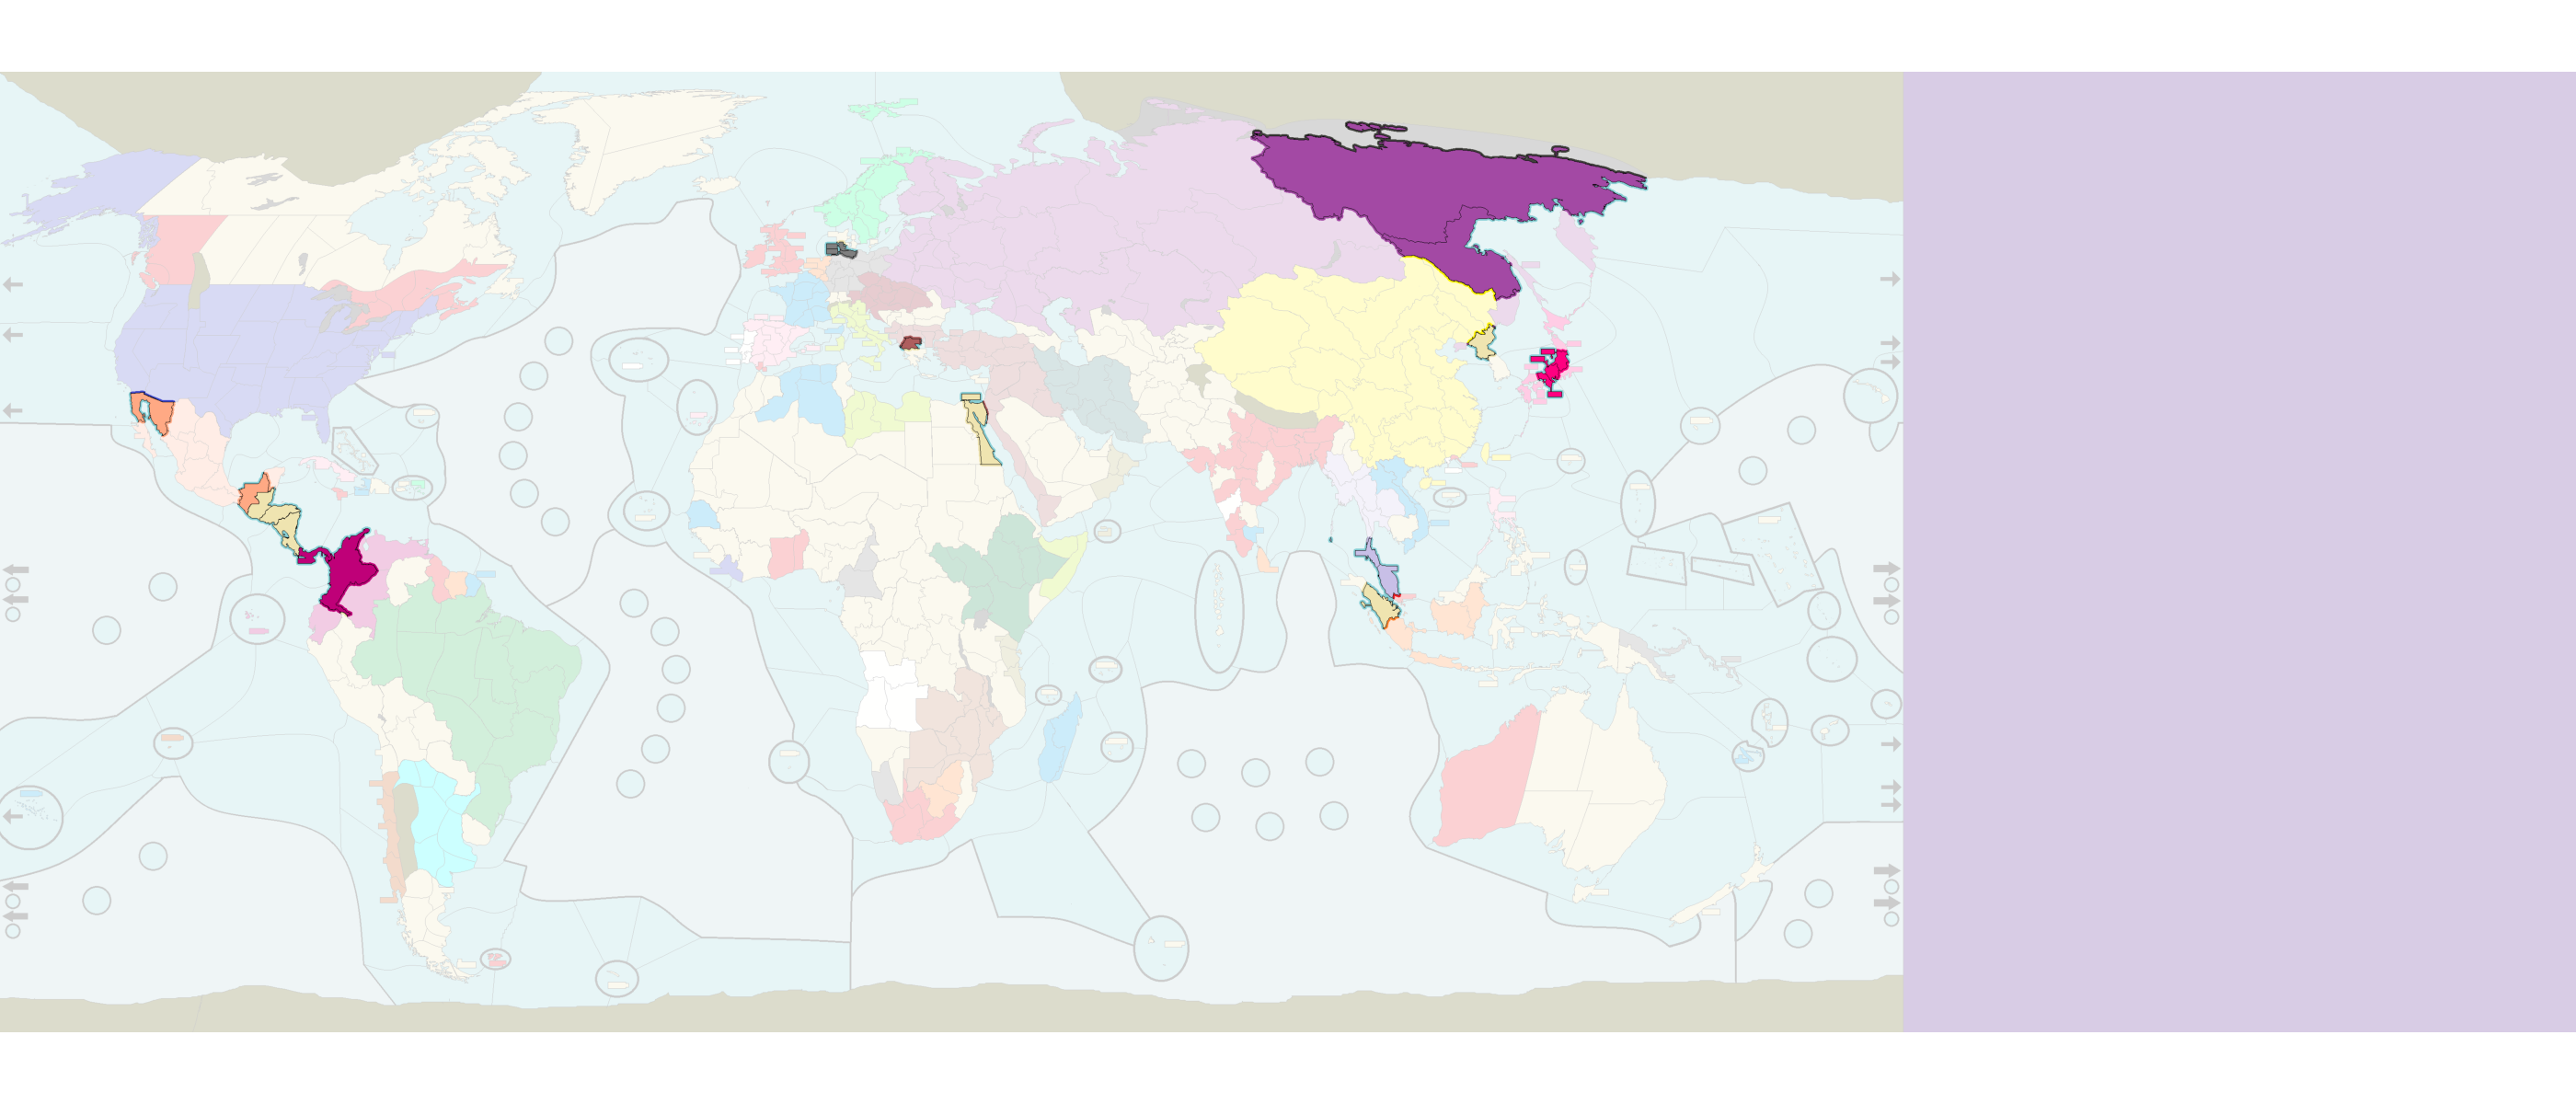

In [53]:
# highlight(rgb,expand_labels(lbls==idx,5))
# highlight(rgb,expand_labels(sum(lbls==i for i in ntx[idx]),5))
highlight(rgb,expand_labels(sum(lbls==i for i in mcoast),5))

In [54]:
canals = {497, 60, 299, 193, }

In [55]:
for idx in canals:
    if idx in mcoast:
        del mcoast[idx]
    es = edges[idx]
    if isinstance(es['fleet'], dict):
        es['fleet'] = {e for cs in es['fleet'].values() for e in cs}
#     print(edges[idx])

In [56]:
def angle_diff(angle1, angle2, period=2*np.pi):
	a = angle1 - angle2
	return (a + period/2) % period - period/2

from scipy.optimize import linear_sum_assignment # hungarian algorithm

In [103]:
cnames = ['ec', 'nc', 'wc', 'sc']
assignments = {}
for idx, coasts in tqdm(mcoast.items()):
    ct = np.array(regions[idx].centroid[::-1])
    coasts = [[c for c in coasts[ic] if nodeIDs[c]['type'] == 'sea'] for ic in range(len(coasts))]
    
#     locs = [np.array([regions[c].centroid[::-1] for c in cs]) for cs in coasts]
    
    bd = find_boundaries(fixed == idx, mode='outer').astype(int)
    breg = regionprops(bd)[0]
    sel = fixed[bd.astype(bool)]
    locs = [breg.coords[sum(sel==c for c in cs).astype(bool)][...,::-1] for cs in coasts]
    
    mu = np.stack([loc.mean(0) for loc in locs],0)
    dr = mu - ct
    dr[:,1] *= -1
    theta = np.arctan2(dr[:,1], dr[:,0]).reshape(-1,1)
    lims = np.arange(4).reshape(1,-1)/4*np.pi*2
    costs = np.abs(angle_diff(theta, lims))
    picks = linear_sum_assignment(costs)
    assignments[idx] = {i:cnames[j] for i,j in zip(*picks)}


len(assignments)

  0%|          | 0/17 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [57]:
# assignments = {12: {0: 'sc', 1: 'ec'}, 67: {0: 'ec', 1: 'wc'}, 72: {0: 'ec', 1: 'nc'}, 208: {0: 'ec', 1: 'sc'}, 212: {0: 'ec', 1: 'wc'}, 228: {0: 'ec', 1: 'wc'}, 244: {0: 'wc', 1: 'sc'}, 295: {0: 'nc', 1: 'sc'}, 309: {0: 'sc', 1: 'wc'}, 416: {0: 'nc', 1: 'sc'}, 446: {0: 'ec', 1: 'wc'}, 448: {0: 'ec', 1: 'sc'}, 467: {0: 'ec', 1: 'sc'}, 489: {0: 'wc', 1: 'ec'}, 509: {0: 'wc', 1: 'ec'}, 513: {0: 'wc', 1: 'nc'}, 541: {0: 'wc', 1: 'ec'}}
assignments = {12: {0: 'sc', 1: 'ec'}, 67: {0: 'ec', 1: 'wc'}, 72: {0: 'ec', 1: 'nc'}, 208: {0: 'ec', 1: 'sc'}, 212: {0: 'ec', 1: 'wc'}, 228: {0: 'ec', 1: 'wc'}, 244: {0: 'wc', 1: 'sc'}, 295: {0: 'nc', 1: 'sc'}, 309: {0: 'sc', 1: 'wc'}, 416: {0: 'nc', 1: 'sc'}, 446: {0: 'ec', 1: 'wc'}, 448: {0: 'ec', 1: 'sc'}, 467: {0: 'ec', 1: 'sc'}, 489: {0: 'wc', 1: 'ec'}, 509: {0: 'wc', 1: 'ec'}, 513: {0: 'wc', 1: 'nc'}, 541: {0: 'wc', 1: 'ec'}}
# print(assignments)

In [58]:
idx = 419
print(edges[idx])
print(assignments.get(idx,None))
print(mcoast.get(idx,None))

{'fleet': {448, 391, 397, 429, 398, 497, 403, 467, 439, 446}}
None
None


<IPython.core.display.Javascript object>


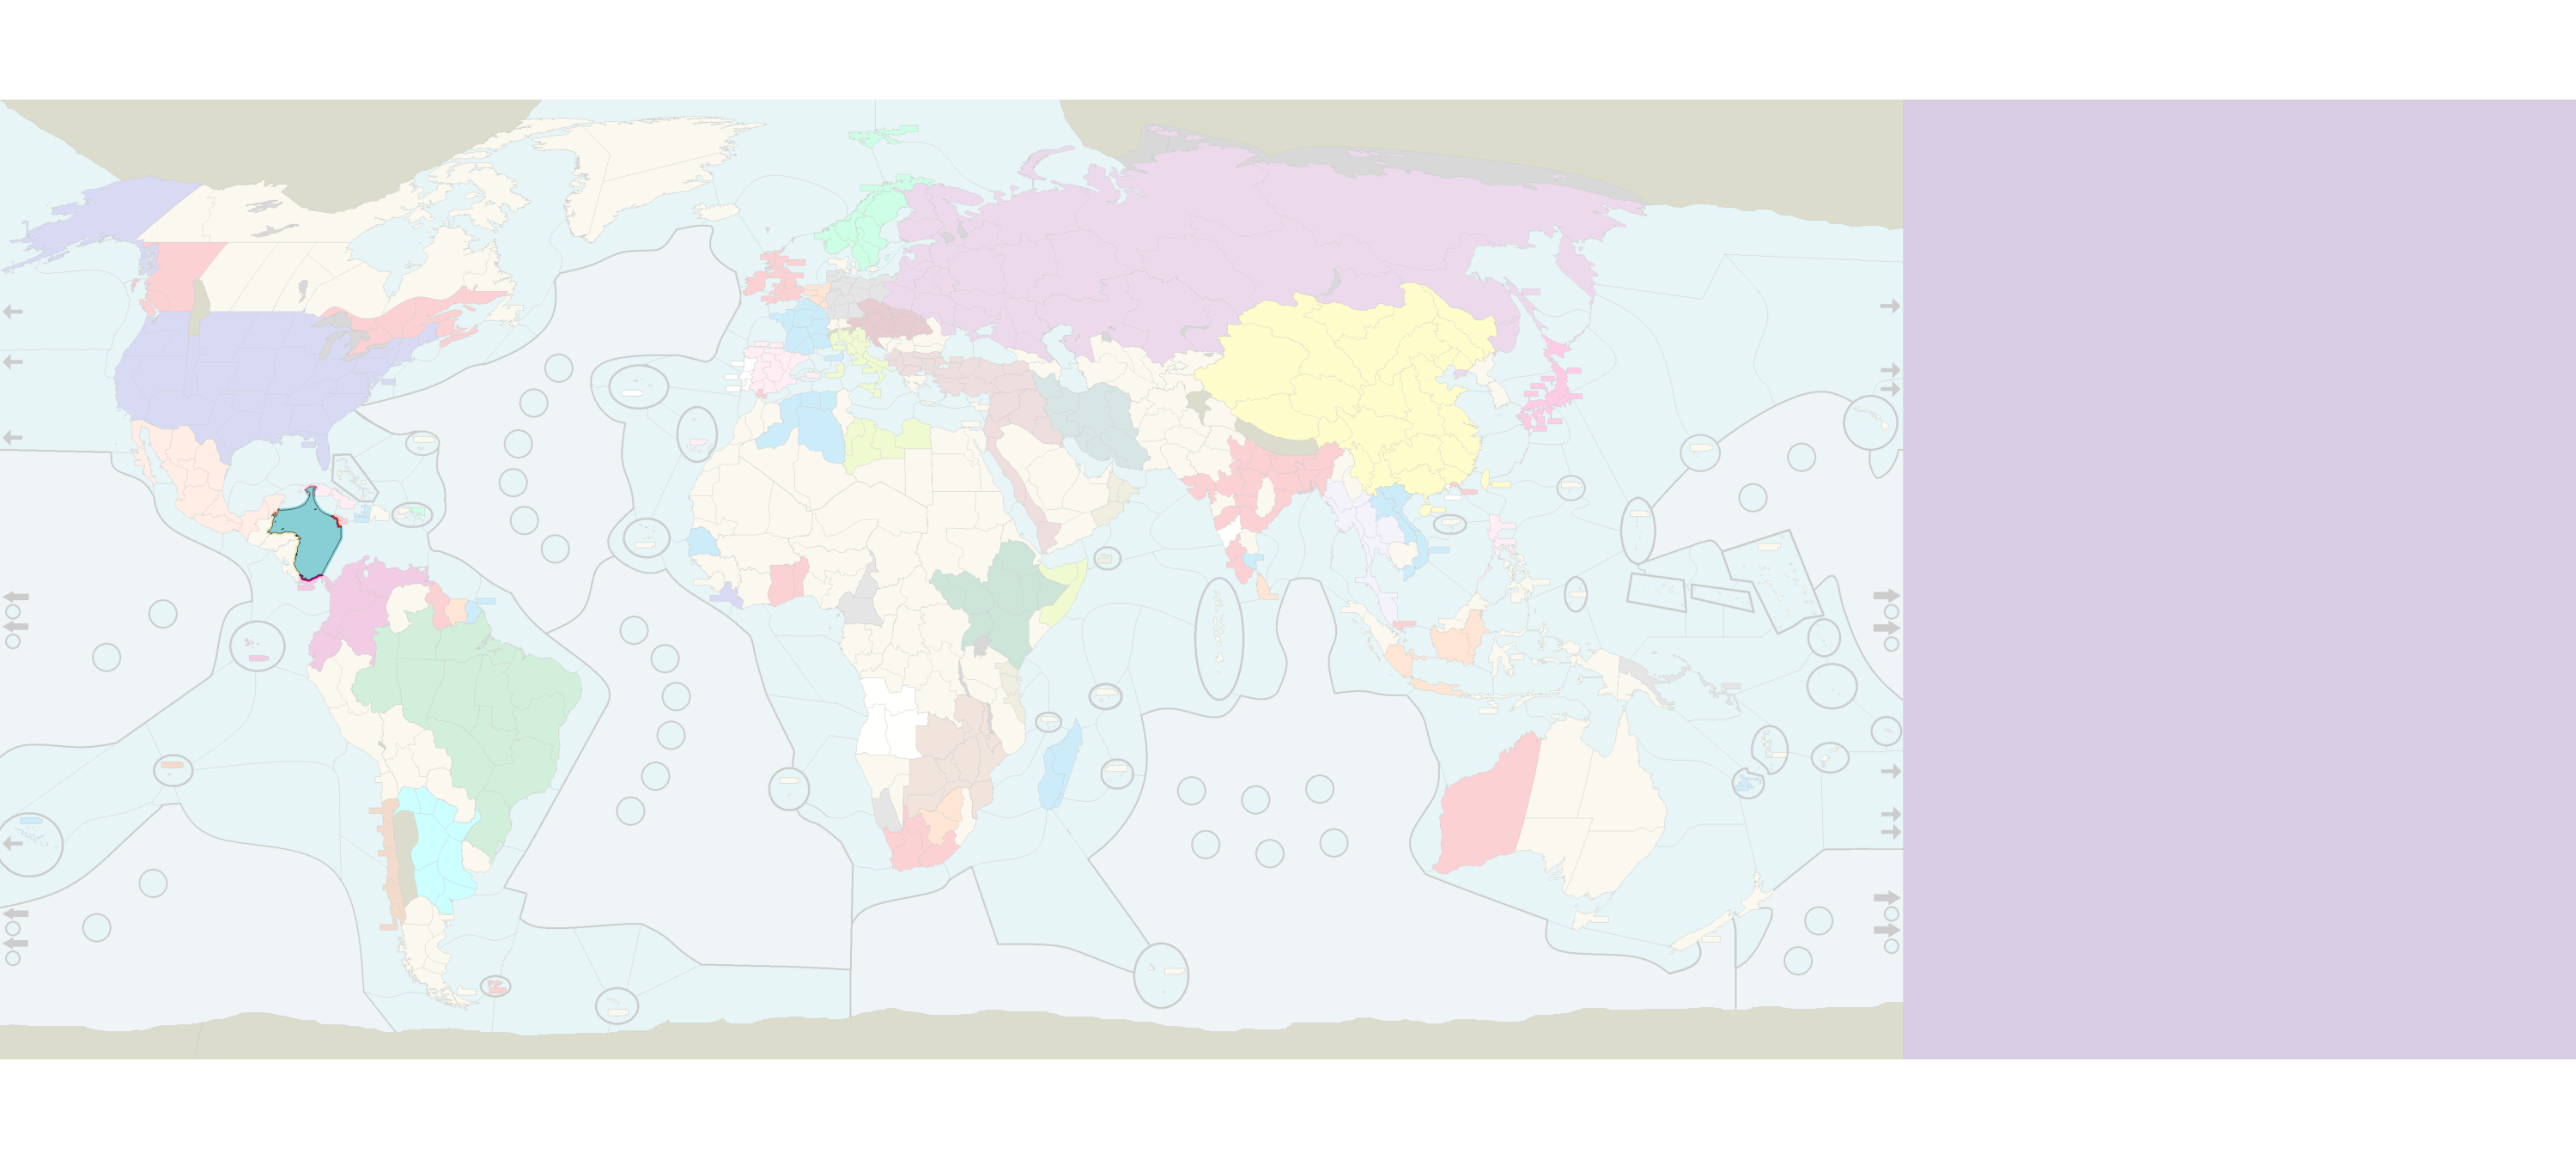

In [60]:
highlight(rgb,expand_labels(lbls==idx,5))

In [59]:
manual = {'fleet':[(192, 59)], 'army':[]}

for typ in ['fleet', 'army']:
    for x,y in manual[typ]:
        edges[x][typ].add(y)
        edges[y][typ].add(x)

In [60]:
for idx, es in edges.items():
    if 'fleet' in es and isinstance(es['fleet'], dict):
        for ci, coast in es['fleet'].items():
            sea = {x for x in coast if nodeIDs[x[0] if isinstance(x, tuple) else x]['type'] == 'sea'}
            for c in coast:
                if isinstance(c, tuple):
                    c = c[0]
                cs = edges[c]['fleet']
                if isinstance(cs, set):
                    cs.discard(idx)
                    cs.add((idx, ci))
                else:
                    for k,vs in cs.items():
                        if len(sea.intersection(vs)):
                            cs[k].discard(idx)
                            cs[k].add((idx,ci))

In [61]:
[(node['ID'], node['name']) for node in nodes if node['name'].endswith('-ec') or node['name'].endswith('-nc') or node['name'].endswith('-wc') or node['name'].endswith('-sc')]

[]

In [155]:
for idx, node in nodeIDs.items():
    node['edges'] = {t:[('{}-{}'.format(nodeIDs[e[0]]['name'], assignments[e[0]][e[1]]) 
                         if isinstance(e, tuple) 
                         else nodeIDs[e]['name']) 
                        for e in es]
                     for t, es in edges[idx].items() if not isinstance(es, dict)}
    if 'fleet' in edges[idx] and isinstance(edges[idx]['fleet'], dict):
        node['edges']['fleet'] = {assignments[idx][k]: [('{}-{}'.format(nodeIDs[e[0]]['name'], assignments[e[0]][e[1]]) 
                                                         if isinstance(e, tuple) 
                                                         else nodeIDs[e]['name']) 
                                                        for e in es] for k,es in edges[idx]['fleet'].items()}

In [156]:
regs = {node['name']:node for node in nodes}
len(regs)

781

In [64]:
node

{'ID': 781,
 'name': 'PR-water',
 'tiles': [1036],
 'type': 'sea',
 'env': 'island',
 'edges': {'fleet': ['MONA', 'PR', 'STBE-water', 'ECAR']}}

In [65]:
regs['SAO']

{'ID': 721,
 'name': 'SAO',
 'tiles': [1154],
 'type': 'sea',
 'env': 'ocean',
 'edges': {'fleet': ['BELB',
   'SANB',
   'IVOR',
   'ORAB',
   'RDLP',
   'COGH',
   'NPAT',
   'ABAS',
   'SCOB',
   'SATL',
   'ATAN',
   'NAO',
   'INO',
   'ANGB',
   'ROMA',
   'RIOB',
   'SAO1',
   'SAO2',
   'SAO3',
   'SAO4',
   'GRCO',
   'SAO5',
   'SAO6',
   'STHE-water']}}

In [66]:
from copy import deepcopy

# Fix Oceans

In [157]:
oceans = {node['name']:node for node in nodes if node.get('env', '') == 'ocean'}
print(oceans.keys())

dict_keys(['NPO', 'SPO', 'NAO', 'SAO', 'INO'])


In [158]:
olinks = {name:reg['edges']['fleet'][0] for name, reg in regs.items() if reg['type'] == 'sea' and 'fleet' in reg['edges'] and len(reg['edges']['fleet']) == 1}
oblinks = {}
for k,v in olinks.items():
    if v not in oblinks:
        oblinks[v] = []
    oblinks[v].append(k)
print(olinks)

{'NAO1': 'NAO', 'NAO2': 'NAO', 'NAO3': 'NAO', 'NPO1': 'NPO', 'NAO4': 'NAO', 'NPO2': 'NPO', 'NAO5': 'NAO', 'NAO6': 'NAO', 'NPO4': 'NPO', 'SAO1': 'SAO', 'NPO3': 'NPO', 'SAO2': 'SAO', 'SAO3': 'SAO', 'SAO4': 'SAO', 'SAO5': 'SAO', 'INO3': 'INO', 'INO1': 'INO', 'INO2': 'INO', 'SAO6': 'SAO', 'INO6': 'INO', 'INO4': 'INO', 'INO5': 'INO', 'SPO4': 'SPO', 'SPO1': 'SPO', 'SPO3': 'SPO', 'SPO2': 'SPO'}


In [159]:
for node in nodes:
    for t, es in node['edges'].items():
        if isinstance(es, dict):
            for cn, coast in es.items():
                for oc, ols in oblinks.items():
                    if oc in coast:
                        es[cn].remove(oc)
                        es[cn].extend(ols)
        else:
            for oc, ols in oblinks.items():
                if oc in es:
                    es.remove(oc)
                    es.extend(ols)
for on, oc in olinks.items():
    node = regs[on]
    if 'nodes' not in oceans[oc]:
        oceans[oc]['nodes'] = []
    oceans[oc]['nodes'].append(on)
    node['ocean'] = oc
    node['edges'] = deepcopy(regs[oc]['edges'])
    if on in node['edges']['fleet']:
        node['edges']['fleet'].remove(on)

In [160]:
regs['KIRI-water']

{'ID': 544,
 'name': 'KIRI-water',
 'tiles': [1331],
 'type': 'sea',
 'env': 'island',
 'edges': {'fleet': ['NKOR', 'NPEC', 'BISM']}}

In [161]:
# name_img = np.array([(nodeIDs[i]['name'] if i in nodeIDs else '--') for i in lbls.reshape(-1).tolist()]).reshape(*lbls.shape)
# name_img.shape

In [162]:
# showx(rgb, cover=name_img)

# Fix Islands

In [163]:
islands = {node['name']:node for node in nodes if node.get('env', '') == 'island'}
ilinks = {name:name.split('-')[0] for name in islands}
# print(islands)
len(islands), len(ilinks)

(35, 35)

In [164]:
for iw, il in ilinks.items():
    if il in regs and iw in regs:
        node = regs[il]
        node['name'] = il
        node['water'] = iw
        node['edges'] = regs[iw]['edges']
        node['type'] = 'coast'
        regs[iw]['island'] = il
        del regs[iw]
len(nodes) - len(regs)

33

In [165]:
replacements = {**ilinks}
old = {}

for name, reg in regs.items():
    reg['edges'] = {et: ([replacements.get(e,e) for e in ets]
                              if isinstance(ets, list) else
                            {c: [replacements.get(e,e) for e in es] for c, es in ets.items()})
                         for et, ets in reg['edges'].items()}
    pass
for frm, to in replacements.items():
    if frm in regs:
        regs[to] = regs[frm]
        regs[to]['name'] = to
        old[frm] = deepcopy(regs[frm])
        del regs[frm]
len(old)

2

In [166]:
# remove self edges

for name, reg in regs.items():
    reg['edges'] = {et: ([e for e in ets if e != name]
                              if isinstance(ets, list) else
                            {c: [e for e in es if e != name] for c, es in ets.items()})
                         for et, ets in reg['edges'].items()}

In [125]:
name, idx = None, None

name = 'VANU'

if name is not None:
    reg = regs[name]
    idx = reg['ID']
else:
    reg = nodeIDs[idx]
    name = reg['name']
print(reg)

{'ID': 624, 'name': 'VANU', 'tiles': [1536, 1543, 1575, 1561, 1579, 1534], 'type': 'coast', 'edges': {'fleet': ['NKOR', 'ECOS', 'WKOR']}, 'water': 'VANU-water', 'area': 581}


<IPython.core.display.Javascript object>


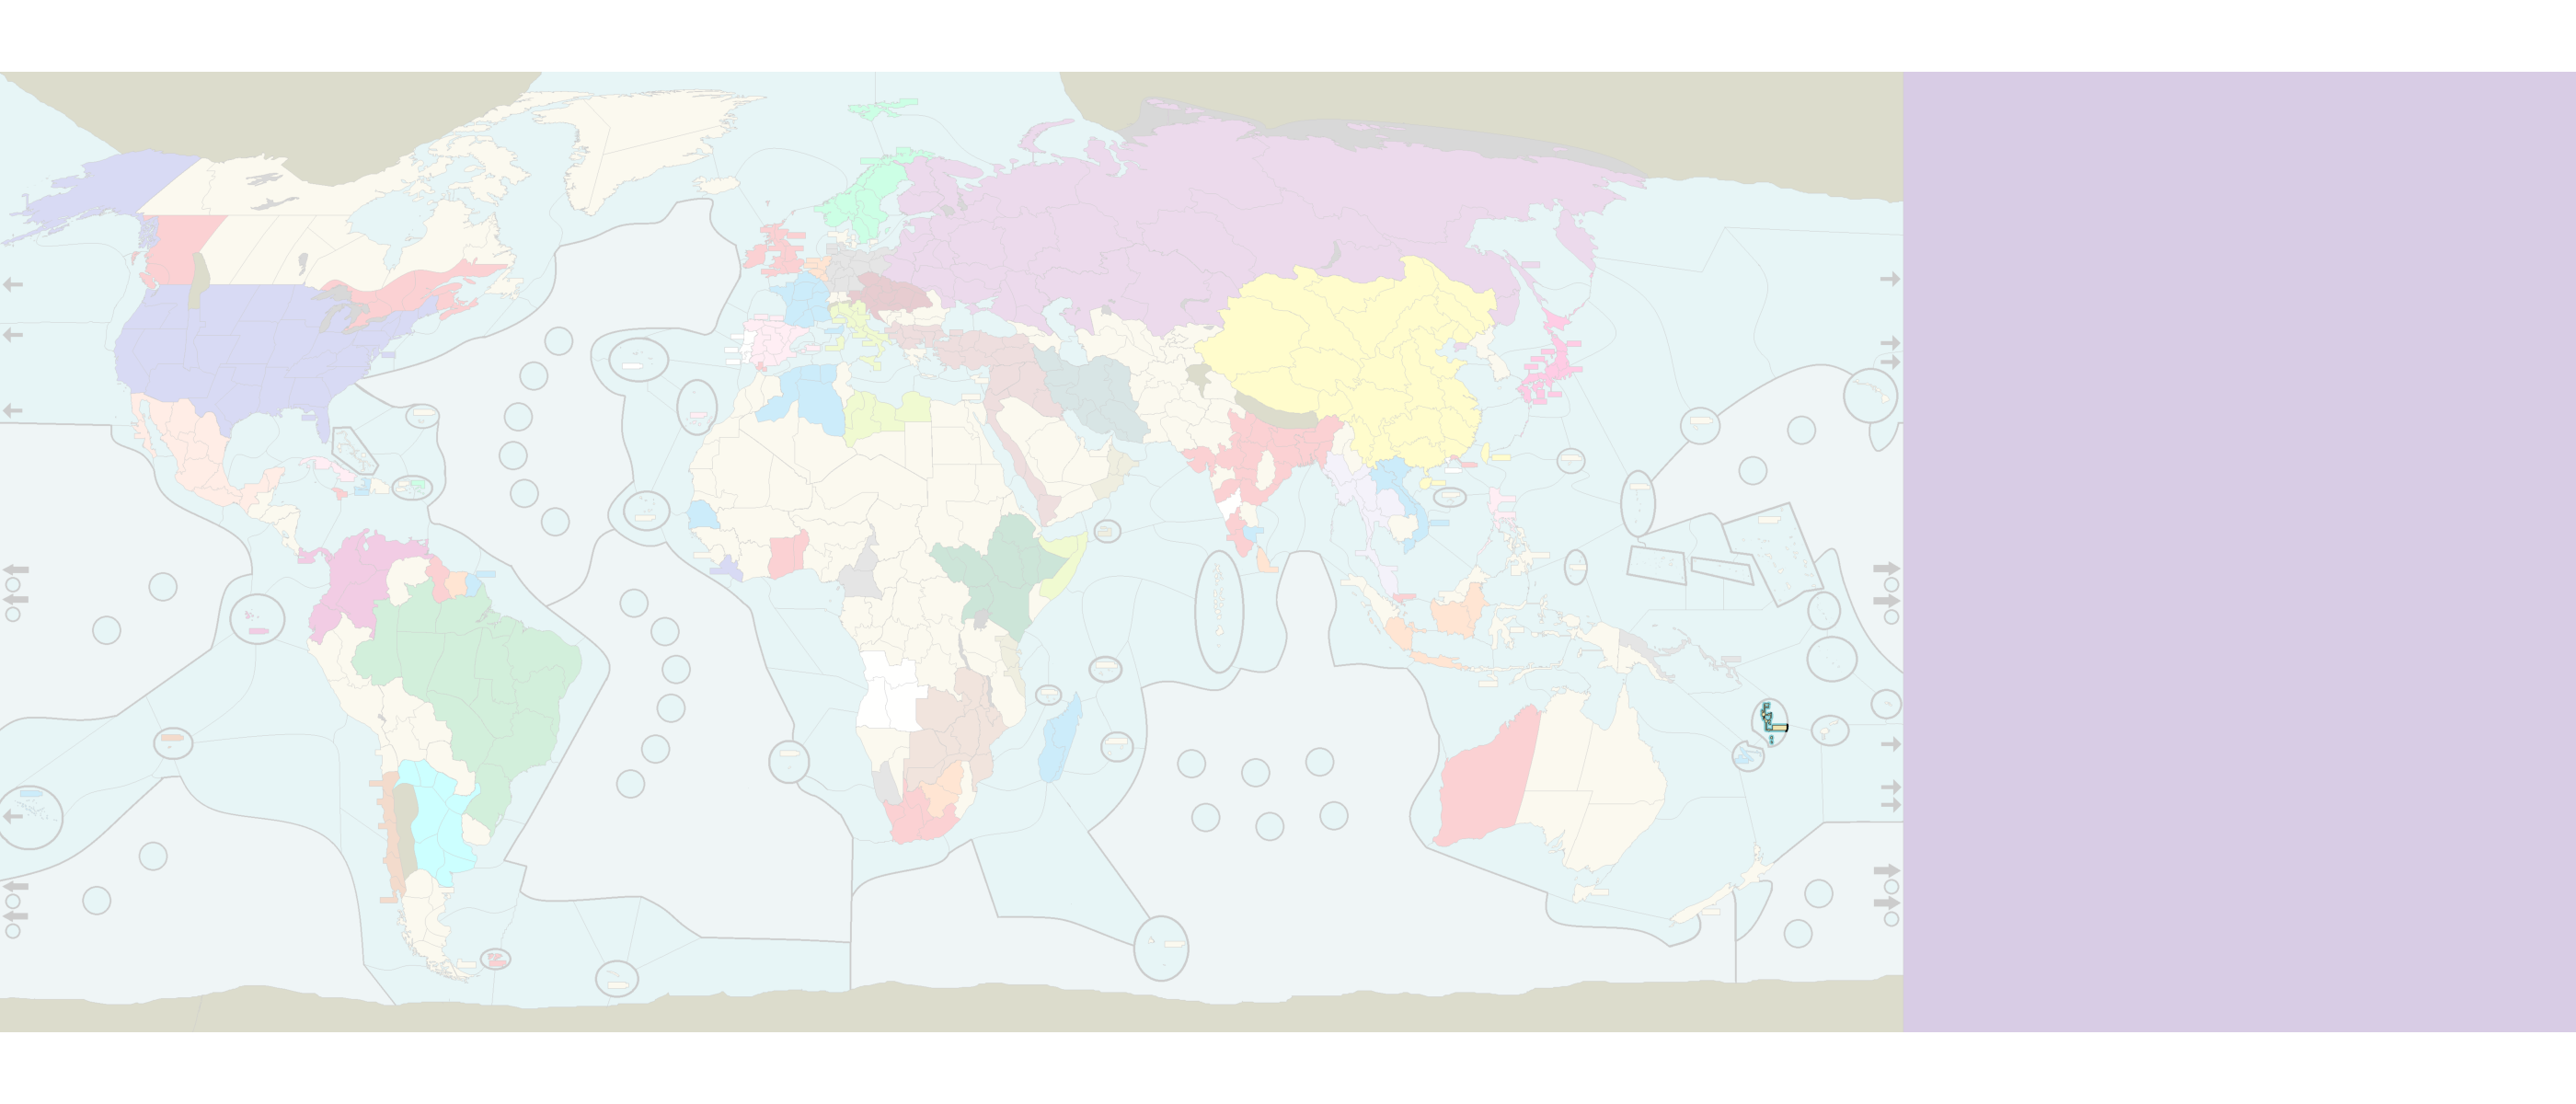

In [118]:
highlight(rgb,expand_labels(lbls==idx,5))

In [167]:
for node in nodes:
    node['area'] = regions[node['ID']].area.item()

In [175]:
newbgs = {**oceans, **islands}
if 'KIRI-water' in newbgs:
    del newbgs['KIRI-water']
if 'TUVA-water' in newbgs:
    del newbgs['TUVA-water']
print(newbgs.keys())

dict_keys(['NPO', 'SPO', 'NAO', 'SAO', 'INO', 'HAWA-water', 'BAHA-water', 'NAUR-water', 'CARO-water', 'MALD-water', 'TONG-water', 'FIJI-water', 'AOLE-water', 'TUAM-water', 'MCD-water', 'GALA-water', 'AZOR-water', 'RULL-water', 'CANA-water', 'VERD-water', 'STHE-water', 'VANU-water', 'SNDW-water', 'WAKE-water', 'RAPA-water', 'MAUR-water', 'PALU-water', 'CALE-water', 'BERM-water', 'MAHE-water', 'GUAM-water', 'XISH-water', 'SOCO-water', 'FALK-water', 'COMO-water', 'BALE-water', 'STBE-water', 'PR-water'])


In [173]:
graph = {name:node for name, node in regs.items() if name not in newbgs}
len(graph)

743

In [170]:
# save_yaml(graph, root/'graph.yaml')

In [176]:
# save_yaml(newbgs, root/'bgs.yaml')

In [134]:
len(newbgs)

40

# Units

In [1]:
# units = np.array(Image.open(root/'wd_units.png').convert('RGBA'))
# urgb = units[...,:3]
# ulbls = label(units[...,-1])
# urgb.shape, ulbls.shape

In [2]:
# uregs = regionprops(ulbls)
# # plt.figure()
# # plt.hist([u.area for u in uregs], bins=100);
# uregs.insert(0, None)
# len(uregs)

In [3]:
# uregs

In [4]:
# showx(ulbls, cover=ulbls)

In [5]:
# arrows = {}